In [1]:
import numpy as np
from numpy import random
from scipy import interpolate
import matplotlib.pyplot as plt
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import tensorflow as tf


In [2]:
sess=tf.Session()

#initial weight
def weight_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.contrib.layers.xavier_initializer())
#intial bias
def bias_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.constant_initializer(0.1))
#placeholder
with tf.name_scope('Input'):
    X=tf.placeholder(tf.float32,[None,8192])
with tf.name_scope('Label'):
    Y_=tf.placeholder(tf.float32,[None,2])
lr=tf.placeholder(tf.float32)

#reshape layer
with tf.name_scope('Reshape_layer'):
    XX=tf.reshape(X,[-1,8192,1,1])
#convolution layer 1
w_conv1=weight_variable('w_conv1',[16,1,1,16])
b_conv1=bias_variable('b_conv1',[16])
with tf.name_scope('Convolution_layer1'):
    conv1=tf.nn.conv2d(XX,w_conv1,strides=[1,1,1,1],padding='VALID')
print(conv1.shape)

#activation layer 1
with tf.name_scope('Relu_layer1'):
    h_conv1=tf.nn.relu(conv1+b_conv1)

#pooling layer 1
with tf.name_scope('Pooling_layer1'):
    h_pool1=tf.nn.max_pool(h_conv1,[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool1.shape)

#convolution layer 2
w_conv2=weight_variable('w_conv2',[8,1,16,32])
b_conv2=bias_variable('b_conv2',[32])
with tf.name_scope('Convolution_layer2'):
    conv2=tf.nn.atrous_conv2d(h_pool1,w_conv2,rate=4,padding='VALID')
print(conv2.shape)

#activation layer 2
with tf.name_scope('Relu_layer2'):
    h_conv2=tf.nn.relu(conv2+b_conv2)

#pooling layer 2
with tf.name_scope('Pooling_layer2'):
    h_pool2=tf.nn.max_pool(h_conv2,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool2)

#convolution layer 3
w_conv3=weight_variable('w_conv3',[8,1,32,64])
b_conv3=bias_variable('b_conv3',[64])
with tf.name_scope('Convolution_layer3'):
    conv3=tf.nn.atrous_conv2d(h_pool2,w_conv3,rate=4,padding='VALID')
print(conv3)

#activation layer 3
with tf.name_scope('Relu_layer3'):
    h_conv3=tf.nn.relu(conv3+b_conv3)

#pooling layer 3
with tf.name_scope('Pooling_layer3'):
    h_pool3=tf.nn.max_pool(h_conv3,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool3.shape)

#flatten layer
with tf.name_scope('Flatten_layer'):
    h_flatten=tf.reshape(h_pool3,[-1,7680])
print(h_flatten.shape)

#linear layer 1
w_linear1=weight_variable('w_linear1',[7680,64])
b_linear1=bias_variable('b_linear1',[64])

#activation layer 4
with tf.name_scope('Relu_layer4'):
    h_linear1=tf.nn.relu(tf.matmul(h_flatten,w_linear1)+b_linear1)

#linear layer 2
w_linear2=weight_variable('w_linear2',[64,2])
b_linear2=bias_variable('b_linear2',[2])

#activation layer 5
with tf.name_scope('Output'):
    Y=tf.matmul(h_linear1,w_linear2)+b_linear2

#loss function
mse=tf.losses.mean_squared_error(Y_,Y)

#relative error
relative_error=tf.reduce_mean(tf.cast(tf.divide(tf.abs(tf.subtract(Y,Y_)),Y_),dtype=tf.float32))*100

#optimization
optimizer=tf.train.AdamOptimizer(learning_rate=lr)
train_step=optimizer.minimize(mse)

#visualization
tf.summary.scalar('relative_error',relative_error)
tf.summary.scalar('meansquared_error',tf.log(mse))
merged=tf.summary.merge_all()
train_writer=tf.summary.FileWriter('/home/txie/project/mass/train/',sess.graph)
test_writer=tf.summary.FileWriter('/home/txie/project/mass/test/')

#run
sess.run(tf.global_variables_initializer())

(?, 8177, 1, 16)
(?, 2045, 1, 16)
(?, ?, ?, 32)
Tensor("Pooling_layer2/MaxPool:0", shape=(?, ?, ?, 32), dtype=float32)
Tensor("Convolution_layer3/atrous_conv2d/BatchToSpaceND:0", shape=(?, ?, ?, 64), dtype=float32)
(?, ?, ?, 64)
(?, 7680)


In [3]:
#get data
f=h5py.File('EOB-M1.h5','r')
time=f['hPlus'][:,:,0]
signal=f['hPlus'][:,:,1]
ratio=f['MassRatio']
newsig=[]


In [4]:
m1=[]
m2=[]
newsigt=[]
m1t=[]
m2t=[]
for j in range(901):
    if j%10==0:
        for i in range(91):
            totalmass=10+i
            fx=interpolate.interp1d(time[j]*totalmass,signal[j],kind='cubic')
            xnew=np.linspace(time[j][72228]*totalmass-1,time[j][72228]*totalmass,8192)
            f=fx(xnew)
            t=ratio[j]
            if j%100==0:
                newsigt.append(f)
                m1t.append(t/(1+t)*totalmass)
                m2t.append(1/(1+t)*totalmass)
            else:
                newsig.append(f)
                m1.append(t/(1+t)*totalmass)
                m2.append(1/(1+t)*totalmass)
p=list(zip(newsig,m1,m2))
random.shuffle(p)
newsig,m1,m2=zip(*p)
newsig=np.array(newsig)
q=list(zip(newsigt,m1t,m2t))
random.shuffle(q)
newsigt,m1t,m2t=zip(*q)
newsigt=np.array(newsigt)

In [5]:
#get test set
snr=1
test_sig=np.zeros([910,8192])
test_label=np.zeros([910,2])
for i in range(910):
    r=random.randint(0,1638)
    test_label[i]=[m1t[i],m2t[i]]
    test_sig[i,0:8191-r:1]=newsigt[i,r:8191:1]*snr
    temp=copy.copy(test_sig[i])
    test_sig[i]=test_sig[i]+np.random.normal(0,1,8192)
    test_sig[i]=test_sig[i]/np.std(test_sig[i])
    '''
    print(i,test_label[i])
    plt.figure()
    plt.plot(test_sig[i],'b')
    plt.plot(temp,'r')
    plt.show()
    '''

In [6]:
#get train set
epoch=100000
learning_rate=0.001
error_train=[]
error_test=[]
mse_train=[]
mse_test=[]
train_sig=np.zeros([50,8192])
train_label=np.zeros([50,2])
#training
for i in range(epoch):
    snr=1
    for j in range(50):
        r=random.randint(0,1638)
        train_label[j]=[m1[(i*50+j)%7371],m2[(i*50+j)%7371]]
        train_sig[j,0:8191-r:1]=newsig[(i*50+j)%7371,r:8191:1]*snr
        temp=copy.copy(train_sig[j])
        train_sig[j]=train_sig[j]+np.random.normal(0,1,8192)
        train_sig[j]=train_sig[j]/np.std(train_sig[j])
        '''
        if j==25:
            print((i*50+j)%901,train_label[j])
            plt.figure()
            plt.plot(train_sig[j],'b')
            plt.plot(temp,'r')
            plt.show
        '''
    if (i+1)%100==0:
        summary,a,c=sess.run([merged,relative_error,mse],feed_dict={X:test_sig,Y_:test_label})
        error_test.append(a)
        mse_test.append(c)
        print('test:'+' relative_error:'+str(a)+' mse:'+str(c))
        test_writer.add_summary(summary,i)
    a,c=sess.run([relative_error,mse],feed_dict={X:train_sig,Y_:train_label})
    error_train.append(a)
    mse_train.append(c)
    print('epoch:'+str(i)+' relative_error:'+str(a)+' mse:'+str(c))
    summary,_=sess.run([merged,train_step],feed_dict={X:train_sig,Y_:train_label,lr:learning_rate})
    train_writer.add_summary(summary,i)
    train_sig=np.zeros([50,8192])
    train_label=np.zeros([50,2])
    
        

epoch:0 relative_error:96.8624 mse:1619.64
epoch:1 relative_error:65.2285 mse:875.276
epoch:2 relative_error:60.8103 mse:690.929
epoch:3 relative_error:67.0538 mse:303.111
epoch:4 relative_error:125.845 mse:325.775
epoch:5 relative_error:145.005 mse:472.543
epoch:6 relative_error:132.721 mse:503.826
epoch:7 relative_error:120.767 mse:406.517
epoch:8 relative_error:66.9097 mse:258.226
epoch:9 relative_error:69.8771 mse:389.116
epoch:10 relative_error:59.6962 mse:356.285
epoch:11 relative_error:73.5729 mse:373.632
epoch:12 relative_error:61.6692 mse:405.499
epoch:13 relative_error:64.8699 mse:401.901
epoch:14 relative_error:81.856 mse:325.01
epoch:15 relative_error:72.9963 mse:300.427
epoch:16 relative_error:88.859 mse:255.493
epoch:17 relative_error:136.315 mse:263.825
epoch:18 relative_error:113.786 mse:280.031
epoch:19 relative_error:125.344 mse:297.637
epoch:20 relative_error:89.932 mse:293.762
epoch:21 relative_error:97.3555 mse:317.384
epoch:22 relative_error:110.844 mse:331.861
ep

epoch:185 relative_error:34.0716 mse:42.4805
epoch:186 relative_error:35.6938 mse:29.9065
epoch:187 relative_error:29.9352 mse:47.7114
epoch:188 relative_error:41.4685 mse:35.3809
epoch:189 relative_error:34.0817 mse:53.5075
epoch:190 relative_error:28.3952 mse:28.166
epoch:191 relative_error:26.1236 mse:54.2105
epoch:192 relative_error:26.9747 mse:40.0979
epoch:193 relative_error:26.6811 mse:23.9123
epoch:194 relative_error:32.3437 mse:31.5546
epoch:195 relative_error:29.4617 mse:37.9315
epoch:196 relative_error:40.5367 mse:29.2227
epoch:197 relative_error:35.6854 mse:40.431
epoch:198 relative_error:29.6172 mse:49.8365
test: relative_error:37.9776 mse:52.0984
epoch:199 relative_error:34.3241 mse:47.1167
epoch:200 relative_error:35.3674 mse:43.4785
epoch:201 relative_error:43.0553 mse:38.6798
epoch:202 relative_error:32.3475 mse:37.7686
epoch:203 relative_error:29.036 mse:27.2757
epoch:204 relative_error:30.1283 mse:46.4641
epoch:205 relative_error:22.1439 mse:49.0759
epoch:206 relativ

epoch:367 relative_error:27.219 mse:28.2957
epoch:368 relative_error:21.6632 mse:21.0653
epoch:369 relative_error:30.0256 mse:24.806
epoch:370 relative_error:33.179 mse:22.575
epoch:371 relative_error:25.9443 mse:31.3989
epoch:372 relative_error:27.5867 mse:31.1155
epoch:373 relative_error:26.8388 mse:25.3509
epoch:374 relative_error:28.5561 mse:16.7269
epoch:375 relative_error:31.6766 mse:29.7061
epoch:376 relative_error:35.6261 mse:25.7819
epoch:377 relative_error:33.9814 mse:30.4808
epoch:378 relative_error:41.7209 mse:28.1463
epoch:379 relative_error:39.3914 mse:28.2838
epoch:380 relative_error:32.1383 mse:22.1658
epoch:381 relative_error:34.2226 mse:22.6846
epoch:382 relative_error:26.3572 mse:19.0237
epoch:383 relative_error:23.6634 mse:23.3259
epoch:384 relative_error:23.121 mse:44.8109
epoch:385 relative_error:17.6914 mse:18.0045
epoch:386 relative_error:24.9874 mse:24.7975
epoch:387 relative_error:32.6834 mse:20.5505
epoch:388 relative_error:21.0526 mse:21.1859
epoch:389 relat

epoch:549 relative_error:28.5353 mse:26.2585
epoch:550 relative_error:20.9383 mse:30.902
epoch:551 relative_error:27.4966 mse:23.5702
epoch:552 relative_error:28.609 mse:25.0893
epoch:553 relative_error:21.2101 mse:16.9663
epoch:554 relative_error:21.6527 mse:24.1186
epoch:555 relative_error:21.2801 mse:27.6456
epoch:556 relative_error:18.5046 mse:21.4334
epoch:557 relative_error:22.1155 mse:15.2012
epoch:558 relative_error:22.7448 mse:19.0805
epoch:559 relative_error:21.7186 mse:10.0547
epoch:560 relative_error:21.3513 mse:16.2874
epoch:561 relative_error:24.7868 mse:22.9342
epoch:562 relative_error:22.9177 mse:20.8492
epoch:563 relative_error:20.1109 mse:19.7358
epoch:564 relative_error:30.2035 mse:28.7012
epoch:565 relative_error:20.0073 mse:18.7864
epoch:566 relative_error:22.4709 mse:21.8924
epoch:567 relative_error:19.2861 mse:21.9998
epoch:568 relative_error:21.0283 mse:21.702
epoch:569 relative_error:24.2116 mse:22.7755
epoch:570 relative_error:24.4893 mse:35.6711
epoch:571 rel

epoch:732 relative_error:21.3245 mse:16.3084
epoch:733 relative_error:20.7809 mse:24.5912
epoch:734 relative_error:20.117 mse:23.6862
epoch:735 relative_error:22.9233 mse:19.8021
epoch:736 relative_error:20.0694 mse:16.8902
epoch:737 relative_error:17.0078 mse:9.99096
epoch:738 relative_error:18.0839 mse:13.0197
epoch:739 relative_error:17.587 mse:17.7868
epoch:740 relative_error:20.503 mse:25.2408
epoch:741 relative_error:19.1871 mse:24.5794
epoch:742 relative_error:17.4423 mse:22.5333
epoch:743 relative_error:20.866 mse:23.3989
epoch:744 relative_error:21.0376 mse:15.0487
epoch:745 relative_error:17.0743 mse:24.5154
epoch:746 relative_error:21.0407 mse:21.8397
epoch:747 relative_error:22.0307 mse:17.1229
epoch:748 relative_error:22.617 mse:18.6308
epoch:749 relative_error:19.1563 mse:27.1756
epoch:750 relative_error:17.0298 mse:17.7788
epoch:751 relative_error:19.0605 mse:17.9535
epoch:752 relative_error:20.1311 mse:24.1008
epoch:753 relative_error:21.8897 mse:23.5304
epoch:754 relat

epoch:916 relative_error:18.0786 mse:17.6356
epoch:917 relative_error:15.884 mse:16.209
epoch:918 relative_error:24.926 mse:19.9573
epoch:919 relative_error:28.3058 mse:15.4128
epoch:920 relative_error:20.8872 mse:21.0873
epoch:921 relative_error:21.8113 mse:19.7929
epoch:922 relative_error:21.3226 mse:18.6243
epoch:923 relative_error:21.6749 mse:10.8801
epoch:924 relative_error:17.9084 mse:23.7497
epoch:925 relative_error:20.2861 mse:16.3713
epoch:926 relative_error:17.3345 mse:16.517
epoch:927 relative_error:18.3356 mse:21.0612
epoch:928 relative_error:21.0059 mse:27.992
epoch:929 relative_error:19.1232 mse:22.6961
epoch:930 relative_error:18.8892 mse:15.8076
epoch:931 relative_error:20.2499 mse:19.5373
epoch:932 relative_error:16.9825 mse:19.6027
epoch:933 relative_error:34.792 mse:17.1374
epoch:934 relative_error:27.5407 mse:18.9202
epoch:935 relative_error:21.5508 mse:23.5061
epoch:936 relative_error:19.835 mse:29.4971
epoch:937 relative_error:17.2697 mse:21.0968
epoch:938 relativ

epoch:1098 relative_error:16.5429 mse:13.89
test: relative_error:20.1372 mse:26.9223
epoch:1099 relative_error:16.0784 mse:16.8318
epoch:1100 relative_error:20.2043 mse:32.7838
epoch:1101 relative_error:18.0111 mse:32.6441
epoch:1102 relative_error:19.6459 mse:23.9095
epoch:1103 relative_error:17.6443 mse:17.7512
epoch:1104 relative_error:21.1062 mse:25.9259
epoch:1105 relative_error:19.3666 mse:18.7103
epoch:1106 relative_error:25.1259 mse:19.7913
epoch:1107 relative_error:28.0465 mse:19.3341
epoch:1108 relative_error:24.8041 mse:35.5072
epoch:1109 relative_error:15.6778 mse:17.3664
epoch:1110 relative_error:16.6429 mse:15.2606
epoch:1111 relative_error:20.3034 mse:22.1791
epoch:1112 relative_error:21.3427 mse:28.4671
epoch:1113 relative_error:25.3245 mse:18.0075
epoch:1114 relative_error:24.2188 mse:17.275
epoch:1115 relative_error:21.9013 mse:27.2833
epoch:1116 relative_error:15.9602 mse:18.2154
epoch:1117 relative_error:23.0731 mse:24.6627
epoch:1118 relative_error:17.2377 mse:16.2

epoch:1276 relative_error:15.6704 mse:19.1506
epoch:1277 relative_error:19.2618 mse:17.684
epoch:1278 relative_error:25.8639 mse:21.8727
epoch:1279 relative_error:15.2708 mse:14.6116
epoch:1280 relative_error:14.4263 mse:14.0951
epoch:1281 relative_error:17.7306 mse:15.3493
epoch:1282 relative_error:20.6213 mse:16.634
epoch:1283 relative_error:15.7862 mse:31.4362
epoch:1284 relative_error:17.0666 mse:18.7648
epoch:1285 relative_error:21.4301 mse:18.458
epoch:1286 relative_error:20.7599 mse:21.5453
epoch:1287 relative_error:15.9043 mse:17.7983
epoch:1288 relative_error:18.2727 mse:23.1735
epoch:1289 relative_error:16.8853 mse:22.0715
epoch:1290 relative_error:17.7513 mse:16.1544
epoch:1291 relative_error:16.4385 mse:19.368
epoch:1292 relative_error:18.0255 mse:25.3096
epoch:1293 relative_error:15.2984 mse:24.1431
epoch:1294 relative_error:23.5391 mse:21.796
epoch:1295 relative_error:19.7769 mse:18.7285
epoch:1296 relative_error:21.4626 mse:18.2911
epoch:1297 relative_error:19.4767 mse:1

epoch:1455 relative_error:20.7729 mse:20.0574
epoch:1456 relative_error:19.8547 mse:16.9178
epoch:1457 relative_error:19.4521 mse:15.7885
epoch:1458 relative_error:20.0293 mse:10.3043
epoch:1459 relative_error:20.0016 mse:9.39101
epoch:1460 relative_error:23.0055 mse:26.2862
epoch:1461 relative_error:14.7811 mse:16.2993
epoch:1462 relative_error:20.9777 mse:24.3234
epoch:1463 relative_error:21.8429 mse:17.0089
epoch:1464 relative_error:21.788 mse:18.5179
epoch:1465 relative_error:16.5253 mse:19.1605
epoch:1466 relative_error:21.1672 mse:36.8391
epoch:1467 relative_error:14.0 mse:15.5036
epoch:1468 relative_error:20.298 mse:19.3264
epoch:1469 relative_error:22.513 mse:43.2185
epoch:1470 relative_error:17.7234 mse:24.8038
epoch:1471 relative_error:16.4082 mse:19.3375
epoch:1472 relative_error:23.002 mse:30.926
epoch:1473 relative_error:22.351 mse:20.2176
epoch:1474 relative_error:18.5345 mse:11.7301
epoch:1475 relative_error:22.3104 mse:26.9715
epoch:1476 relative_error:18.294 mse:25.169

epoch:1636 relative_error:18.3664 mse:24.8669
epoch:1637 relative_error:15.425 mse:20.0045
epoch:1638 relative_error:14.4939 mse:17.3403
epoch:1639 relative_error:19.2809 mse:14.1443
epoch:1640 relative_error:16.8534 mse:19.107
epoch:1641 relative_error:12.9142 mse:17.6017
epoch:1642 relative_error:17.9567 mse:20.5611
epoch:1643 relative_error:15.3124 mse:14.177
epoch:1644 relative_error:17.7977 mse:10.5539
epoch:1645 relative_error:20.0632 mse:21.6295
epoch:1646 relative_error:18.7725 mse:15.0293
epoch:1647 relative_error:15.1369 mse:11.9054
epoch:1648 relative_error:19.1838 mse:18.2608
epoch:1649 relative_error:15.5109 mse:17.9341
epoch:1650 relative_error:17.5186 mse:13.8134
epoch:1651 relative_error:12.2123 mse:12.8769
epoch:1652 relative_error:16.7812 mse:16.9382
epoch:1653 relative_error:17.2674 mse:25.069
epoch:1654 relative_error:17.1722 mse:12.8305
epoch:1655 relative_error:17.5637 mse:16.4897
epoch:1656 relative_error:15.3355 mse:13.082
epoch:1657 relative_error:17.0474 mse:1

epoch:1816 relative_error:18.4976 mse:23.0275
epoch:1817 relative_error:17.4266 mse:13.2483
epoch:1818 relative_error:25.1436 mse:16.5827
epoch:1819 relative_error:16.5273 mse:20.1174
epoch:1820 relative_error:19.3585 mse:18.2499
epoch:1821 relative_error:17.5151 mse:32.6244
epoch:1822 relative_error:16.3162 mse:19.3051
epoch:1823 relative_error:16.2624 mse:17.7005
epoch:1824 relative_error:15.7877 mse:18.0643
epoch:1825 relative_error:20.3194 mse:17.3345
epoch:1826 relative_error:16.409 mse:11.7293
epoch:1827 relative_error:16.1133 mse:20.5306
epoch:1828 relative_error:13.6473 mse:11.4486
epoch:1829 relative_error:17.899 mse:19.6279
epoch:1830 relative_error:14.3265 mse:20.6698
epoch:1831 relative_error:17.4177 mse:16.7031
epoch:1832 relative_error:14.8992 mse:13.2577
epoch:1833 relative_error:15.4112 mse:13.7828
epoch:1834 relative_error:18.2527 mse:19.0054
epoch:1835 relative_error:16.306 mse:20.5413
epoch:1836 relative_error:14.7866 mse:15.9634
epoch:1837 relative_error:15.9442 mse

epoch:1995 relative_error:15.7467 mse:16.6199
epoch:1996 relative_error:19.2071 mse:18.8696
epoch:1997 relative_error:21.2421 mse:28.482
epoch:1998 relative_error:14.1471 mse:13.0127
test: relative_error:19.2987 mse:23.3993
epoch:1999 relative_error:22.3991 mse:14.4707
epoch:2000 relative_error:16.9324 mse:15.1218
epoch:2001 relative_error:17.8434 mse:15.8861
epoch:2002 relative_error:15.9694 mse:15.0253
epoch:2003 relative_error:15.4147 mse:12.083
epoch:2004 relative_error:15.5035 mse:7.58803
epoch:2005 relative_error:16.7151 mse:26.1661
epoch:2006 relative_error:13.9442 mse:22.9784
epoch:2007 relative_error:12.5882 mse:16.0791
epoch:2008 relative_error:19.0544 mse:9.2269
epoch:2009 relative_error:17.4438 mse:24.5217
epoch:2010 relative_error:17.2479 mse:11.229
epoch:2011 relative_error:18.3389 mse:16.0166
epoch:2012 relative_error:14.9239 mse:18.3685
epoch:2013 relative_error:13.4718 mse:13.8851
epoch:2014 relative_error:15.672 mse:11.581
epoch:2015 relative_error:20.4479 mse:14.7392

epoch:2174 relative_error:17.7942 mse:13.7126
epoch:2175 relative_error:16.0699 mse:14.9515
epoch:2176 relative_error:15.2296 mse:18.8637
epoch:2177 relative_error:16.1838 mse:19.2442
epoch:2178 relative_error:14.2878 mse:16.6815
epoch:2179 relative_error:16.2187 mse:11.6957
epoch:2180 relative_error:15.0446 mse:12.2762
epoch:2181 relative_error:15.4214 mse:12.2446
epoch:2182 relative_error:17.2412 mse:18.1382
epoch:2183 relative_error:17.46 mse:14.4649
epoch:2184 relative_error:17.4986 mse:16.0423
epoch:2185 relative_error:25.4337 mse:16.5373
epoch:2186 relative_error:19.1498 mse:21.0581
epoch:2187 relative_error:19.6461 mse:17.6415
epoch:2188 relative_error:19.5005 mse:20.2914
epoch:2189 relative_error:16.8006 mse:13.8284
epoch:2190 relative_error:15.8525 mse:20.2163
epoch:2191 relative_error:15.8799 mse:19.9709
epoch:2192 relative_error:15.7273 mse:22.3804
epoch:2193 relative_error:16.3272 mse:13.6795
epoch:2194 relative_error:23.2805 mse:27.473
epoch:2195 relative_error:17.9396 mse

epoch:2355 relative_error:18.1497 mse:18.97
epoch:2356 relative_error:13.354 mse:13.6642
epoch:2357 relative_error:17.3582 mse:21.31
epoch:2358 relative_error:17.0911 mse:11.6832
epoch:2359 relative_error:18.7219 mse:14.1812
epoch:2360 relative_error:16.5536 mse:19.7596
epoch:2361 relative_error:16.7116 mse:14.7108
epoch:2362 relative_error:15.7928 mse:15.7447
epoch:2363 relative_error:15.2245 mse:13.1341
epoch:2364 relative_error:17.3765 mse:17.9
epoch:2365 relative_error:14.1336 mse:12.687
epoch:2366 relative_error:16.4463 mse:15.8714
epoch:2367 relative_error:17.1933 mse:14.6176
epoch:2368 relative_error:18.5919 mse:15.5318
epoch:2369 relative_error:17.6399 mse:10.0167
epoch:2370 relative_error:15.3858 mse:14.4382
epoch:2371 relative_error:13.3169 mse:15.9627
epoch:2372 relative_error:17.7288 mse:18.7249
epoch:2373 relative_error:15.2925 mse:18.8716
epoch:2374 relative_error:16.1889 mse:21.4088
epoch:2375 relative_error:19.1606 mse:22.1157
epoch:2376 relative_error:22.4577 mse:21.69

epoch:2536 relative_error:18.7747 mse:25.2207
epoch:2537 relative_error:15.3382 mse:15.4817
epoch:2538 relative_error:14.6124 mse:13.7938
epoch:2539 relative_error:18.9887 mse:29.5125
epoch:2540 relative_error:21.9006 mse:18.4486
epoch:2541 relative_error:18.184 mse:13.4222
epoch:2542 relative_error:20.7114 mse:25.1648
epoch:2543 relative_error:19.4346 mse:14.3068
epoch:2544 relative_error:15.3749 mse:16.8251
epoch:2545 relative_error:14.3373 mse:13.8186
epoch:2546 relative_error:16.119 mse:16.7277
epoch:2547 relative_error:17.1977 mse:17.4353
epoch:2548 relative_error:12.5065 mse:14.2087
epoch:2549 relative_error:15.6535 mse:13.0744
epoch:2550 relative_error:20.204 mse:22.5003
epoch:2551 relative_error:17.2702 mse:19.6122
epoch:2552 relative_error:13.4464 mse:7.92748
epoch:2553 relative_error:14.5209 mse:11.6729
epoch:2554 relative_error:15.6377 mse:15.7489
epoch:2555 relative_error:15.7719 mse:8.72976
epoch:2556 relative_error:16.04 mse:20.4167
epoch:2557 relative_error:20.8812 mse:2

epoch:2715 relative_error:20.6811 mse:15.3674
epoch:2716 relative_error:17.1944 mse:15.7056
epoch:2717 relative_error:16.6462 mse:9.08967
epoch:2718 relative_error:21.8574 mse:29.7949
epoch:2719 relative_error:15.4273 mse:18.2421
epoch:2720 relative_error:14.5082 mse:15.3327
epoch:2721 relative_error:16.1166 mse:21.1188
epoch:2722 relative_error:17.401 mse:30.405
epoch:2723 relative_error:17.451 mse:27.8258
epoch:2724 relative_error:16.5526 mse:17.8151
epoch:2725 relative_error:16.0963 mse:13.1546
epoch:2726 relative_error:15.8085 mse:16.8574
epoch:2727 relative_error:15.3814 mse:14.5081
epoch:2728 relative_error:15.9543 mse:13.7201
epoch:2729 relative_error:20.2525 mse:15.4943
epoch:2730 relative_error:17.2963 mse:15.5655
epoch:2731 relative_error:14.7167 mse:22.098
epoch:2732 relative_error:18.0574 mse:19.0239
epoch:2733 relative_error:14.8698 mse:12.5854
epoch:2734 relative_error:17.5055 mse:19.9334
epoch:2735 relative_error:18.3198 mse:20.2245
epoch:2736 relative_error:16.997 mse:1

epoch:2896 relative_error:12.6217 mse:8.89248
epoch:2897 relative_error:16.5926 mse:23.3874
epoch:2898 relative_error:12.5474 mse:9.5165
test: relative_error:16.5825 mse:21.5522
epoch:2899 relative_error:16.111 mse:14.7805
epoch:2900 relative_error:14.1198 mse:17.6601
epoch:2901 relative_error:15.4119 mse:17.8829
epoch:2902 relative_error:14.5624 mse:14.1611
epoch:2903 relative_error:15.9217 mse:17.0163
epoch:2904 relative_error:25.5092 mse:11.7864
epoch:2905 relative_error:16.9236 mse:17.4612
epoch:2906 relative_error:14.8315 mse:13.1943
epoch:2907 relative_error:14.1851 mse:19.256
epoch:2908 relative_error:16.5053 mse:14.8865
epoch:2909 relative_error:14.6175 mse:20.0301
epoch:2910 relative_error:17.2154 mse:12.2741
epoch:2911 relative_error:17.5163 mse:16.7858
epoch:2912 relative_error:16.2854 mse:19.0098
epoch:2913 relative_error:15.0774 mse:21.9107
epoch:2914 relative_error:15.4734 mse:23.9561
epoch:2915 relative_error:15.4003 mse:14.188
epoch:2916 relative_error:15.2536 mse:17.93

epoch:3074 relative_error:12.299 mse:10.8752
epoch:3075 relative_error:13.1436 mse:12.4889
epoch:3076 relative_error:14.281 mse:18.308
epoch:3077 relative_error:12.9562 mse:13.7039
epoch:3078 relative_error:16.5862 mse:10.5109
epoch:3079 relative_error:16.9857 mse:11.8868
epoch:3080 relative_error:16.5004 mse:15.2529
epoch:3081 relative_error:14.5845 mse:7.43872
epoch:3082 relative_error:15.6597 mse:21.2179
epoch:3083 relative_error:15.9752 mse:19.9246
epoch:3084 relative_error:17.9281 mse:13.3378
epoch:3085 relative_error:18.109 mse:14.7119
epoch:3086 relative_error:15.1855 mse:14.9918
epoch:3087 relative_error:13.408 mse:16.1648
epoch:3088 relative_error:14.3206 mse:12.2291
epoch:3089 relative_error:16.5863 mse:20.2551
epoch:3090 relative_error:20.9825 mse:17.4764
epoch:3091 relative_error:17.2378 mse:18.3561
epoch:3092 relative_error:17.6024 mse:15.831
epoch:3093 relative_error:16.4664 mse:17.7699
epoch:3094 relative_error:15.0679 mse:17.8471
epoch:3095 relative_error:13.4544 mse:7.

epoch:3253 relative_error:15.5097 mse:14.8158
epoch:3254 relative_error:16.0736 mse:17.9224
epoch:3255 relative_error:13.1302 mse:15.7747
epoch:3256 relative_error:13.8447 mse:14.859
epoch:3257 relative_error:14.34 mse:13.7836
epoch:3258 relative_error:13.9245 mse:20.118
epoch:3259 relative_error:12.0812 mse:13.0935
epoch:3260 relative_error:17.3264 mse:10.2733
epoch:3261 relative_error:19.8913 mse:17.5117
epoch:3262 relative_error:15.3497 mse:18.2442
epoch:3263 relative_error:16.1043 mse:15.5244
epoch:3264 relative_error:11.5262 mse:12.9553
epoch:3265 relative_error:15.843 mse:16.463
epoch:3266 relative_error:12.1763 mse:10.5244
epoch:3267 relative_error:14.3515 mse:14.6461
epoch:3268 relative_error:14.1982 mse:13.6778
epoch:3269 relative_error:14.5722 mse:20.0787
epoch:3270 relative_error:16.4574 mse:13.2277
epoch:3271 relative_error:16.2305 mse:18.0197
epoch:3272 relative_error:16.3005 mse:16.165
epoch:3273 relative_error:14.7081 mse:12.8145
epoch:3274 relative_error:18.3954 mse:19.

epoch:3431 relative_error:15.1048 mse:14.9594
epoch:3432 relative_error:16.0105 mse:21.7893
epoch:3433 relative_error:15.6058 mse:13.5585
epoch:3434 relative_error:15.1575 mse:19.6821
epoch:3435 relative_error:14.1954 mse:21.559
epoch:3436 relative_error:15.627 mse:16.1008
epoch:3437 relative_error:26.2044 mse:21.8653
epoch:3438 relative_error:17.009 mse:13.2548
epoch:3439 relative_error:16.605 mse:10.5559
epoch:3440 relative_error:17.0857 mse:18.9651
epoch:3441 relative_error:14.5949 mse:22.5002
epoch:3442 relative_error:11.4892 mse:12.7321
epoch:3443 relative_error:12.6955 mse:13.9265
epoch:3444 relative_error:15.6055 mse:16.1931
epoch:3445 relative_error:13.3525 mse:12.2715
epoch:3446 relative_error:15.5339 mse:14.4798
epoch:3447 relative_error:13.1234 mse:19.2979
epoch:3448 relative_error:15.4317 mse:16.8437
epoch:3449 relative_error:11.7641 mse:10.4925
epoch:3450 relative_error:16.3715 mse:17.4976
epoch:3451 relative_error:17.4148 mse:20.22
epoch:3452 relative_error:13.1487 mse:9.

epoch:3612 relative_error:14.5731 mse:11.8236
epoch:3613 relative_error:14.0522 mse:11.9233
epoch:3614 relative_error:18.4044 mse:18.222
epoch:3615 relative_error:15.2329 mse:13.9374
epoch:3616 relative_error:16.2122 mse:14.538
epoch:3617 relative_error:16.9298 mse:12.0455
epoch:3618 relative_error:18.8244 mse:16.403
epoch:3619 relative_error:13.7289 mse:16.2011
epoch:3620 relative_error:15.4527 mse:11.1604
epoch:3621 relative_error:18.3964 mse:17.7108
epoch:3622 relative_error:13.7345 mse:11.5839
epoch:3623 relative_error:13.6387 mse:14.5805
epoch:3624 relative_error:16.3766 mse:12.3944
epoch:3625 relative_error:16.0198 mse:9.61777
epoch:3626 relative_error:14.3727 mse:10.8479
epoch:3627 relative_error:12.7928 mse:18.8821
epoch:3628 relative_error:15.7449 mse:20.1959
epoch:3629 relative_error:13.9177 mse:12.6784
epoch:3630 relative_error:12.7478 mse:9.1206
epoch:3631 relative_error:14.6447 mse:15.5771
epoch:3632 relative_error:13.1462 mse:10.4007
epoch:3633 relative_error:16.092 mse:1

epoch:3794 relative_error:13.7139 mse:15.6484
epoch:3795 relative_error:15.424 mse:13.5883
epoch:3796 relative_error:13.1533 mse:11.3425
epoch:3797 relative_error:14.9206 mse:12.9421
epoch:3798 relative_error:15.3182 mse:20.0282
test: relative_error:16.1457 mse:19.7231
epoch:3799 relative_error:13.4308 mse:13.7587
epoch:3800 relative_error:15.3183 mse:11.3111
epoch:3801 relative_error:15.1991 mse:10.2685
epoch:3802 relative_error:15.3471 mse:10.5664
epoch:3803 relative_error:16.0426 mse:9.64575
epoch:3804 relative_error:14.9172 mse:14.2854
epoch:3805 relative_error:17.0788 mse:13.628
epoch:3806 relative_error:17.2635 mse:19.7029
epoch:3807 relative_error:19.2508 mse:13.5664
epoch:3808 relative_error:17.4263 mse:18.7725
epoch:3809 relative_error:13.6551 mse:15.4544
epoch:3810 relative_error:14.5943 mse:13.326
epoch:3811 relative_error:14.4829 mse:15.1892
epoch:3812 relative_error:11.626 mse:9.58912
epoch:3813 relative_error:13.0754 mse:15.3782
epoch:3814 relative_error:15.9448 mse:11.32

epoch:3972 relative_error:14.2422 mse:9.68241
epoch:3973 relative_error:11.064 mse:9.97518
epoch:3974 relative_error:13.412 mse:15.8381
epoch:3975 relative_error:16.0728 mse:14.383
epoch:3976 relative_error:13.5758 mse:9.74858
epoch:3977 relative_error:19.1979 mse:20.2627
epoch:3978 relative_error:16.5024 mse:14.2448
epoch:3979 relative_error:16.0779 mse:15.4989
epoch:3980 relative_error:14.2374 mse:12.6273
epoch:3981 relative_error:14.5155 mse:15.3211
epoch:3982 relative_error:12.1021 mse:12.5213
epoch:3983 relative_error:14.2553 mse:16.8834
epoch:3984 relative_error:14.4096 mse:16.0408
epoch:3985 relative_error:17.5112 mse:12.721
epoch:3986 relative_error:16.5057 mse:11.7359
epoch:3987 relative_error:14.8404 mse:12.4258
epoch:3988 relative_error:15.0636 mse:11.4348
epoch:3989 relative_error:14.5991 mse:16.1864
epoch:3990 relative_error:12.7485 mse:13.8676
epoch:3991 relative_error:15.7199 mse:17.9215
epoch:3992 relative_error:12.5859 mse:13.8547
epoch:3993 relative_error:14.6908 mse:

epoch:4152 relative_error:16.3977 mse:13.6915
epoch:4153 relative_error:15.1044 mse:17.0936
epoch:4154 relative_error:18.6316 mse:14.2774
epoch:4155 relative_error:11.9804 mse:14.3715
epoch:4156 relative_error:17.369 mse:14.8693
epoch:4157 relative_error:14.7705 mse:15.0497
epoch:4158 relative_error:10.7603 mse:10.863
epoch:4159 relative_error:12.3321 mse:15.6924
epoch:4160 relative_error:16.9578 mse:18.6204
epoch:4161 relative_error:12.8508 mse:13.7273
epoch:4162 relative_error:13.6556 mse:12.5076
epoch:4163 relative_error:16.2054 mse:11.2089
epoch:4164 relative_error:14.1532 mse:15.5878
epoch:4165 relative_error:17.3727 mse:15.4591
epoch:4166 relative_error:16.8629 mse:23.4558
epoch:4167 relative_error:12.6175 mse:16.6078
epoch:4168 relative_error:13.5825 mse:13.1926
epoch:4169 relative_error:13.445 mse:12.8243
epoch:4170 relative_error:13.6162 mse:14.9956
epoch:4171 relative_error:14.5187 mse:19.9814
epoch:4172 relative_error:13.1043 mse:13.1437
epoch:4173 relative_error:17.2028 mse

epoch:4332 relative_error:16.745 mse:10.9731
epoch:4333 relative_error:12.7301 mse:13.8136
epoch:4334 relative_error:11.6767 mse:10.1651
epoch:4335 relative_error:15.0499 mse:15.2782
epoch:4336 relative_error:13.3285 mse:14.6208
epoch:4337 relative_error:13.963 mse:15.5172
epoch:4338 relative_error:16.1412 mse:16.2478
epoch:4339 relative_error:13.4103 mse:11.6384
epoch:4340 relative_error:13.851 mse:12.8958
epoch:4341 relative_error:14.5118 mse:15.3979
epoch:4342 relative_error:11.3168 mse:10.539
epoch:4343 relative_error:15.3387 mse:16.7654
epoch:4344 relative_error:15.5583 mse:21.9034
epoch:4345 relative_error:14.3882 mse:15.1975
epoch:4346 relative_error:14.1591 mse:18.4209
epoch:4347 relative_error:12.8474 mse:7.91937
epoch:4348 relative_error:14.7365 mse:21.9767
epoch:4349 relative_error:14.7492 mse:10.866
epoch:4350 relative_error:14.5434 mse:14.5867
epoch:4351 relative_error:18.8046 mse:15.3145
epoch:4352 relative_error:15.4007 mse:19.7248
epoch:4353 relative_error:17.8178 mse:1

epoch:4512 relative_error:14.5006 mse:18.0129
epoch:4513 relative_error:12.4122 mse:14.5653
epoch:4514 relative_error:14.9178 mse:13.5067
epoch:4515 relative_error:13.7423 mse:8.56166
epoch:4516 relative_error:13.6499 mse:14.9229
epoch:4517 relative_error:14.2858 mse:10.6195
epoch:4518 relative_error:14.4351 mse:19.7779
epoch:4519 relative_error:13.3623 mse:14.385
epoch:4520 relative_error:16.3676 mse:12.3339
epoch:4521 relative_error:23.0121 mse:21.9687
epoch:4522 relative_error:15.9865 mse:15.1929
epoch:4523 relative_error:11.8446 mse:10.4049
epoch:4524 relative_error:17.5106 mse:19.0975
epoch:4525 relative_error:19.9254 mse:24.3468
epoch:4526 relative_error:15.2503 mse:18.9972
epoch:4527 relative_error:12.3133 mse:13.9833
epoch:4528 relative_error:16.0097 mse:15.6997
epoch:4529 relative_error:18.5099 mse:13.5313
epoch:4530 relative_error:16.1287 mse:9.95006
epoch:4531 relative_error:16.4787 mse:14.965
epoch:4532 relative_error:12.9743 mse:17.7896
epoch:4533 relative_error:14.3578 ms

epoch:4690 relative_error:14.5664 mse:17.4387
epoch:4691 relative_error:15.533 mse:11.8489
epoch:4692 relative_error:17.6764 mse:12.2751
epoch:4693 relative_error:13.1572 mse:12.6833
epoch:4694 relative_error:12.008 mse:10.2172
epoch:4695 relative_error:12.4391 mse:11.4901
epoch:4696 relative_error:13.0816 mse:21.0068
epoch:4697 relative_error:14.0268 mse:17.574
epoch:4698 relative_error:14.6528 mse:18.7859
test: relative_error:15.1571 mse:19.0947
epoch:4699 relative_error:17.4087 mse:14.5889
epoch:4700 relative_error:15.1344 mse:9.63564
epoch:4701 relative_error:18.9121 mse:16.1415
epoch:4702 relative_error:18.961 mse:7.68188
epoch:4703 relative_error:14.2555 mse:12.7395
epoch:4704 relative_error:17.5124 mse:19.9331
epoch:4705 relative_error:15.5042 mse:19.4114
epoch:4706 relative_error:13.9758 mse:12.1827
epoch:4707 relative_error:13.2737 mse:12.0051
epoch:4708 relative_error:13.4541 mse:14.8302
epoch:4709 relative_error:17.413 mse:17.4042
epoch:4710 relative_error:13.544 mse:10.8192

epoch:4870 relative_error:17.8159 mse:17.5567
epoch:4871 relative_error:14.5715 mse:9.70511
epoch:4872 relative_error:14.3144 mse:12.1887
epoch:4873 relative_error:15.4541 mse:21.4102
epoch:4874 relative_error:14.6967 mse:9.8724
epoch:4875 relative_error:13.0455 mse:13.0394
epoch:4876 relative_error:14.2478 mse:18.4844
epoch:4877 relative_error:18.8298 mse:15.0087
epoch:4878 relative_error:17.3351 mse:19.5771
epoch:4879 relative_error:12.6779 mse:12.6239
epoch:4880 relative_error:11.8183 mse:16.9614
epoch:4881 relative_error:14.8801 mse:9.89984
epoch:4882 relative_error:14.2408 mse:10.9723
epoch:4883 relative_error:13.8159 mse:10.9877
epoch:4884 relative_error:10.7925 mse:10.8158
epoch:4885 relative_error:14.1592 mse:17.5791
epoch:4886 relative_error:14.5032 mse:17.7845
epoch:4887 relative_error:13.43 mse:13.6845
epoch:4888 relative_error:14.1732 mse:12.2121
epoch:4889 relative_error:13.0952 mse:10.9513
epoch:4890 relative_error:11.6019 mse:13.2127
epoch:4891 relative_error:15.8353 mse

epoch:5049 relative_error:12.7323 mse:10.1968
epoch:5050 relative_error:15.894 mse:12.9873
epoch:5051 relative_error:13.3023 mse:11.2449
epoch:5052 relative_error:14.8821 mse:16.044
epoch:5053 relative_error:13.6678 mse:10.9284
epoch:5054 relative_error:11.3126 mse:12.6945
epoch:5055 relative_error:13.3427 mse:10.6358
epoch:5056 relative_error:14.5697 mse:15.7098
epoch:5057 relative_error:14.3902 mse:16.497
epoch:5058 relative_error:15.1922 mse:12.4199
epoch:5059 relative_error:12.9178 mse:13.3432
epoch:5060 relative_error:13.5474 mse:12.9313
epoch:5061 relative_error:15.1545 mse:11.8971
epoch:5062 relative_error:14.8217 mse:17.3562
epoch:5063 relative_error:14.1767 mse:18.4258
epoch:5064 relative_error:11.9055 mse:15.5842
epoch:5065 relative_error:12.6363 mse:14.621
epoch:5066 relative_error:13.9319 mse:13.4544
epoch:5067 relative_error:13.1292 mse:16.8557
epoch:5068 relative_error:11.8661 mse:9.84963
epoch:5069 relative_error:12.8419 mse:9.88858
epoch:5070 relative_error:15.355 mse:2

epoch:5229 relative_error:14.6771 mse:19.6384
epoch:5230 relative_error:13.3239 mse:9.78818
epoch:5231 relative_error:14.5939 mse:13.4577
epoch:5232 relative_error:15.0992 mse:9.64258
epoch:5233 relative_error:15.9752 mse:17.0264
epoch:5234 relative_error:17.8793 mse:14.1863
epoch:5235 relative_error:21.1556 mse:15.9714
epoch:5236 relative_error:15.8834 mse:13.2561
epoch:5237 relative_error:16.9248 mse:15.0259
epoch:5238 relative_error:16.354 mse:17.3098
epoch:5239 relative_error:13.7147 mse:10.0552
epoch:5240 relative_error:13.8673 mse:18.5467
epoch:5241 relative_error:13.1856 mse:12.8753
epoch:5242 relative_error:13.2202 mse:13.0542
epoch:5243 relative_error:12.5279 mse:10.5349
epoch:5244 relative_error:14.8771 mse:10.8825
epoch:5245 relative_error:12.1291 mse:9.98133
epoch:5246 relative_error:13.4616 mse:12.1937
epoch:5247 relative_error:14.631 mse:11.9404
epoch:5248 relative_error:12.6378 mse:13.4388
epoch:5249 relative_error:13.6655 mse:15.9937
epoch:5250 relative_error:11.7666 ms

epoch:5408 relative_error:14.2167 mse:10.671
epoch:5409 relative_error:12.4706 mse:14.8659
epoch:5410 relative_error:17.5479 mse:8.78228
epoch:5411 relative_error:13.8063 mse:16.7143
epoch:5412 relative_error:12.2229 mse:15.0835
epoch:5413 relative_error:13.6767 mse:8.30621
epoch:5414 relative_error:17.4413 mse:14.5198
epoch:5415 relative_error:13.2931 mse:23.6618
epoch:5416 relative_error:15.2761 mse:11.5848
epoch:5417 relative_error:14.65 mse:12.8968
epoch:5418 relative_error:14.0665 mse:12.0044
epoch:5419 relative_error:15.46 mse:10.2215
epoch:5420 relative_error:12.4302 mse:12.1577
epoch:5421 relative_error:13.0532 mse:14.7392
epoch:5422 relative_error:14.2689 mse:9.67649
epoch:5423 relative_error:12.2848 mse:16.811
epoch:5424 relative_error:12.8372 mse:9.15043
epoch:5425 relative_error:13.424 mse:12.3821
epoch:5426 relative_error:15.2259 mse:11.3602
epoch:5427 relative_error:17.2394 mse:17.9898
epoch:5428 relative_error:16.0956 mse:12.9462
epoch:5429 relative_error:16.0364 mse:12.

epoch:5588 relative_error:17.9963 mse:24.2853
epoch:5589 relative_error:15.8405 mse:20.0278
epoch:5590 relative_error:12.7504 mse:12.5211
epoch:5591 relative_error:14.9417 mse:10.4772
epoch:5592 relative_error:17.2045 mse:21.1639
epoch:5593 relative_error:17.6367 mse:22.1791
epoch:5594 relative_error:11.8626 mse:9.55724
epoch:5595 relative_error:14.3674 mse:12.552
epoch:5596 relative_error:16.8552 mse:18.6916
epoch:5597 relative_error:14.9772 mse:19.6975
epoch:5598 relative_error:14.2286 mse:13.9969
test: relative_error:16.1475 mse:17.9758
epoch:5599 relative_error:11.4606 mse:11.9191
epoch:5600 relative_error:16.5231 mse:14.5931
epoch:5601 relative_error:21.4171 mse:25.2634
epoch:5602 relative_error:14.6009 mse:15.6373
epoch:5603 relative_error:12.6713 mse:10.8149
epoch:5604 relative_error:13.2463 mse:16.9883
epoch:5605 relative_error:15.2138 mse:21.0125
epoch:5606 relative_error:12.4257 mse:15.3602
epoch:5607 relative_error:15.6348 mse:10.9159
epoch:5608 relative_error:16.999 mse:14.

epoch:5766 relative_error:12.839 mse:8.80814
epoch:5767 relative_error:12.0724 mse:9.48985
epoch:5768 relative_error:11.1869 mse:10.4572
epoch:5769 relative_error:14.3043 mse:9.96583
epoch:5770 relative_error:14.5197 mse:12.9418
epoch:5771 relative_error:15.509 mse:15.1988
epoch:5772 relative_error:19.1007 mse:20.794
epoch:5773 relative_error:11.3664 mse:12.7025
epoch:5774 relative_error:12.8908 mse:7.35228
epoch:5775 relative_error:12.1311 mse:9.63145
epoch:5776 relative_error:12.7476 mse:10.2043
epoch:5777 relative_error:16.4544 mse:18.0932
epoch:5778 relative_error:14.1481 mse:8.73095
epoch:5779 relative_error:13.3408 mse:9.52574
epoch:5780 relative_error:13.191 mse:11.3971
epoch:5781 relative_error:14.9956 mse:17.2982
epoch:5782 relative_error:12.4523 mse:13.3812
epoch:5783 relative_error:11.9326 mse:12.0272
epoch:5784 relative_error:14.1242 mse:15.3109
epoch:5785 relative_error:14.8502 mse:15.872
epoch:5786 relative_error:12.8956 mse:11.4299
epoch:5787 relative_error:12.8423 mse:1

epoch:5946 relative_error:14.2263 mse:10.6248
epoch:5947 relative_error:12.6854 mse:13.5966
epoch:5948 relative_error:13.031 mse:13.8448
epoch:5949 relative_error:11.0911 mse:17.0195
epoch:5950 relative_error:12.0372 mse:11.3933
epoch:5951 relative_error:11.8689 mse:10.4792
epoch:5952 relative_error:12.6503 mse:13.3644
epoch:5953 relative_error:15.4941 mse:17.3695
epoch:5954 relative_error:12.8529 mse:10.8799
epoch:5955 relative_error:12.4463 mse:14.3586
epoch:5956 relative_error:15.0911 mse:21.302
epoch:5957 relative_error:13.6367 mse:18.8811
epoch:5958 relative_error:9.7024 mse:8.43989
epoch:5959 relative_error:13.4604 mse:13.7118
epoch:5960 relative_error:14.1572 mse:10.7065
epoch:5961 relative_error:13.1187 mse:12.2436
epoch:5962 relative_error:13.6692 mse:13.1777
epoch:5963 relative_error:19.9154 mse:27.2733
epoch:5964 relative_error:10.4036 mse:8.36018
epoch:5965 relative_error:11.9619 mse:15.6563
epoch:5966 relative_error:14.4913 mse:19.5716
epoch:5967 relative_error:13.2059 mse

epoch:6126 relative_error:12.0862 mse:10.9599
epoch:6127 relative_error:14.5064 mse:16.1007
epoch:6128 relative_error:14.2148 mse:9.1726
epoch:6129 relative_error:13.724 mse:12.1054
epoch:6130 relative_error:14.0704 mse:13.094
epoch:6131 relative_error:14.2098 mse:12.2201
epoch:6132 relative_error:12.7054 mse:10.1495
epoch:6133 relative_error:11.8197 mse:14.5985
epoch:6134 relative_error:13.6803 mse:16.6086
epoch:6135 relative_error:10.3937 mse:12.3863
epoch:6136 relative_error:15.2478 mse:9.93833
epoch:6137 relative_error:13.1223 mse:11.6326
epoch:6138 relative_error:13.208 mse:9.77147
epoch:6139 relative_error:15.2456 mse:15.7238
epoch:6140 relative_error:14.8548 mse:20.7114
epoch:6141 relative_error:12.039 mse:11.6544
epoch:6142 relative_error:14.3901 mse:14.9477
epoch:6143 relative_error:12.3629 mse:10.3458
epoch:6144 relative_error:15.1786 mse:13.8392
epoch:6145 relative_error:15.6657 mse:9.48493
epoch:6146 relative_error:13.4547 mse:12.0246
epoch:6147 relative_error:13.9268 mse:8

epoch:6305 relative_error:11.8032 mse:11.6528
epoch:6306 relative_error:14.746 mse:10.8478
epoch:6307 relative_error:13.0782 mse:11.7155
epoch:6308 relative_error:13.0776 mse:6.81908
epoch:6309 relative_error:16.0638 mse:10.189
epoch:6310 relative_error:14.454 mse:13.7379
epoch:6311 relative_error:17.2919 mse:13.1091
epoch:6312 relative_error:14.2598 mse:13.7921
epoch:6313 relative_error:14.8074 mse:9.39942
epoch:6314 relative_error:16.7656 mse:13.6971
epoch:6315 relative_error:13.6393 mse:11.2182
epoch:6316 relative_error:13.2358 mse:13.2427
epoch:6317 relative_error:14.0936 mse:15.511
epoch:6318 relative_error:13.5363 mse:14.192
epoch:6319 relative_error:15.8115 mse:18.752
epoch:6320 relative_error:14.3225 mse:11.4564
epoch:6321 relative_error:14.8689 mse:7.55781
epoch:6322 relative_error:12.7218 mse:12.3622
epoch:6323 relative_error:13.7731 mse:11.7541
epoch:6324 relative_error:13.2316 mse:7.25126
epoch:6325 relative_error:12.6992 mse:12.2734
epoch:6326 relative_error:14.2726 mse:15

epoch:6485 relative_error:16.3353 mse:12.1381
epoch:6486 relative_error:14.0657 mse:13.5994
epoch:6487 relative_error:11.6014 mse:9.6726
epoch:6488 relative_error:13.9011 mse:17.9159
epoch:6489 relative_error:13.3945 mse:14.1192
epoch:6490 relative_error:12.2519 mse:16.9054
epoch:6491 relative_error:14.2515 mse:15.1524
epoch:6492 relative_error:16.1643 mse:17.5656
epoch:6493 relative_error:13.9355 mse:10.7089
epoch:6494 relative_error:13.2266 mse:20.5039
epoch:6495 relative_error:14.9143 mse:13.9951
epoch:6496 relative_error:13.0236 mse:14.6062
epoch:6497 relative_error:12.7495 mse:9.95966
epoch:6498 relative_error:11.3169 mse:8.91341
test: relative_error:14.9657 mse:17.1061
epoch:6499 relative_error:13.1472 mse:11.7064
epoch:6500 relative_error:12.0303 mse:11.5579
epoch:6501 relative_error:11.9592 mse:13.9036
epoch:6502 relative_error:10.1609 mse:9.53614
epoch:6503 relative_error:11.3258 mse:11.0586
epoch:6504 relative_error:10.924 mse:7.17525
epoch:6505 relative_error:11.0659 mse:12.

epoch:6665 relative_error:16.0105 mse:23.5016
epoch:6666 relative_error:12.134 mse:12.7761
epoch:6667 relative_error:11.2967 mse:17.5308
epoch:6668 relative_error:12.7535 mse:8.25835
epoch:6669 relative_error:19.1371 mse:11.9719
epoch:6670 relative_error:13.6702 mse:14.3342
epoch:6671 relative_error:15.4414 mse:16.6667
epoch:6672 relative_error:14.5341 mse:14.7451
epoch:6673 relative_error:13.6243 mse:14.0049
epoch:6674 relative_error:16.1404 mse:17.37
epoch:6675 relative_error:14.1143 mse:9.70005
epoch:6676 relative_error:12.0878 mse:14.3578
epoch:6677 relative_error:11.5728 mse:12.7004
epoch:6678 relative_error:12.0387 mse:11.5563
epoch:6679 relative_error:14.0255 mse:10.7759
epoch:6680 relative_error:14.3169 mse:10.9262
epoch:6681 relative_error:13.499 mse:14.547
epoch:6682 relative_error:13.7453 mse:7.27539
epoch:6683 relative_error:16.3011 mse:14.6007
epoch:6684 relative_error:12.3449 mse:13.2634
epoch:6685 relative_error:14.7064 mse:12.8574
epoch:6686 relative_error:10.9978 mse:1

epoch:6844 relative_error:12.4701 mse:15.5982
epoch:6845 relative_error:12.9915 mse:11.7847
epoch:6846 relative_error:14.1019 mse:14.2712
epoch:6847 relative_error:13.8894 mse:13.2805
epoch:6848 relative_error:11.9612 mse:12.0591
epoch:6849 relative_error:14.6057 mse:18.011
epoch:6850 relative_error:13.0082 mse:15.048
epoch:6851 relative_error:17.3263 mse:17.8363
epoch:6852 relative_error:12.4241 mse:12.0464
epoch:6853 relative_error:11.5571 mse:10.3221
epoch:6854 relative_error:14.7836 mse:14.9355
epoch:6855 relative_error:15.2442 mse:20.8912
epoch:6856 relative_error:13.4505 mse:9.34157
epoch:6857 relative_error:14.8267 mse:18.4028
epoch:6858 relative_error:17.2775 mse:16.5447
epoch:6859 relative_error:13.186 mse:9.08883
epoch:6860 relative_error:11.7199 mse:9.46962
epoch:6861 relative_error:13.7989 mse:9.23479
epoch:6862 relative_error:14.3733 mse:12.0954
epoch:6863 relative_error:12.1984 mse:10.4453
epoch:6864 relative_error:12.4248 mse:11.4225
epoch:6865 relative_error:14.8517 mse

epoch:7023 relative_error:13.1426 mse:9.61503
epoch:7024 relative_error:12.0988 mse:10.3937
epoch:7025 relative_error:12.9836 mse:10.2587
epoch:7026 relative_error:11.6327 mse:13.0284
epoch:7027 relative_error:13.8895 mse:11.2338
epoch:7028 relative_error:11.1286 mse:12.2825
epoch:7029 relative_error:13.1741 mse:14.8966
epoch:7030 relative_error:11.4412 mse:15.6623
epoch:7031 relative_error:11.8822 mse:9.08238
epoch:7032 relative_error:14.7598 mse:11.4172
epoch:7033 relative_error:13.0041 mse:17.8871
epoch:7034 relative_error:14.2899 mse:16.1542
epoch:7035 relative_error:14.0886 mse:12.8858
epoch:7036 relative_error:12.6081 mse:9.16838
epoch:7037 relative_error:12.1447 mse:18.1796
epoch:7038 relative_error:12.7198 mse:14.8614
epoch:7039 relative_error:13.0059 mse:11.4209
epoch:7040 relative_error:13.8047 mse:12.4506
epoch:7041 relative_error:13.1874 mse:13.7695
epoch:7042 relative_error:12.8587 mse:12.0699
epoch:7043 relative_error:11.5786 mse:10.8501
epoch:7044 relative_error:12.9712 

epoch:7202 relative_error:11.6989 mse:10.0772
epoch:7203 relative_error:10.9195 mse:10.979
epoch:7204 relative_error:11.8582 mse:14.6434
epoch:7205 relative_error:15.4807 mse:15.3663
epoch:7206 relative_error:12.8163 mse:10.6195
epoch:7207 relative_error:13.2836 mse:7.27361
epoch:7208 relative_error:12.1125 mse:8.29442
epoch:7209 relative_error:12.2072 mse:10.8116
epoch:7210 relative_error:12.412 mse:8.4915
epoch:7211 relative_error:12.5647 mse:12.3151
epoch:7212 relative_error:14.1363 mse:13.6652
epoch:7213 relative_error:12.5075 mse:8.57985
epoch:7214 relative_error:11.0513 mse:9.65723
epoch:7215 relative_error:15.2886 mse:13.0173
epoch:7216 relative_error:11.6254 mse:9.46568
epoch:7217 relative_error:13.8979 mse:8.88201
epoch:7218 relative_error:13.5235 mse:17.7353
epoch:7219 relative_error:10.6055 mse:10.3545
epoch:7220 relative_error:12.1532 mse:9.12147
epoch:7221 relative_error:13.1713 mse:12.5753
epoch:7222 relative_error:14.8255 mse:13.0281
epoch:7223 relative_error:11.9652 mse

epoch:7381 relative_error:12.8362 mse:13.2014
epoch:7382 relative_error:13.5997 mse:15.784
epoch:7383 relative_error:14.7969 mse:10.083
epoch:7384 relative_error:12.2213 mse:9.86306
epoch:7385 relative_error:11.0259 mse:9.50351
epoch:7386 relative_error:12.7497 mse:10.0222
epoch:7387 relative_error:14.9146 mse:24.6157
epoch:7388 relative_error:16.9385 mse:9.51392
epoch:7389 relative_error:12.2389 mse:11.8642
epoch:7390 relative_error:11.545 mse:11.3618
epoch:7391 relative_error:14.3557 mse:16.1866
epoch:7392 relative_error:12.3726 mse:13.0728
epoch:7393 relative_error:15.0043 mse:14.4012
epoch:7394 relative_error:10.381 mse:9.21746
epoch:7395 relative_error:12.4139 mse:8.88046
epoch:7396 relative_error:12.5001 mse:11.1391
epoch:7397 relative_error:11.9121 mse:11.8638
epoch:7398 relative_error:11.7378 mse:10.3484
test: relative_error:14.8988 mse:16.2115
epoch:7399 relative_error:13.6711 mse:11.3834
epoch:7400 relative_error:10.7773 mse:7.70738
epoch:7401 relative_error:10.8135 mse:13.78

epoch:7561 relative_error:11.7615 mse:11.8478
epoch:7562 relative_error:11.8298 mse:16.0537
epoch:7563 relative_error:11.6049 mse:10.9823
epoch:7564 relative_error:13.5753 mse:9.86
epoch:7565 relative_error:12.7598 mse:6.63459
epoch:7566 relative_error:11.5812 mse:9.39316
epoch:7567 relative_error:16.0334 mse:8.88429
epoch:7568 relative_error:14.196 mse:10.1845
epoch:7569 relative_error:12.3696 mse:11.407
epoch:7570 relative_error:12.0796 mse:15.1293
epoch:7571 relative_error:11.4216 mse:9.70993
epoch:7572 relative_error:13.8768 mse:14.9518
epoch:7573 relative_error:13.7478 mse:14.0899
epoch:7574 relative_error:11.9524 mse:10.8622
epoch:7575 relative_error:13.2318 mse:14.9429
epoch:7576 relative_error:14.2946 mse:15.9834
epoch:7577 relative_error:18.2963 mse:16.5112
epoch:7578 relative_error:15.0095 mse:15.4389
epoch:7579 relative_error:14.3538 mse:17.8563
epoch:7580 relative_error:10.9523 mse:7.75064
epoch:7581 relative_error:12.4204 mse:20.6231
epoch:7582 relative_error:11.4277 mse:9

epoch:7740 relative_error:13.1704 mse:10.9178
epoch:7741 relative_error:12.9426 mse:11.8164
epoch:7742 relative_error:13.5992 mse:13.9804
epoch:7743 relative_error:12.7613 mse:8.50763
epoch:7744 relative_error:14.5954 mse:10.3255
epoch:7745 relative_error:11.9842 mse:8.40779
epoch:7746 relative_error:12.8589 mse:13.9301
epoch:7747 relative_error:11.1872 mse:7.5692
epoch:7748 relative_error:11.5779 mse:10.1864
epoch:7749 relative_error:13.4955 mse:10.9665
epoch:7750 relative_error:12.8389 mse:13.1482
epoch:7751 relative_error:14.1281 mse:12.5168
epoch:7752 relative_error:11.327 mse:6.12764
epoch:7753 relative_error:14.6678 mse:17.6119
epoch:7754 relative_error:12.5894 mse:13.2395
epoch:7755 relative_error:9.80894 mse:14.7323
epoch:7756 relative_error:10.5888 mse:8.83859
epoch:7757 relative_error:10.946 mse:10.1086
epoch:7758 relative_error:13.2412 mse:13.6485
epoch:7759 relative_error:10.6263 mse:12.6731
epoch:7760 relative_error:11.9839 mse:11.4071
epoch:7761 relative_error:11.524 mse:

epoch:7918 relative_error:13.5989 mse:11.945
epoch:7919 relative_error:14.9175 mse:10.6586
epoch:7920 relative_error:12.7005 mse:13.3705
epoch:7921 relative_error:11.1121 mse:14.163
epoch:7922 relative_error:13.4676 mse:12.081
epoch:7923 relative_error:12.5775 mse:8.81328
epoch:7924 relative_error:10.6012 mse:7.29664
epoch:7925 relative_error:11.5825 mse:10.4936
epoch:7926 relative_error:14.339 mse:24.5736
epoch:7927 relative_error:11.3903 mse:18.4753
epoch:7928 relative_error:10.8273 mse:5.65937
epoch:7929 relative_error:11.8249 mse:15.3104
epoch:7930 relative_error:13.2629 mse:11.2727
epoch:7931 relative_error:11.7414 mse:9.78381
epoch:7932 relative_error:13.87 mse:8.61377
epoch:7933 relative_error:14.3804 mse:16.1336
epoch:7934 relative_error:11.7828 mse:12.0971
epoch:7935 relative_error:18.4658 mse:11.6407
epoch:7936 relative_error:15.3398 mse:16.9355
epoch:7937 relative_error:12.6185 mse:14.5127
epoch:7938 relative_error:14.0372 mse:15.2963
epoch:7939 relative_error:10.3686 mse:10

epoch:8096 relative_error:12.1698 mse:14.2451
epoch:8097 relative_error:11.8976 mse:8.98432
epoch:8098 relative_error:13.3031 mse:13.7763
test: relative_error:13.6926 mse:15.7713
epoch:8099 relative_error:11.4987 mse:9.40602
epoch:8100 relative_error:10.3135 mse:9.09612
epoch:8101 relative_error:12.5393 mse:9.48486
epoch:8102 relative_error:16.2073 mse:16.1639
epoch:8103 relative_error:10.7615 mse:8.3391
epoch:8104 relative_error:13.2457 mse:14.6135
epoch:8105 relative_error:11.0916 mse:12.219
epoch:8106 relative_error:15.1514 mse:10.0865
epoch:8107 relative_error:14.0314 mse:12.1988
epoch:8108 relative_error:12.5314 mse:9.40097
epoch:8109 relative_error:9.8755 mse:9.76364
epoch:8110 relative_error:12.4673 mse:15.8913
epoch:8111 relative_error:11.8486 mse:15.6691
epoch:8112 relative_error:13.3872 mse:12.5558
epoch:8113 relative_error:11.8114 mse:7.74516
epoch:8114 relative_error:13.8326 mse:11.1368
epoch:8115 relative_error:13.3192 mse:8.69809
epoch:8116 relative_error:14.8512 mse:11.8

epoch:8274 relative_error:13.1979 mse:14.8058
epoch:8275 relative_error:11.2135 mse:12.9979
epoch:8276 relative_error:11.3934 mse:13.2934
epoch:8277 relative_error:14.0753 mse:17.5998
epoch:8278 relative_error:13.6208 mse:11.1856
epoch:8279 relative_error:13.9132 mse:12.9142
epoch:8280 relative_error:8.97377 mse:6.87479
epoch:8281 relative_error:11.8964 mse:11.8916
epoch:8282 relative_error:13.3033 mse:17.2431
epoch:8283 relative_error:14.595 mse:18.9359
epoch:8284 relative_error:11.7363 mse:7.35926
epoch:8285 relative_error:14.5501 mse:19.199
epoch:8286 relative_error:11.967 mse:10.0612
epoch:8287 relative_error:13.7341 mse:14.0002
epoch:8288 relative_error:10.8614 mse:11.0081
epoch:8289 relative_error:13.0731 mse:13.0528
epoch:8290 relative_error:12.3138 mse:6.50245
epoch:8291 relative_error:12.8839 mse:11.9862
epoch:8292 relative_error:13.809 mse:12.2899
epoch:8293 relative_error:13.3447 mse:13.3122
epoch:8294 relative_error:15.4126 mse:8.16924
epoch:8295 relative_error:11.4168 mse:

epoch:8452 relative_error:12.0613 mse:8.70286
epoch:8453 relative_error:10.7544 mse:11.3682
epoch:8454 relative_error:13.4614 mse:17.69
epoch:8455 relative_error:8.82205 mse:8.97451
epoch:8456 relative_error:9.66507 mse:8.37495
epoch:8457 relative_error:12.4846 mse:13.1199
epoch:8458 relative_error:10.08 mse:11.6913
epoch:8459 relative_error:11.9878 mse:8.14181
epoch:8460 relative_error:11.637 mse:10.333
epoch:8461 relative_error:9.62702 mse:11.1299
epoch:8462 relative_error:12.5569 mse:11.8983
epoch:8463 relative_error:11.5521 mse:15.8318
epoch:8464 relative_error:12.8992 mse:10.1117
epoch:8465 relative_error:12.0937 mse:11.5331
epoch:8466 relative_error:11.0074 mse:9.53216
epoch:8467 relative_error:11.8092 mse:12.1411
epoch:8468 relative_error:11.4279 mse:12.3012
epoch:8469 relative_error:13.2943 mse:13.2415
epoch:8470 relative_error:12.194 mse:9.83642
epoch:8471 relative_error:11.9614 mse:11.5645
epoch:8472 relative_error:12.0383 mse:11.5706
epoch:8473 relative_error:11.7586 mse:10.

epoch:8631 relative_error:12.415 mse:7.14485
epoch:8632 relative_error:12.0028 mse:7.29114
epoch:8633 relative_error:11.3098 mse:10.0409
epoch:8634 relative_error:13.6475 mse:10.2196
epoch:8635 relative_error:11.5802 mse:5.33162
epoch:8636 relative_error:12.1283 mse:10.4958
epoch:8637 relative_error:12.8323 mse:10.8197
epoch:8638 relative_error:11.429 mse:9.53472
epoch:8639 relative_error:8.28168 mse:7.65218
epoch:8640 relative_error:11.6889 mse:12.4513
epoch:8641 relative_error:9.16441 mse:16.0633
epoch:8642 relative_error:14.9937 mse:10.1006
epoch:8643 relative_error:11.2278 mse:15.8588
epoch:8644 relative_error:11.1349 mse:9.91544
epoch:8645 relative_error:12.3979 mse:8.35119
epoch:8646 relative_error:13.5514 mse:18.1704
epoch:8647 relative_error:9.72168 mse:7.14627
epoch:8648 relative_error:12.7441 mse:11.527
epoch:8649 relative_error:11.6451 mse:12.0271
epoch:8650 relative_error:10.1104 mse:11.2346
epoch:8651 relative_error:12.2753 mse:10.4695
epoch:8652 relative_error:14.3739 mse

epoch:8811 relative_error:11.8829 mse:10.6092
epoch:8812 relative_error:10.9669 mse:11.7127
epoch:8813 relative_error:12.0635 mse:8.98647
epoch:8814 relative_error:13.7195 mse:9.50293
epoch:8815 relative_error:11.975 mse:8.41107
epoch:8816 relative_error:9.98878 mse:6.66638
epoch:8817 relative_error:13.366 mse:9.24863
epoch:8818 relative_error:13.3916 mse:14.0473
epoch:8819 relative_error:14.5805 mse:11.3539
epoch:8820 relative_error:10.8165 mse:12.6769
epoch:8821 relative_error:12.1256 mse:10.6141
epoch:8822 relative_error:12.996 mse:11.5909
epoch:8823 relative_error:10.6721 mse:10.717
epoch:8824 relative_error:11.8943 mse:12.4482
epoch:8825 relative_error:11.4031 mse:7.40921
epoch:8826 relative_error:12.8542 mse:8.83868
epoch:8827 relative_error:14.6164 mse:12.7538
epoch:8828 relative_error:13.1236 mse:7.24673
epoch:8829 relative_error:12.3274 mse:6.23864
epoch:8830 relative_error:10.3694 mse:4.82096
epoch:8831 relative_error:11.1453 mse:16.7569
epoch:8832 relative_error:13.2927 mse:

epoch:8991 relative_error:16.4642 mse:11.3566
epoch:8992 relative_error:16.0348 mse:11.3238
epoch:8993 relative_error:10.3026 mse:6.52657
epoch:8994 relative_error:11.427 mse:11.6718
epoch:8995 relative_error:11.479 mse:13.2301
epoch:8996 relative_error:11.7869 mse:11.4382
epoch:8997 relative_error:11.0533 mse:9.03639
epoch:8998 relative_error:15.4488 mse:14.1286
test: relative_error:15.5309 mse:15.6321
epoch:8999 relative_error:14.2864 mse:8.18865
epoch:9000 relative_error:10.5229 mse:7.79192
epoch:9001 relative_error:11.6572 mse:8.96037
epoch:9002 relative_error:11.6451 mse:12.7821
epoch:9003 relative_error:12.0998 mse:8.38652
epoch:9004 relative_error:12.3717 mse:13.8023
epoch:9005 relative_error:10.1352 mse:11.2011
epoch:9006 relative_error:12.8063 mse:11.8103
epoch:9007 relative_error:11.0781 mse:11.0431
epoch:9008 relative_error:9.7947 mse:13.7612
epoch:9009 relative_error:11.5595 mse:11.6702
epoch:9010 relative_error:11.51 mse:11.4592
epoch:9011 relative_error:10.2416 mse:7.9213

epoch:9169 relative_error:11.019 mse:8.06968
epoch:9170 relative_error:9.83331 mse:10.3279
epoch:9171 relative_error:12.825 mse:13.3209
epoch:9172 relative_error:13.5308 mse:12.7761
epoch:9173 relative_error:9.83536 mse:10.7025
epoch:9174 relative_error:17.6516 mse:11.4602
epoch:9175 relative_error:14.2928 mse:14.8463
epoch:9176 relative_error:10.5468 mse:10.4468
epoch:9177 relative_error:13.7983 mse:10.5755
epoch:9178 relative_error:11.3581 mse:10.1197
epoch:9179 relative_error:10.3755 mse:10.7271
epoch:9180 relative_error:15.6188 mse:16.3207
epoch:9181 relative_error:11.233 mse:7.56531
epoch:9182 relative_error:11.0567 mse:12.1866
epoch:9183 relative_error:11.9278 mse:11.3953
epoch:9184 relative_error:10.5881 mse:12.5028
epoch:9185 relative_error:11.5154 mse:13.7127
epoch:9186 relative_error:11.3696 mse:7.90865
epoch:9187 relative_error:10.0581 mse:10.1383
epoch:9188 relative_error:11.2646 mse:8.57033
epoch:9189 relative_error:11.8209 mse:11.9081
epoch:9190 relative_error:9.42038 mse

epoch:9349 relative_error:12.2321 mse:8.99209
epoch:9350 relative_error:10.5875 mse:11.4316
epoch:9351 relative_error:10.0096 mse:8.0859
epoch:9352 relative_error:10.005 mse:6.33516
epoch:9353 relative_error:13.4852 mse:17.7084
epoch:9354 relative_error:11.9998 mse:16.575
epoch:9355 relative_error:10.5242 mse:12.1354
epoch:9356 relative_error:12.5569 mse:15.642
epoch:9357 relative_error:10.6093 mse:15.7717
epoch:9358 relative_error:11.1229 mse:9.26075
epoch:9359 relative_error:13.6873 mse:13.4202
epoch:9360 relative_error:11.9302 mse:8.81139
epoch:9361 relative_error:11.1149 mse:13.1734
epoch:9362 relative_error:11.6508 mse:10.3776
epoch:9363 relative_error:10.7412 mse:9.95583
epoch:9364 relative_error:9.63361 mse:9.82894
epoch:9365 relative_error:11.3829 mse:9.62826
epoch:9366 relative_error:12.5491 mse:12.3779
epoch:9367 relative_error:13.0639 mse:9.1678
epoch:9368 relative_error:15.982 mse:9.16742
epoch:9369 relative_error:11.7797 mse:12.219
epoch:9370 relative_error:11.2995 mse:13.

epoch:9527 relative_error:10.788 mse:9.15831
epoch:9528 relative_error:8.64868 mse:8.13095
epoch:9529 relative_error:12.4835 mse:10.8783
epoch:9530 relative_error:12.5039 mse:13.1419
epoch:9531 relative_error:12.4353 mse:16.8281
epoch:9532 relative_error:13.1227 mse:9.13157
epoch:9533 relative_error:13.518 mse:9.90514
epoch:9534 relative_error:9.10573 mse:5.57728
epoch:9535 relative_error:8.35586 mse:8.2024
epoch:9536 relative_error:9.71429 mse:7.68398
epoch:9537 relative_error:10.961 mse:10.9152
epoch:9538 relative_error:15.4571 mse:7.92952
epoch:9539 relative_error:11.6697 mse:13.7576
epoch:9540 relative_error:10.7559 mse:10.9875
epoch:9541 relative_error:16.1362 mse:16.1578
epoch:9542 relative_error:11.1588 mse:6.90723
epoch:9543 relative_error:11.7821 mse:16.5759
epoch:9544 relative_error:11.9963 mse:7.74282
epoch:9545 relative_error:11.0272 mse:12.4754
epoch:9546 relative_error:12.4719 mse:12.7383
epoch:9547 relative_error:11.484 mse:11.8611
epoch:9548 relative_error:9.91012 mse:9

epoch:9706 relative_error:13.4338 mse:12.6199
epoch:9707 relative_error:11.8392 mse:8.53931
epoch:9708 relative_error:12.38 mse:15.9503
epoch:9709 relative_error:12.3162 mse:15.5607
epoch:9710 relative_error:13.3091 mse:17.9822
epoch:9711 relative_error:11.792 mse:12.13
epoch:9712 relative_error:12.9582 mse:9.89834
epoch:9713 relative_error:15.5902 mse:14.0143
epoch:9714 relative_error:16.5574 mse:13.5639
epoch:9715 relative_error:11.099 mse:7.943
epoch:9716 relative_error:12.5382 mse:11.1867
epoch:9717 relative_error:13.8893 mse:13.571
epoch:9718 relative_error:15.078 mse:16.3912
epoch:9719 relative_error:16.1649 mse:13.1131
epoch:9720 relative_error:10.0769 mse:12.5608
epoch:9721 relative_error:11.6081 mse:9.1599
epoch:9722 relative_error:16.4037 mse:14.7799
epoch:9723 relative_error:16.5756 mse:9.69215
epoch:9724 relative_error:12.0498 mse:11.5735
epoch:9725 relative_error:12.0993 mse:11.942
epoch:9726 relative_error:11.6086 mse:9.49146
epoch:9727 relative_error:12.7061 mse:14.5564


epoch:9886 relative_error:11.1117 mse:10.4584
epoch:9887 relative_error:12.0417 mse:11.6787
epoch:9888 relative_error:11.1541 mse:8.49845
epoch:9889 relative_error:9.81064 mse:9.83584
epoch:9890 relative_error:12.2076 mse:8.63517
epoch:9891 relative_error:10.4731 mse:10.1413
epoch:9892 relative_error:10.7696 mse:12.2442
epoch:9893 relative_error:11.0532 mse:12.6503
epoch:9894 relative_error:10.1404 mse:7.28629
epoch:9895 relative_error:11.222 mse:10.2632
epoch:9896 relative_error:10.8629 mse:9.44917
epoch:9897 relative_error:12.085 mse:13.2858
epoch:9898 relative_error:12.0856 mse:12.7077
test: relative_error:13.3381 mse:13.9685
epoch:9899 relative_error:12.5795 mse:9.27591
epoch:9900 relative_error:11.9588 mse:10.1398
epoch:9901 relative_error:8.12612 mse:5.06071
epoch:9902 relative_error:10.5017 mse:9.16755
epoch:9903 relative_error:12.6351 mse:10.9474
epoch:9904 relative_error:13.8007 mse:10.1787
epoch:9905 relative_error:13.3397 mse:10.2796
epoch:9906 relative_error:14.8194 mse:12.

epoch:10064 relative_error:8.21273 mse:10.0812
epoch:10065 relative_error:12.1327 mse:9.9134
epoch:10066 relative_error:9.12407 mse:7.96759
epoch:10067 relative_error:10.6467 mse:10.7154
epoch:10068 relative_error:9.93231 mse:15.3837
epoch:10069 relative_error:10.3536 mse:10.1649
epoch:10070 relative_error:12.2514 mse:8.00979
epoch:10071 relative_error:12.8099 mse:7.92182
epoch:10072 relative_error:13.5428 mse:13.7444
epoch:10073 relative_error:11.4133 mse:10.0513
epoch:10074 relative_error:11.9765 mse:10.3392
epoch:10075 relative_error:11.0583 mse:10.146
epoch:10076 relative_error:10.1645 mse:10.941
epoch:10077 relative_error:11.5107 mse:9.71217
epoch:10078 relative_error:12.0724 mse:12.9861
epoch:10079 relative_error:10.2436 mse:11.2602
epoch:10080 relative_error:10.9064 mse:11.5703
epoch:10081 relative_error:12.8812 mse:9.40646
epoch:10082 relative_error:11.7871 mse:10.1259
epoch:10083 relative_error:10.2006 mse:8.28454
epoch:10084 relative_error:11.7559 mse:12.9758
epoch:10085 rela

epoch:10238 relative_error:12.2802 mse:15.6758
epoch:10239 relative_error:12.6413 mse:12.2834
epoch:10240 relative_error:14.684 mse:25.8578
epoch:10241 relative_error:9.34569 mse:8.63181
epoch:10242 relative_error:11.3328 mse:9.95368
epoch:10243 relative_error:10.9009 mse:9.89585
epoch:10244 relative_error:11.8983 mse:7.7603
epoch:10245 relative_error:12.1523 mse:7.25765
epoch:10246 relative_error:13.3661 mse:6.20556
epoch:10247 relative_error:13.0428 mse:12.3756
epoch:10248 relative_error:11.1766 mse:10.3474
epoch:10249 relative_error:11.2494 mse:7.41699
epoch:10250 relative_error:14.1448 mse:12.7736
epoch:10251 relative_error:11.0189 mse:6.78334
epoch:10252 relative_error:11.006 mse:14.5694
epoch:10253 relative_error:9.68067 mse:8.50996
epoch:10254 relative_error:10.8043 mse:9.06181
epoch:10255 relative_error:9.51854 mse:10.3785
epoch:10256 relative_error:12.6519 mse:4.86056
epoch:10257 relative_error:12.7095 mse:10.5072
epoch:10258 relative_error:14.2286 mse:11.5776
epoch:10259 rela

epoch:10412 relative_error:10.0037 mse:8.32263
epoch:10413 relative_error:9.59155 mse:7.7291
epoch:10414 relative_error:12.7232 mse:10.2927
epoch:10415 relative_error:13.0457 mse:21.5939
epoch:10416 relative_error:12.3805 mse:11.8192
epoch:10417 relative_error:11.7573 mse:6.26993
epoch:10418 relative_error:12.3571 mse:10.4906
epoch:10419 relative_error:13.6745 mse:12.2344
epoch:10420 relative_error:12.1395 mse:7.90612
epoch:10421 relative_error:12.2501 mse:10.186
epoch:10422 relative_error:14.1916 mse:10.1837
epoch:10423 relative_error:10.5552 mse:11.2845
epoch:10424 relative_error:10.0834 mse:12.7382
epoch:10425 relative_error:10.6446 mse:11.0158
epoch:10426 relative_error:13.3883 mse:7.97869
epoch:10427 relative_error:13.6097 mse:17.4371
epoch:10428 relative_error:9.70303 mse:12.6531
epoch:10429 relative_error:11.7277 mse:7.83261
epoch:10430 relative_error:12.7814 mse:9.90565
epoch:10431 relative_error:13.4532 mse:8.76204
epoch:10432 relative_error:12.1009 mse:13.2594
epoch:10433 rel

epoch:10589 relative_error:13.0501 mse:14.9405
epoch:10590 relative_error:10.4678 mse:7.29986
epoch:10591 relative_error:10.4468 mse:8.29478
epoch:10592 relative_error:10.1061 mse:6.61081
epoch:10593 relative_error:11.5468 mse:10.7907
epoch:10594 relative_error:10.3166 mse:12.1446
epoch:10595 relative_error:10.6549 mse:10.2024
epoch:10596 relative_error:13.7919 mse:10.1947
epoch:10597 relative_error:15.3777 mse:9.74538
epoch:10598 relative_error:17.2355 mse:15.7772
test: relative_error:13.6406 mse:13.6664
epoch:10599 relative_error:16.5115 mse:10.9823
epoch:10600 relative_error:9.03308 mse:8.58529
epoch:10601 relative_error:14.5466 mse:8.83289
epoch:10602 relative_error:16.2164 mse:14.5972
epoch:10603 relative_error:14.9564 mse:11.0257
epoch:10604 relative_error:13.4137 mse:13.0286
epoch:10605 relative_error:11.7737 mse:12.3548
epoch:10606 relative_error:13.9824 mse:14.4053
epoch:10607 relative_error:11.8224 mse:8.84013
epoch:10608 relative_error:13.2647 mse:7.52506
epoch:10609 relativ

epoch:10764 relative_error:11.8734 mse:12.3902
epoch:10765 relative_error:12.3652 mse:11.8006
epoch:10766 relative_error:14.7681 mse:19.3025
epoch:10767 relative_error:12.8235 mse:13.4179
epoch:10768 relative_error:11.4149 mse:7.53108
epoch:10769 relative_error:11.9671 mse:11.5145
epoch:10770 relative_error:12.7235 mse:13.3341
epoch:10771 relative_error:10.9365 mse:7.81162
epoch:10772 relative_error:10.9372 mse:8.04774
epoch:10773 relative_error:12.8718 mse:11.7952
epoch:10774 relative_error:14.6626 mse:17.5027
epoch:10775 relative_error:11.2957 mse:6.79054
epoch:10776 relative_error:9.18984 mse:8.82163
epoch:10777 relative_error:13.9178 mse:20.8705
epoch:10778 relative_error:8.77833 mse:6.82913
epoch:10779 relative_error:14.5979 mse:10.3671
epoch:10780 relative_error:9.60501 mse:8.85041
epoch:10781 relative_error:11.3507 mse:9.40671
epoch:10782 relative_error:10.1226 mse:8.95798
epoch:10783 relative_error:10.7962 mse:12.8784
epoch:10784 relative_error:11.1245 mse:11.5218
epoch:10785 r

epoch:10940 relative_error:13.8048 mse:14.7277
epoch:10941 relative_error:13.5732 mse:9.23475
epoch:10942 relative_error:12.8827 mse:12.2332
epoch:10943 relative_error:14.7071 mse:10.0869
epoch:10944 relative_error:14.4005 mse:13.889
epoch:10945 relative_error:12.1564 mse:10.1148
epoch:10946 relative_error:10.5977 mse:8.75059
epoch:10947 relative_error:12.6661 mse:10.7544
epoch:10948 relative_error:11.5064 mse:10.3621
epoch:10949 relative_error:12.1079 mse:12.5953
epoch:10950 relative_error:11.6819 mse:9.64535
epoch:10951 relative_error:9.90811 mse:11.573
epoch:10952 relative_error:7.9192 mse:4.45559
epoch:10953 relative_error:10.7411 mse:9.98926
epoch:10954 relative_error:11.6138 mse:14.487
epoch:10955 relative_error:10.5045 mse:8.90367
epoch:10956 relative_error:13.5089 mse:10.2818
epoch:10957 relative_error:12.6669 mse:7.82055
epoch:10958 relative_error:16.4064 mse:9.83529
epoch:10959 relative_error:11.5683 mse:14.0243
epoch:10960 relative_error:14.1351 mse:13.8687
epoch:10961 relat

epoch:11117 relative_error:10.642 mse:8.91748
epoch:11118 relative_error:11.6092 mse:5.2795
epoch:11119 relative_error:9.24126 mse:8.29854
epoch:11120 relative_error:14.1118 mse:11.0462
epoch:11121 relative_error:10.4755 mse:8.65265
epoch:11122 relative_error:10.9059 mse:14.9122
epoch:11123 relative_error:9.57527 mse:13.7797
epoch:11124 relative_error:11.2107 mse:11.9135
epoch:11125 relative_error:11.8327 mse:9.54372
epoch:11126 relative_error:9.50275 mse:8.66371
epoch:11127 relative_error:9.48811 mse:8.33614
epoch:11128 relative_error:9.40294 mse:6.88016
epoch:11129 relative_error:12.6839 mse:9.24204
epoch:11130 relative_error:11.1766 mse:10.1123
epoch:11131 relative_error:11.0284 mse:5.93916
epoch:11132 relative_error:11.7006 mse:10.5607
epoch:11133 relative_error:13.1666 mse:12.4464
epoch:11134 relative_error:13.8203 mse:10.8414
epoch:11135 relative_error:11.2745 mse:7.50625
epoch:11136 relative_error:13.1903 mse:10.3048
epoch:11137 relative_error:13.5206 mse:13.7219
epoch:11138 rel

epoch:11294 relative_error:8.42397 mse:5.99678
epoch:11295 relative_error:9.07168 mse:7.78496
epoch:11296 relative_error:11.7534 mse:9.81667
epoch:11297 relative_error:7.64412 mse:7.47212
epoch:11298 relative_error:11.5902 mse:8.63361
test: relative_error:12.2709 mse:13.4759
epoch:11299 relative_error:9.27829 mse:10.7862
epoch:11300 relative_error:10.0073 mse:12.6395
epoch:11301 relative_error:13.7203 mse:10.827
epoch:11302 relative_error:10.3584 mse:5.03035
epoch:11303 relative_error:7.69663 mse:5.55822
epoch:11304 relative_error:10.8518 mse:10.2093
epoch:11305 relative_error:11.2036 mse:6.93943
epoch:11306 relative_error:11.7345 mse:11.9867
epoch:11307 relative_error:15.8685 mse:7.39864
epoch:11308 relative_error:12.2982 mse:10.5039
epoch:11309 relative_error:9.60124 mse:8.48752
epoch:11310 relative_error:12.2631 mse:8.69216
epoch:11311 relative_error:10.8357 mse:7.34864
epoch:11312 relative_error:8.98777 mse:10.7557
epoch:11313 relative_error:12.9285 mse:9.94475
epoch:11314 relative

epoch:11469 relative_error:8.42044 mse:4.23886
epoch:11470 relative_error:10.2416 mse:8.63888
epoch:11471 relative_error:13.4799 mse:7.60984
epoch:11472 relative_error:10.8275 mse:12.1182
epoch:11473 relative_error:11.803 mse:8.05937
epoch:11474 relative_error:11.7132 mse:13.913
epoch:11475 relative_error:11.4639 mse:7.44152
epoch:11476 relative_error:9.88016 mse:7.32743
epoch:11477 relative_error:9.73902 mse:7.00527
epoch:11478 relative_error:10.4151 mse:10.893
epoch:11479 relative_error:11.3428 mse:13.0148
epoch:11480 relative_error:11.8478 mse:7.84955
epoch:11481 relative_error:10.1221 mse:5.73337
epoch:11482 relative_error:13.3014 mse:11.6489
epoch:11483 relative_error:15.4652 mse:9.4461
epoch:11484 relative_error:11.7429 mse:5.46852
epoch:11485 relative_error:10.7674 mse:8.80344
epoch:11486 relative_error:9.64445 mse:7.56017
epoch:11487 relative_error:11.5235 mse:8.09205
epoch:11488 relative_error:16.5821 mse:12.0781
epoch:11489 relative_error:10.2067 mse:8.02587
epoch:11490 relat

epoch:11646 relative_error:10.2653 mse:5.50864
epoch:11647 relative_error:14.1305 mse:6.86358
epoch:11648 relative_error:11.1117 mse:9.68379
epoch:11649 relative_error:13.0903 mse:11.0288
epoch:11650 relative_error:12.9646 mse:8.17666
epoch:11651 relative_error:11.5528 mse:8.42733
epoch:11652 relative_error:10.9994 mse:12.518
epoch:11653 relative_error:14.9705 mse:16.1659
epoch:11654 relative_error:9.64443 mse:6.7291
epoch:11655 relative_error:9.30544 mse:7.82888
epoch:11656 relative_error:11.7048 mse:13.7952
epoch:11657 relative_error:13.9853 mse:12.7722
epoch:11658 relative_error:11.2053 mse:11.242
epoch:11659 relative_error:11.0686 mse:8.87024
epoch:11660 relative_error:12.1773 mse:10.6781
epoch:11661 relative_error:12.1097 mse:25.4227
epoch:11662 relative_error:11.575 mse:17.9899
epoch:11663 relative_error:11.2462 mse:8.21289
epoch:11664 relative_error:10.9801 mse:9.28864
epoch:11665 relative_error:11.573 mse:12.2409
epoch:11666 relative_error:11.0355 mse:8.98537
epoch:11667 relati

epoch:11822 relative_error:12.8212 mse:9.811
epoch:11823 relative_error:12.5876 mse:15.0403
epoch:11824 relative_error:11.8695 mse:7.15167
epoch:11825 relative_error:12.2239 mse:12.4127
epoch:11826 relative_error:14.1507 mse:11.104
epoch:11827 relative_error:14.8446 mse:7.09185
epoch:11828 relative_error:20.8113 mse:8.07405
epoch:11829 relative_error:21.4185 mse:11.3779
epoch:11830 relative_error:16.5765 mse:17.0861
epoch:11831 relative_error:15.1086 mse:10.93
epoch:11832 relative_error:15.007 mse:7.45918
epoch:11833 relative_error:7.12285 mse:7.38234
epoch:11834 relative_error:10.329 mse:9.24329
epoch:11835 relative_error:10.4281 mse:9.3221
epoch:11836 relative_error:12.1783 mse:9.49954
epoch:11837 relative_error:10.0199 mse:7.87937
epoch:11838 relative_error:10.801 mse:9.49217
epoch:11839 relative_error:12.8508 mse:7.46823
epoch:11840 relative_error:11.2302 mse:6.63315
epoch:11841 relative_error:13.9176 mse:11.6405
epoch:11842 relative_error:17.2244 mse:12.5629
epoch:11843 relative_e

epoch:11998 relative_error:10.6949 mse:5.99002
test: relative_error:12.5212 mse:14.0827
epoch:11999 relative_error:10.5121 mse:7.26416
epoch:12000 relative_error:11.9561 mse:10.7768
epoch:12001 relative_error:12.6902 mse:15.8326
epoch:12002 relative_error:9.66515 mse:9.78233
epoch:12003 relative_error:12.0772 mse:7.12214
epoch:12004 relative_error:10.8585 mse:8.13857
epoch:12005 relative_error:10.2309 mse:7.7153
epoch:12006 relative_error:12.3517 mse:13.8288
epoch:12007 relative_error:9.93528 mse:5.77198
epoch:12008 relative_error:8.73258 mse:7.19152
epoch:12009 relative_error:10.8912 mse:10.8614
epoch:12010 relative_error:12.7133 mse:13.5067
epoch:12011 relative_error:11.3083 mse:8.80866
epoch:12012 relative_error:11.8363 mse:9.1725
epoch:12013 relative_error:12.316 mse:11.073
epoch:12014 relative_error:13.2641 mse:16.811
epoch:12015 relative_error:12.5735 mse:11.9494
epoch:12016 relative_error:10.1414 mse:5.33178
epoch:12017 relative_error:12.4106 mse:15.1008
epoch:12018 relative_err

epoch:12173 relative_error:12.5086 mse:6.95722
epoch:12174 relative_error:10.7786 mse:10.1027
epoch:12175 relative_error:9.8867 mse:8.16634
epoch:12176 relative_error:12.6764 mse:9.45741
epoch:12177 relative_error:8.70874 mse:7.83179
epoch:12178 relative_error:11.2486 mse:12.147
epoch:12179 relative_error:10.2024 mse:12.34
epoch:12180 relative_error:10.5713 mse:3.90426
epoch:12181 relative_error:11.8365 mse:10.3862
epoch:12182 relative_error:9.40807 mse:8.87612
epoch:12183 relative_error:11.274 mse:5.12771
epoch:12184 relative_error:10.3183 mse:9.08393
epoch:12185 relative_error:10.152 mse:8.31022
epoch:12186 relative_error:11.7637 mse:6.33266
epoch:12187 relative_error:11.4425 mse:7.94513
epoch:12188 relative_error:13.9771 mse:14.451
epoch:12189 relative_error:14.1151 mse:9.04167
epoch:12190 relative_error:9.93262 mse:7.0605
epoch:12191 relative_error:12.4958 mse:10.7886
epoch:12192 relative_error:10.529 mse:8.2484
epoch:12193 relative_error:11.7345 mse:13.2264
epoch:12194 relative_er

epoch:12347 relative_error:10.099 mse:8.97642
epoch:12348 relative_error:11.4455 mse:8.4592
epoch:12349 relative_error:10.9682 mse:15.0254
epoch:12350 relative_error:9.43526 mse:7.86326
epoch:12351 relative_error:9.71562 mse:7.05819
epoch:12352 relative_error:12.3967 mse:10.5534
epoch:12353 relative_error:10.0398 mse:7.00045
epoch:12354 relative_error:10.9729 mse:11.4055
epoch:12355 relative_error:10.9088 mse:6.83746
epoch:12356 relative_error:12.6286 mse:16.8226
epoch:12357 relative_error:11.3699 mse:6.51516
epoch:12358 relative_error:8.30764 mse:6.14353
epoch:12359 relative_error:11.7969 mse:13.8081
epoch:12360 relative_error:12.6781 mse:8.53425
epoch:12361 relative_error:10.0848 mse:7.8134
epoch:12362 relative_error:11.1684 mse:9.67985
epoch:12363 relative_error:11.1315 mse:11.9388
epoch:12364 relative_error:11.8072 mse:10.0257
epoch:12365 relative_error:10.0839 mse:6.74667
epoch:12366 relative_error:11.666 mse:7.98017
epoch:12367 relative_error:14.0871 mse:9.03661
epoch:12368 relat

epoch:12523 relative_error:10.9079 mse:8.98319
epoch:12524 relative_error:15.0326 mse:10.3287
epoch:12525 relative_error:10.4798 mse:7.13186
epoch:12526 relative_error:11.0832 mse:9.42475
epoch:12527 relative_error:9.77239 mse:7.07121
epoch:12528 relative_error:12.9596 mse:9.9242
epoch:12529 relative_error:9.96429 mse:7.09122
epoch:12530 relative_error:10.7114 mse:10.2273
epoch:12531 relative_error:9.92946 mse:6.01214
epoch:12532 relative_error:12.9395 mse:12.1717
epoch:12533 relative_error:12.6983 mse:8.39148
epoch:12534 relative_error:11.1032 mse:10.8334
epoch:12535 relative_error:10.9305 mse:9.02289
epoch:12536 relative_error:12.6027 mse:11.9789
epoch:12537 relative_error:11.7321 mse:8.32689
epoch:12538 relative_error:10.295 mse:10.2411
epoch:12539 relative_error:11.7815 mse:12.9663
epoch:12540 relative_error:13.0402 mse:9.15416
epoch:12541 relative_error:11.6101 mse:12.6134
epoch:12542 relative_error:11.386 mse:8.98118
epoch:12543 relative_error:11.559 mse:10.2336
epoch:12544 relat

test: relative_error:12.3599 mse:14.5556
epoch:12699 relative_error:9.6443 mse:5.95375
epoch:12700 relative_error:13.2077 mse:8.36851
epoch:12701 relative_error:11.5251 mse:12.2259
epoch:12702 relative_error:9.44259 mse:8.73753
epoch:12703 relative_error:9.02317 mse:8.70411
epoch:12704 relative_error:8.99746 mse:5.29037
epoch:12705 relative_error:8.99102 mse:6.38509
epoch:12706 relative_error:12.4028 mse:7.87002
epoch:12707 relative_error:9.33568 mse:7.10657
epoch:12708 relative_error:9.61504 mse:10.1922
epoch:12709 relative_error:11.2362 mse:5.49999
epoch:12710 relative_error:11.7852 mse:10.7722
epoch:12711 relative_error:9.69965 mse:8.40663
epoch:12712 relative_error:12.7523 mse:9.27528
epoch:12713 relative_error:10.3852 mse:6.02206
epoch:12714 relative_error:11.7583 mse:9.22317
epoch:12715 relative_error:10.8612 mse:7.38961
epoch:12716 relative_error:10.9878 mse:11.8339
epoch:12717 relative_error:10.0968 mse:7.7767
epoch:12718 relative_error:11.8397 mse:11.2185
epoch:12719 relative_

epoch:12876 relative_error:11.0323 mse:9.32682
epoch:12877 relative_error:14.7591 mse:20.074
epoch:12878 relative_error:9.72258 mse:6.88935
epoch:12879 relative_error:11.2994 mse:10.374
epoch:12880 relative_error:8.9419 mse:7.23521
epoch:12881 relative_error:10.2297 mse:5.52469
epoch:12882 relative_error:11.4847 mse:14.6665
epoch:12883 relative_error:11.1451 mse:11.327
epoch:12884 relative_error:9.03551 mse:6.07474
epoch:12885 relative_error:13.2382 mse:11.172
epoch:12886 relative_error:8.84872 mse:10.3042
epoch:12887 relative_error:9.06258 mse:5.47787
epoch:12888 relative_error:9.37141 mse:7.26855
epoch:12889 relative_error:14.1214 mse:10.2434
epoch:12890 relative_error:11.8456 mse:8.64492
epoch:12891 relative_error:11.9712 mse:16.8292
epoch:12892 relative_error:9.66919 mse:5.95125
epoch:12893 relative_error:11.7724 mse:12.5071
epoch:12894 relative_error:12.1469 mse:11.1883
epoch:12895 relative_error:11.0369 mse:13.2762
epoch:12896 relative_error:9.5363 mse:9.69528
epoch:12897 relativ

epoch:13051 relative_error:13.4767 mse:9.88488
epoch:13052 relative_error:13.8213 mse:9.08483
epoch:13053 relative_error:12.8813 mse:16.3117
epoch:13054 relative_error:13.3472 mse:7.80228
epoch:13055 relative_error:9.65088 mse:6.87737
epoch:13056 relative_error:11.2971 mse:10.1719
epoch:13057 relative_error:9.54333 mse:6.39629
epoch:13058 relative_error:8.9514 mse:5.92856
epoch:13059 relative_error:11.3994 mse:8.42835
epoch:13060 relative_error:14.1234 mse:11.6719
epoch:13061 relative_error:11.6533 mse:10.829
epoch:13062 relative_error:11.5043 mse:13.5488
epoch:13063 relative_error:9.18128 mse:7.90383
epoch:13064 relative_error:8.81572 mse:8.22946
epoch:13065 relative_error:9.53006 mse:10.4307
epoch:13066 relative_error:9.27623 mse:9.94485
epoch:13067 relative_error:10.1106 mse:8.06713
epoch:13068 relative_error:10.3521 mse:10.4086
epoch:13069 relative_error:9.98316 mse:8.40432
epoch:13070 relative_error:9.62504 mse:5.36541
epoch:13071 relative_error:11.1287 mse:6.13834
epoch:13072 rel

epoch:13226 relative_error:11.0424 mse:12.1504
epoch:13227 relative_error:12.1483 mse:7.77885
epoch:13228 relative_error:10.8294 mse:10.4473
epoch:13229 relative_error:9.80027 mse:8.54527
epoch:13230 relative_error:8.73254 mse:5.84635
epoch:13231 relative_error:8.8174 mse:7.94282
epoch:13232 relative_error:12.8435 mse:16.4126
epoch:13233 relative_error:11.9956 mse:12.0192
epoch:13234 relative_error:9.64235 mse:13.6053
epoch:13235 relative_error:12.6577 mse:9.48867
epoch:13236 relative_error:17.0445 mse:8.92416
epoch:13237 relative_error:15.5841 mse:6.68535
epoch:13238 relative_error:11.0441 mse:6.481
epoch:13239 relative_error:10.3634 mse:9.19686
epoch:13240 relative_error:14.9892 mse:11.5181
epoch:13241 relative_error:11.3965 mse:10.8353
epoch:13242 relative_error:9.97169 mse:8.66068
epoch:13243 relative_error:11.8395 mse:12.5974
epoch:13244 relative_error:12.433 mse:9.0565
epoch:13245 relative_error:11.9539 mse:7.18658
epoch:13246 relative_error:9.97176 mse:8.79787
epoch:13247 relati

epoch:13402 relative_error:12.3679 mse:10.1149
epoch:13403 relative_error:12.2799 mse:11.0464
epoch:13404 relative_error:11.063 mse:5.59129
epoch:13405 relative_error:11.441 mse:14.3688
epoch:13406 relative_error:13.2881 mse:15.9548
epoch:13407 relative_error:12.8734 mse:13.1759
epoch:13408 relative_error:12.0356 mse:6.34898
epoch:13409 relative_error:15.9358 mse:12.8988
epoch:13410 relative_error:10.6902 mse:7.1922
epoch:13411 relative_error:10.0476 mse:6.54897
epoch:13412 relative_error:10.6782 mse:8.67556
epoch:13413 relative_error:12.282 mse:8.76134
epoch:13414 relative_error:13.5472 mse:10.8944
epoch:13415 relative_error:12.616 mse:8.64967
epoch:13416 relative_error:11.5408 mse:10.1828
epoch:13417 relative_error:10.1116 mse:9.07285
epoch:13418 relative_error:11.9609 mse:7.07922
epoch:13419 relative_error:13.0284 mse:6.6265
epoch:13420 relative_error:11.6548 mse:13.7859
epoch:13421 relative_error:11.5652 mse:8.28936
epoch:13422 relative_error:11.7751 mse:7.86074
epoch:13423 relativ

epoch:13577 relative_error:9.20462 mse:10.6946
epoch:13578 relative_error:11.9631 mse:11.504
epoch:13579 relative_error:12.8905 mse:13.4311
epoch:13580 relative_error:11.5909 mse:6.09716
epoch:13581 relative_error:9.75929 mse:6.29434
epoch:13582 relative_error:10.4606 mse:10.0565
epoch:13583 relative_error:10.279 mse:11.6999
epoch:13584 relative_error:9.8192 mse:6.43606
epoch:13585 relative_error:9.68498 mse:6.90843
epoch:13586 relative_error:8.36932 mse:5.47554
epoch:13587 relative_error:12.2257 mse:7.56127
epoch:13588 relative_error:9.953 mse:6.92036
epoch:13589 relative_error:12.1495 mse:9.52928
epoch:13590 relative_error:8.04504 mse:7.59671
epoch:13591 relative_error:11.8404 mse:8.46228
epoch:13592 relative_error:10.9049 mse:8.87497
epoch:13593 relative_error:10.7937 mse:9.30248
epoch:13594 relative_error:12.3778 mse:9.01578
epoch:13595 relative_error:14.3533 mse:10.8861
epoch:13596 relative_error:14.0415 mse:10.7044
epoch:13597 relative_error:12.4483 mse:12.8011
epoch:13598 relati

epoch:13753 relative_error:9.25923 mse:7.00402
epoch:13754 relative_error:9.48126 mse:10.2331
epoch:13755 relative_error:11.6026 mse:14.013
epoch:13756 relative_error:11.354 mse:5.8867
epoch:13757 relative_error:12.9034 mse:16.9172
epoch:13758 relative_error:11.0765 mse:8.28337
epoch:13759 relative_error:13.1581 mse:8.87574
epoch:13760 relative_error:10.9394 mse:6.78588
epoch:13761 relative_error:10.3379 mse:9.1344
epoch:13762 relative_error:10.2688 mse:10.6514
epoch:13763 relative_error:9.54121 mse:7.294
epoch:13764 relative_error:11.9656 mse:8.70792
epoch:13765 relative_error:11.6911 mse:9.81849
epoch:13766 relative_error:10.5596 mse:9.88994
epoch:13767 relative_error:11.0637 mse:13.3202
epoch:13768 relative_error:11.32 mse:9.09232
epoch:13769 relative_error:10.5859 mse:9.09687
epoch:13770 relative_error:10.6031 mse:8.69702
epoch:13771 relative_error:8.88337 mse:5.26796
epoch:13772 relative_error:10.4777 mse:7.5182
epoch:13773 relative_error:10.0956 mse:6.23404
epoch:13774 relative_e

epoch:13929 relative_error:9.55646 mse:8.53342
epoch:13930 relative_error:10.7773 mse:5.38826
epoch:13931 relative_error:12.3489 mse:11.7829
epoch:13932 relative_error:11.6574 mse:6.98399
epoch:13933 relative_error:13.3617 mse:6.1643
epoch:13934 relative_error:11.4262 mse:9.04866
epoch:13935 relative_error:8.41474 mse:5.33064
epoch:13936 relative_error:13.1636 mse:11.9825
epoch:13937 relative_error:10.3344 mse:5.72118
epoch:13938 relative_error:9.65947 mse:9.51202
epoch:13939 relative_error:11.454 mse:10.1413
epoch:13940 relative_error:12.2295 mse:6.79505
epoch:13941 relative_error:16.4361 mse:10.9838
epoch:13942 relative_error:11.8995 mse:6.8552
epoch:13943 relative_error:11.8312 mse:10.6491
epoch:13944 relative_error:11.2338 mse:7.18592
epoch:13945 relative_error:12.8696 mse:8.83404
epoch:13946 relative_error:13.1738 mse:12.9147
epoch:13947 relative_error:9.72075 mse:10.8152
epoch:13948 relative_error:8.83564 mse:11.5716
epoch:13949 relative_error:10.7649 mse:8.7485
epoch:13950 relat

epoch:14105 relative_error:10.8029 mse:8.47018
epoch:14106 relative_error:11.2489 mse:7.93855
epoch:14107 relative_error:8.44537 mse:4.8043
epoch:14108 relative_error:11.8677 mse:7.94591
epoch:14109 relative_error:10.2147 mse:9.32162
epoch:14110 relative_error:10.3324 mse:9.12512
epoch:14111 relative_error:13.845 mse:8.7933
epoch:14112 relative_error:12.0235 mse:7.34438
epoch:14113 relative_error:11.4733 mse:10.1727
epoch:14114 relative_error:11.9842 mse:6.88338
epoch:14115 relative_error:11.1952 mse:7.75747
epoch:14116 relative_error:10.5096 mse:11.3331
epoch:14117 relative_error:11.0817 mse:8.84947
epoch:14118 relative_error:10.379 mse:11.6067
epoch:14119 relative_error:8.29242 mse:7.10902
epoch:14120 relative_error:8.94263 mse:5.12854
epoch:14121 relative_error:8.89214 mse:8.1055
epoch:14122 relative_error:11.8324 mse:6.32525
epoch:14123 relative_error:12.2752 mse:9.48862
epoch:14124 relative_error:10.5876 mse:6.50385
epoch:14125 relative_error:10.8635 mse:8.19668
epoch:14126 relati

epoch:14283 relative_error:13.1793 mse:11.3224
epoch:14284 relative_error:11.4486 mse:4.7474
epoch:14285 relative_error:11.2488 mse:6.62392
epoch:14286 relative_error:9.52239 mse:9.51195
epoch:14287 relative_error:9.26599 mse:7.10628
epoch:14288 relative_error:9.77037 mse:9.11025
epoch:14289 relative_error:11.5795 mse:12.9558
epoch:14290 relative_error:8.35124 mse:5.13684
epoch:14291 relative_error:11.0855 mse:8.93666
epoch:14292 relative_error:10.993 mse:7.98172
epoch:14293 relative_error:9.57617 mse:8.75919
epoch:14294 relative_error:11.7482 mse:8.10279
epoch:14295 relative_error:10.2959 mse:8.42297
epoch:14296 relative_error:12.0438 mse:13.8348
epoch:14297 relative_error:10.8751 mse:10.3844
epoch:14298 relative_error:10.6877 mse:7.12134
test: relative_error:12.1578 mse:14.0647
epoch:14299 relative_error:10.1963 mse:5.8735
epoch:14300 relative_error:8.34442 mse:4.82237
epoch:14301 relative_error:11.475 mse:9.65625
epoch:14302 relative_error:10.3302 mse:11.0313
epoch:14303 relative_er

epoch:14457 relative_error:10.7458 mse:15.7924
epoch:14458 relative_error:12.0129 mse:9.4225
epoch:14459 relative_error:10.9981 mse:13.0441
epoch:14460 relative_error:11.1479 mse:7.56999
epoch:14461 relative_error:9.74464 mse:5.31962
epoch:14462 relative_error:10.7479 mse:10.1018
epoch:14463 relative_error:9.81325 mse:8.96462
epoch:14464 relative_error:11.6517 mse:6.76972
epoch:14465 relative_error:10.9919 mse:9.16976
epoch:14466 relative_error:12.6442 mse:9.87952
epoch:14467 relative_error:11.5614 mse:8.58175
epoch:14468 relative_error:12.4121 mse:15.3724
epoch:14469 relative_error:11.3119 mse:11.891
epoch:14470 relative_error:8.78483 mse:6.62792
epoch:14471 relative_error:10.6342 mse:6.69727
epoch:14472 relative_error:9.85495 mse:7.90894
epoch:14473 relative_error:9.79913 mse:8.24177
epoch:14474 relative_error:9.50065 mse:8.08153
epoch:14475 relative_error:10.2381 mse:6.69496
epoch:14476 relative_error:9.88381 mse:10.0027
epoch:14477 relative_error:9.47745 mse:9.33177
epoch:14478 rel

epoch:14633 relative_error:10.0936 mse:6.68485
epoch:14634 relative_error:8.24009 mse:9.3811
epoch:14635 relative_error:10.5156 mse:8.55118
epoch:14636 relative_error:11.5473 mse:10.5327
epoch:14637 relative_error:9.93371 mse:9.11051
epoch:14638 relative_error:11.3943 mse:9.35516
epoch:14639 relative_error:10.331 mse:8.56202
epoch:14640 relative_error:14.3879 mse:7.23904
epoch:14641 relative_error:14.2886 mse:9.67669
epoch:14642 relative_error:13.5077 mse:11.2225
epoch:14643 relative_error:11.8429 mse:7.78678
epoch:14644 relative_error:12.7355 mse:6.27673
epoch:14645 relative_error:12.7825 mse:9.62329
epoch:14646 relative_error:12.8416 mse:10.8795
epoch:14647 relative_error:11.8087 mse:7.424
epoch:14648 relative_error:8.61846 mse:8.64729
epoch:14649 relative_error:9.98142 mse:7.19229
epoch:14650 relative_error:10.3667 mse:10.2318
epoch:14651 relative_error:10.2524 mse:9.64574
epoch:14652 relative_error:10.9433 mse:11.0287
epoch:14653 relative_error:8.87813 mse:6.00658
epoch:14654 relat

epoch:14808 relative_error:11.6667 mse:10.7322
epoch:14809 relative_error:11.0065 mse:8.90395
epoch:14810 relative_error:12.0912 mse:13.2766
epoch:14811 relative_error:9.14519 mse:8.6489
epoch:14812 relative_error:11.189 mse:9.40072
epoch:14813 relative_error:11.7733 mse:11.731
epoch:14814 relative_error:9.80376 mse:7.43135
epoch:14815 relative_error:11.8114 mse:7.79226
epoch:14816 relative_error:12.3567 mse:9.4163
epoch:14817 relative_error:13.468 mse:13.0601
epoch:14818 relative_error:14.4588 mse:11.1157
epoch:14819 relative_error:11.2457 mse:10.3967
epoch:14820 relative_error:11.2318 mse:11.2895
epoch:14821 relative_error:11.904 mse:8.06146
epoch:14822 relative_error:12.9872 mse:11.3263
epoch:14823 relative_error:15.1223 mse:9.28063
epoch:14824 relative_error:12.3245 mse:5.58663
epoch:14825 relative_error:13.2669 mse:11.2434
epoch:14826 relative_error:11.6958 mse:5.04599
epoch:14827 relative_error:13.0976 mse:11.175
epoch:14828 relative_error:10.3142 mse:7.77752
epoch:14829 relative

epoch:14985 relative_error:12.361 mse:12.7166
epoch:14986 relative_error:10.9203 mse:6.31921
epoch:14987 relative_error:12.5928 mse:7.14512
epoch:14988 relative_error:15.6982 mse:7.73705
epoch:14989 relative_error:11.5139 mse:12.0511
epoch:14990 relative_error:12.3971 mse:10.0645
epoch:14991 relative_error:10.6204 mse:6.86452
epoch:14992 relative_error:18.6134 mse:8.80894
epoch:14993 relative_error:12.8965 mse:10.6311
epoch:14994 relative_error:12.4802 mse:12.3612
epoch:14995 relative_error:11.0689 mse:7.84456
epoch:14996 relative_error:11.1839 mse:8.2454
epoch:14997 relative_error:9.01512 mse:7.24493
epoch:14998 relative_error:11.4011 mse:15.0436
test: relative_error:12.533 mse:13.4194
epoch:14999 relative_error:11.7683 mse:9.80918
epoch:15000 relative_error:11.2952 mse:7.16995
epoch:15001 relative_error:10.5403 mse:7.68037
epoch:15002 relative_error:11.173 mse:11.1039
epoch:15003 relative_error:8.95067 mse:8.517
epoch:15004 relative_error:10.723 mse:5.94672
epoch:15005 relative_error

epoch:15159 relative_error:10.0715 mse:9.68476
epoch:15160 relative_error:10.968 mse:7.03756
epoch:15161 relative_error:10.0314 mse:7.271
epoch:15162 relative_error:9.29947 mse:12.1075
epoch:15163 relative_error:8.55865 mse:7.48456
epoch:15164 relative_error:11.7991 mse:14.3625
epoch:15165 relative_error:12.2888 mse:5.35435
epoch:15166 relative_error:13.3382 mse:7.9477
epoch:15167 relative_error:14.6446 mse:9.15564
epoch:15168 relative_error:11.1277 mse:6.00058
epoch:15169 relative_error:11.2998 mse:4.7615
epoch:15170 relative_error:11.7731 mse:13.1775
epoch:15171 relative_error:10.6828 mse:6.7824
epoch:15172 relative_error:11.5513 mse:11.5366
epoch:15173 relative_error:10.636 mse:7.85042
epoch:15174 relative_error:11.7658 mse:9.9852
epoch:15175 relative_error:10.6633 mse:9.38493
epoch:15176 relative_error:8.0455 mse:6.14145
epoch:15177 relative_error:12.2388 mse:7.53967
epoch:15178 relative_error:13.7411 mse:6.95847
epoch:15179 relative_error:10.4912 mse:9.66578
epoch:15180 relative_e

epoch:15333 relative_error:11.6778 mse:16.0705
epoch:15334 relative_error:11.4529 mse:10.5717
epoch:15335 relative_error:12.1739 mse:17.8958
epoch:15336 relative_error:14.3178 mse:10.4808
epoch:15337 relative_error:14.15 mse:8.77148
epoch:15338 relative_error:17.0159 mse:10.3828
epoch:15339 relative_error:14.3512 mse:11.6158
epoch:15340 relative_error:12.1727 mse:8.4061
epoch:15341 relative_error:10.4281 mse:9.55467
epoch:15342 relative_error:10.5408 mse:7.72224
epoch:15343 relative_error:11.8321 mse:8.06056
epoch:15344 relative_error:11.0728 mse:8.88179
epoch:15345 relative_error:10.5865 mse:6.02474
epoch:15346 relative_error:8.46272 mse:4.55497
epoch:15347 relative_error:9.7948 mse:8.49368
epoch:15348 relative_error:11.7283 mse:6.38114
epoch:15349 relative_error:11.6297 mse:5.56165
epoch:15350 relative_error:16.2123 mse:13.788
epoch:15351 relative_error:9.88581 mse:5.86989
epoch:15352 relative_error:11.82 mse:13.952
epoch:15353 relative_error:9.10458 mse:9.32843
epoch:15354 relative_

epoch:15508 relative_error:13.7304 mse:11.4531
epoch:15509 relative_error:10.2477 mse:10.3593
epoch:15510 relative_error:11.0923 mse:12.7992
epoch:15511 relative_error:10.3137 mse:7.95061
epoch:15512 relative_error:13.8 mse:9.09631
epoch:15513 relative_error:16.6092 mse:9.53164
epoch:15514 relative_error:20.8263 mse:11.3824
epoch:15515 relative_error:17.21 mse:14.2239
epoch:15516 relative_error:15.2844 mse:8.64428
epoch:15517 relative_error:13.0419 mse:13.2487
epoch:15518 relative_error:10.2942 mse:6.38553
epoch:15519 relative_error:11.1189 mse:9.11755
epoch:15520 relative_error:10.4096 mse:6.03943
epoch:15521 relative_error:8.57111 mse:7.86794
epoch:15522 relative_error:10.6325 mse:9.4183
epoch:15523 relative_error:8.66435 mse:6.67842
epoch:15524 relative_error:10.1502 mse:11.0565
epoch:15525 relative_error:13.3416 mse:8.13516
epoch:15526 relative_error:11.4985 mse:8.8732
epoch:15527 relative_error:10.9413 mse:10.8994
epoch:15528 relative_error:13.4557 mse:10.2944
epoch:15529 relative

epoch:15686 relative_error:11.5831 mse:10.5691
epoch:15687 relative_error:13.3065 mse:11.2116
epoch:15688 relative_error:13.9524 mse:5.28582
epoch:15689 relative_error:11.8782 mse:10.8039
epoch:15690 relative_error:10.5587 mse:7.37485
epoch:15691 relative_error:11.2253 mse:10.6656
epoch:15692 relative_error:9.83597 mse:9.74838
epoch:15693 relative_error:10.8531 mse:8.62699
epoch:15694 relative_error:9.52632 mse:7.92787
epoch:15695 relative_error:11.2203 mse:9.20358
epoch:15696 relative_error:10.6799 mse:10.0166
epoch:15697 relative_error:11.9638 mse:9.03484
epoch:15698 relative_error:9.38525 mse:6.2913
test: relative_error:12.4848 mse:12.6544
epoch:15699 relative_error:13.2225 mse:9.46292
epoch:15700 relative_error:10.5607 mse:9.222
epoch:15701 relative_error:11.4276 mse:8.05161
epoch:15702 relative_error:11.5926 mse:11.7857
epoch:15703 relative_error:10.37 mse:9.26863
epoch:15704 relative_error:8.93388 mse:8.76111
epoch:15705 relative_error:12.4869 mse:8.99933
epoch:15706 relative_err

epoch:15860 relative_error:11.0981 mse:6.21056
epoch:15861 relative_error:10.8525 mse:6.68743
epoch:15862 relative_error:10.2671 mse:6.32762
epoch:15863 relative_error:9.309 mse:6.73663
epoch:15864 relative_error:9.80835 mse:11.451
epoch:15865 relative_error:9.24073 mse:9.90264
epoch:15866 relative_error:10.4978 mse:7.51927
epoch:15867 relative_error:10.1025 mse:8.30206
epoch:15868 relative_error:9.17292 mse:6.38614
epoch:15869 relative_error:7.8049 mse:5.33235
epoch:15870 relative_error:9.41487 mse:7.47762
epoch:15871 relative_error:12.4402 mse:9.11713
epoch:15872 relative_error:12.5988 mse:7.40104
epoch:15873 relative_error:10.9832 mse:6.65209
epoch:15874 relative_error:10.9063 mse:7.00932
epoch:15875 relative_error:10.219 mse:7.22717
epoch:15876 relative_error:11.9877 mse:7.5509
epoch:15877 relative_error:14.6648 mse:9.00555
epoch:15878 relative_error:11.6928 mse:12.5323
epoch:15879 relative_error:9.78727 mse:9.58719
epoch:15880 relative_error:10.7465 mse:7.42153
epoch:15881 relativ

epoch:16035 relative_error:9.87969 mse:11.9468
epoch:16036 relative_error:13.2045 mse:7.6262
epoch:16037 relative_error:12.1008 mse:8.43107
epoch:16038 relative_error:9.82076 mse:4.64719
epoch:16039 relative_error:10.8749 mse:8.91661
epoch:16040 relative_error:10.5496 mse:10.1638
epoch:16041 relative_error:10.853 mse:8.10584
epoch:16042 relative_error:11.8335 mse:10.1933
epoch:16043 relative_error:11.0963 mse:10.3729
epoch:16044 relative_error:9.28351 mse:8.97763
epoch:16045 relative_error:8.37927 mse:6.02093
epoch:16046 relative_error:11.7353 mse:9.55511
epoch:16047 relative_error:8.43134 mse:9.23857
epoch:16048 relative_error:10.3098 mse:12.0642
epoch:16049 relative_error:9.36179 mse:6.8114
epoch:16050 relative_error:10.4225 mse:8.79179
epoch:16051 relative_error:9.55615 mse:5.08131
epoch:16052 relative_error:11.4291 mse:6.24546
epoch:16053 relative_error:10.8033 mse:5.50089
epoch:16054 relative_error:9.08128 mse:4.45851
epoch:16055 relative_error:10.5407 mse:11.7059
epoch:16056 rela

epoch:16212 relative_error:10.2006 mse:7.8841
epoch:16213 relative_error:10.3075 mse:10.2675
epoch:16214 relative_error:11.1808 mse:13.1494
epoch:16215 relative_error:11.9674 mse:7.22802
epoch:16216 relative_error:12.1718 mse:6.28961
epoch:16217 relative_error:10.8394 mse:9.94427
epoch:16218 relative_error:9.65013 mse:11.0833
epoch:16219 relative_error:12.3932 mse:11.9788
epoch:16220 relative_error:13.6065 mse:12.9089
epoch:16221 relative_error:12.3416 mse:15.4418
epoch:16222 relative_error:12.6848 mse:6.18037
epoch:16223 relative_error:10.2068 mse:7.49058
epoch:16224 relative_error:12.2567 mse:8.158
epoch:16225 relative_error:8.61694 mse:6.21537
epoch:16226 relative_error:9.11779 mse:11.4968
epoch:16227 relative_error:12.2348 mse:8.72409
epoch:16228 relative_error:11.662 mse:9.85209
epoch:16229 relative_error:10.2994 mse:10.2435
epoch:16230 relative_error:10.8544 mse:6.6884
epoch:16231 relative_error:11.3434 mse:10.544
epoch:16232 relative_error:9.49965 mse:9.30583
epoch:16233 relativ

epoch:16389 relative_error:8.82694 mse:8.8427
epoch:16390 relative_error:11.9315 mse:9.44889
epoch:16391 relative_error:10.7922 mse:13.8114
epoch:16392 relative_error:9.90362 mse:6.36861
epoch:16393 relative_error:9.50464 mse:8.49375
epoch:16394 relative_error:9.5547 mse:6.83181
epoch:16395 relative_error:12.6337 mse:10.9626
epoch:16396 relative_error:10.7102 mse:9.64477
epoch:16397 relative_error:9.66595 mse:6.68054
epoch:16398 relative_error:9.84815 mse:8.77299
test: relative_error:11.6007 mse:13.1306
epoch:16399 relative_error:11.3567 mse:9.03184
epoch:16400 relative_error:9.34472 mse:7.43168
epoch:16401 relative_error:14.0316 mse:7.51277
epoch:16402 relative_error:11.4139 mse:5.85474
epoch:16403 relative_error:10.2256 mse:9.67487
epoch:16404 relative_error:10.6515 mse:11.752
epoch:16405 relative_error:8.46048 mse:7.39544
epoch:16406 relative_error:9.65756 mse:6.48231
epoch:16407 relative_error:11.0544 mse:7.63843
epoch:16408 relative_error:10.0012 mse:6.77903
epoch:16409 relative_e

epoch:16563 relative_error:8.80301 mse:6.05506
epoch:16564 relative_error:9.35823 mse:8.46585
epoch:16565 relative_error:9.27973 mse:11.0304
epoch:16566 relative_error:9.20188 mse:9.60844
epoch:16567 relative_error:10.042 mse:12.2462
epoch:16568 relative_error:11.5802 mse:9.67163
epoch:16569 relative_error:8.35676 mse:4.4443
epoch:16570 relative_error:9.70615 mse:6.62282
epoch:16571 relative_error:10.778 mse:16.2417
epoch:16572 relative_error:14.215 mse:5.59738
epoch:16573 relative_error:13.9174 mse:7.62068
epoch:16574 relative_error:12.264 mse:10.294
epoch:16575 relative_error:11.762 mse:9.14051
epoch:16576 relative_error:13.2079 mse:6.69051
epoch:16577 relative_error:9.45927 mse:7.9936
epoch:16578 relative_error:11.4874 mse:12.7416
epoch:16579 relative_error:10.2761 mse:7.87569
epoch:16580 relative_error:11.1728 mse:13.9584
epoch:16581 relative_error:9.65744 mse:6.20315
epoch:16582 relative_error:13.2699 mse:13.8801
epoch:16583 relative_error:11.0043 mse:10.141
epoch:16584 relative_e

epoch:16739 relative_error:11.7395 mse:7.40654
epoch:16740 relative_error:10.0108 mse:7.22722
epoch:16741 relative_error:11.1514 mse:9.20974
epoch:16742 relative_error:10.5056 mse:7.35098
epoch:16743 relative_error:8.64078 mse:5.71561
epoch:16744 relative_error:9.8776 mse:8.26553
epoch:16745 relative_error:8.08935 mse:4.70423
epoch:16746 relative_error:13.6494 mse:6.36509
epoch:16747 relative_error:10.2455 mse:10.2258
epoch:16748 relative_error:12.6182 mse:11.5463
epoch:16749 relative_error:9.43054 mse:10.0595
epoch:16750 relative_error:10.2543 mse:5.56645
epoch:16751 relative_error:10.032 mse:8.72209
epoch:16752 relative_error:10.1737 mse:6.24552
epoch:16753 relative_error:9.92193 mse:4.90606
epoch:16754 relative_error:9.95346 mse:8.72518
epoch:16755 relative_error:10.3862 mse:7.64607
epoch:16756 relative_error:11.7197 mse:8.15234
epoch:16757 relative_error:12.572 mse:6.63667
epoch:16758 relative_error:10.2444 mse:7.8608
epoch:16759 relative_error:11.8523 mse:12.5074
epoch:16760 relat

epoch:16915 relative_error:13.4395 mse:12.5679
epoch:16916 relative_error:10.8385 mse:5.62823
epoch:16917 relative_error:9.39352 mse:7.23663
epoch:16918 relative_error:11.2047 mse:8.72096
epoch:16919 relative_error:11.88 mse:12.3978
epoch:16920 relative_error:9.56781 mse:7.93048
epoch:16921 relative_error:11.8193 mse:6.57365
epoch:16922 relative_error:10.9904 mse:7.16965
epoch:16923 relative_error:10.9478 mse:9.64491
epoch:16924 relative_error:13.1867 mse:10.5435
epoch:16925 relative_error:11.4627 mse:9.18434
epoch:16926 relative_error:12.5646 mse:13.2455
epoch:16927 relative_error:11.0598 mse:9.80816
epoch:16928 relative_error:11.3372 mse:9.08891
epoch:16929 relative_error:14.2599 mse:9.6419
epoch:16930 relative_error:13.9645 mse:7.84891
epoch:16931 relative_error:16.1929 mse:8.66408
epoch:16932 relative_error:14.3015 mse:11.2643
epoch:16933 relative_error:11.0895 mse:10.5677
epoch:16934 relative_error:11.982 mse:10.9233
epoch:16935 relative_error:8.71694 mse:5.40591
epoch:16936 relat

epoch:17091 relative_error:10.3172 mse:8.80633
epoch:17092 relative_error:9.4114 mse:7.3011
epoch:17093 relative_error:9.38233 mse:4.3672
epoch:17094 relative_error:13.8466 mse:9.32521
epoch:17095 relative_error:11.5739 mse:7.14768
epoch:17096 relative_error:10.7923 mse:6.07959
epoch:17097 relative_error:13.2407 mse:13.7149
epoch:17098 relative_error:9.41674 mse:7.31313
test: relative_error:12.185 mse:12.5204
epoch:17099 relative_error:11.8302 mse:7.12057
epoch:17100 relative_error:9.86836 mse:10.8372
epoch:17101 relative_error:12.0046 mse:5.57491
epoch:17102 relative_error:11.4812 mse:9.92881
epoch:17103 relative_error:13.5475 mse:10.4124
epoch:17104 relative_error:11.1588 mse:13.0658
epoch:17105 relative_error:9.40397 mse:7.38034
epoch:17106 relative_error:10.2002 mse:11.1149
epoch:17107 relative_error:12.4116 mse:5.06963
epoch:17108 relative_error:11.6115 mse:6.6854
epoch:17109 relative_error:13.9939 mse:5.68389
epoch:17110 relative_error:11.0473 mse:7.76476
epoch:17111 relative_err

epoch:17267 relative_error:8.70953 mse:8.30046
epoch:17268 relative_error:11.8277 mse:12.0786
epoch:17269 relative_error:10.6337 mse:7.50251
epoch:17270 relative_error:11.5873 mse:8.22281
epoch:17271 relative_error:13.3908 mse:9.12895
epoch:17272 relative_error:10.3074 mse:10.1567
epoch:17273 relative_error:8.99698 mse:4.65962
epoch:17274 relative_error:9.0915 mse:6.9726
epoch:17275 relative_error:11.3071 mse:9.8585
epoch:17276 relative_error:10.2036 mse:7.73813
epoch:17277 relative_error:11.5976 mse:9.05315
epoch:17278 relative_error:7.98531 mse:5.5603
epoch:17279 relative_error:9.53295 mse:5.21556
epoch:17280 relative_error:11.774 mse:8.7201
epoch:17281 relative_error:8.98614 mse:8.09106
epoch:17282 relative_error:12.134 mse:8.52921
epoch:17283 relative_error:11.632 mse:6.21959
epoch:17284 relative_error:9.59639 mse:8.04383
epoch:17285 relative_error:12.4269 mse:9.62523
epoch:17286 relative_error:11.5806 mse:9.99536
epoch:17287 relative_error:9.43969 mse:7.74804
epoch:17288 relative_

epoch:17443 relative_error:11.9711 mse:9.90606
epoch:17444 relative_error:11.2818 mse:5.15395
epoch:17445 relative_error:11.4765 mse:8.9964
epoch:17446 relative_error:11.3536 mse:8.66151
epoch:17447 relative_error:11.3331 mse:9.02368
epoch:17448 relative_error:11.2566 mse:13.3197
epoch:17449 relative_error:10.961 mse:7.71662
epoch:17450 relative_error:10.3556 mse:8.46381
epoch:17451 relative_error:11.0052 mse:6.70903
epoch:17452 relative_error:9.55977 mse:6.95614
epoch:17453 relative_error:9.17541 mse:7.98519
epoch:17454 relative_error:9.60165 mse:6.2259
epoch:17455 relative_error:12.2661 mse:9.31137
epoch:17456 relative_error:13.0429 mse:11.2519
epoch:17457 relative_error:10.1087 mse:7.73099
epoch:17458 relative_error:11.1134 mse:8.49403
epoch:17459 relative_error:12.786 mse:9.03812
epoch:17460 relative_error:9.40898 mse:5.92919
epoch:17461 relative_error:13.8481 mse:18.7698
epoch:17462 relative_error:8.82343 mse:8.69049
epoch:17463 relative_error:11.4351 mse:13.7916
epoch:17464 relat

epoch:17617 relative_error:10.3048 mse:6.46907
epoch:17618 relative_error:10.428 mse:9.93817
epoch:17619 relative_error:11.0339 mse:7.57707
epoch:17620 relative_error:8.56333 mse:7.52999
epoch:17621 relative_error:9.87472 mse:6.46699
epoch:17622 relative_error:8.33422 mse:4.86573
epoch:17623 relative_error:10.8057 mse:11.8091
epoch:17624 relative_error:11.9463 mse:8.21996
epoch:17625 relative_error:11.7861 mse:6.90005
epoch:17626 relative_error:9.6942 mse:6.47593
epoch:17627 relative_error:9.25309 mse:7.42193
epoch:17628 relative_error:10.0506 mse:7.92807
epoch:17629 relative_error:9.00753 mse:5.64722
epoch:17630 relative_error:9.06947 mse:6.06639
epoch:17631 relative_error:9.41853 mse:9.92954
epoch:17632 relative_error:10.0929 mse:9.65589
epoch:17633 relative_error:10.9204 mse:10.1705
epoch:17634 relative_error:8.85353 mse:5.66553
epoch:17635 relative_error:9.19102 mse:8.2384
epoch:17636 relative_error:7.96742 mse:7.22165
epoch:17637 relative_error:11.421 mse:6.28605
epoch:17638 relat

epoch:17795 relative_error:10.1075 mse:7.42368
epoch:17796 relative_error:10.8323 mse:9.77747
epoch:17797 relative_error:11.0945 mse:7.04645
epoch:17798 relative_error:14.0968 mse:11.045
test: relative_error:15.1073 mse:12.3972
epoch:17799 relative_error:14.5776 mse:11.3611
epoch:17800 relative_error:12.0588 mse:7.56244
epoch:17801 relative_error:10.7165 mse:4.93617
epoch:17802 relative_error:10.7373 mse:10.414
epoch:17803 relative_error:10.2573 mse:8.66281
epoch:17804 relative_error:12.6498 mse:11.8482
epoch:17805 relative_error:8.40917 mse:4.58241
epoch:17806 relative_error:10.4175 mse:8.06782
epoch:17807 relative_error:11.066 mse:6.33053
epoch:17808 relative_error:10.3602 mse:6.06156
epoch:17809 relative_error:10.1754 mse:7.24792
epoch:17810 relative_error:11.6003 mse:4.33546
epoch:17811 relative_error:10.9809 mse:9.74575
epoch:17812 relative_error:12.2381 mse:6.97673
epoch:17813 relative_error:9.014 mse:7.68748
epoch:17814 relative_error:10.1992 mse:10.1682
epoch:17815 relative_err

epoch:17971 relative_error:11.3045 mse:11.5289
epoch:17972 relative_error:11.7927 mse:9.15693
epoch:17973 relative_error:10.228 mse:7.12621
epoch:17974 relative_error:13.7392 mse:8.17145
epoch:17975 relative_error:13.1733 mse:9.15458
epoch:17976 relative_error:9.20805 mse:7.55198
epoch:17977 relative_error:9.05859 mse:8.94983
epoch:17978 relative_error:12.6205 mse:8.42803
epoch:17979 relative_error:15.7566 mse:8.73273
epoch:17980 relative_error:11.9787 mse:13.5785
epoch:17981 relative_error:9.91417 mse:6.2842
epoch:17982 relative_error:12.116 mse:8.96231
epoch:17983 relative_error:12.5479 mse:11.342
epoch:17984 relative_error:11.6414 mse:7.20154
epoch:17985 relative_error:8.51408 mse:5.48558
epoch:17986 relative_error:10.5425 mse:8.19627
epoch:17987 relative_error:9.98196 mse:9.94575
epoch:17988 relative_error:10.8631 mse:11.154
epoch:17989 relative_error:13.8714 mse:9.22731
epoch:17990 relative_error:13.4759 mse:9.06877
epoch:17991 relative_error:13.2032 mse:6.10579
epoch:17992 relati

epoch:18146 relative_error:9.59982 mse:7.91906
epoch:18147 relative_error:10.3215 mse:11.3772
epoch:18148 relative_error:12.4239 mse:12.0549
epoch:18149 relative_error:11.051 mse:6.71283
epoch:18150 relative_error:10.0746 mse:5.78438
epoch:18151 relative_error:8.02995 mse:4.62497
epoch:18152 relative_error:10.2144 mse:9.41943
epoch:18153 relative_error:9.30475 mse:8.80474
epoch:18154 relative_error:8.76865 mse:6.90598
epoch:18155 relative_error:10.2694 mse:7.94
epoch:18156 relative_error:7.57288 mse:4.29805
epoch:18157 relative_error:11.8053 mse:9.5557
epoch:18158 relative_error:10.4778 mse:8.11353
epoch:18159 relative_error:10.2595 mse:9.63606
epoch:18160 relative_error:9.85717 mse:11.7601
epoch:18161 relative_error:13.6662 mse:6.86015
epoch:18162 relative_error:13.6073 mse:10.5311
epoch:18163 relative_error:9.9629 mse:7.73756
epoch:18164 relative_error:9.84151 mse:8.49978
epoch:18165 relative_error:12.7867 mse:8.13978
epoch:18166 relative_error:14.3186 mse:10.4491
epoch:18167 relativ

epoch:18320 relative_error:10.5087 mse:12.8634
epoch:18321 relative_error:8.70182 mse:3.72066
epoch:18322 relative_error:9.71971 mse:9.01006
epoch:18323 relative_error:9.04858 mse:8.3432
epoch:18324 relative_error:9.10201 mse:6.87935
epoch:18325 relative_error:9.31479 mse:5.30675
epoch:18326 relative_error:8.37454 mse:3.32809
epoch:18327 relative_error:9.28067 mse:9.98341
epoch:18328 relative_error:9.8064 mse:4.86377
epoch:18329 relative_error:9.11525 mse:4.6307
epoch:18330 relative_error:8.79195 mse:4.02866
epoch:18331 relative_error:10.2769 mse:7.5089
epoch:18332 relative_error:8.53937 mse:7.33988
epoch:18333 relative_error:7.99904 mse:6.93044
epoch:18334 relative_error:8.01712 mse:6.25089
epoch:18335 relative_error:9.13205 mse:8.18427
epoch:18336 relative_error:9.43516 mse:8.32228
epoch:18337 relative_error:8.7633 mse:5.82854
epoch:18338 relative_error:7.39172 mse:5.18534
epoch:18339 relative_error:8.83649 mse:4.99577
epoch:18340 relative_error:10.1203 mse:8.56707
epoch:18341 relati

epoch:18497 relative_error:8.79621 mse:6.63021
epoch:18498 relative_error:9.19772 mse:6.21105
test: relative_error:11.7721 mse:11.1392
epoch:18499 relative_error:7.95141 mse:6.76083
epoch:18500 relative_error:8.99244 mse:5.65527
epoch:18501 relative_error:10.9487 mse:15.1828
epoch:18502 relative_error:7.86481 mse:3.93853
epoch:18503 relative_error:8.25321 mse:5.81361
epoch:18504 relative_error:7.46617 mse:7.90294
epoch:18505 relative_error:9.2014 mse:10.5208
epoch:18506 relative_error:10.18 mse:9.21902
epoch:18507 relative_error:13.5298 mse:7.98984
epoch:18508 relative_error:11.7498 mse:11.328
epoch:18509 relative_error:8.95285 mse:6.48574
epoch:18510 relative_error:8.85377 mse:7.63272
epoch:18511 relative_error:10.0236 mse:7.36714
epoch:18512 relative_error:11.8489 mse:10.6063
epoch:18513 relative_error:10.2144 mse:7.90996
epoch:18514 relative_error:11.4842 mse:7.58628
epoch:18515 relative_error:10.1361 mse:5.42729
epoch:18516 relative_error:12.4793 mse:10.904
epoch:18517 relative_err

epoch:18673 relative_error:10.4728 mse:6.4208
epoch:18674 relative_error:9.45145 mse:6.92481
epoch:18675 relative_error:9.57257 mse:8.98799
epoch:18676 relative_error:8.25691 mse:7.04295
epoch:18677 relative_error:9.14112 mse:7.98727
epoch:18678 relative_error:11.0511 mse:8.18114
epoch:18679 relative_error:10.0096 mse:8.96387
epoch:18680 relative_error:9.55747 mse:7.1335
epoch:18681 relative_error:13.331 mse:8.96292
epoch:18682 relative_error:9.29728 mse:4.89915
epoch:18683 relative_error:9.69891 mse:8.18027
epoch:18684 relative_error:13.236 mse:10.2675
epoch:18685 relative_error:10.9978 mse:4.81021
epoch:18686 relative_error:9.65928 mse:7.84289
epoch:18687 relative_error:10.9413 mse:7.49672
epoch:18688 relative_error:9.25031 mse:10.1482
epoch:18689 relative_error:8.97221 mse:6.7736
epoch:18690 relative_error:10.6891 mse:3.54718
epoch:18691 relative_error:10.1168 mse:5.65851
epoch:18692 relative_error:11.0488 mse:4.93168
epoch:18693 relative_error:10.6241 mse:6.67497
epoch:18694 relati

epoch:18849 relative_error:10.3025 mse:9.71375
epoch:18850 relative_error:10.1261 mse:8.53621
epoch:18851 relative_error:11.6213 mse:6.29412
epoch:18852 relative_error:9.51197 mse:5.88991
epoch:18853 relative_error:10.1839 mse:7.89997
epoch:18854 relative_error:11.7877 mse:6.38983
epoch:18855 relative_error:10.8948 mse:5.32907
epoch:18856 relative_error:9.9909 mse:8.11686
epoch:18857 relative_error:10.9281 mse:13.0141
epoch:18858 relative_error:9.53228 mse:4.25675
epoch:18859 relative_error:11.7883 mse:10.4182
epoch:18860 relative_error:8.86088 mse:6.77475
epoch:18861 relative_error:10.0841 mse:8.84163
epoch:18862 relative_error:8.28636 mse:7.8818
epoch:18863 relative_error:12.9578 mse:6.92357
epoch:18864 relative_error:12.2586 mse:6.12635
epoch:18865 relative_error:12.1291 mse:10.6218
epoch:18866 relative_error:9.3466 mse:8.24198
epoch:18867 relative_error:6.77508 mse:4.50513
epoch:18868 relative_error:10.7204 mse:7.8698
epoch:18869 relative_error:10.7842 mse:9.86153
epoch:18870 relat

epoch:19025 relative_error:10.8563 mse:6.31966
epoch:19026 relative_error:9.8426 mse:5.08659
epoch:19027 relative_error:10.5295 mse:9.69852
epoch:19028 relative_error:12.1405 mse:10.3388
epoch:19029 relative_error:10.6545 mse:8.36642
epoch:19030 relative_error:9.56187 mse:6.84206
epoch:19031 relative_error:10.8278 mse:11.5709
epoch:19032 relative_error:9.3763 mse:6.10601
epoch:19033 relative_error:11.1541 mse:15.1318
epoch:19034 relative_error:11.0512 mse:6.59874
epoch:19035 relative_error:8.43081 mse:5.03654
epoch:19036 relative_error:10.658 mse:8.82586
epoch:19037 relative_error:7.99369 mse:6.31431
epoch:19038 relative_error:8.8777 mse:7.3248
epoch:19039 relative_error:11.0462 mse:9.24609
epoch:19040 relative_error:9.68531 mse:9.01241
epoch:19041 relative_error:11.7372 mse:9.10732
epoch:19042 relative_error:12.1391 mse:8.3451
epoch:19043 relative_error:10.1492 mse:7.82954
epoch:19044 relative_error:9.82481 mse:8.31958
epoch:19045 relative_error:10.7532 mse:9.00602
epoch:19046 relativ

epoch:19202 relative_error:12.0699 mse:6.10861
epoch:19203 relative_error:12.6651 mse:6.21431
epoch:19204 relative_error:8.07142 mse:8.77426
epoch:19205 relative_error:10.2293 mse:10.8046
epoch:19206 relative_error:9.82747 mse:9.68561
epoch:19207 relative_error:8.57876 mse:9.24652
epoch:19208 relative_error:9.21718 mse:9.13303
epoch:19209 relative_error:12.5881 mse:12.9405
epoch:19210 relative_error:10.1903 mse:7.14885
epoch:19211 relative_error:8.90238 mse:5.88726
epoch:19212 relative_error:12.3884 mse:10.1912
epoch:19213 relative_error:10.6336 mse:5.67098
epoch:19214 relative_error:12.6077 mse:9.72928
epoch:19215 relative_error:8.80543 mse:6.9328
epoch:19216 relative_error:10.7977 mse:11.5341
epoch:19217 relative_error:9.42508 mse:8.62897
epoch:19218 relative_error:13.3805 mse:12.1586
epoch:19219 relative_error:9.58092 mse:7.95066
epoch:19220 relative_error:8.51776 mse:5.17793
epoch:19221 relative_error:10.0713 mse:7.51038
epoch:19222 relative_error:8.50128 mse:7.39499
epoch:19223 re

epoch:19377 relative_error:9.30376 mse:6.96579
epoch:19378 relative_error:10.431 mse:14.5912
epoch:19379 relative_error:9.82636 mse:10.8158
epoch:19380 relative_error:12.4836 mse:9.55659
epoch:19381 relative_error:11.8511 mse:9.54283
epoch:19382 relative_error:11.0635 mse:7.52531
epoch:19383 relative_error:10.6023 mse:8.19018
epoch:19384 relative_error:8.36257 mse:7.8936
epoch:19385 relative_error:9.75805 mse:7.12076
epoch:19386 relative_error:12.2257 mse:8.56818
epoch:19387 relative_error:11.4873 mse:6.8911
epoch:19388 relative_error:10.3576 mse:9.42017
epoch:19389 relative_error:7.98961 mse:8.48379
epoch:19390 relative_error:12.3613 mse:9.35427
epoch:19391 relative_error:11.5356 mse:6.0048
epoch:19392 relative_error:10.1014 mse:6.79948
epoch:19393 relative_error:10.4131 mse:5.64778
epoch:19394 relative_error:12.3155 mse:11.694
epoch:19395 relative_error:12.3592 mse:11.6078
epoch:19396 relative_error:8.61905 mse:3.95423
epoch:19397 relative_error:12.0191 mse:6.29695
epoch:19398 relati

epoch:19553 relative_error:6.95031 mse:5.7545
epoch:19554 relative_error:10.5857 mse:5.74502
epoch:19555 relative_error:8.15131 mse:9.64411
epoch:19556 relative_error:9.61225 mse:5.23038
epoch:19557 relative_error:9.25911 mse:5.5359
epoch:19558 relative_error:10.2227 mse:7.54897
epoch:19559 relative_error:9.88495 mse:10.4231
epoch:19560 relative_error:8.48066 mse:6.05001
epoch:19561 relative_error:10.5512 mse:12.1954
epoch:19562 relative_error:12.2584 mse:6.24588
epoch:19563 relative_error:15.7172 mse:14.3294
epoch:19564 relative_error:9.18788 mse:7.95022
epoch:19565 relative_error:9.83887 mse:8.64251
epoch:19566 relative_error:8.60577 mse:6.14429
epoch:19567 relative_error:7.70771 mse:3.45506
epoch:19568 relative_error:11.5488 mse:14.4083
epoch:19569 relative_error:9.03853 mse:5.00154
epoch:19570 relative_error:8.78295 mse:4.86036
epoch:19571 relative_error:8.47036 mse:6.26956
epoch:19572 relative_error:10.1361 mse:13.5531
epoch:19573 relative_error:9.93178 mse:10.0723
epoch:19574 rel

epoch:19727 relative_error:10.5187 mse:10.1665
epoch:19728 relative_error:10.0028 mse:5.95613
epoch:19729 relative_error:11.6975 mse:9.54052
epoch:19730 relative_error:10.8258 mse:8.8701
epoch:19731 relative_error:9.21363 mse:9.49158
epoch:19732 relative_error:8.07517 mse:6.74345
epoch:19733 relative_error:9.69407 mse:9.36854
epoch:19734 relative_error:9.50518 mse:9.66388
epoch:19735 relative_error:10.2222 mse:7.77578
epoch:19736 relative_error:12.8351 mse:8.8145
epoch:19737 relative_error:12.4848 mse:7.01491
epoch:19738 relative_error:12.5357 mse:5.50221
epoch:19739 relative_error:11.5682 mse:5.26513
epoch:19740 relative_error:8.16023 mse:6.16237
epoch:19741 relative_error:12.4109 mse:8.38336
epoch:19742 relative_error:10.507 mse:10.6978
epoch:19743 relative_error:10.2827 mse:6.75427
epoch:19744 relative_error:10.8611 mse:9.33956
epoch:19745 relative_error:8.08671 mse:6.50518
epoch:19746 relative_error:9.86217 mse:6.50152
epoch:19747 relative_error:8.69931 mse:5.16869
epoch:19748 rela

epoch:19902 relative_error:9.23119 mse:7.27654
epoch:19903 relative_error:10.7778 mse:11.0376
epoch:19904 relative_error:11.792 mse:10.3983
epoch:19905 relative_error:9.566 mse:7.39532
epoch:19906 relative_error:9.76315 mse:6.55516
epoch:19907 relative_error:12.2522 mse:12.3315
epoch:19908 relative_error:11.1813 mse:6.9946
epoch:19909 relative_error:9.82644 mse:9.14599
epoch:19910 relative_error:10.1072 mse:8.03601
epoch:19911 relative_error:11.0917 mse:8.76756
epoch:19912 relative_error:8.57522 mse:5.65035
epoch:19913 relative_error:9.32102 mse:9.00129
epoch:19914 relative_error:9.05888 mse:9.41099
epoch:19915 relative_error:10.4777 mse:10.5912
epoch:19916 relative_error:9.53802 mse:6.86461
epoch:19917 relative_error:9.13629 mse:11.0339
epoch:19918 relative_error:10.5441 mse:7.38725
epoch:19919 relative_error:9.30351 mse:4.46746
epoch:19920 relative_error:9.9802 mse:6.3003
epoch:19921 relative_error:8.18155 mse:5.06044
epoch:19922 relative_error:8.7944 mse:5.23482
epoch:19923 relative

epoch:20079 relative_error:9.154 mse:6.28134
epoch:20080 relative_error:9.08568 mse:7.35146
epoch:20081 relative_error:9.53791 mse:7.74523
epoch:20082 relative_error:7.91627 mse:5.94794
epoch:20083 relative_error:9.60548 mse:7.78959
epoch:20084 relative_error:11.8457 mse:8.99916
epoch:20085 relative_error:11.5318 mse:9.17381
epoch:20086 relative_error:12.7782 mse:5.37927
epoch:20087 relative_error:11.0047 mse:5.14863
epoch:20088 relative_error:13.2768 mse:12.1736
epoch:20089 relative_error:11.1982 mse:11.3366
epoch:20090 relative_error:10.7892 mse:8.28866
epoch:20091 relative_error:8.16318 mse:6.59119
epoch:20092 relative_error:9.80958 mse:5.50223
epoch:20093 relative_error:11.5289 mse:12.8211
epoch:20094 relative_error:11.0846 mse:9.315
epoch:20095 relative_error:10.6419 mse:5.32489
epoch:20096 relative_error:11.4722 mse:9.87403
epoch:20097 relative_error:9.70727 mse:9.57707
epoch:20098 relative_error:11.8783 mse:8.63217
test: relative_error:11.4954 mse:11.2962
epoch:20099 relative_er

epoch:20253 relative_error:8.99554 mse:9.4541
epoch:20254 relative_error:8.63642 mse:6.50115
epoch:20255 relative_error:8.09129 mse:4.6959
epoch:20256 relative_error:11.6241 mse:10.7106
epoch:20257 relative_error:7.88172 mse:5.5314
epoch:20258 relative_error:10.0157 mse:5.72584
epoch:20259 relative_error:9.34302 mse:7.9299
epoch:20260 relative_error:12.0383 mse:6.43667
epoch:20261 relative_error:10.4891 mse:10.6088
epoch:20262 relative_error:10.4812 mse:12.8121
epoch:20263 relative_error:11.3268 mse:7.84622
epoch:20264 relative_error:9.50658 mse:10.596
epoch:20265 relative_error:9.13958 mse:7.98056
epoch:20266 relative_error:10.182 mse:8.99774
epoch:20267 relative_error:10.4595 mse:10.0378
epoch:20268 relative_error:11.6641 mse:8.08199
epoch:20269 relative_error:9.20642 mse:5.91627
epoch:20270 relative_error:12.3565 mse:10.2473
epoch:20271 relative_error:10.8438 mse:8.32821
epoch:20272 relative_error:11.013 mse:7.49946
epoch:20273 relative_error:9.96166 mse:7.83374
epoch:20274 relative

epoch:20429 relative_error:10.0873 mse:4.15401
epoch:20430 relative_error:9.50997 mse:4.66188
epoch:20431 relative_error:9.97942 mse:7.15686
epoch:20432 relative_error:11.912 mse:9.36396
epoch:20433 relative_error:10.0274 mse:11.3397
epoch:20434 relative_error:7.62613 mse:6.47384
epoch:20435 relative_error:8.19487 mse:7.10516
epoch:20436 relative_error:9.2912 mse:4.73055
epoch:20437 relative_error:8.18535 mse:5.90189
epoch:20438 relative_error:8.37115 mse:4.60942
epoch:20439 relative_error:10.1465 mse:5.17997
epoch:20440 relative_error:8.48818 mse:5.99877
epoch:20441 relative_error:9.84145 mse:7.26107
epoch:20442 relative_error:10.7707 mse:6.58394
epoch:20443 relative_error:9.14763 mse:9.05436
epoch:20444 relative_error:10.2515 mse:9.26765
epoch:20445 relative_error:8.44116 mse:5.867
epoch:20446 relative_error:9.7963 mse:7.28994
epoch:20447 relative_error:11.9743 mse:8.89717
epoch:20448 relative_error:9.00218 mse:7.44004
epoch:20449 relative_error:9.23814 mse:9.60009
epoch:20450 relati

epoch:20605 relative_error:9.91159 mse:7.39581
epoch:20606 relative_error:9.29257 mse:6.65396
epoch:20607 relative_error:9.00794 mse:6.09367
epoch:20608 relative_error:11.2014 mse:5.10907
epoch:20609 relative_error:10.4064 mse:5.0858
epoch:20610 relative_error:13.3951 mse:12.8531
epoch:20611 relative_error:10.949 mse:6.81472
epoch:20612 relative_error:8.86591 mse:6.8899
epoch:20613 relative_error:9.60002 mse:7.47126
epoch:20614 relative_error:11.6273 mse:9.39264
epoch:20615 relative_error:12.0928 mse:8.14149
epoch:20616 relative_error:12.8696 mse:5.59394
epoch:20617 relative_error:12.5987 mse:7.1397
epoch:20618 relative_error:12.3878 mse:11.265
epoch:20619 relative_error:11.346 mse:10.0779
epoch:20620 relative_error:9.43863 mse:7.02029
epoch:20621 relative_error:10.1651 mse:5.41979
epoch:20622 relative_error:10.9735 mse:6.85532
epoch:20623 relative_error:10.6809 mse:5.04502
epoch:20624 relative_error:9.53783 mse:5.03737
epoch:20625 relative_error:8.25854 mse:6.86207
epoch:20626 relativ

epoch:20782 relative_error:11.0714 mse:7.80326
epoch:20783 relative_error:11.0769 mse:9.82485
epoch:20784 relative_error:10.7438 mse:9.12617
epoch:20785 relative_error:12.0698 mse:10.5594
epoch:20786 relative_error:11.182 mse:7.55908
epoch:20787 relative_error:10.6631 mse:13.8167
epoch:20788 relative_error:11.7723 mse:12.0857
epoch:20789 relative_error:10.0336 mse:11.5239
epoch:20790 relative_error:8.83792 mse:7.58025
epoch:20791 relative_error:9.87 mse:8.85799
epoch:20792 relative_error:10.6437 mse:9.27022
epoch:20793 relative_error:12.2874 mse:12.021
epoch:20794 relative_error:10.7394 mse:7.49779
epoch:20795 relative_error:11.0166 mse:12.2367
epoch:20796 relative_error:8.85079 mse:5.82408
epoch:20797 relative_error:10.9853 mse:9.87101
epoch:20798 relative_error:9.98231 mse:8.22446
test: relative_error:11.6687 mse:13.9597
epoch:20799 relative_error:9.46774 mse:7.82905
epoch:20800 relative_error:10.0809 mse:8.12322
epoch:20801 relative_error:11.8228 mse:13.4836
epoch:20802 relative_err

epoch:20958 relative_error:11.0258 mse:10.0273
epoch:20959 relative_error:11.3742 mse:11.8398
epoch:20960 relative_error:12.6489 mse:9.04583
epoch:20961 relative_error:9.13135 mse:8.71397
epoch:20962 relative_error:9.99704 mse:6.01323
epoch:20963 relative_error:9.49224 mse:4.72737
epoch:20964 relative_error:10.5556 mse:10.6252
epoch:20965 relative_error:11.4556 mse:12.5717
epoch:20966 relative_error:9.01517 mse:6.66701
epoch:20967 relative_error:9.86662 mse:6.81203
epoch:20968 relative_error:13.9615 mse:9.94137
epoch:20969 relative_error:14.6828 mse:10.4236
epoch:20970 relative_error:15.3711 mse:8.73481
epoch:20971 relative_error:14.297 mse:9.8063
epoch:20972 relative_error:9.78928 mse:4.87586
epoch:20973 relative_error:8.47859 mse:7.89357
epoch:20974 relative_error:8.88231 mse:5.50354
epoch:20975 relative_error:9.02028 mse:6.52922
epoch:20976 relative_error:9.70041 mse:6.7681
epoch:20977 relative_error:9.60858 mse:10.3276
epoch:20978 relative_error:10.1262 mse:9.59597
epoch:20979 rela

epoch:21133 relative_error:8.93578 mse:9.55652
epoch:21134 relative_error:9.55097 mse:6.49992
epoch:21135 relative_error:8.36309 mse:7.01304
epoch:21136 relative_error:9.71917 mse:9.8033
epoch:21137 relative_error:9.66411 mse:8.42168
epoch:21138 relative_error:9.63986 mse:5.16705
epoch:21139 relative_error:8.90963 mse:7.77986
epoch:21140 relative_error:9.01077 mse:4.54664
epoch:21141 relative_error:8.02516 mse:7.04249
epoch:21142 relative_error:10.8563 mse:8.58502
epoch:21143 relative_error:11.85 mse:10.6984
epoch:21144 relative_error:11.1507 mse:6.68219
epoch:21145 relative_error:8.75214 mse:7.9895
epoch:21146 relative_error:12.2378 mse:12.4531
epoch:21147 relative_error:9.95379 mse:11.1117
epoch:21148 relative_error:9.22111 mse:6.78408
epoch:21149 relative_error:9.28021 mse:7.36195
epoch:21150 relative_error:11.2807 mse:10.1173
epoch:21151 relative_error:10.2866 mse:7.23473
epoch:21152 relative_error:10.1879 mse:8.04878
epoch:21153 relative_error:9.90024 mse:6.86501
epoch:21154 relat

epoch:21309 relative_error:11.0618 mse:5.66609
epoch:21310 relative_error:11.5692 mse:8.12706
epoch:21311 relative_error:10.3991 mse:10.7416
epoch:21312 relative_error:9.11498 mse:4.52687
epoch:21313 relative_error:9.12986 mse:4.06288
epoch:21314 relative_error:9.76186 mse:7.56341
epoch:21315 relative_error:9.76351 mse:6.50463
epoch:21316 relative_error:8.60548 mse:4.06081
epoch:21317 relative_error:10.092 mse:10.2625
epoch:21318 relative_error:8.34079 mse:8.97665
epoch:21319 relative_error:7.4784 mse:6.0972
epoch:21320 relative_error:11.8424 mse:6.87039
epoch:21321 relative_error:9.9413 mse:10.4602
epoch:21322 relative_error:9.70857 mse:6.30481
epoch:21323 relative_error:10.5798 mse:6.10388
epoch:21324 relative_error:9.5378 mse:11.268
epoch:21325 relative_error:8.44853 mse:6.953
epoch:21326 relative_error:8.68309 mse:3.28034
epoch:21327 relative_error:8.48217 mse:5.71249
epoch:21328 relative_error:8.65244 mse:5.10942
epoch:21329 relative_error:10.4934 mse:4.88873
epoch:21330 relative_

epoch:21484 relative_error:9.89985 mse:10.023
epoch:21485 relative_error:9.41283 mse:12.2907
epoch:21486 relative_error:7.20457 mse:3.36593
epoch:21487 relative_error:8.50677 mse:5.70943
epoch:21488 relative_error:8.76973 mse:6.18898
epoch:21489 relative_error:10.1364 mse:11.7728
epoch:21490 relative_error:7.96323 mse:7.52125
epoch:21491 relative_error:9.04348 mse:5.13932
epoch:21492 relative_error:9.82034 mse:6.76742
epoch:21493 relative_error:10.4777 mse:6.87277
epoch:21494 relative_error:10.0407 mse:8.39567
epoch:21495 relative_error:9.36151 mse:7.88559
epoch:21496 relative_error:9.97907 mse:6.18635
epoch:21497 relative_error:9.63315 mse:8.37745
epoch:21498 relative_error:9.98203 mse:13.7927
test: relative_error:11.6665 mse:11.1479
epoch:21499 relative_error:9.60594 mse:8.69993
epoch:21500 relative_error:10.0971 mse:8.29035
epoch:21501 relative_error:11.9862 mse:8.26495
epoch:21502 relative_error:9.33374 mse:6.22136
epoch:21503 relative_error:10.8063 mse:13.3462
epoch:21504 relative

epoch:21658 relative_error:8.41766 mse:9.36457
epoch:21659 relative_error:10.211 mse:4.43082
epoch:21660 relative_error:9.88171 mse:4.93249
epoch:21661 relative_error:10.5679 mse:8.78701
epoch:21662 relative_error:10.7868 mse:8.90251
epoch:21663 relative_error:10.1464 mse:7.75036
epoch:21664 relative_error:14.5807 mse:8.07377
epoch:21665 relative_error:10.6062 mse:5.04637
epoch:21666 relative_error:10.3586 mse:6.25427
epoch:21667 relative_error:9.22891 mse:6.57457
epoch:21668 relative_error:8.71584 mse:6.62578
epoch:21669 relative_error:10.0649 mse:8.40499
epoch:21670 relative_error:7.31144 mse:4.64753
epoch:21671 relative_error:8.07377 mse:4.26656
epoch:21672 relative_error:9.21591 mse:6.85978
epoch:21673 relative_error:10.0009 mse:7.06398
epoch:21674 relative_error:9.67982 mse:8.92636
epoch:21675 relative_error:9.7483 mse:5.60915
epoch:21676 relative_error:9.05201 mse:7.87473
epoch:21677 relative_error:12.646 mse:6.72459
epoch:21678 relative_error:14.7107 mse:8.70902
epoch:21679 rela

epoch:21834 relative_error:9.17537 mse:8.3301
epoch:21835 relative_error:12.2076 mse:6.08631
epoch:21836 relative_error:10.4537 mse:8.43981
epoch:21837 relative_error:12.375 mse:12.3995
epoch:21838 relative_error:9.76465 mse:7.29682
epoch:21839 relative_error:11.2739 mse:12.2613
epoch:21840 relative_error:11.4142 mse:8.47119
epoch:21841 relative_error:8.68807 mse:5.96346
epoch:21842 relative_error:10.4453 mse:7.6283
epoch:21843 relative_error:9.51515 mse:6.7375
epoch:21844 relative_error:10.9038 mse:10.3163
epoch:21845 relative_error:8.85501 mse:8.25248
epoch:21846 relative_error:11.1151 mse:12.6821
epoch:21847 relative_error:10.9786 mse:6.13398
epoch:21848 relative_error:8.97253 mse:9.18122
epoch:21849 relative_error:11.4066 mse:13.3087
epoch:21850 relative_error:10.7532 mse:5.96545
epoch:21851 relative_error:12.0357 mse:8.56882
epoch:21852 relative_error:14.4498 mse:7.45804
epoch:21853 relative_error:14.921 mse:5.70777
epoch:21854 relative_error:11.9586 mse:13.626
epoch:21855 relativ

epoch:22008 relative_error:9.83718 mse:6.65586
epoch:22009 relative_error:8.66478 mse:8.08255
epoch:22010 relative_error:11.0166 mse:8.18898
epoch:22011 relative_error:11.3839 mse:7.19026
epoch:22012 relative_error:9.51513 mse:6.00831
epoch:22013 relative_error:10.0301 mse:9.94757
epoch:22014 relative_error:9.60368 mse:4.35662
epoch:22015 relative_error:13.6131 mse:6.98851
epoch:22016 relative_error:11.7559 mse:8.45932
epoch:22017 relative_error:12.283 mse:9.58093
epoch:22018 relative_error:9.35269 mse:7.21257
epoch:22019 relative_error:8.80006 mse:5.20144
epoch:22020 relative_error:7.99261 mse:6.27423
epoch:22021 relative_error:10.3876 mse:6.85693
epoch:22022 relative_error:9.74035 mse:9.17581
epoch:22023 relative_error:10.1014 mse:9.43524
epoch:22024 relative_error:8.5479 mse:6.13699
epoch:22025 relative_error:9.37051 mse:6.35473
epoch:22026 relative_error:10.055 mse:8.60668
epoch:22027 relative_error:11.4472 mse:11.7748
epoch:22028 relative_error:10.4954 mse:6.54172
epoch:22029 rela

epoch:22186 relative_error:9.4771 mse:8.27417
epoch:22187 relative_error:11.7635 mse:8.71403
epoch:22188 relative_error:9.12703 mse:7.0683
epoch:22189 relative_error:9.45398 mse:7.33641
epoch:22190 relative_error:7.36826 mse:5.5215
epoch:22191 relative_error:8.6648 mse:7.40763
epoch:22192 relative_error:9.41224 mse:6.07879
epoch:22193 relative_error:8.02411 mse:5.82287
epoch:22194 relative_error:11.3571 mse:6.37359
epoch:22195 relative_error:10.4377 mse:7.37672
epoch:22196 relative_error:10.0202 mse:7.05091
epoch:22197 relative_error:9.23109 mse:5.20113
epoch:22198 relative_error:10.7608 mse:9.32567
test: relative_error:11.9457 mse:10.9487
epoch:22199 relative_error:9.11531 mse:5.41959
epoch:22200 relative_error:11.7465 mse:6.08134
epoch:22201 relative_error:10.2783 mse:8.23906
epoch:22202 relative_error:8.3477 mse:10.2178
epoch:22203 relative_error:8.96062 mse:8.56422
epoch:22204 relative_error:8.54167 mse:5.72887
epoch:22205 relative_error:9.2641 mse:7.1367
epoch:22206 relative_error

epoch:22362 relative_error:12.7847 mse:10.4918
epoch:22363 relative_error:11.7208 mse:6.04005
epoch:22364 relative_error:7.75802 mse:5.27224
epoch:22365 relative_error:7.48556 mse:5.84706
epoch:22366 relative_error:8.962 mse:3.65963
epoch:22367 relative_error:9.70966 mse:8.69216
epoch:22368 relative_error:8.56147 mse:6.72447
epoch:22369 relative_error:9.65168 mse:10.9172
epoch:22370 relative_error:10.1831 mse:6.07411
epoch:22371 relative_error:12.285 mse:9.95371
epoch:22372 relative_error:12.8573 mse:11.109
epoch:22373 relative_error:13.0017 mse:11.7903
epoch:22374 relative_error:9.43312 mse:7.22465
epoch:22375 relative_error:10.9501 mse:7.00881
epoch:22376 relative_error:10.3986 mse:7.54359
epoch:22377 relative_error:12.121 mse:6.23271
epoch:22378 relative_error:12.5644 mse:7.13423
epoch:22379 relative_error:10.0368 mse:10.86
epoch:22380 relative_error:10.7309 mse:8.03624
epoch:22381 relative_error:10.3027 mse:10.4063
epoch:22382 relative_error:12.2105 mse:10.7892
epoch:22383 relative

epoch:22537 relative_error:12.1436 mse:8.65942
epoch:22538 relative_error:11.2391 mse:6.73379
epoch:22539 relative_error:11.0558 mse:5.09286
epoch:22540 relative_error:12.3419 mse:5.1605
epoch:22541 relative_error:11.005 mse:4.53444
epoch:22542 relative_error:11.2372 mse:10.1791
epoch:22543 relative_error:10.3024 mse:8.77521
epoch:22544 relative_error:11.7191 mse:5.36831
epoch:22545 relative_error:12.0165 mse:6.24344
epoch:22546 relative_error:10.148 mse:7.06837
epoch:22547 relative_error:9.84982 mse:8.22944
epoch:22548 relative_error:8.23154 mse:4.00031
epoch:22549 relative_error:13.9384 mse:8.37752
epoch:22550 relative_error:10.2969 mse:13.6791
epoch:22551 relative_error:8.72915 mse:5.41075
epoch:22552 relative_error:10.4936 mse:8.64866
epoch:22553 relative_error:11.3886 mse:9.04782
epoch:22554 relative_error:12.0555 mse:11.0937
epoch:22555 relative_error:7.61708 mse:4.92214
epoch:22556 relative_error:9.40515 mse:9.62134
epoch:22557 relative_error:9.95507 mse:9.12866
epoch:22558 rela

epoch:22713 relative_error:11.419 mse:8.07069
epoch:22714 relative_error:10.2808 mse:7.99997
epoch:22715 relative_error:10.9662 mse:11.8426
epoch:22716 relative_error:10.5256 mse:4.88542
epoch:22717 relative_error:7.97881 mse:7.15038
epoch:22718 relative_error:9.55215 mse:13.1758
epoch:22719 relative_error:9.61047 mse:8.06975
epoch:22720 relative_error:10.6703 mse:6.09621
epoch:22721 relative_error:9.0275 mse:7.36631
epoch:22722 relative_error:8.96224 mse:5.04429
epoch:22723 relative_error:10.7319 mse:9.60836
epoch:22724 relative_error:8.32798 mse:8.09927
epoch:22725 relative_error:11.6793 mse:8.6194
epoch:22726 relative_error:10.5185 mse:7.60099
epoch:22727 relative_error:10.8335 mse:7.9017
epoch:22728 relative_error:9.80947 mse:7.90448
epoch:22729 relative_error:10.8502 mse:9.58809
epoch:22730 relative_error:9.01199 mse:9.19666
epoch:22731 relative_error:12.3144 mse:9.95334
epoch:22732 relative_error:11.5645 mse:10.6523
epoch:22733 relative_error:9.91757 mse:9.77174
epoch:22734 relat

epoch:22888 relative_error:11.9985 mse:12.8114
epoch:22889 relative_error:10.5212 mse:10.2051
epoch:22890 relative_error:10.5731 mse:8.24281
epoch:22891 relative_error:9.1546 mse:5.56345
epoch:22892 relative_error:11.084 mse:14.8133
epoch:22893 relative_error:10.5749 mse:7.01645
epoch:22894 relative_error:7.84467 mse:7.5416
epoch:22895 relative_error:7.85097 mse:5.70824
epoch:22896 relative_error:12.3028 mse:8.03904
epoch:22897 relative_error:12.8736 mse:10.3142
epoch:22898 relative_error:9.99835 mse:8.50326
test: relative_error:11.5762 mse:11.0478
epoch:22899 relative_error:10.288 mse:6.14688
epoch:22900 relative_error:9.59815 mse:9.09382
epoch:22901 relative_error:10.3391 mse:8.74364
epoch:22902 relative_error:8.78453 mse:8.4604
epoch:22903 relative_error:8.34022 mse:9.31723
epoch:22904 relative_error:9.76248 mse:9.43589
epoch:22905 relative_error:10.0033 mse:6.90638
epoch:22906 relative_error:9.54765 mse:7.37828
epoch:22907 relative_error:9.55054 mse:6.39622
epoch:22908 relative_err

epoch:23065 relative_error:9.07715 mse:5.87629
epoch:23066 relative_error:9.22561 mse:7.88083
epoch:23067 relative_error:8.60454 mse:5.76229
epoch:23068 relative_error:8.36711 mse:5.49424
epoch:23069 relative_error:10.149 mse:8.15451
epoch:23070 relative_error:9.84791 mse:5.67737
epoch:23071 relative_error:10.9765 mse:9.70738
epoch:23072 relative_error:10.3287 mse:6.45902
epoch:23073 relative_error:10.3642 mse:8.31644
epoch:23074 relative_error:9.22929 mse:8.74293
epoch:23075 relative_error:10.2565 mse:8.78246
epoch:23076 relative_error:9.59576 mse:8.54688
epoch:23077 relative_error:11.4458 mse:11.1651
epoch:23078 relative_error:9.80604 mse:8.83528
epoch:23079 relative_error:10.7482 mse:5.54466
epoch:23080 relative_error:9.90905 mse:6.90505
epoch:23081 relative_error:11.6773 mse:7.19205
epoch:23082 relative_error:10.133 mse:4.5642
epoch:23083 relative_error:9.70669 mse:6.2458
epoch:23084 relative_error:8.6078 mse:4.69525
epoch:23085 relative_error:9.62498 mse:6.87859
epoch:23086 relati

epoch:23241 relative_error:9.67507 mse:7.76028
epoch:23242 relative_error:9.51001 mse:6.02264
epoch:23243 relative_error:10.5223 mse:5.65418
epoch:23244 relative_error:10.8337 mse:8.84648
epoch:23245 relative_error:10.6038 mse:8.24749
epoch:23246 relative_error:8.92933 mse:6.75824
epoch:23247 relative_error:11.2833 mse:8.69131
epoch:23248 relative_error:11.0776 mse:8.0686
epoch:23249 relative_error:10.295 mse:6.9995
epoch:23250 relative_error:8.93764 mse:8.68667
epoch:23251 relative_error:10.0305 mse:6.26617
epoch:23252 relative_error:10.567 mse:8.65941
epoch:23253 relative_error:8.88598 mse:12.0446
epoch:23254 relative_error:10.1571 mse:6.42436
epoch:23255 relative_error:10.0844 mse:5.05339
epoch:23256 relative_error:9.61954 mse:7.31792
epoch:23257 relative_error:10.6456 mse:10.1081
epoch:23258 relative_error:7.52402 mse:7.57898
epoch:23259 relative_error:8.98217 mse:7.93777
epoch:23260 relative_error:9.93056 mse:7.5074
epoch:23261 relative_error:9.41875 mse:7.45444
epoch:23262 relati

epoch:23416 relative_error:8.96453 mse:8.39602
epoch:23417 relative_error:9.14846 mse:6.86005
epoch:23418 relative_error:8.43399 mse:6.12119
epoch:23419 relative_error:10.5584 mse:7.29552
epoch:23420 relative_error:10.7327 mse:10.5135
epoch:23421 relative_error:12.311 mse:9.83843
epoch:23422 relative_error:12.6044 mse:6.65729
epoch:23423 relative_error:10.2088 mse:6.1194
epoch:23424 relative_error:11.8839 mse:6.63512
epoch:23425 relative_error:8.50308 mse:3.2773
epoch:23426 relative_error:8.45024 mse:6.01457
epoch:23427 relative_error:11.2653 mse:8.78705
epoch:23428 relative_error:10.6207 mse:5.34184
epoch:23429 relative_error:12.5176 mse:8.51145
epoch:23430 relative_error:11.4599 mse:7.49508
epoch:23431 relative_error:10.9665 mse:6.13711
epoch:23432 relative_error:7.46131 mse:4.87212
epoch:23433 relative_error:10.8392 mse:5.90502
epoch:23434 relative_error:11.3604 mse:7.05457
epoch:23435 relative_error:10.3142 mse:7.64644
epoch:23436 relative_error:11.1591 mse:13.4501
epoch:23437 rela

epoch:23591 relative_error:11.0089 mse:11.4519
epoch:23592 relative_error:9.54997 mse:8.88015
epoch:23593 relative_error:9.59452 mse:5.57288
epoch:23594 relative_error:14.111 mse:7.53489
epoch:23595 relative_error:13.7099 mse:8.67885
epoch:23596 relative_error:13.7673 mse:6.70536
epoch:23597 relative_error:10.2705 mse:9.62616
epoch:23598 relative_error:10.8298 mse:7.40327
test: relative_error:11.6916 mse:13.4812
epoch:23599 relative_error:8.97505 mse:9.99563
epoch:23600 relative_error:9.86538 mse:7.23798
epoch:23601 relative_error:11.8045 mse:9.49881
epoch:23602 relative_error:10.9403 mse:10.6519
epoch:23603 relative_error:8.88895 mse:7.38155
epoch:23604 relative_error:10.334 mse:4.0153
epoch:23605 relative_error:13.4915 mse:11.4061
epoch:23606 relative_error:12.5009 mse:8.59037
epoch:23607 relative_error:9.1876 mse:6.64671
epoch:23608 relative_error:9.22215 mse:7.74749
epoch:23609 relative_error:11.0738 mse:10.9869
epoch:23610 relative_error:10.5356 mse:7.70502
epoch:23611 relative_er

epoch:23767 relative_error:9.86198 mse:9.89735
epoch:23768 relative_error:10.7084 mse:8.38336
epoch:23769 relative_error:11.3335 mse:4.48087
epoch:23770 relative_error:12.9896 mse:9.8497
epoch:23771 relative_error:10.0125 mse:4.83784
epoch:23772 relative_error:12.4766 mse:5.8033
epoch:23773 relative_error:10.2862 mse:5.57593
epoch:23774 relative_error:8.90294 mse:7.0248
epoch:23775 relative_error:10.4129 mse:8.52453
epoch:23776 relative_error:7.31205 mse:4.37183
epoch:23777 relative_error:7.92046 mse:5.17324
epoch:23778 relative_error:10.0647 mse:11.688
epoch:23779 relative_error:9.42739 mse:9.33492
epoch:23780 relative_error:8.67819 mse:4.94097
epoch:23781 relative_error:9.56391 mse:4.7593
epoch:23782 relative_error:10.9211 mse:6.08915
epoch:23783 relative_error:11.4508 mse:8.78556
epoch:23784 relative_error:9.8942 mse:5.35937
epoch:23785 relative_error:7.6883 mse:5.69598
epoch:23786 relative_error:8.72244 mse:7.02433
epoch:23787 relative_error:9.2204 mse:8.63158
epoch:23788 relative_

epoch:23941 relative_error:9.74889 mse:5.3938
epoch:23942 relative_error:9.08745 mse:8.36124
epoch:23943 relative_error:7.61142 mse:4.62421
epoch:23944 relative_error:11.2033 mse:7.02092
epoch:23945 relative_error:8.92861 mse:9.31785
epoch:23946 relative_error:9.64132 mse:9.19542
epoch:23947 relative_error:9.13109 mse:7.71699
epoch:23948 relative_error:10.9911 mse:10.4512
epoch:23949 relative_error:9.71888 mse:9.43793
epoch:23950 relative_error:8.53268 mse:6.31672
epoch:23951 relative_error:12.2273 mse:12.9023
epoch:23952 relative_error:9.4757 mse:7.34113
epoch:23953 relative_error:8.87186 mse:6.83435
epoch:23954 relative_error:9.83054 mse:7.33256
epoch:23955 relative_error:11.4056 mse:7.74118
epoch:23956 relative_error:12.4358 mse:7.25166
epoch:23957 relative_error:10.4897 mse:8.80449
epoch:23958 relative_error:8.73958 mse:6.94366
epoch:23959 relative_error:8.36739 mse:4.96241
epoch:23960 relative_error:9.38545 mse:6.1309
epoch:23961 relative_error:9.91425 mse:5.79446
epoch:23962 rela

epoch:24117 relative_error:10.0506 mse:7.33008
epoch:24118 relative_error:9.4029 mse:8.54196
epoch:24119 relative_error:10.1189 mse:15.7497
epoch:24120 relative_error:8.00416 mse:6.55306
epoch:24121 relative_error:9.95081 mse:6.21353
epoch:24122 relative_error:9.5711 mse:7.86159
epoch:24123 relative_error:8.89865 mse:6.89778
epoch:24124 relative_error:10.5816 mse:5.5475
epoch:24125 relative_error:8.48232 mse:5.50815
epoch:24126 relative_error:10.1617 mse:9.6231
epoch:24127 relative_error:9.69898 mse:5.18294
epoch:24128 relative_error:10.3056 mse:6.96778
epoch:24129 relative_error:8.02546 mse:3.82305
epoch:24130 relative_error:8.21055 mse:5.73131
epoch:24131 relative_error:10.2492 mse:9.09243
epoch:24132 relative_error:12.2847 mse:8.1036
epoch:24133 relative_error:11.0486 mse:6.12593
epoch:24134 relative_error:9.68303 mse:8.92063
epoch:24135 relative_error:8.79565 mse:6.46522
epoch:24136 relative_error:10.8379 mse:9.10136
epoch:24137 relative_error:8.09217 mse:7.6969
epoch:24138 relativ

epoch:24295 relative_error:10.0283 mse:5.07727
epoch:24296 relative_error:11.8835 mse:9.36166
epoch:24297 relative_error:9.85688 mse:9.3872
epoch:24298 relative_error:8.25242 mse:5.57574
test: relative_error:10.7417 mse:10.6816
epoch:24299 relative_error:9.5492 mse:10.6679
epoch:24300 relative_error:8.04246 mse:5.80152
epoch:24301 relative_error:9.49153 mse:7.06342
epoch:24302 relative_error:8.45861 mse:8.4835
epoch:24303 relative_error:10.1399 mse:4.80815
epoch:24304 relative_error:9.32022 mse:6.92999
epoch:24305 relative_error:9.96018 mse:9.76723
epoch:24306 relative_error:11.7754 mse:6.45991
epoch:24307 relative_error:10.3566 mse:6.47358
epoch:24308 relative_error:9.52776 mse:5.96074
epoch:24309 relative_error:8.48281 mse:3.60355
epoch:24310 relative_error:8.86957 mse:4.72175
epoch:24311 relative_error:10.7699 mse:8.36354
epoch:24312 relative_error:8.98558 mse:6.66348
epoch:24313 relative_error:10.8042 mse:8.46947
epoch:24314 relative_error:11.6841 mse:10.7569
epoch:24315 relative_e

epoch:24470 relative_error:11.4756 mse:7.63549
epoch:24471 relative_error:8.8518 mse:4.99989
epoch:24472 relative_error:8.574 mse:6.39025
epoch:24473 relative_error:9.50806 mse:7.11365
epoch:24474 relative_error:9.93128 mse:7.98088
epoch:24475 relative_error:11.5577 mse:9.29947
epoch:24476 relative_error:9.68601 mse:8.57626
epoch:24477 relative_error:9.75764 mse:9.79228
epoch:24478 relative_error:11.0738 mse:6.02238
epoch:24479 relative_error:10.5087 mse:9.01207
epoch:24480 relative_error:10.1819 mse:6.03342
epoch:24481 relative_error:7.84405 mse:5.19802
epoch:24482 relative_error:8.03975 mse:5.06304
epoch:24483 relative_error:10.0169 mse:7.2556
epoch:24484 relative_error:8.17231 mse:5.47812
epoch:24485 relative_error:8.74502 mse:6.2268
epoch:24486 relative_error:10.5947 mse:8.37825
epoch:24487 relative_error:9.74192 mse:10.2212
epoch:24488 relative_error:8.71114 mse:5.70724
epoch:24489 relative_error:11.4369 mse:7.91063
epoch:24490 relative_error:10.0201 mse:7.79537
epoch:24491 relati

epoch:24645 relative_error:9.72605 mse:9.08462
epoch:24646 relative_error:9.65821 mse:8.90613
epoch:24647 relative_error:9.84336 mse:4.32306
epoch:24648 relative_error:10.5583 mse:6.13961
epoch:24649 relative_error:10.1 mse:9.43857
epoch:24650 relative_error:9.03171 mse:5.28603
epoch:24651 relative_error:10.7912 mse:8.43204
epoch:24652 relative_error:9.51899 mse:7.56107
epoch:24653 relative_error:13.7535 mse:7.4306
epoch:24654 relative_error:16.9484 mse:6.20273
epoch:24655 relative_error:13.7733 mse:8.47019
epoch:24656 relative_error:13.4884 mse:7.55352
epoch:24657 relative_error:11.4875 mse:6.64833
epoch:24658 relative_error:10.1473 mse:4.39615
epoch:24659 relative_error:10.1239 mse:6.88276
epoch:24660 relative_error:8.01823 mse:3.48656
epoch:24661 relative_error:8.28587 mse:5.24158
epoch:24662 relative_error:8.5222 mse:5.25869
epoch:24663 relative_error:9.99925 mse:6.01442
epoch:24664 relative_error:9.83038 mse:4.32297
epoch:24665 relative_error:8.82705 mse:4.97334
epoch:24666 relati

epoch:24820 relative_error:6.11754 mse:4.52635
epoch:24821 relative_error:8.14989 mse:6.8875
epoch:24822 relative_error:8.51594 mse:4.17354
epoch:24823 relative_error:10.6977 mse:13.5202
epoch:24824 relative_error:9.51051 mse:5.89429
epoch:24825 relative_error:9.00036 mse:6.35394
epoch:24826 relative_error:9.05257 mse:7.05752
epoch:24827 relative_error:9.14419 mse:7.19739
epoch:24828 relative_error:9.66495 mse:6.43753
epoch:24829 relative_error:8.15549 mse:8.07753
epoch:24830 relative_error:10.392 mse:7.51902
epoch:24831 relative_error:9.22592 mse:10.7133
epoch:24832 relative_error:11.559 mse:8.97195
epoch:24833 relative_error:11.7185 mse:10.0722
epoch:24834 relative_error:12.6639 mse:9.21551
epoch:24835 relative_error:11.4218 mse:9.62248
epoch:24836 relative_error:10.5924 mse:11.9896
epoch:24837 relative_error:8.67636 mse:7.00773
epoch:24838 relative_error:11.2056 mse:8.33943
epoch:24839 relative_error:10.3405 mse:7.45243
epoch:24840 relative_error:11.3305 mse:8.00767
epoch:24841 rela

epoch:24996 relative_error:11.2492 mse:11.242
epoch:24997 relative_error:10.1748 mse:7.52976
epoch:24998 relative_error:10.4624 mse:5.69644
test: relative_error:10.9508 mse:11.0583
epoch:24999 relative_error:9.7161 mse:7.08415
epoch:25000 relative_error:9.18098 mse:7.00597
epoch:25001 relative_error:8.86019 mse:7.52385
epoch:25002 relative_error:7.69556 mse:4.18702
epoch:25003 relative_error:8.0134 mse:10.3246
epoch:25004 relative_error:8.61253 mse:8.03586
epoch:25005 relative_error:8.16913 mse:6.30012
epoch:25006 relative_error:12.1681 mse:7.32964
epoch:25007 relative_error:9.43762 mse:9.33359
epoch:25008 relative_error:9.51953 mse:5.66096
epoch:25009 relative_error:9.2301 mse:8.16064
epoch:25010 relative_error:7.66662 mse:6.54499
epoch:25011 relative_error:9.29793 mse:5.16586
epoch:25012 relative_error:13.4088 mse:9.54462
epoch:25013 relative_error:8.25244 mse:7.55543
epoch:25014 relative_error:8.81675 mse:6.67434
epoch:25015 relative_error:6.83867 mse:4.46469
epoch:25016 relative_er

epoch:25171 relative_error:11.677 mse:10.0451
epoch:25172 relative_error:8.51415 mse:4.91662
epoch:25173 relative_error:11.3151 mse:9.21013
epoch:25174 relative_error:10.9348 mse:7.10349
epoch:25175 relative_error:11.3127 mse:9.88957
epoch:25176 relative_error:12.6761 mse:5.27733
epoch:25177 relative_error:9.63247 mse:7.86573
epoch:25178 relative_error:9.32282 mse:4.13614
epoch:25179 relative_error:10.7035 mse:7.38926
epoch:25180 relative_error:12.0558 mse:11.2208
epoch:25181 relative_error:11.3246 mse:5.86386
epoch:25182 relative_error:10.142 mse:7.55905
epoch:25183 relative_error:9.64468 mse:10.118
epoch:25184 relative_error:8.05039 mse:3.97448
epoch:25185 relative_error:9.91041 mse:5.40898
epoch:25186 relative_error:14.8341 mse:8.90331
epoch:25187 relative_error:14.4743 mse:9.41976
epoch:25188 relative_error:11.1944 mse:7.43146
epoch:25189 relative_error:9.24138 mse:8.48498
epoch:25190 relative_error:10.8562 mse:9.79917
epoch:25191 relative_error:10.9445 mse:5.82925
epoch:25192 rela

epoch:25346 relative_error:10.2409 mse:8.69134
epoch:25347 relative_error:11.3974 mse:10.6266
epoch:25348 relative_error:8.35257 mse:6.96428
epoch:25349 relative_error:10.4131 mse:7.52556
epoch:25350 relative_error:13.0449 mse:10.1019
epoch:25351 relative_error:10.9386 mse:11.9588
epoch:25352 relative_error:10.9383 mse:8.33976
epoch:25353 relative_error:8.48299 mse:4.78047
epoch:25354 relative_error:8.77648 mse:7.15936
epoch:25355 relative_error:9.41777 mse:5.74112
epoch:25356 relative_error:8.57438 mse:5.10126
epoch:25357 relative_error:7.74155 mse:5.80312
epoch:25358 relative_error:9.34822 mse:9.37418
epoch:25359 relative_error:9.78021 mse:7.31704
epoch:25360 relative_error:10.1233 mse:10.0231
epoch:25361 relative_error:8.66091 mse:6.89711
epoch:25362 relative_error:10.3073 mse:8.09974
epoch:25363 relative_error:10.8849 mse:8.91698
epoch:25364 relative_error:8.3391 mse:5.38082
epoch:25365 relative_error:8.94142 mse:9.26359
epoch:25366 relative_error:7.48464 mse:5.58583
epoch:25367 re

epoch:25520 relative_error:9.85472 mse:6.18404
epoch:25521 relative_error:10.3763 mse:6.0803
epoch:25522 relative_error:10.8332 mse:9.23036
epoch:25523 relative_error:9.38903 mse:7.00131
epoch:25524 relative_error:9.64576 mse:8.60985
epoch:25525 relative_error:9.04052 mse:6.07302
epoch:25526 relative_error:9.66333 mse:5.52733
epoch:25527 relative_error:10.2058 mse:7.27717
epoch:25528 relative_error:9.39535 mse:4.88401
epoch:25529 relative_error:8.98233 mse:7.27919
epoch:25530 relative_error:9.91642 mse:9.34376
epoch:25531 relative_error:8.86501 mse:8.90979
epoch:25532 relative_error:9.57326 mse:5.59569
epoch:25533 relative_error:9.46245 mse:8.1436
epoch:25534 relative_error:7.91394 mse:5.50676
epoch:25535 relative_error:10.3091 mse:6.56194
epoch:25536 relative_error:10.0204 mse:8.01641
epoch:25537 relative_error:8.51368 mse:5.8943
epoch:25538 relative_error:10.1266 mse:5.99172
epoch:25539 relative_error:10.4888 mse:11.6548
epoch:25540 relative_error:8.89417 mse:6.95476
epoch:25541 rela

epoch:25697 relative_error:9.66104 mse:5.33023
epoch:25698 relative_error:9.69671 mse:7.50484
test: relative_error:12.0616 mse:10.3638
epoch:25699 relative_error:10.9545 mse:7.48867
epoch:25700 relative_error:10.6129 mse:5.74269
epoch:25701 relative_error:11.0316 mse:7.88456
epoch:25702 relative_error:9.72972 mse:7.45409
epoch:25703 relative_error:7.30152 mse:7.80124
epoch:25704 relative_error:8.08244 mse:8.48998
epoch:25705 relative_error:8.56411 mse:7.40524
epoch:25706 relative_error:8.51699 mse:4.70911
epoch:25707 relative_error:9.28123 mse:8.27219
epoch:25708 relative_error:9.11222 mse:3.90832
epoch:25709 relative_error:9.39021 mse:9.70434
epoch:25710 relative_error:8.77841 mse:4.3967
epoch:25711 relative_error:12.3407 mse:10.6096
epoch:25712 relative_error:11.4006 mse:8.2357
epoch:25713 relative_error:11.5757 mse:8.20972
epoch:25714 relative_error:10.5204 mse:9.97935
epoch:25715 relative_error:9.40798 mse:6.10945
epoch:25716 relative_error:9.66095 mse:6.74364
epoch:25717 relative_

epoch:25874 relative_error:8.27572 mse:5.87045
epoch:25875 relative_error:8.88774 mse:6.96585
epoch:25876 relative_error:9.77999 mse:6.57875
epoch:25877 relative_error:10.3127 mse:6.14698
epoch:25878 relative_error:10.6177 mse:5.29475
epoch:25879 relative_error:12.3634 mse:9.24427
epoch:25880 relative_error:10.8044 mse:5.23407
epoch:25881 relative_error:11.5801 mse:6.56532
epoch:25882 relative_error:9.56604 mse:7.24838
epoch:25883 relative_error:11.0744 mse:4.89669
epoch:25884 relative_error:10.815 mse:10.2495
epoch:25885 relative_error:9.77989 mse:6.57494
epoch:25886 relative_error:12.0504 mse:8.77233
epoch:25887 relative_error:10.0121 mse:6.10191
epoch:25888 relative_error:10.4129 mse:10.1947
epoch:25889 relative_error:6.99618 mse:4.82801
epoch:25890 relative_error:8.8709 mse:5.95835
epoch:25891 relative_error:8.51298 mse:6.00897
epoch:25892 relative_error:9.16365 mse:5.4161
epoch:25893 relative_error:11.4737 mse:4.45389
epoch:25894 relative_error:7.64054 mse:9.15749
epoch:25895 rela

epoch:26049 relative_error:9.84463 mse:8.00636
epoch:26050 relative_error:10.0098 mse:7.10029
epoch:26051 relative_error:9.97373 mse:7.30524
epoch:26052 relative_error:12.4206 mse:7.87144
epoch:26053 relative_error:17.232 mse:8.29208
epoch:26054 relative_error:10.0891 mse:9.07041
epoch:26055 relative_error:10.5295 mse:6.51553
epoch:26056 relative_error:11.8718 mse:5.91657
epoch:26057 relative_error:9.32152 mse:4.7941
epoch:26058 relative_error:11.3115 mse:8.59861
epoch:26059 relative_error:12.92 mse:13.9903
epoch:26060 relative_error:9.57742 mse:5.35468
epoch:26061 relative_error:10.7415 mse:6.49736
epoch:26062 relative_error:9.15447 mse:5.29991
epoch:26063 relative_error:12.8498 mse:6.13393
epoch:26064 relative_error:10.5234 mse:5.32304
epoch:26065 relative_error:11.8892 mse:6.22324
epoch:26066 relative_error:11.3346 mse:10.012
epoch:26067 relative_error:11.3146 mse:5.35036
epoch:26068 relative_error:9.44018 mse:6.91649
epoch:26069 relative_error:10.6449 mse:12.554
epoch:26070 relativ

epoch:26225 relative_error:14.1579 mse:5.39446
epoch:26226 relative_error:10.9709 mse:5.96213
epoch:26227 relative_error:8.3265 mse:7.69653
epoch:26228 relative_error:8.59721 mse:8.42701
epoch:26229 relative_error:9.82061 mse:6.80288
epoch:26230 relative_error:12.9142 mse:9.19638
epoch:26231 relative_error:8.88836 mse:6.74433
epoch:26232 relative_error:10.3144 mse:5.92611
epoch:26233 relative_error:7.89437 mse:6.86137
epoch:26234 relative_error:10.7495 mse:5.93402
epoch:26235 relative_error:9.15995 mse:5.52492
epoch:26236 relative_error:10.9782 mse:7.66005
epoch:26237 relative_error:11.1653 mse:8.7883
epoch:26238 relative_error:7.63773 mse:6.65242
epoch:26239 relative_error:9.21229 mse:5.85638
epoch:26240 relative_error:7.60192 mse:6.5025
epoch:26241 relative_error:9.45546 mse:4.41057
epoch:26242 relative_error:10.5729 mse:9.76454
epoch:26243 relative_error:10.243 mse:9.1811
epoch:26244 relative_error:8.51525 mse:6.60833
epoch:26245 relative_error:10.6928 mse:12.6267
epoch:26246 relati

epoch:26400 relative_error:9.72419 mse:10.1185
epoch:26401 relative_error:8.97039 mse:4.86129
epoch:26402 relative_error:9.45926 mse:6.54755
epoch:26403 relative_error:9.54226 mse:8.37179
epoch:26404 relative_error:7.80538 mse:8.28524
epoch:26405 relative_error:10.3587 mse:5.55319
epoch:26406 relative_error:9.76195 mse:6.10358
epoch:26407 relative_error:9.26563 mse:9.80122
epoch:26408 relative_error:9.93014 mse:6.81863
epoch:26409 relative_error:8.94754 mse:5.19671
epoch:26410 relative_error:10.4155 mse:6.6246
epoch:26411 relative_error:10.0543 mse:8.58716
epoch:26412 relative_error:10.1345 mse:5.99794
epoch:26413 relative_error:10.1002 mse:5.88372
epoch:26414 relative_error:11.5148 mse:10.2942
epoch:26415 relative_error:10.9122 mse:8.25463
epoch:26416 relative_error:11.4784 mse:6.76412
epoch:26417 relative_error:12.8464 mse:8.18
epoch:26418 relative_error:9.40163 mse:6.07169
epoch:26419 relative_error:8.16936 mse:6.25782
epoch:26420 relative_error:9.20178 mse:8.83615
epoch:26421 relat

epoch:26576 relative_error:9.6468 mse:6.23821
epoch:26577 relative_error:9.02763 mse:7.84952
epoch:26578 relative_error:7.62104 mse:5.08145
epoch:26579 relative_error:10.7158 mse:7.76887
epoch:26580 relative_error:10.1225 mse:5.38023
epoch:26581 relative_error:9.85271 mse:5.10958
epoch:26582 relative_error:9.10231 mse:4.52828
epoch:26583 relative_error:10.443 mse:11.3454
epoch:26584 relative_error:7.54552 mse:2.99583
epoch:26585 relative_error:10.7549 mse:6.30578
epoch:26586 relative_error:9.7888 mse:6.19987
epoch:26587 relative_error:9.87431 mse:7.17098
epoch:26588 relative_error:9.17978 mse:6.91348
epoch:26589 relative_error:8.82926 mse:6.31678
epoch:26590 relative_error:7.56728 mse:4.82936
epoch:26591 relative_error:9.99928 mse:6.07667
epoch:26592 relative_error:9.46594 mse:8.69074
epoch:26593 relative_error:11.2881 mse:11.8293
epoch:26594 relative_error:8.67098 mse:6.55229
epoch:26595 relative_error:9.91711 mse:6.76855
epoch:26596 relative_error:9.18087 mse:6.58633
epoch:26597 rela

epoch:26752 relative_error:9.17744 mse:8.05269
epoch:26753 relative_error:8.04055 mse:4.72348
epoch:26754 relative_error:8.36153 mse:5.32321
epoch:26755 relative_error:10.5989 mse:9.74295
epoch:26756 relative_error:11.7009 mse:8.73961
epoch:26757 relative_error:12.5143 mse:9.04263
epoch:26758 relative_error:9.35639 mse:7.84636
epoch:26759 relative_error:8.31808 mse:7.49757
epoch:26760 relative_error:8.84645 mse:6.42812
epoch:26761 relative_error:12.2409 mse:10.0104
epoch:26762 relative_error:10.1527 mse:4.68281
epoch:26763 relative_error:10.4131 mse:7.45961
epoch:26764 relative_error:10.488 mse:6.94497
epoch:26765 relative_error:8.03688 mse:3.89678
epoch:26766 relative_error:8.69491 mse:6.17232
epoch:26767 relative_error:8.13912 mse:5.41359
epoch:26768 relative_error:11.2513 mse:8.51514
epoch:26769 relative_error:7.62904 mse:5.40427
epoch:26770 relative_error:9.55308 mse:5.05466
epoch:26771 relative_error:10.005 mse:8.26102
epoch:26772 relative_error:7.8941 mse:7.29608
epoch:26773 rela

epoch:26926 relative_error:8.70527 mse:10.1753
epoch:26927 relative_error:9.3615 mse:6.66953
epoch:26928 relative_error:8.41454 mse:5.53364
epoch:26929 relative_error:8.74347 mse:5.71995
epoch:26930 relative_error:10.8748 mse:8.87675
epoch:26931 relative_error:9.91125 mse:11.3813
epoch:26932 relative_error:10.4961 mse:3.96059
epoch:26933 relative_error:8.76007 mse:4.23032
epoch:26934 relative_error:9.43805 mse:6.00133
epoch:26935 relative_error:8.66795 mse:12.7493
epoch:26936 relative_error:10.5489 mse:6.76949
epoch:26937 relative_error:9.07432 mse:6.2206
epoch:26938 relative_error:8.53632 mse:6.53045
epoch:26939 relative_error:9.1978 mse:9.35126
epoch:26940 relative_error:7.44012 mse:4.29416
epoch:26941 relative_error:10.2813 mse:6.34195
epoch:26942 relative_error:8.56369 mse:4.7516
epoch:26943 relative_error:8.49777 mse:6.6551
epoch:26944 relative_error:10.0963 mse:7.35522
epoch:26945 relative_error:9.7508 mse:4.55525
epoch:26946 relative_error:9.51976 mse:6.29937
epoch:26947 relativ

epoch:27102 relative_error:10.5648 mse:4.37727
epoch:27103 relative_error:9.56757 mse:5.48694
epoch:27104 relative_error:9.65496 mse:11.3252
epoch:27105 relative_error:8.65367 mse:7.84068
epoch:27106 relative_error:11.8604 mse:10.4552
epoch:27107 relative_error:7.422 mse:5.31519
epoch:27108 relative_error:8.41924 mse:6.31622
epoch:27109 relative_error:10.1225 mse:5.56865
epoch:27110 relative_error:8.67413 mse:3.13453
epoch:27111 relative_error:8.45579 mse:7.7472
epoch:27112 relative_error:8.53357 mse:6.18475
epoch:27113 relative_error:11.3089 mse:7.25714
epoch:27114 relative_error:9.67662 mse:5.15448
epoch:27115 relative_error:8.82822 mse:5.76689
epoch:27116 relative_error:8.18643 mse:8.4336
epoch:27117 relative_error:7.65393 mse:5.24391
epoch:27118 relative_error:9.21521 mse:4.57194
epoch:27119 relative_error:12.9075 mse:9.25139
epoch:27120 relative_error:11.5237 mse:11.0012
epoch:27121 relative_error:10.484 mse:5.41244
epoch:27122 relative_error:11.3635 mse:5.79746
epoch:27123 relati

epoch:27279 relative_error:8.25297 mse:4.29002
epoch:27280 relative_error:10.0191 mse:10.1286
epoch:27281 relative_error:9.02082 mse:4.79918
epoch:27282 relative_error:9.75679 mse:8.69915
epoch:27283 relative_error:9.20507 mse:6.13087
epoch:27284 relative_error:10.0279 mse:6.4124
epoch:27285 relative_error:9.2119 mse:7.18156
epoch:27286 relative_error:9.10196 mse:5.79413
epoch:27287 relative_error:10.9736 mse:6.25193
epoch:27288 relative_error:9.85437 mse:11.8899
epoch:27289 relative_error:7.81661 mse:6.72093
epoch:27290 relative_error:8.786 mse:5.35396
epoch:27291 relative_error:10.7988 mse:9.20568
epoch:27292 relative_error:10.3002 mse:9.27404
epoch:27293 relative_error:8.1928 mse:7.16845
epoch:27294 relative_error:9.22682 mse:8.56578
epoch:27295 relative_error:10.0593 mse:5.79791
epoch:27296 relative_error:10.0025 mse:7.8163
epoch:27297 relative_error:12.3982 mse:11.639
epoch:27298 relative_error:7.76725 mse:5.17393
test: relative_error:10.4076 mse:9.92783
epoch:27299 relative_error

epoch:27456 relative_error:13.4939 mse:10.6126
epoch:27457 relative_error:9.05078 mse:4.50393
epoch:27458 relative_error:8.49584 mse:6.14983
epoch:27459 relative_error:9.09805 mse:9.10019
epoch:27460 relative_error:10.1123 mse:11.2351
epoch:27461 relative_error:8.1284 mse:4.80419
epoch:27462 relative_error:8.47081 mse:6.11971
epoch:27463 relative_error:8.3945 mse:4.75599
epoch:27464 relative_error:9.91029 mse:10.9819
epoch:27465 relative_error:11.9894 mse:10.3665
epoch:27466 relative_error:9.32048 mse:4.01107
epoch:27467 relative_error:10.6531 mse:6.53531
epoch:27468 relative_error:9.64675 mse:9.30676
epoch:27469 relative_error:10.6532 mse:10.8091
epoch:27470 relative_error:9.57629 mse:6.26938
epoch:27471 relative_error:10.3762 mse:5.95774
epoch:27472 relative_error:9.28287 mse:7.99057
epoch:27473 relative_error:7.08401 mse:5.01342
epoch:27474 relative_error:8.44435 mse:8.45194
epoch:27475 relative_error:7.66697 mse:5.99042
epoch:27476 relative_error:9.41908 mse:7.34762
epoch:27477 rel

epoch:27631 relative_error:9.98383 mse:6.1495
epoch:27632 relative_error:8.21448 mse:6.30169
epoch:27633 relative_error:9.68245 mse:8.8705
epoch:27634 relative_error:8.06158 mse:5.30709
epoch:27635 relative_error:7.74686 mse:5.08914
epoch:27636 relative_error:9.7052 mse:9.20334
epoch:27637 relative_error:8.5829 mse:6.54556
epoch:27638 relative_error:8.65414 mse:7.47435
epoch:27639 relative_error:9.41704 mse:6.12208
epoch:27640 relative_error:9.55534 mse:6.02882
epoch:27641 relative_error:8.98081 mse:8.39904
epoch:27642 relative_error:8.95305 mse:5.35573
epoch:27643 relative_error:9.94102 mse:10.7196
epoch:27644 relative_error:10.4168 mse:7.5393
epoch:27645 relative_error:8.46611 mse:6.49843
epoch:27646 relative_error:10.0139 mse:6.02872
epoch:27647 relative_error:7.24628 mse:4.23053
epoch:27648 relative_error:10.1081 mse:7.9158
epoch:27649 relative_error:10.3912 mse:7.67124
epoch:27650 relative_error:11.0119 mse:7.19825
epoch:27651 relative_error:9.67735 mse:5.44211
epoch:27652 relativ

epoch:27806 relative_error:7.00523 mse:5.00843
epoch:27807 relative_error:11.1356 mse:8.15149
epoch:27808 relative_error:9.30025 mse:10.8712
epoch:27809 relative_error:8.20247 mse:5.78015
epoch:27810 relative_error:8.07968 mse:5.13976
epoch:27811 relative_error:10.0535 mse:11.2839
epoch:27812 relative_error:7.6236 mse:4.29559
epoch:27813 relative_error:10.4935 mse:6.11061
epoch:27814 relative_error:8.39803 mse:5.60161
epoch:27815 relative_error:9.71577 mse:8.23387
epoch:27816 relative_error:9.23727 mse:7.563
epoch:27817 relative_error:10.8724 mse:7.06891
epoch:27818 relative_error:12.1186 mse:6.15138
epoch:27819 relative_error:11.5417 mse:6.02587
epoch:27820 relative_error:9.89365 mse:6.10778
epoch:27821 relative_error:17.2059 mse:9.81015
epoch:27822 relative_error:11.9442 mse:5.29591
epoch:27823 relative_error:8.22382 mse:7.5061
epoch:27824 relative_error:10.6798 mse:6.27809
epoch:27825 relative_error:9.74346 mse:3.96071
epoch:27826 relative_error:9.75466 mse:8.52616
epoch:27827 relat

epoch:27981 relative_error:10.08 mse:7.37837
epoch:27982 relative_error:10.4789 mse:6.29885
epoch:27983 relative_error:9.05137 mse:6.88516
epoch:27984 relative_error:8.71506 mse:4.82051
epoch:27985 relative_error:8.7768 mse:7.13496
epoch:27986 relative_error:10.9901 mse:6.13283
epoch:27987 relative_error:8.85843 mse:4.84781
epoch:27988 relative_error:8.48081 mse:9.08041
epoch:27989 relative_error:9.03328 mse:7.12198
epoch:27990 relative_error:11.0089 mse:9.73236
epoch:27991 relative_error:9.54737 mse:9.66349
epoch:27992 relative_error:9.35242 mse:3.11592
epoch:27993 relative_error:8.74751 mse:5.26636
epoch:27994 relative_error:9.56546 mse:5.99285
epoch:27995 relative_error:9.63025 mse:4.62455
epoch:27996 relative_error:9.57515 mse:5.19968
epoch:27997 relative_error:9.38001 mse:6.82207
epoch:27998 relative_error:12.882 mse:8.73752
test: relative_error:11.2577 mse:10.6418
epoch:27999 relative_error:10.3969 mse:5.41932
epoch:28000 relative_error:8.65869 mse:6.08853
epoch:28001 relative_er

epoch:28157 relative_error:8.97854 mse:6.55054
epoch:28158 relative_error:10.4426 mse:12.9215
epoch:28159 relative_error:10.1423 mse:10.9796
epoch:28160 relative_error:9.94518 mse:11.7422
epoch:28161 relative_error:9.35483 mse:10.1967
epoch:28162 relative_error:9.6208 mse:7.4095
epoch:28163 relative_error:12.2631 mse:6.99394
epoch:28164 relative_error:13.8805 mse:8.37587
epoch:28165 relative_error:10.5191 mse:5.42221
epoch:28166 relative_error:9.07872 mse:9.47427
epoch:28167 relative_error:9.67394 mse:5.27295
epoch:28168 relative_error:10.5733 mse:9.25916
epoch:28169 relative_error:11.9787 mse:8.93072
epoch:28170 relative_error:8.4721 mse:5.61222
epoch:28171 relative_error:8.92389 mse:5.32989
epoch:28172 relative_error:10.3249 mse:12.5283
epoch:28173 relative_error:9.28281 mse:11.397
epoch:28174 relative_error:8.69639 mse:4.79985
epoch:28175 relative_error:8.27195 mse:5.64664
epoch:28176 relative_error:8.59234 mse:9.36663
epoch:28177 relative_error:9.20601 mse:9.01248
epoch:28178 relat

epoch:28333 relative_error:10.2229 mse:6.60376
epoch:28334 relative_error:8.89651 mse:5.77029
epoch:28335 relative_error:8.61186 mse:9.15785
epoch:28336 relative_error:8.23886 mse:7.72301
epoch:28337 relative_error:9.54655 mse:5.73792
epoch:28338 relative_error:9.69073 mse:8.40716
epoch:28339 relative_error:9.15503 mse:4.28148
epoch:28340 relative_error:10.9582 mse:9.10584
epoch:28341 relative_error:10.1625 mse:8.01007
epoch:28342 relative_error:10.6928 mse:6.21821
epoch:28343 relative_error:10.0907 mse:5.11061
epoch:28344 relative_error:8.47944 mse:6.9681
epoch:28345 relative_error:12.1513 mse:9.94327
epoch:28346 relative_error:9.41599 mse:7.53445
epoch:28347 relative_error:9.34974 mse:9.56984
epoch:28348 relative_error:8.42299 mse:4.74247
epoch:28349 relative_error:10.0062 mse:5.10736
epoch:28350 relative_error:8.46208 mse:3.32786
epoch:28351 relative_error:10.4906 mse:5.50881
epoch:28352 relative_error:8.86436 mse:4.43137
epoch:28353 relative_error:9.48705 mse:5.40921
epoch:28354 re

epoch:28508 relative_error:8.36219 mse:8.33526
epoch:28509 relative_error:9.76881 mse:6.08703
epoch:28510 relative_error:9.13541 mse:8.69431
epoch:28511 relative_error:9.22806 mse:5.78695
epoch:28512 relative_error:10.4715 mse:16.3139
epoch:28513 relative_error:8.55704 mse:6.16632
epoch:28514 relative_error:10.9376 mse:8.56031
epoch:28515 relative_error:10.9847 mse:9.25089
epoch:28516 relative_error:10.3277 mse:5.91657
epoch:28517 relative_error:9.43412 mse:7.15999
epoch:28518 relative_error:9.42604 mse:8.02523
epoch:28519 relative_error:8.82183 mse:11.7012
epoch:28520 relative_error:9.04719 mse:7.38163
epoch:28521 relative_error:11.1708 mse:14.4464
epoch:28522 relative_error:9.13525 mse:8.86671
epoch:28523 relative_error:7.68731 mse:5.40566
epoch:28524 relative_error:8.04884 mse:3.48374
epoch:28525 relative_error:9.8391 mse:9.72446
epoch:28526 relative_error:9.63416 mse:9.39451
epoch:28527 relative_error:9.63898 mse:5.35322
epoch:28528 relative_error:10.1469 mse:9.56037
epoch:28529 re

epoch:28684 relative_error:8.39694 mse:6.72738
epoch:28685 relative_error:9.62297 mse:6.63658
epoch:28686 relative_error:7.87485 mse:4.06222
epoch:28687 relative_error:10.5681 mse:7.00547
epoch:28688 relative_error:10.2755 mse:9.44725
epoch:28689 relative_error:8.01815 mse:6.31278
epoch:28690 relative_error:7.37938 mse:6.6178
epoch:28691 relative_error:8.81198 mse:6.2368
epoch:28692 relative_error:9.43403 mse:5.68741
epoch:28693 relative_error:8.98801 mse:7.23558
epoch:28694 relative_error:9.4028 mse:5.4232
epoch:28695 relative_error:9.44225 mse:7.99129
epoch:28696 relative_error:7.72376 mse:5.04791
epoch:28697 relative_error:11.6671 mse:7.37265
epoch:28698 relative_error:12.2057 mse:7.05542
test: relative_error:11.228 mse:12.0784
epoch:28699 relative_error:9.41216 mse:8.0275
epoch:28700 relative_error:6.61645 mse:3.02756
epoch:28701 relative_error:8.2393 mse:5.09044
epoch:28702 relative_error:10.279 mse:6.47617
epoch:28703 relative_error:7.79453 mse:6.49869
epoch:28704 relative_error:

epoch:28859 relative_error:9.9503 mse:5.67507
epoch:28860 relative_error:8.65002 mse:7.67072
epoch:28861 relative_error:7.73206 mse:7.90161
epoch:28862 relative_error:9.47801 mse:4.8088
epoch:28863 relative_error:8.39504 mse:6.04366
epoch:28864 relative_error:6.5032 mse:2.39818
epoch:28865 relative_error:11.1711 mse:9.94503
epoch:28866 relative_error:9.01861 mse:5.7964
epoch:28867 relative_error:10.1219 mse:6.34166
epoch:28868 relative_error:7.92452 mse:5.70828
epoch:28869 relative_error:7.92459 mse:7.9635
epoch:28870 relative_error:8.39676 mse:7.60715
epoch:28871 relative_error:10.3559 mse:7.77863
epoch:28872 relative_error:10.2154 mse:8.41305
epoch:28873 relative_error:10.5912 mse:10.386
epoch:28874 relative_error:10.1342 mse:11.5762
epoch:28875 relative_error:9.701 mse:6.63649
epoch:28876 relative_error:7.90101 mse:4.48427
epoch:28877 relative_error:8.73986 mse:6.21203
epoch:28878 relative_error:8.52773 mse:4.76248
epoch:28879 relative_error:8.83111 mse:3.54639
epoch:28880 relative_

epoch:29033 relative_error:8.72509 mse:4.17737
epoch:29034 relative_error:7.53188 mse:4.60267
epoch:29035 relative_error:11.9072 mse:9.13994
epoch:29036 relative_error:10.1926 mse:6.00141
epoch:29037 relative_error:10.6817 mse:8.95426
epoch:29038 relative_error:8.19624 mse:6.78182
epoch:29039 relative_error:10.1709 mse:8.02603
epoch:29040 relative_error:10.3986 mse:5.7644
epoch:29041 relative_error:8.04624 mse:4.86645
epoch:29042 relative_error:7.30514 mse:4.73869
epoch:29043 relative_error:9.48834 mse:8.78997
epoch:29044 relative_error:8.25586 mse:6.1205
epoch:29045 relative_error:8.98138 mse:11.407
epoch:29046 relative_error:10.5347 mse:7.41164
epoch:29047 relative_error:11.4496 mse:7.70945
epoch:29048 relative_error:11.832 mse:5.13657
epoch:29049 relative_error:12.2272 mse:7.07049
epoch:29050 relative_error:11.1109 mse:5.57696
epoch:29051 relative_error:8.4249 mse:6.91525
epoch:29052 relative_error:7.25232 mse:4.36969
epoch:29053 relative_error:9.80842 mse:8.37505
epoch:29054 relati

epoch:29208 relative_error:9.89707 mse:6.08027
epoch:29209 relative_error:8.94503 mse:7.17637
epoch:29210 relative_error:7.33221 mse:5.47027
epoch:29211 relative_error:10.3724 mse:6.58544
epoch:29212 relative_error:8.93488 mse:7.29961
epoch:29213 relative_error:8.00984 mse:5.25146
epoch:29214 relative_error:8.44336 mse:4.26225
epoch:29215 relative_error:8.84987 mse:4.40237
epoch:29216 relative_error:9.09488 mse:8.11055
epoch:29217 relative_error:8.4956 mse:4.9001
epoch:29218 relative_error:10.7821 mse:11.5188
epoch:29219 relative_error:7.12289 mse:5.7225
epoch:29220 relative_error:8.42934 mse:5.25863
epoch:29221 relative_error:10.1936 mse:10.8427
epoch:29222 relative_error:8.47974 mse:5.90735
epoch:29223 relative_error:10.0925 mse:6.02433
epoch:29224 relative_error:10.6751 mse:4.98626
epoch:29225 relative_error:10.8308 mse:5.9573
epoch:29226 relative_error:9.96779 mse:5.31466
epoch:29227 relative_error:8.93642 mse:3.95019
epoch:29228 relative_error:9.33595 mse:4.94729
epoch:29229 relat

epoch:29383 relative_error:10.7528 mse:5.09216
epoch:29384 relative_error:11.399 mse:10.3877
epoch:29385 relative_error:9.10692 mse:5.5601
epoch:29386 relative_error:11.4037 mse:9.41494
epoch:29387 relative_error:7.18728 mse:6.21286
epoch:29388 relative_error:10.2923 mse:7.962
epoch:29389 relative_error:8.07471 mse:7.93709
epoch:29390 relative_error:7.28226 mse:7.25034
epoch:29391 relative_error:6.32119 mse:3.80608
epoch:29392 relative_error:7.30406 mse:3.95381
epoch:29393 relative_error:9.37364 mse:7.73319
epoch:29394 relative_error:10.2553 mse:9.66624
epoch:29395 relative_error:9.66945 mse:6.75027
epoch:29396 relative_error:10.449 mse:6.43608
epoch:29397 relative_error:9.49264 mse:7.72311
epoch:29398 relative_error:8.24983 mse:5.04412
test: relative_error:11.4086 mse:9.88571
epoch:29399 relative_error:7.58869 mse:3.68969
epoch:29400 relative_error:10.2103 mse:6.53604
epoch:29401 relative_error:7.76225 mse:6.36968
epoch:29402 relative_error:8.45823 mse:6.8485
epoch:29403 relative_erro

epoch:29558 relative_error:9.46572 mse:6.4701
epoch:29559 relative_error:8.47106 mse:5.09237
epoch:29560 relative_error:9.60031 mse:9.67003
epoch:29561 relative_error:8.26998 mse:5.82305
epoch:29562 relative_error:9.57244 mse:6.79843
epoch:29563 relative_error:10.472 mse:6.51927
epoch:29564 relative_error:9.61756 mse:10.3948
epoch:29565 relative_error:9.4812 mse:4.93258
epoch:29566 relative_error:9.7632 mse:7.28889
epoch:29567 relative_error:8.52395 mse:9.3536
epoch:29568 relative_error:9.55898 mse:3.98636
epoch:29569 relative_error:9.8385 mse:7.37808
epoch:29570 relative_error:8.85131 mse:7.2641
epoch:29571 relative_error:7.62089 mse:4.59566
epoch:29572 relative_error:10.401 mse:6.48699
epoch:29573 relative_error:8.95946 mse:10.1585
epoch:29574 relative_error:9.14526 mse:7.90262
epoch:29575 relative_error:7.65782 mse:6.12915
epoch:29576 relative_error:9.04801 mse:5.79973
epoch:29577 relative_error:8.85425 mse:6.98247
epoch:29578 relative_error:9.07594 mse:6.55986
epoch:29579 relative_

epoch:29734 relative_error:12.2652 mse:7.11259
epoch:29735 relative_error:7.29331 mse:7.18396
epoch:29736 relative_error:9.45638 mse:8.16152
epoch:29737 relative_error:7.74407 mse:4.79051
epoch:29738 relative_error:10.0196 mse:10.2567
epoch:29739 relative_error:7.91732 mse:6.45937
epoch:29740 relative_error:10.2162 mse:8.04087
epoch:29741 relative_error:10.8807 mse:7.23986
epoch:29742 relative_error:9.54537 mse:7.08263
epoch:29743 relative_error:8.68158 mse:8.45345
epoch:29744 relative_error:7.62557 mse:3.96739
epoch:29745 relative_error:9.82963 mse:12.548
epoch:29746 relative_error:9.84435 mse:6.717
epoch:29747 relative_error:9.91255 mse:6.19725
epoch:29748 relative_error:10.4929 mse:5.96123
epoch:29749 relative_error:7.78219 mse:5.1828
epoch:29750 relative_error:9.31256 mse:6.78567
epoch:29751 relative_error:9.85601 mse:4.99821
epoch:29752 relative_error:8.3634 mse:6.38594
epoch:29753 relative_error:10.0149 mse:8.33025
epoch:29754 relative_error:8.57 mse:6.62512
epoch:29755 relative_

epoch:29908 relative_error:11.1735 mse:8.55414
epoch:29909 relative_error:11.0638 mse:6.27957
epoch:29910 relative_error:12.5239 mse:7.497
epoch:29911 relative_error:9.24141 mse:4.21321
epoch:29912 relative_error:7.99353 mse:5.6745
epoch:29913 relative_error:9.31147 mse:6.185
epoch:29914 relative_error:8.8805 mse:9.5892
epoch:29915 relative_error:7.69181 mse:4.89419
epoch:29916 relative_error:9.61045 mse:5.71798
epoch:29917 relative_error:8.10989 mse:5.17987
epoch:29918 relative_error:7.93016 mse:6.63356
epoch:29919 relative_error:9.17978 mse:6.96598
epoch:29920 relative_error:11.5731 mse:6.15676
epoch:29921 relative_error:9.5278 mse:7.10073
epoch:29922 relative_error:10.0365 mse:7.03372
epoch:29923 relative_error:9.2997 mse:5.824
epoch:29924 relative_error:8.1885 mse:7.86171
epoch:29925 relative_error:10.1604 mse:4.79631
epoch:29926 relative_error:8.83593 mse:5.49715
epoch:29927 relative_error:11.1945 mse:10.305
epoch:29928 relative_error:11.201 mse:9.65349
epoch:29929 relative_error:

epoch:30083 relative_error:9.88382 mse:6.30585
epoch:30084 relative_error:8.03834 mse:7.01648
epoch:30085 relative_error:10.9147 mse:8.26358
epoch:30086 relative_error:9.537 mse:6.34656
epoch:30087 relative_error:8.80743 mse:4.30055
epoch:30088 relative_error:9.46761 mse:9.04199
epoch:30089 relative_error:9.84757 mse:11.3992
epoch:30090 relative_error:11.34 mse:6.31735
epoch:30091 relative_error:9.95476 mse:7.17804
epoch:30092 relative_error:10.3151 mse:7.81902
epoch:30093 relative_error:9.05536 mse:4.10056
epoch:30094 relative_error:8.30693 mse:6.63054
epoch:30095 relative_error:11.2588 mse:6.60872
epoch:30096 relative_error:9.26707 mse:6.91369
epoch:30097 relative_error:9.46683 mse:9.22169
epoch:30098 relative_error:8.92405 mse:7.87631
test: relative_error:10.8416 mse:11.5207
epoch:30099 relative_error:7.55927 mse:7.75225
epoch:30100 relative_error:10.9053 mse:9.20962
epoch:30101 relative_error:9.282 mse:7.98244
epoch:30102 relative_error:10.9531 mse:13.9836
epoch:30103 relative_erro

epoch:30258 relative_error:15.6932 mse:7.42276
epoch:30259 relative_error:13.7382 mse:12.2044
epoch:30260 relative_error:10.748 mse:9.93784
epoch:30261 relative_error:9.96456 mse:10.6078
epoch:30262 relative_error:7.86011 mse:4.9323
epoch:30263 relative_error:9.24203 mse:7.18552
epoch:30264 relative_error:11.7392 mse:10.3263
epoch:30265 relative_error:10.1221 mse:9.10527
epoch:30266 relative_error:10.5008 mse:7.60165
epoch:30267 relative_error:11.052 mse:7.65221
epoch:30268 relative_error:9.83883 mse:8.70334
epoch:30269 relative_error:10.2096 mse:7.46117
epoch:30270 relative_error:13.4876 mse:13.4476
epoch:30271 relative_error:12.6553 mse:6.63455
epoch:30272 relative_error:13.0522 mse:8.94592
epoch:30273 relative_error:9.23134 mse:9.78904
epoch:30274 relative_error:6.90273 mse:5.22398
epoch:30275 relative_error:9.04249 mse:6.03592
epoch:30276 relative_error:9.93767 mse:7.08786
epoch:30277 relative_error:10.1324 mse:10.8037
epoch:30278 relative_error:9.77882 mse:4.7757
epoch:30279 relat

epoch:30432 relative_error:11.0956 mse:6.43978
epoch:30433 relative_error:8.45425 mse:9.09152
epoch:30434 relative_error:14.8953 mse:5.16769
epoch:30435 relative_error:9.67856 mse:7.83464
epoch:30436 relative_error:7.24517 mse:4.93443
epoch:30437 relative_error:8.74937 mse:7.9784
epoch:30438 relative_error:7.65901 mse:5.75772
epoch:30439 relative_error:9.07083 mse:9.38842
epoch:30440 relative_error:8.46161 mse:6.85526
epoch:30441 relative_error:9.86295 mse:6.8804
epoch:30442 relative_error:7.78064 mse:5.27202
epoch:30443 relative_error:10.8588 mse:10.5676
epoch:30444 relative_error:8.32162 mse:8.36287
epoch:30445 relative_error:10.0499 mse:7.41705
epoch:30446 relative_error:8.76617 mse:7.3229
epoch:30447 relative_error:10.6527 mse:7.35546
epoch:30448 relative_error:9.0149 mse:5.15347
epoch:30449 relative_error:10.0941 mse:7.78795
epoch:30450 relative_error:10.6635 mse:8.37042
epoch:30451 relative_error:11.0027 mse:8.59078
epoch:30452 relative_error:8.19491 mse:5.58618
epoch:30453 relat

epoch:30608 relative_error:9.72943 mse:7.15015
epoch:30609 relative_error:8.41097 mse:8.2752
epoch:30610 relative_error:8.20965 mse:4.34696
epoch:30611 relative_error:7.26872 mse:4.06743
epoch:30612 relative_error:8.73089 mse:7.73509
epoch:30613 relative_error:8.02559 mse:5.80262
epoch:30614 relative_error:9.09082 mse:4.62485
epoch:30615 relative_error:7.23904 mse:5.3401
epoch:30616 relative_error:8.48436 mse:4.41968
epoch:30617 relative_error:9.12179 mse:6.71992
epoch:30618 relative_error:9.15871 mse:7.64651
epoch:30619 relative_error:8.97206 mse:3.61186
epoch:30620 relative_error:9.79535 mse:10.0365
epoch:30621 relative_error:7.292 mse:6.08406
epoch:30622 relative_error:9.69876 mse:8.62979
epoch:30623 relative_error:9.52384 mse:5.78024
epoch:30624 relative_error:7.6649 mse:9.72501
epoch:30625 relative_error:9.46449 mse:4.74614
epoch:30626 relative_error:11.0093 mse:4.66212
epoch:30627 relative_error:8.92265 mse:11.1782
epoch:30628 relative_error:7.66553 mse:7.36533
epoch:30629 relati

epoch:30783 relative_error:11.3229 mse:8.35135
epoch:30784 relative_error:10.9012 mse:6.64243
epoch:30785 relative_error:7.55479 mse:3.79335
epoch:30786 relative_error:11.5108 mse:8.16117
epoch:30787 relative_error:11.5456 mse:8.48608
epoch:30788 relative_error:11.6797 mse:6.00726
epoch:30789 relative_error:9.62561 mse:7.37524
epoch:30790 relative_error:10.6645 mse:9.04927
epoch:30791 relative_error:10.5132 mse:15.8081
epoch:30792 relative_error:9.15555 mse:8.58091
epoch:30793 relative_error:8.20383 mse:5.50683
epoch:30794 relative_error:9.9111 mse:6.19473
epoch:30795 relative_error:11.3477 mse:9.6082
epoch:30796 relative_error:10.1699 mse:4.5644
epoch:30797 relative_error:11.7432 mse:7.63737
epoch:30798 relative_error:9.91898 mse:8.40812
test: relative_error:11.0286 mse:11.7033
epoch:30799 relative_error:9.89377 mse:7.31819
epoch:30800 relative_error:10.3088 mse:6.12654
epoch:30801 relative_error:8.79035 mse:7.58804
epoch:30802 relative_error:10.4576 mse:7.25185
epoch:30803 relative_e

epoch:30957 relative_error:9.97846 mse:7.38642
epoch:30958 relative_error:6.41246 mse:3.44089
epoch:30959 relative_error:9.80692 mse:12.0366
epoch:30960 relative_error:8.08924 mse:8.52327
epoch:30961 relative_error:8.13123 mse:4.93269
epoch:30962 relative_error:9.82122 mse:4.7497
epoch:30963 relative_error:8.83031 mse:6.32108
epoch:30964 relative_error:10.9241 mse:6.80823
epoch:30965 relative_error:8.00872 mse:3.29252
epoch:30966 relative_error:8.7749 mse:5.33879
epoch:30967 relative_error:8.31118 mse:5.51759
epoch:30968 relative_error:8.60556 mse:6.72608
epoch:30969 relative_error:10.3858 mse:5.91077
epoch:30970 relative_error:9.34896 mse:6.69765
epoch:30971 relative_error:8.5508 mse:8.10312
epoch:30972 relative_error:7.79907 mse:5.3828
epoch:30973 relative_error:8.01223 mse:10.636
epoch:30974 relative_error:9.92862 mse:9.13899
epoch:30975 relative_error:9.92639 mse:6.12016
epoch:30976 relative_error:13.6997 mse:7.71933
epoch:30977 relative_error:8.36047 mse:7.3838
epoch:30978 relativ

epoch:31131 relative_error:7.14805 mse:3.38513
epoch:31132 relative_error:10.9797 mse:7.00089
epoch:31133 relative_error:7.24311 mse:5.50245
epoch:31134 relative_error:8.70806 mse:4.26883
epoch:31135 relative_error:7.53627 mse:5.85361
epoch:31136 relative_error:9.43755 mse:7.20585
epoch:31137 relative_error:8.76342 mse:5.92067
epoch:31138 relative_error:8.27912 mse:4.90107
epoch:31139 relative_error:10.2128 mse:13.5301
epoch:31140 relative_error:8.97035 mse:4.34041
epoch:31141 relative_error:9.239 mse:5.62051
epoch:31142 relative_error:9.2346 mse:6.77349
epoch:31143 relative_error:11.1084 mse:5.31163
epoch:31144 relative_error:8.53597 mse:3.87586
epoch:31145 relative_error:7.36605 mse:7.97729
epoch:31146 relative_error:10.9329 mse:8.06308
epoch:31147 relative_error:8.79633 mse:7.35033
epoch:31148 relative_error:7.36262 mse:5.88511
epoch:31149 relative_error:10.2245 mse:7.5614
epoch:31150 relative_error:9.36586 mse:8.50583
epoch:31151 relative_error:8.54768 mse:3.87746
epoch:31152 relat

epoch:31305 relative_error:8.10504 mse:10.0984
epoch:31306 relative_error:7.80147 mse:6.00326
epoch:31307 relative_error:7.52236 mse:5.2358
epoch:31308 relative_error:7.8342 mse:5.06182
epoch:31309 relative_error:9.54721 mse:10.7031
epoch:31310 relative_error:7.85629 mse:6.04597
epoch:31311 relative_error:7.24557 mse:4.99564
epoch:31312 relative_error:8.27744 mse:6.50471
epoch:31313 relative_error:9.17589 mse:9.73715
epoch:31314 relative_error:8.14043 mse:4.82705
epoch:31315 relative_error:7.91445 mse:4.6986
epoch:31316 relative_error:9.73006 mse:7.79362
epoch:31317 relative_error:8.99823 mse:5.5137
epoch:31318 relative_error:8.91612 mse:12.7194
epoch:31319 relative_error:9.72788 mse:7.76259
epoch:31320 relative_error:9.72425 mse:11.1234
epoch:31321 relative_error:8.66774 mse:7.22219
epoch:31322 relative_error:8.89826 mse:8.685
epoch:31323 relative_error:7.56511 mse:5.39268
epoch:31324 relative_error:7.89275 mse:5.41464
epoch:31325 relative_error:8.85188 mse:5.06422
epoch:31326 relativ

epoch:31480 relative_error:9.37843 mse:7.13118
epoch:31481 relative_error:9.64324 mse:7.25918
epoch:31482 relative_error:9.03767 mse:5.87268
epoch:31483 relative_error:9.03265 mse:12.7611
epoch:31484 relative_error:8.62314 mse:5.97597
epoch:31485 relative_error:9.12992 mse:6.34971
epoch:31486 relative_error:8.34358 mse:5.24186
epoch:31487 relative_error:10.7616 mse:8.02904
epoch:31488 relative_error:8.00656 mse:4.32307
epoch:31489 relative_error:8.08822 mse:6.7833
epoch:31490 relative_error:8.46368 mse:7.58126
epoch:31491 relative_error:7.84824 mse:7.56431
epoch:31492 relative_error:8.12318 mse:4.64948
epoch:31493 relative_error:7.00426 mse:5.86897
epoch:31494 relative_error:7.01697 mse:4.70663
epoch:31495 relative_error:9.86669 mse:5.67876
epoch:31496 relative_error:8.81889 mse:8.19792
epoch:31497 relative_error:9.27616 mse:6.16462
epoch:31498 relative_error:10.6181 mse:4.90356
test: relative_error:11.7359 mse:10.7318
epoch:31499 relative_error:12.601 mse:7.14015
epoch:31500 relative_

epoch:31656 relative_error:8.9964 mse:8.00772
epoch:31657 relative_error:11.3769 mse:7.05023
epoch:31658 relative_error:7.82344 mse:3.70876
epoch:31659 relative_error:8.72242 mse:6.39699
epoch:31660 relative_error:9.04758 mse:5.57826
epoch:31661 relative_error:10.3374 mse:11.092
epoch:31662 relative_error:7.37264 mse:6.13856
epoch:31663 relative_error:10.2905 mse:5.13538
epoch:31664 relative_error:9.60116 mse:7.17703
epoch:31665 relative_error:9.48344 mse:4.72176
epoch:31666 relative_error:9.06337 mse:6.4929
epoch:31667 relative_error:8.52295 mse:5.95353
epoch:31668 relative_error:8.03875 mse:4.67255
epoch:31669 relative_error:9.72124 mse:4.03383
epoch:31670 relative_error:10.0965 mse:9.28642
epoch:31671 relative_error:11.2397 mse:8.74861
epoch:31672 relative_error:10.6903 mse:5.8717
epoch:31673 relative_error:8.82805 mse:5.63046
epoch:31674 relative_error:9.12276 mse:8.4243
epoch:31675 relative_error:8.48955 mse:9.27865
epoch:31676 relative_error:9.13293 mse:8.27425
epoch:31677 relati

epoch:31831 relative_error:9.46426 mse:5.93513
epoch:31832 relative_error:9.01566 mse:4.48666
epoch:31833 relative_error:7.85664 mse:8.80517
epoch:31834 relative_error:10.4638 mse:10.241
epoch:31835 relative_error:7.56534 mse:4.05256
epoch:31836 relative_error:10.8879 mse:5.38356
epoch:31837 relative_error:9.85085 mse:8.06225
epoch:31838 relative_error:9.61526 mse:6.6353
epoch:31839 relative_error:8.24821 mse:5.00976
epoch:31840 relative_error:9.02986 mse:6.82946
epoch:31841 relative_error:9.79288 mse:7.60515
epoch:31842 relative_error:9.51237 mse:7.18672
epoch:31843 relative_error:8.37195 mse:4.98763
epoch:31844 relative_error:8.70151 mse:7.45384
epoch:31845 relative_error:9.45456 mse:7.1026
epoch:31846 relative_error:9.50237 mse:5.1592
epoch:31847 relative_error:7.35089 mse:3.9377
epoch:31848 relative_error:8.55682 mse:8.02418
epoch:31849 relative_error:7.05099 mse:4.79503
epoch:31850 relative_error:9.09263 mse:6.74968
epoch:31851 relative_error:8.49874 mse:5.92352
epoch:31852 relati

epoch:32005 relative_error:8.48487 mse:7.84079
epoch:32006 relative_error:9.95283 mse:10.4658
epoch:32007 relative_error:10.9377 mse:6.93577
epoch:32008 relative_error:8.99162 mse:11.0851
epoch:32009 relative_error:10.4954 mse:8.43182
epoch:32010 relative_error:8.79927 mse:7.03619
epoch:32011 relative_error:7.60088 mse:5.21319
epoch:32012 relative_error:8.55774 mse:4.99102
epoch:32013 relative_error:8.10356 mse:6.58211
epoch:32014 relative_error:9.50772 mse:8.58528
epoch:32015 relative_error:8.89829 mse:6.81095
epoch:32016 relative_error:8.07776 mse:3.94866
epoch:32017 relative_error:7.49136 mse:3.87445
epoch:32018 relative_error:7.91224 mse:3.71706
epoch:32019 relative_error:7.90191 mse:5.41665
epoch:32020 relative_error:7.52777 mse:6.43626
epoch:32021 relative_error:10.8038 mse:6.79614
epoch:32022 relative_error:10.5747 mse:6.41946
epoch:32023 relative_error:9.76009 mse:6.09966
epoch:32024 relative_error:9.47888 mse:5.49381
epoch:32025 relative_error:11.9353 mse:6.30013
epoch:32026 r

epoch:32180 relative_error:10.2114 mse:7.70815
epoch:32181 relative_error:10.3966 mse:10.2094
epoch:32182 relative_error:7.277 mse:4.50896
epoch:32183 relative_error:10.2108 mse:6.63477
epoch:32184 relative_error:10.1946 mse:5.72123
epoch:32185 relative_error:12.2481 mse:8.48268
epoch:32186 relative_error:10.3501 mse:4.62598
epoch:32187 relative_error:10.1597 mse:6.74814
epoch:32188 relative_error:8.64844 mse:5.88243
epoch:32189 relative_error:8.27759 mse:7.48712
epoch:32190 relative_error:8.06732 mse:7.34783
epoch:32191 relative_error:10.9157 mse:7.1554
epoch:32192 relative_error:8.89522 mse:4.91182
epoch:32193 relative_error:10.0238 mse:4.88068
epoch:32194 relative_error:12.1595 mse:11.8167
epoch:32195 relative_error:8.79219 mse:6.69309
epoch:32196 relative_error:7.81371 mse:4.04213
epoch:32197 relative_error:10.1685 mse:7.85328
epoch:32198 relative_error:8.92903 mse:7.04733
test: relative_error:12.5865 mse:9.96437
epoch:32199 relative_error:9.09438 mse:4.24996
epoch:32200 relative_e

epoch:32356 relative_error:10.1764 mse:8.84374
epoch:32357 relative_error:9.90286 mse:10.4116
epoch:32358 relative_error:7.55786 mse:4.59409
epoch:32359 relative_error:10.1932 mse:6.79049
epoch:32360 relative_error:10.9362 mse:7.55437
epoch:32361 relative_error:11.0579 mse:7.18002
epoch:32362 relative_error:13.4172 mse:9.52202
epoch:32363 relative_error:11.7526 mse:4.59648
epoch:32364 relative_error:12.7487 mse:6.3737
epoch:32365 relative_error:9.48884 mse:5.6394
epoch:32366 relative_error:8.2737 mse:3.12972
epoch:32367 relative_error:9.08731 mse:6.59975
epoch:32368 relative_error:9.43536 mse:8.95768
epoch:32369 relative_error:9.09156 mse:3.64476
epoch:32370 relative_error:11.085 mse:7.6321
epoch:32371 relative_error:9.83839 mse:6.16044
epoch:32372 relative_error:10.139 mse:5.19174
epoch:32373 relative_error:9.11758 mse:6.81213
epoch:32374 relative_error:7.88471 mse:9.01095
epoch:32375 relative_error:7.23364 mse:6.01376
epoch:32376 relative_error:8.69987 mse:9.4374
epoch:32377 relative

epoch:32531 relative_error:9.09108 mse:5.75498
epoch:32532 relative_error:9.1994 mse:6.84402
epoch:32533 relative_error:8.40733 mse:4.86699
epoch:32534 relative_error:9.69294 mse:7.5957
epoch:32535 relative_error:10.9753 mse:8.68378
epoch:32536 relative_error:8.55395 mse:7.98332
epoch:32537 relative_error:7.89899 mse:4.40614
epoch:32538 relative_error:9.45691 mse:6.28471
epoch:32539 relative_error:10.2242 mse:6.60375
epoch:32540 relative_error:8.59521 mse:6.08112
epoch:32541 relative_error:9.89859 mse:8.33093
epoch:32542 relative_error:10.0515 mse:7.48473
epoch:32543 relative_error:8.88037 mse:4.96782
epoch:32544 relative_error:8.0194 mse:6.22095
epoch:32545 relative_error:9.11162 mse:6.75324
epoch:32546 relative_error:7.73565 mse:6.13663
epoch:32547 relative_error:7.92899 mse:2.43774
epoch:32548 relative_error:8.5678 mse:4.94097
epoch:32549 relative_error:8.2149 mse:2.67442
epoch:32550 relative_error:8.54376 mse:4.62669
epoch:32551 relative_error:9.37861 mse:6.9127
epoch:32552 relativ

epoch:32706 relative_error:9.55764 mse:7.96215
epoch:32707 relative_error:9.06901 mse:10.3281
epoch:32708 relative_error:9.74189 mse:6.21087
epoch:32709 relative_error:8.36033 mse:3.92615
epoch:32710 relative_error:10.2095 mse:8.56243
epoch:32711 relative_error:11.6011 mse:9.63059
epoch:32712 relative_error:10.4222 mse:5.0454
epoch:32713 relative_error:9.68481 mse:5.71719
epoch:32714 relative_error:11.9159 mse:6.56255
epoch:32715 relative_error:10.1561 mse:6.24728
epoch:32716 relative_error:11.0766 mse:7.17902
epoch:32717 relative_error:8.18098 mse:5.81432
epoch:32718 relative_error:9.3902 mse:7.48476
epoch:32719 relative_error:8.93719 mse:6.93176
epoch:32720 relative_error:8.43882 mse:3.96013
epoch:32721 relative_error:11.5656 mse:6.60412
epoch:32722 relative_error:10.291 mse:8.3315
epoch:32723 relative_error:11.2765 mse:7.61338
epoch:32724 relative_error:10.3866 mse:6.58937
epoch:32725 relative_error:9.20737 mse:5.46074
epoch:32726 relative_error:9.96522 mse:6.9743
epoch:32727 relati

epoch:32882 relative_error:9.82868 mse:9.12504
epoch:32883 relative_error:9.43601 mse:5.94378
epoch:32884 relative_error:12.9439 mse:8.76848
epoch:32885 relative_error:10.4487 mse:10.8136
epoch:32886 relative_error:11.13 mse:5.80524
epoch:32887 relative_error:8.48556 mse:7.96468
epoch:32888 relative_error:8.21049 mse:5.8892
epoch:32889 relative_error:9.30878 mse:10.1941
epoch:32890 relative_error:8.8631 mse:7.12211
epoch:32891 relative_error:8.22558 mse:6.1774
epoch:32892 relative_error:9.57392 mse:7.00341
epoch:32893 relative_error:8.01317 mse:5.79893
epoch:32894 relative_error:8.40823 mse:5.79176
epoch:32895 relative_error:8.27205 mse:9.23031
epoch:32896 relative_error:8.73126 mse:4.72346
epoch:32897 relative_error:9.95825 mse:8.67465
epoch:32898 relative_error:8.27369 mse:6.14785
test: relative_error:10.7187 mse:10.3739
epoch:32899 relative_error:9.67562 mse:6.76
epoch:32900 relative_error:9.71402 mse:7.73745
epoch:32901 relative_error:8.15172 mse:5.7387
epoch:32902 relative_error:8

epoch:33056 relative_error:9.10163 mse:5.9548
epoch:33057 relative_error:11.38 mse:7.17271
epoch:33058 relative_error:10.2961 mse:10.2557
epoch:33059 relative_error:11.7189 mse:6.41776
epoch:33060 relative_error:11.04 mse:6.51305
epoch:33061 relative_error:8.24751 mse:3.58823
epoch:33062 relative_error:10.0682 mse:11.6342
epoch:33063 relative_error:9.87012 mse:5.94122
epoch:33064 relative_error:7.11283 mse:4.47552
epoch:33065 relative_error:9.2518 mse:6.36659
epoch:33066 relative_error:9.1424 mse:5.60122
epoch:33067 relative_error:10.0873 mse:5.88894
epoch:33068 relative_error:8.30478 mse:4.4328
epoch:33069 relative_error:8.09264 mse:4.21898
epoch:33070 relative_error:9.87452 mse:4.42499
epoch:33071 relative_error:9.60192 mse:5.19798
epoch:33072 relative_error:9.43347 mse:4.61608
epoch:33073 relative_error:10.8564 mse:6.05273
epoch:33074 relative_error:8.1079 mse:6.27486
epoch:33075 relative_error:6.67164 mse:6.11701
epoch:33076 relative_error:7.47015 mse:6.49833
epoch:33077 relative_e

epoch:33231 relative_error:9.24162 mse:4.94451
epoch:33232 relative_error:9.66373 mse:9.80613
epoch:33233 relative_error:10.5386 mse:4.59032
epoch:33234 relative_error:9.46013 mse:8.44423
epoch:33235 relative_error:8.59949 mse:7.12114
epoch:33236 relative_error:7.6369 mse:5.91684
epoch:33237 relative_error:10.3694 mse:8.63192
epoch:33238 relative_error:8.17927 mse:5.29417
epoch:33239 relative_error:9.75827 mse:9.13789
epoch:33240 relative_error:6.96203 mse:6.556
epoch:33241 relative_error:8.70981 mse:6.2249
epoch:33242 relative_error:8.90978 mse:7.83455
epoch:33243 relative_error:10.5208 mse:10.2072
epoch:33244 relative_error:8.49028 mse:5.93359
epoch:33245 relative_error:9.20244 mse:5.81071
epoch:33246 relative_error:10.0674 mse:10.3288
epoch:33247 relative_error:8.79336 mse:10.333
epoch:33248 relative_error:8.98966 mse:5.91796
epoch:33249 relative_error:11.6323 mse:8.42714
epoch:33250 relative_error:10.0133 mse:8.46156
epoch:33251 relative_error:10.2244 mse:7.98734
epoch:33252 relati

epoch:33406 relative_error:9.018 mse:7.98521
epoch:33407 relative_error:9.08439 mse:7.05911
epoch:33408 relative_error:8.64069 mse:8.92255
epoch:33409 relative_error:8.96081 mse:4.87554
epoch:33410 relative_error:7.64873 mse:5.50091
epoch:33411 relative_error:11.1006 mse:6.70547
epoch:33412 relative_error:8.79116 mse:8.74658
epoch:33413 relative_error:8.48417 mse:6.59664
epoch:33414 relative_error:9.36456 mse:5.6159
epoch:33415 relative_error:10.4965 mse:6.27789
epoch:33416 relative_error:8.04873 mse:7.0838
epoch:33417 relative_error:9.12206 mse:7.22446
epoch:33418 relative_error:6.95488 mse:5.2776
epoch:33419 relative_error:9.85868 mse:5.99671
epoch:33420 relative_error:11.1249 mse:6.6548
epoch:33421 relative_error:8.55216 mse:6.27646
epoch:33422 relative_error:8.21832 mse:9.83265
epoch:33423 relative_error:10.9536 mse:4.65418
epoch:33424 relative_error:9.03126 mse:5.70681
epoch:33425 relative_error:8.57288 mse:6.35241
epoch:33426 relative_error:10.1054 mse:4.5457
epoch:33427 relative

epoch:33581 relative_error:8.47756 mse:3.96588
epoch:33582 relative_error:8.46424 mse:5.71054
epoch:33583 relative_error:9.19361 mse:9.09072
epoch:33584 relative_error:9.40541 mse:6.36518
epoch:33585 relative_error:8.62766 mse:5.84215
epoch:33586 relative_error:7.22931 mse:3.77651
epoch:33587 relative_error:7.4751 mse:7.49201
epoch:33588 relative_error:7.98983 mse:5.02803
epoch:33589 relative_error:9.22488 mse:4.94052
epoch:33590 relative_error:7.4365 mse:8.42524
epoch:33591 relative_error:8.73644 mse:6.74652
epoch:33592 relative_error:8.30657 mse:7.73139
epoch:33593 relative_error:8.70661 mse:6.74357
epoch:33594 relative_error:9.41628 mse:4.71268
epoch:33595 relative_error:10.0838 mse:7.67168
epoch:33596 relative_error:10.3068 mse:6.53872
epoch:33597 relative_error:10.7491 mse:7.88813
epoch:33598 relative_error:8.86721 mse:6.47944
test: relative_error:10.9805 mse:11.9766
epoch:33599 relative_error:9.38102 mse:8.19584
epoch:33600 relative_error:9.48759 mse:8.26023
epoch:33601 relative_

epoch:33757 relative_error:7.49204 mse:3.34709
epoch:33758 relative_error:11.9753 mse:6.2692
epoch:33759 relative_error:10.0837 mse:9.70762
epoch:33760 relative_error:9.29833 mse:5.95381
epoch:33761 relative_error:7.45009 mse:5.48589
epoch:33762 relative_error:10.5085 mse:8.92022
epoch:33763 relative_error:9.14444 mse:11.4026
epoch:33764 relative_error:8.61758 mse:7.83731
epoch:33765 relative_error:8.98745 mse:8.49623
epoch:33766 relative_error:11.405 mse:7.44204
epoch:33767 relative_error:9.29616 mse:7.2088
epoch:33768 relative_error:9.57675 mse:7.53995
epoch:33769 relative_error:7.86393 mse:4.9479
epoch:33770 relative_error:7.73555 mse:5.08699
epoch:33771 relative_error:8.87897 mse:6.48448
epoch:33772 relative_error:7.94321 mse:4.6344
epoch:33773 relative_error:10.1528 mse:11.9682
epoch:33774 relative_error:8.67771 mse:7.44407
epoch:33775 relative_error:8.76326 mse:8.55674
epoch:33776 relative_error:10.2806 mse:5.51702
epoch:33777 relative_error:7.29545 mse:4.03937
epoch:33778 relati

epoch:33931 relative_error:10.8323 mse:7.26538
epoch:33932 relative_error:8.47911 mse:7.86851
epoch:33933 relative_error:8.10653 mse:5.12751
epoch:33934 relative_error:8.95606 mse:7.30849
epoch:33935 relative_error:11.4491 mse:5.32398
epoch:33936 relative_error:9.1547 mse:11.0594
epoch:33937 relative_error:7.16284 mse:4.22809
epoch:33938 relative_error:8.14126 mse:6.16782
epoch:33939 relative_error:8.92696 mse:7.06979
epoch:33940 relative_error:8.78003 mse:7.24348
epoch:33941 relative_error:8.66651 mse:5.00677
epoch:33942 relative_error:10.9189 mse:9.51225
epoch:33943 relative_error:9.97192 mse:5.21187
epoch:33944 relative_error:12.0304 mse:5.04749
epoch:33945 relative_error:11.2339 mse:5.55252
epoch:33946 relative_error:8.90248 mse:6.94627
epoch:33947 relative_error:9.01421 mse:9.31261
epoch:33948 relative_error:9.26169 mse:5.13448
epoch:33949 relative_error:7.51244 mse:4.46365
epoch:33950 relative_error:10.0728 mse:5.50701
epoch:33951 relative_error:12.0048 mse:14.9254
epoch:33952 re

epoch:34105 relative_error:8.56263 mse:5.11846
epoch:34106 relative_error:8.02749 mse:9.20346
epoch:34107 relative_error:8.11099 mse:7.75764
epoch:34108 relative_error:8.98805 mse:7.66624
epoch:34109 relative_error:8.44203 mse:7.74505
epoch:34110 relative_error:8.96232 mse:6.06757
epoch:34111 relative_error:8.37265 mse:7.88225
epoch:34112 relative_error:8.1329 mse:5.18888
epoch:34113 relative_error:9.32059 mse:3.86525
epoch:34114 relative_error:7.89042 mse:6.337
epoch:34115 relative_error:8.73688 mse:8.8476
epoch:34116 relative_error:9.81623 mse:6.48663
epoch:34117 relative_error:11.1687 mse:7.51706
epoch:34118 relative_error:9.85669 mse:6.6733
epoch:34119 relative_error:9.28193 mse:5.2814
epoch:34120 relative_error:8.97558 mse:6.38548
epoch:34121 relative_error:8.83402 mse:5.53284
epoch:34122 relative_error:9.00342 mse:8.8912
epoch:34123 relative_error:9.7766 mse:8.46384
epoch:34124 relative_error:9.43384 mse:6.67469
epoch:34125 relative_error:9.96861 mse:10.5332
epoch:34126 relative_

epoch:34282 relative_error:13.0567 mse:8.95234
epoch:34283 relative_error:9.26551 mse:6.71647
epoch:34284 relative_error:11.6762 mse:5.78848
epoch:34285 relative_error:9.99361 mse:5.44917
epoch:34286 relative_error:8.99706 mse:6.19923
epoch:34287 relative_error:7.99404 mse:4.312
epoch:34288 relative_error:8.56361 mse:5.56097
epoch:34289 relative_error:9.54396 mse:6.18489
epoch:34290 relative_error:8.79488 mse:9.45503
epoch:34291 relative_error:8.83566 mse:10.7745
epoch:34292 relative_error:7.61726 mse:9.94831
epoch:34293 relative_error:7.58452 mse:3.90972
epoch:34294 relative_error:8.97195 mse:5.69259
epoch:34295 relative_error:7.12665 mse:4.95059
epoch:34296 relative_error:6.46496 mse:2.60978
epoch:34297 relative_error:9.12459 mse:8.63351
epoch:34298 relative_error:8.35219 mse:3.95957
test: relative_error:10.5632 mse:10.0136
epoch:34299 relative_error:8.64185 mse:4.21678
epoch:34300 relative_error:8.87245 mse:6.04543
epoch:34301 relative_error:9.09208 mse:6.43624
epoch:34302 relative_

epoch:34457 relative_error:7.58296 mse:5.21572
epoch:34458 relative_error:9.62752 mse:6.99806
epoch:34459 relative_error:9.54934 mse:5.06707
epoch:34460 relative_error:8.49495 mse:5.0957
epoch:34461 relative_error:8.96226 mse:4.95067
epoch:34462 relative_error:9.08893 mse:9.73037
epoch:34463 relative_error:9.0117 mse:6.67002
epoch:34464 relative_error:9.66293 mse:5.26787
epoch:34465 relative_error:9.2494 mse:6.2858
epoch:34466 relative_error:10.047 mse:4.77445
epoch:34467 relative_error:10.2549 mse:7.07363
epoch:34468 relative_error:9.82626 mse:6.24836
epoch:34469 relative_error:10.9915 mse:11.7089
epoch:34470 relative_error:10.8644 mse:8.59319
epoch:34471 relative_error:9.84878 mse:9.94153
epoch:34472 relative_error:8.89105 mse:5.95319
epoch:34473 relative_error:10.5587 mse:5.76451
epoch:34474 relative_error:10.381 mse:6.83287
epoch:34475 relative_error:9.07437 mse:8.88381
epoch:34476 relative_error:9.67403 mse:11.5874
epoch:34477 relative_error:10.1505 mse:9.41281
epoch:34478 relativ

epoch:34633 relative_error:11.7205 mse:8.61538
epoch:34634 relative_error:12.5218 mse:14.1717
epoch:34635 relative_error:10.6684 mse:8.07672
epoch:34636 relative_error:8.42062 mse:6.37272
epoch:34637 relative_error:13.5104 mse:8.18706
epoch:34638 relative_error:12.9749 mse:9.79101
epoch:34639 relative_error:10.5269 mse:8.1711
epoch:34640 relative_error:10.2352 mse:5.59479
epoch:34641 relative_error:8.24265 mse:6.85414
epoch:34642 relative_error:9.95648 mse:5.29882
epoch:34643 relative_error:10.2855 mse:5.61907
epoch:34644 relative_error:9.90406 mse:5.97252
epoch:34645 relative_error:11.502 mse:6.53371
epoch:34646 relative_error:9.90447 mse:10.0457
epoch:34647 relative_error:7.64595 mse:7.07058
epoch:34648 relative_error:9.39444 mse:5.70958
epoch:34649 relative_error:10.18 mse:6.64634
epoch:34650 relative_error:10.041 mse:7.44631
epoch:34651 relative_error:8.16161 mse:5.55522
epoch:34652 relative_error:8.76996 mse:7.37315
epoch:34653 relative_error:9.66899 mse:5.32794
epoch:34654 relati

epoch:34809 relative_error:8.39776 mse:6.88291
epoch:34810 relative_error:7.63353 mse:4.80095
epoch:34811 relative_error:9.34494 mse:10.4961
epoch:34812 relative_error:9.39139 mse:6.01604
epoch:34813 relative_error:10.162 mse:6.28386
epoch:34814 relative_error:9.00754 mse:6.63876
epoch:34815 relative_error:8.3133 mse:5.94736
epoch:34816 relative_error:9.71818 mse:9.20744
epoch:34817 relative_error:9.42975 mse:7.75978
epoch:34818 relative_error:7.82335 mse:6.67623
epoch:34819 relative_error:7.47432 mse:2.79708
epoch:34820 relative_error:8.59997 mse:6.07907
epoch:34821 relative_error:7.28386 mse:3.71184
epoch:34822 relative_error:8.81178 mse:9.11322
epoch:34823 relative_error:9.1083 mse:5.99789
epoch:34824 relative_error:8.61718 mse:5.95758
epoch:34825 relative_error:12.1436 mse:7.51628
epoch:34826 relative_error:13.1706 mse:6.49412
epoch:34827 relative_error:11.0292 mse:9.20923
epoch:34828 relative_error:12.5093 mse:5.92494
epoch:34829 relative_error:9.88616 mse:5.23645
epoch:34830 rela

epoch:34985 relative_error:6.68767 mse:3.35133
epoch:34986 relative_error:10.3385 mse:8.54571
epoch:34987 relative_error:9.59873 mse:3.74521
epoch:34988 relative_error:11.8999 mse:8.9842
epoch:34989 relative_error:9.24508 mse:5.10556
epoch:34990 relative_error:8.42287 mse:6.08571
epoch:34991 relative_error:7.28034 mse:7.30062
epoch:34992 relative_error:7.96872 mse:5.82081
epoch:34993 relative_error:7.61882 mse:6.04074
epoch:34994 relative_error:8.95682 mse:4.25737
epoch:34995 relative_error:8.34398 mse:8.34188
epoch:34996 relative_error:9.99766 mse:6.68369
epoch:34997 relative_error:6.76396 mse:3.22663
epoch:34998 relative_error:9.63955 mse:10.1934
test: relative_error:12.8796 mse:11.492
epoch:34999 relative_error:9.26665 mse:6.2197
epoch:35000 relative_error:12.8603 mse:5.60361
epoch:35001 relative_error:12.3482 mse:9.48737
epoch:35002 relative_error:11.6483 mse:5.80312
epoch:35003 relative_error:11.8167 mse:9.35876
epoch:35004 relative_error:9.92196 mse:7.2598
epoch:35005 relative_er

epoch:35161 relative_error:9.86024 mse:6.4899
epoch:35162 relative_error:7.52054 mse:7.41334
epoch:35163 relative_error:7.47146 mse:4.92128
epoch:35164 relative_error:11.4379 mse:8.90461
epoch:35165 relative_error:11.3325 mse:8.8465
epoch:35166 relative_error:9.87033 mse:7.93353
epoch:35167 relative_error:12.0033 mse:7.62604
epoch:35168 relative_error:7.46913 mse:3.75989
epoch:35169 relative_error:11.1892 mse:10.1157
epoch:35170 relative_error:12.6595 mse:5.30383
epoch:35171 relative_error:9.77025 mse:6.11979
epoch:35172 relative_error:9.36055 mse:5.09719
epoch:35173 relative_error:9.0015 mse:5.1918
epoch:35174 relative_error:8.62028 mse:7.83615
epoch:35175 relative_error:9.10092 mse:11.8006
epoch:35176 relative_error:8.93391 mse:7.90294
epoch:35177 relative_error:7.93243 mse:4.01069
epoch:35178 relative_error:11.5322 mse:5.46773
epoch:35179 relative_error:9.89985 mse:5.67232
epoch:35180 relative_error:8.53157 mse:6.43293
epoch:35181 relative_error:9.31968 mse:5.85332
epoch:35182 relat

epoch:35335 relative_error:10.3977 mse:7.36954
epoch:35336 relative_error:10.1546 mse:3.99981
epoch:35337 relative_error:8.60708 mse:9.80249
epoch:35338 relative_error:8.38146 mse:8.0026
epoch:35339 relative_error:10.9424 mse:7.69167
epoch:35340 relative_error:8.53604 mse:6.91454
epoch:35341 relative_error:8.29888 mse:5.20982
epoch:35342 relative_error:9.73167 mse:10.4084
epoch:35343 relative_error:9.09966 mse:6.3586
epoch:35344 relative_error:10.3855 mse:6.00686
epoch:35345 relative_error:12.033 mse:5.7251
epoch:35346 relative_error:7.59413 mse:5.92486
epoch:35347 relative_error:8.97948 mse:8.54051
epoch:35348 relative_error:7.19974 mse:2.49125
epoch:35349 relative_error:7.29275 mse:4.49269
epoch:35350 relative_error:8.54848 mse:3.53202
epoch:35351 relative_error:8.1526 mse:4.68386
epoch:35352 relative_error:8.57583 mse:6.53373
epoch:35353 relative_error:10.049 mse:4.93078
epoch:35354 relative_error:8.39399 mse:6.97483
epoch:35355 relative_error:9.37946 mse:8.73597
epoch:35356 relativ

epoch:35509 relative_error:10.6295 mse:5.9431
epoch:35510 relative_error:9.50402 mse:5.23483
epoch:35511 relative_error:8.56688 mse:5.35583
epoch:35512 relative_error:9.71985 mse:5.59653
epoch:35513 relative_error:8.25274 mse:3.09543
epoch:35514 relative_error:9.36842 mse:6.85778
epoch:35515 relative_error:8.78892 mse:7.08268
epoch:35516 relative_error:10.6258 mse:7.27314
epoch:35517 relative_error:9.6269 mse:8.2148
epoch:35518 relative_error:9.68181 mse:7.36066
epoch:35519 relative_error:8.24463 mse:5.59126
epoch:35520 relative_error:7.48847 mse:6.38786
epoch:35521 relative_error:10.4258 mse:6.42964
epoch:35522 relative_error:11.1686 mse:6.7915
epoch:35523 relative_error:7.04068 mse:4.42198
epoch:35524 relative_error:10.4184 mse:7.74049
epoch:35525 relative_error:9.11975 mse:5.21713
epoch:35526 relative_error:9.27219 mse:6.25633
epoch:35527 relative_error:11.6106 mse:9.21263
epoch:35528 relative_error:7.65564 mse:6.33111
epoch:35529 relative_error:7.90218 mse:4.94834
epoch:35530 relat

epoch:35686 relative_error:7.05211 mse:4.79155
epoch:35687 relative_error:10.1879 mse:6.50069
epoch:35688 relative_error:7.83842 mse:5.66552
epoch:35689 relative_error:9.6083 mse:6.52734
epoch:35690 relative_error:10.3887 mse:7.45708
epoch:35691 relative_error:9.23982 mse:10.8028
epoch:35692 relative_error:7.73185 mse:6.42399
epoch:35693 relative_error:9.64178 mse:4.3099
epoch:35694 relative_error:9.25026 mse:5.65364
epoch:35695 relative_error:9.95325 mse:6.13398
epoch:35696 relative_error:10.2709 mse:6.91999
epoch:35697 relative_error:8.84489 mse:7.05897
epoch:35698 relative_error:10.0132 mse:5.51205
test: relative_error:11.0741 mse:10.4314
epoch:35699 relative_error:8.38412 mse:5.74196
epoch:35700 relative_error:10.2898 mse:6.16508
epoch:35701 relative_error:10.6797 mse:6.0807
epoch:35702 relative_error:10.8147 mse:11.0301
epoch:35703 relative_error:7.84537 mse:5.45341
epoch:35704 relative_error:9.03407 mse:7.03427
epoch:35705 relative_error:9.15132 mse:6.35235
epoch:35706 relative_e

epoch:35860 relative_error:8.70482 mse:6.05656
epoch:35861 relative_error:7.74735 mse:5.04189
epoch:35862 relative_error:7.64431 mse:6.40308
epoch:35863 relative_error:9.10802 mse:11.7459
epoch:35864 relative_error:7.6866 mse:4.84225
epoch:35865 relative_error:8.22554 mse:9.5834
epoch:35866 relative_error:7.05124 mse:4.27667
epoch:35867 relative_error:8.66024 mse:7.99788
epoch:35868 relative_error:9.51657 mse:9.36559
epoch:35869 relative_error:9.07141 mse:4.8812
epoch:35870 relative_error:8.06993 mse:6.23237
epoch:35871 relative_error:8.03001 mse:4.7544
epoch:35872 relative_error:10.8301 mse:8.28431
epoch:35873 relative_error:6.9133 mse:5.80309
epoch:35874 relative_error:8.03901 mse:5.16051
epoch:35875 relative_error:6.89039 mse:5.1589
epoch:35876 relative_error:6.23724 mse:4.29857
epoch:35877 relative_error:7.84112 mse:6.4875
epoch:35878 relative_error:7.30341 mse:4.55693
epoch:35879 relative_error:7.3702 mse:5.69294
epoch:35880 relative_error:7.85492 mse:5.59272
epoch:35881 relative_

epoch:36035 relative_error:8.60671 mse:8.86999
epoch:36036 relative_error:9.1137 mse:8.43325
epoch:36037 relative_error:10.2396 mse:9.16196
epoch:36038 relative_error:7.86888 mse:5.76706
epoch:36039 relative_error:8.47787 mse:4.99671
epoch:36040 relative_error:9.17331 mse:8.81786
epoch:36041 relative_error:8.59482 mse:7.39297
epoch:36042 relative_error:8.59404 mse:5.65659
epoch:36043 relative_error:9.21844 mse:6.42065
epoch:36044 relative_error:8.59013 mse:7.77006
epoch:36045 relative_error:10.6446 mse:3.83568
epoch:36046 relative_error:8.54951 mse:5.42659
epoch:36047 relative_error:8.67677 mse:5.17165
epoch:36048 relative_error:9.24664 mse:9.4623
epoch:36049 relative_error:9.97589 mse:6.77685
epoch:36050 relative_error:8.54538 mse:6.34885
epoch:36051 relative_error:9.31517 mse:9.9714
epoch:36052 relative_error:10.6428 mse:7.38256
epoch:36053 relative_error:9.61786 mse:7.18513
epoch:36054 relative_error:10.1606 mse:3.34371
epoch:36055 relative_error:9.63555 mse:7.35416
epoch:36056 rela

epoch:36210 relative_error:8.47392 mse:5.3501
epoch:36211 relative_error:6.78702 mse:4.24792
epoch:36212 relative_error:11.3922 mse:6.14756
epoch:36213 relative_error:9.3829 mse:10.4893
epoch:36214 relative_error:9.08452 mse:8.54214
epoch:36215 relative_error:7.38411 mse:3.65535
epoch:36216 relative_error:8.26657 mse:5.47346
epoch:36217 relative_error:9.08328 mse:7.48841
epoch:36218 relative_error:8.95757 mse:6.17474
epoch:36219 relative_error:8.45812 mse:6.85674
epoch:36220 relative_error:10.0727 mse:7.57181
epoch:36221 relative_error:10.4123 mse:5.52339
epoch:36222 relative_error:7.94669 mse:8.02285
epoch:36223 relative_error:7.60257 mse:5.61427
epoch:36224 relative_error:8.74239 mse:6.92049
epoch:36225 relative_error:8.21402 mse:4.52876
epoch:36226 relative_error:7.0321 mse:7.55258
epoch:36227 relative_error:9.67866 mse:6.49837
epoch:36228 relative_error:7.2107 mse:5.41995
epoch:36229 relative_error:9.72732 mse:8.49016
epoch:36230 relative_error:8.3375 mse:3.29088
epoch:36231 relati

epoch:36386 relative_error:7.44785 mse:6.4189
epoch:36387 relative_error:7.81099 mse:5.29146
epoch:36388 relative_error:7.97025 mse:10.2178
epoch:36389 relative_error:9.17694 mse:7.231
epoch:36390 relative_error:8.1544 mse:4.74534
epoch:36391 relative_error:9.73863 mse:8.7854
epoch:36392 relative_error:8.0825 mse:5.68177
epoch:36393 relative_error:10.4121 mse:6.04959
epoch:36394 relative_error:10.8782 mse:8.41798
epoch:36395 relative_error:9.12247 mse:5.76691
epoch:36396 relative_error:8.95236 mse:5.35842
epoch:36397 relative_error:8.9903 mse:5.07047
epoch:36398 relative_error:9.05036 mse:5.79907
test: relative_error:11.6138 mse:13.4287
epoch:36399 relative_error:9.25374 mse:4.86123
epoch:36400 relative_error:9.7217 mse:8.18421
epoch:36401 relative_error:8.86567 mse:5.21661
epoch:36402 relative_error:9.63597 mse:7.49283
epoch:36403 relative_error:9.69219 mse:7.81671
epoch:36404 relative_error:8.81377 mse:4.3097
epoch:36405 relative_error:8.39234 mse:7.53877
epoch:36406 relative_error:1

epoch:36563 relative_error:10.2272 mse:8.23875
epoch:36564 relative_error:7.26159 mse:4.30396
epoch:36565 relative_error:7.31915 mse:3.81542
epoch:36566 relative_error:10.0548 mse:4.88663
epoch:36567 relative_error:9.53651 mse:6.21074
epoch:36568 relative_error:9.70034 mse:5.65053
epoch:36569 relative_error:7.8773 mse:6.2385
epoch:36570 relative_error:6.84399 mse:5.86296
epoch:36571 relative_error:10.4396 mse:9.91571
epoch:36572 relative_error:6.94241 mse:4.14374
epoch:36573 relative_error:7.45337 mse:4.91782
epoch:36574 relative_error:8.40849 mse:6.80708
epoch:36575 relative_error:9.59848 mse:6.8239
epoch:36576 relative_error:7.63046 mse:5.87088
epoch:36577 relative_error:7.15831 mse:3.1059
epoch:36578 relative_error:8.80358 mse:5.50575
epoch:36579 relative_error:10.5574 mse:10.6686
epoch:36580 relative_error:7.39322 mse:8.38674
epoch:36581 relative_error:7.40014 mse:5.61453
epoch:36582 relative_error:12.4017 mse:7.20188
epoch:36583 relative_error:7.12305 mse:4.47637
epoch:36584 relat

epoch:36738 relative_error:8.72861 mse:5.53833
epoch:36739 relative_error:10.2105 mse:12.6018
epoch:36740 relative_error:8.65327 mse:5.0996
epoch:36741 relative_error:10.6272 mse:7.87599
epoch:36742 relative_error:10.5755 mse:7.91785
epoch:36743 relative_error:11.8257 mse:6.27782
epoch:36744 relative_error:9.35677 mse:6.18443
epoch:36745 relative_error:11.0338 mse:6.59188
epoch:36746 relative_error:8.93015 mse:5.64483
epoch:36747 relative_error:8.54413 mse:8.29383
epoch:36748 relative_error:10.1016 mse:5.57291
epoch:36749 relative_error:10.2315 mse:6.10963
epoch:36750 relative_error:9.23566 mse:4.93081
epoch:36751 relative_error:9.07474 mse:5.65947
epoch:36752 relative_error:9.18709 mse:5.44701
epoch:36753 relative_error:7.53244 mse:3.6451
epoch:36754 relative_error:7.06508 mse:4.14078
epoch:36755 relative_error:9.72289 mse:7.08193
epoch:36756 relative_error:8.64222 mse:3.64815
epoch:36757 relative_error:11.42 mse:10.7193
epoch:36758 relative_error:9.15184 mse:6.99876
epoch:36759 relat

epoch:36913 relative_error:7.83434 mse:6.99846
epoch:36914 relative_error:9.32457 mse:5.92364
epoch:36915 relative_error:8.68786 mse:7.05912
epoch:36916 relative_error:8.21703 mse:5.28597
epoch:36917 relative_error:9.61409 mse:6.46925
epoch:36918 relative_error:8.99216 mse:5.67375
epoch:36919 relative_error:8.65319 mse:4.64327
epoch:36920 relative_error:8.92469 mse:5.31686
epoch:36921 relative_error:9.00639 mse:6.37296
epoch:36922 relative_error:7.70705 mse:7.5566
epoch:36923 relative_error:8.82334 mse:9.45571
epoch:36924 relative_error:8.5226 mse:7.24055
epoch:36925 relative_error:8.48191 mse:6.35075
epoch:36926 relative_error:9.4696 mse:5.79653
epoch:36927 relative_error:8.6841 mse:5.42505
epoch:36928 relative_error:8.46109 mse:5.93406
epoch:36929 relative_error:11.8972 mse:9.07712
epoch:36930 relative_error:8.27077 mse:4.70229
epoch:36931 relative_error:9.23698 mse:8.10796
epoch:36932 relative_error:8.66218 mse:8.34644
epoch:36933 relative_error:9.42932 mse:6.58539
epoch:36934 relat

epoch:37089 relative_error:7.91545 mse:4.6977
epoch:37090 relative_error:7.91608 mse:7.95125
epoch:37091 relative_error:7.31198 mse:6.7571
epoch:37092 relative_error:9.85953 mse:9.27089
epoch:37093 relative_error:8.13074 mse:9.94613
epoch:37094 relative_error:8.22589 mse:3.70336
epoch:37095 relative_error:8.80375 mse:8.31767
epoch:37096 relative_error:7.59927 mse:3.50702
epoch:37097 relative_error:8.75075 mse:5.97372
epoch:37098 relative_error:10.4975 mse:6.89029
test: relative_error:11.1967 mse:9.89336
epoch:37099 relative_error:9.88632 mse:9.02668
epoch:37100 relative_error:8.64757 mse:4.24747
epoch:37101 relative_error:9.4282 mse:4.98903
epoch:37102 relative_error:8.32185 mse:9.52497
epoch:37103 relative_error:9.61567 mse:5.42235
epoch:37104 relative_error:7.51961 mse:4.82054
epoch:37105 relative_error:10.3775 mse:5.71229
epoch:37106 relative_error:8.81343 mse:4.99108
epoch:37107 relative_error:10.3917 mse:8.75769
epoch:37108 relative_error:8.99774 mse:5.56146
epoch:37109 relative_e

epoch:37264 relative_error:7.44189 mse:4.76073
epoch:37265 relative_error:7.96008 mse:5.19004
epoch:37266 relative_error:7.56936 mse:4.19105
epoch:37267 relative_error:10.589 mse:5.12119
epoch:37268 relative_error:9.55233 mse:5.91479
epoch:37269 relative_error:8.79127 mse:5.49595
epoch:37270 relative_error:11.2569 mse:9.32655
epoch:37271 relative_error:9.78962 mse:5.9453
epoch:37272 relative_error:9.48991 mse:8.31682
epoch:37273 relative_error:7.37177 mse:5.39179
epoch:37274 relative_error:9.20542 mse:6.72903
epoch:37275 relative_error:7.42254 mse:3.35353
epoch:37276 relative_error:8.18401 mse:7.1377
epoch:37277 relative_error:10.6267 mse:11.364
epoch:37278 relative_error:12.9054 mse:9.90154
epoch:37279 relative_error:12.3606 mse:6.75526
epoch:37280 relative_error:10.0607 mse:5.51824
epoch:37281 relative_error:14.4292 mse:12.3008
epoch:37282 relative_error:14.1447 mse:5.4198
epoch:37283 relative_error:9.96354 mse:6.4581
epoch:37284 relative_error:11.1859 mse:8.55951
epoch:37285 relativ

epoch:37439 relative_error:12.2763 mse:11.2734
epoch:37440 relative_error:12.2157 mse:8.51431
epoch:37441 relative_error:9.22041 mse:9.03119
epoch:37442 relative_error:7.93745 mse:6.83998
epoch:37443 relative_error:10.6995 mse:7.08092
epoch:37444 relative_error:11.1039 mse:6.43664
epoch:37445 relative_error:11.6326 mse:6.01525
epoch:37446 relative_error:12.2428 mse:10.6317
epoch:37447 relative_error:9.20641 mse:7.39836
epoch:37448 relative_error:8.83239 mse:7.5137
epoch:37449 relative_error:8.33687 mse:4.67491
epoch:37450 relative_error:11.913 mse:9.83812
epoch:37451 relative_error:9.5995 mse:4.82089
epoch:37452 relative_error:11.3894 mse:10.1207
epoch:37453 relative_error:11.1006 mse:6.07603
epoch:37454 relative_error:7.41921 mse:4.33767
epoch:37455 relative_error:7.58249 mse:5.62918
epoch:37456 relative_error:8.66224 mse:7.73987
epoch:37457 relative_error:6.8164 mse:4.94931
epoch:37458 relative_error:10.2296 mse:7.09789
epoch:37459 relative_error:7.84069 mse:7.907
epoch:37460 relativ

epoch:37613 relative_error:7.50761 mse:6.0127
epoch:37614 relative_error:8.4184 mse:5.34989
epoch:37615 relative_error:9.01134 mse:7.16506
epoch:37616 relative_error:8.14644 mse:5.18251
epoch:37617 relative_error:7.57076 mse:5.76427
epoch:37618 relative_error:9.27965 mse:7.17486
epoch:37619 relative_error:8.60504 mse:7.71811
epoch:37620 relative_error:9.89574 mse:6.04465
epoch:37621 relative_error:11.1865 mse:10.1597
epoch:37622 relative_error:8.90872 mse:8.00681
epoch:37623 relative_error:9.62179 mse:8.73414
epoch:37624 relative_error:10.886 mse:9.34
epoch:37625 relative_error:8.05141 mse:8.76305
epoch:37626 relative_error:11.3151 mse:6.21782
epoch:37627 relative_error:10.6222 mse:8.74094
epoch:37628 relative_error:12.0215 mse:13.5283
epoch:37629 relative_error:12.1851 mse:6.08864
epoch:37630 relative_error:7.83645 mse:3.63893
epoch:37631 relative_error:8.92209 mse:5.81658
epoch:37632 relative_error:7.44085 mse:6.01971
epoch:37633 relative_error:10.1556 mse:10.9802
epoch:37634 relativ

epoch:37791 relative_error:10.7063 mse:14.4013
epoch:37792 relative_error:6.96981 mse:3.71067
epoch:37793 relative_error:7.23485 mse:4.34128
epoch:37794 relative_error:7.98481 mse:4.34164
epoch:37795 relative_error:9.77557 mse:6.58481
epoch:37796 relative_error:8.93448 mse:9.96025
epoch:37797 relative_error:9.33859 mse:10.4731
epoch:37798 relative_error:6.77127 mse:3.30448
test: relative_error:10.632 mse:9.79121
epoch:37799 relative_error:9.6834 mse:9.8222
epoch:37800 relative_error:8.73264 mse:4.48958
epoch:37801 relative_error:12.4284 mse:7.54356
epoch:37802 relative_error:11.2275 mse:8.1087
epoch:37803 relative_error:9.8632 mse:4.96649
epoch:37804 relative_error:10.3607 mse:6.26935
epoch:37805 relative_error:9.52802 mse:9.49278
epoch:37806 relative_error:9.02788 mse:6.16493
epoch:37807 relative_error:9.79093 mse:10.3333
epoch:37808 relative_error:9.45671 mse:6.60023
epoch:37809 relative_error:8.56699 mse:7.1997
epoch:37810 relative_error:8.16719 mse:8.34558
epoch:37811 relative_erro

epoch:37968 relative_error:9.91162 mse:8.22488
epoch:37969 relative_error:9.36399 mse:6.35536
epoch:37970 relative_error:10.8276 mse:8.69959
epoch:37971 relative_error:8.38292 mse:3.95301
epoch:37972 relative_error:7.96348 mse:5.74114
epoch:37973 relative_error:7.22014 mse:4.60186
epoch:37974 relative_error:8.47705 mse:3.78609
epoch:37975 relative_error:8.67263 mse:5.06073
epoch:37976 relative_error:8.7553 mse:8.61779
epoch:37977 relative_error:7.2234 mse:3.86032
epoch:37978 relative_error:7.20795 mse:6.95159
epoch:37979 relative_error:10.1155 mse:8.06888
epoch:37980 relative_error:7.53328 mse:5.81586
epoch:37981 relative_error:10.1696 mse:5.73127
epoch:37982 relative_error:8.72536 mse:5.53708
epoch:37983 relative_error:8.3834 mse:6.06281
epoch:37984 relative_error:9.07316 mse:5.48073
epoch:37985 relative_error:10.3857 mse:6.41391
epoch:37986 relative_error:7.46623 mse:3.48011
epoch:37987 relative_error:9.91521 mse:7.40251
epoch:37988 relative_error:14.379 mse:8.85489
epoch:37989 relat

epoch:38142 relative_error:7.63652 mse:5.57691
epoch:38143 relative_error:10.3391 mse:6.16962
epoch:38144 relative_error:10.7696 mse:4.29397
epoch:38145 relative_error:9.201 mse:5.69608
epoch:38146 relative_error:10.6817 mse:7.92607
epoch:38147 relative_error:10.02 mse:6.33431
epoch:38148 relative_error:8.44301 mse:8.31839
epoch:38149 relative_error:8.61948 mse:2.99711
epoch:38150 relative_error:10.6539 mse:6.53454
epoch:38151 relative_error:9.33242 mse:4.06833
epoch:38152 relative_error:8.60413 mse:4.91588
epoch:38153 relative_error:8.58131 mse:7.05403
epoch:38154 relative_error:9.15778 mse:6.17389
epoch:38155 relative_error:7.80042 mse:4.81822
epoch:38156 relative_error:6.88021 mse:5.25759
epoch:38157 relative_error:8.50116 mse:6.66014
epoch:38158 relative_error:8.75898 mse:5.10306
epoch:38159 relative_error:9.41227 mse:5.44105
epoch:38160 relative_error:11.0117 mse:7.95718
epoch:38161 relative_error:10.1342 mse:10.7052
epoch:38162 relative_error:11.3993 mse:8.71791
epoch:38163 relat

epoch:38318 relative_error:9.05611 mse:6.4204
epoch:38319 relative_error:10.7719 mse:5.97442
epoch:38320 relative_error:8.79032 mse:5.21328
epoch:38321 relative_error:8.4968 mse:6.59795
epoch:38322 relative_error:9.73349 mse:6.02929
epoch:38323 relative_error:11.6046 mse:6.33639
epoch:38324 relative_error:8.86449 mse:8.74965
epoch:38325 relative_error:7.85684 mse:4.69742
epoch:38326 relative_error:8.53327 mse:5.48221
epoch:38327 relative_error:9.50309 mse:7.16319
epoch:38328 relative_error:8.52145 mse:4.81018
epoch:38329 relative_error:7.08847 mse:3.17788
epoch:38330 relative_error:8.96026 mse:4.47785
epoch:38331 relative_error:9.20284 mse:8.25421
epoch:38332 relative_error:7.25959 mse:7.00752
epoch:38333 relative_error:9.1459 mse:5.18431
epoch:38334 relative_error:9.02373 mse:9.25023
epoch:38335 relative_error:9.56112 mse:6.65534
epoch:38336 relative_error:10.3076 mse:7.39538
epoch:38337 relative_error:7.96297 mse:5.45866
epoch:38338 relative_error:9.90299 mse:11.6043
epoch:38339 rela

epoch:38494 relative_error:10.1726 mse:4.45264
epoch:38495 relative_error:8.03271 mse:3.31417
epoch:38496 relative_error:9.58892 mse:6.36458
epoch:38497 relative_error:7.25649 mse:3.62564
epoch:38498 relative_error:9.21549 mse:6.10624
test: relative_error:10.6985 mse:9.8135
epoch:38499 relative_error:10.2167 mse:6.8835
epoch:38500 relative_error:9.19032 mse:5.97091
epoch:38501 relative_error:9.95481 mse:5.29121
epoch:38502 relative_error:8.35006 mse:5.62762
epoch:38503 relative_error:9.4535 mse:6.22266
epoch:38504 relative_error:7.49977 mse:6.71132
epoch:38505 relative_error:8.12972 mse:2.62271
epoch:38506 relative_error:8.1101 mse:7.27702
epoch:38507 relative_error:7.61785 mse:4.29603
epoch:38508 relative_error:9.1969 mse:5.70464
epoch:38509 relative_error:9.0145 mse:7.72822
epoch:38510 relative_error:8.7319 mse:7.86776
epoch:38511 relative_error:11.4092 mse:9.05826
epoch:38512 relative_error:11.8236 mse:6.43431
epoch:38513 relative_error:10.2263 mse:7.12046
epoch:38514 relative_error

epoch:38669 relative_error:8.89658 mse:6.49576
epoch:38670 relative_error:8.80655 mse:4.70162
epoch:38671 relative_error:8.73452 mse:7.02196
epoch:38672 relative_error:9.97458 mse:6.70661
epoch:38673 relative_error:12.1597 mse:4.86942
epoch:38674 relative_error:8.93773 mse:4.94293
epoch:38675 relative_error:9.14126 mse:4.73161
epoch:38676 relative_error:8.32351 mse:8.74907
epoch:38677 relative_error:7.97401 mse:10.4078
epoch:38678 relative_error:7.36628 mse:6.37747
epoch:38679 relative_error:7.17566 mse:4.88467
epoch:38680 relative_error:7.41766 mse:5.82013
epoch:38681 relative_error:9.46346 mse:5.55528
epoch:38682 relative_error:9.63907 mse:7.89613
epoch:38683 relative_error:7.80204 mse:2.94667
epoch:38684 relative_error:8.73445 mse:9.22751
epoch:38685 relative_error:7.76576 mse:4.84916
epoch:38686 relative_error:9.22998 mse:3.99342
epoch:38687 relative_error:10.8514 mse:6.22413
epoch:38688 relative_error:10.0984 mse:5.21238
epoch:38689 relative_error:11.2096 mse:8.67422
epoch:38690 r

epoch:38844 relative_error:8.59773 mse:5.46317
epoch:38845 relative_error:9.54261 mse:6.55414
epoch:38846 relative_error:9.21352 mse:5.52909
epoch:38847 relative_error:8.42202 mse:5.45788
epoch:38848 relative_error:7.20493 mse:3.42342
epoch:38849 relative_error:7.80216 mse:3.87995
epoch:38850 relative_error:8.36322 mse:5.11791
epoch:38851 relative_error:9.89019 mse:8.04634
epoch:38852 relative_error:10.3371 mse:7.9594
epoch:38853 relative_error:8.58731 mse:5.61041
epoch:38854 relative_error:9.28349 mse:6.02729
epoch:38855 relative_error:9.09131 mse:5.42255
epoch:38856 relative_error:8.20034 mse:4.51762
epoch:38857 relative_error:7.44506 mse:4.55004
epoch:38858 relative_error:9.34568 mse:3.92492
epoch:38859 relative_error:7.90805 mse:4.11189
epoch:38860 relative_error:8.26319 mse:7.60617
epoch:38861 relative_error:8.61279 mse:10.6904
epoch:38862 relative_error:7.6768 mse:5.13754
epoch:38863 relative_error:9.60609 mse:6.96071
epoch:38864 relative_error:8.31248 mse:7.10395
epoch:38865 rel

epoch:39018 relative_error:10.1764 mse:8.11002
epoch:39019 relative_error:10.6597 mse:9.47438
epoch:39020 relative_error:7.93941 mse:5.69748
epoch:39021 relative_error:8.72274 mse:6.1983
epoch:39022 relative_error:9.03213 mse:5.40981
epoch:39023 relative_error:7.86683 mse:4.21334
epoch:39024 relative_error:7.55422 mse:5.62003
epoch:39025 relative_error:10.4213 mse:7.10734
epoch:39026 relative_error:7.63424 mse:4.03778
epoch:39027 relative_error:8.81758 mse:6.72662
epoch:39028 relative_error:11.5603 mse:6.87516
epoch:39029 relative_error:8.8381 mse:3.59474
epoch:39030 relative_error:9.85895 mse:11.3952
epoch:39031 relative_error:9.97484 mse:9.50353
epoch:39032 relative_error:9.10681 mse:8.90127
epoch:39033 relative_error:7.8219 mse:4.82668
epoch:39034 relative_error:8.05693 mse:3.69358
epoch:39035 relative_error:7.55157 mse:4.99804
epoch:39036 relative_error:10.5244 mse:6.05831
epoch:39037 relative_error:8.45785 mse:4.80837
epoch:39038 relative_error:8.17433 mse:3.7698
epoch:39039 relat

epoch:39193 relative_error:8.9797 mse:8.14176
epoch:39194 relative_error:8.59665 mse:6.29924
epoch:39195 relative_error:10.5477 mse:9.17712
epoch:39196 relative_error:10.1773 mse:6.94634
epoch:39197 relative_error:10.3734 mse:5.78347
epoch:39198 relative_error:8.86088 mse:3.32855
test: relative_error:10.7836 mse:10.1129
epoch:39199 relative_error:9.19798 mse:3.48864
epoch:39200 relative_error:9.14824 mse:3.58265
epoch:39201 relative_error:7.88332 mse:5.94104
epoch:39202 relative_error:10.3807 mse:4.72628
epoch:39203 relative_error:9.99038 mse:6.73742
epoch:39204 relative_error:7.20856 mse:4.36123
epoch:39205 relative_error:7.30652 mse:4.00313
epoch:39206 relative_error:7.48149 mse:4.77039
epoch:39207 relative_error:9.63824 mse:5.62022
epoch:39208 relative_error:7.39991 mse:3.92922
epoch:39209 relative_error:7.5924 mse:4.45321
epoch:39210 relative_error:8.82881 mse:9.55782
epoch:39211 relative_error:7.83948 mse:5.64171
epoch:39212 relative_error:8.98242 mse:5.05845
epoch:39213 relative_

epoch:39369 relative_error:11.2177 mse:5.00655
epoch:39370 relative_error:8.65222 mse:6.81246
epoch:39371 relative_error:7.94528 mse:5.24936
epoch:39372 relative_error:9.42001 mse:5.66392
epoch:39373 relative_error:8.39382 mse:5.09626
epoch:39374 relative_error:10.4924 mse:7.46026
epoch:39375 relative_error:8.82984 mse:7.93342
epoch:39376 relative_error:8.78304 mse:11.9956
epoch:39377 relative_error:8.27749 mse:5.89248
epoch:39378 relative_error:6.47176 mse:2.38278
epoch:39379 relative_error:7.24195 mse:4.49208
epoch:39380 relative_error:9.58644 mse:10.1785
epoch:39381 relative_error:9.74291 mse:9.24114
epoch:39382 relative_error:7.44352 mse:3.90709
epoch:39383 relative_error:9.4722 mse:7.80067
epoch:39384 relative_error:9.55757 mse:7.41425
epoch:39385 relative_error:9.8213 mse:9.46115
epoch:39386 relative_error:9.86184 mse:6.34047
epoch:39387 relative_error:9.10049 mse:8.16078
epoch:39388 relative_error:7.81893 mse:5.84811
epoch:39389 relative_error:8.5963 mse:5.15712
epoch:39390 rela

epoch:39544 relative_error:10.5173 mse:9.70014
epoch:39545 relative_error:9.57165 mse:5.81768
epoch:39546 relative_error:10.2359 mse:7.04048
epoch:39547 relative_error:10.5796 mse:5.28997
epoch:39548 relative_error:8.78748 mse:10.1551
epoch:39549 relative_error:9.34046 mse:5.45877
epoch:39550 relative_error:8.22124 mse:5.46293
epoch:39551 relative_error:8.48078 mse:7.05393
epoch:39552 relative_error:9.53805 mse:8.74547
epoch:39553 relative_error:8.76097 mse:6.64773
epoch:39554 relative_error:8.97843 mse:5.76873
epoch:39555 relative_error:9.68625 mse:7.58427
epoch:39556 relative_error:9.1693 mse:6.32252
epoch:39557 relative_error:10.1698 mse:6.05681
epoch:39558 relative_error:11.4863 mse:5.23955
epoch:39559 relative_error:8.93392 mse:6.4447
epoch:39560 relative_error:8.66072 mse:7.57868
epoch:39561 relative_error:7.5387 mse:9.15269
epoch:39562 relative_error:6.6729 mse:3.47687
epoch:39563 relative_error:8.01937 mse:6.38967
epoch:39564 relative_error:8.34995 mse:6.02576
epoch:39565 relat

epoch:39720 relative_error:10.3581 mse:6.65023
epoch:39721 relative_error:10.3733 mse:6.05906
epoch:39722 relative_error:10.6081 mse:7.91662
epoch:39723 relative_error:7.32731 mse:4.18127
epoch:39724 relative_error:9.95315 mse:8.95212
epoch:39725 relative_error:8.69002 mse:6.49046
epoch:39726 relative_error:7.99958 mse:3.79742
epoch:39727 relative_error:10.1088 mse:7.84521
epoch:39728 relative_error:10.2031 mse:6.50766
epoch:39729 relative_error:9.3897 mse:9.25536
epoch:39730 relative_error:10.0629 mse:5.69621
epoch:39731 relative_error:9.03886 mse:5.49197
epoch:39732 relative_error:8.48947 mse:8.32421
epoch:39733 relative_error:7.8025 mse:4.82528
epoch:39734 relative_error:8.4406 mse:4.53478
epoch:39735 relative_error:8.90565 mse:3.13343
epoch:39736 relative_error:10.2955 mse:8.50282
epoch:39737 relative_error:10.4951 mse:8.13638
epoch:39738 relative_error:12.0057 mse:6.11645
epoch:39739 relative_error:12.154 mse:7.01317
epoch:39740 relative_error:10.5018 mse:5.46396
epoch:39741 relat

epoch:39895 relative_error:9.02393 mse:5.12187
epoch:39896 relative_error:8.02465 mse:5.48434
epoch:39897 relative_error:7.53974 mse:7.42422
epoch:39898 relative_error:7.14855 mse:2.56698
test: relative_error:11.3398 mse:13.8069
epoch:39899 relative_error:9.846 mse:11.3238
epoch:39900 relative_error:7.46841 mse:4.55668
epoch:39901 relative_error:7.12208 mse:3.50763
epoch:39902 relative_error:9.10918 mse:6.22909
epoch:39903 relative_error:7.28818 mse:5.07943
epoch:39904 relative_error:8.75252 mse:3.92095
epoch:39905 relative_error:9.10708 mse:8.58225
epoch:39906 relative_error:9.79895 mse:6.12573
epoch:39907 relative_error:11.1581 mse:11.2836
epoch:39908 relative_error:10.2477 mse:11.2005
epoch:39909 relative_error:9.18806 mse:5.72625
epoch:39910 relative_error:9.40237 mse:5.77604
epoch:39911 relative_error:7.91012 mse:6.94959
epoch:39912 relative_error:10.568 mse:14.3584
epoch:39913 relative_error:8.25433 mse:4.48946
epoch:39914 relative_error:8.82321 mse:5.88223
epoch:39915 relative_e

epoch:40071 relative_error:10.8974 mse:10.8616
epoch:40072 relative_error:8.00054 mse:4.13637
epoch:40073 relative_error:9.42881 mse:8.10365
epoch:40074 relative_error:8.06226 mse:5.91863
epoch:40075 relative_error:7.95568 mse:5.31299
epoch:40076 relative_error:7.07786 mse:5.04213
epoch:40077 relative_error:7.81203 mse:4.90483
epoch:40078 relative_error:10.1106 mse:10.8893
epoch:40079 relative_error:10.7611 mse:7.05221
epoch:40080 relative_error:10.904 mse:6.71537
epoch:40081 relative_error:9.76306 mse:4.54189
epoch:40082 relative_error:9.969 mse:4.36002
epoch:40083 relative_error:9.31113 mse:3.54539
epoch:40084 relative_error:7.38604 mse:4.30461
epoch:40085 relative_error:9.1388 mse:6.78733
epoch:40086 relative_error:7.83213 mse:5.45353
epoch:40087 relative_error:8.76422 mse:5.26382
epoch:40088 relative_error:9.41776 mse:7.20453
epoch:40089 relative_error:9.88356 mse:7.26626
epoch:40090 relative_error:13.1006 mse:6.15369
epoch:40091 relative_error:7.51585 mse:5.4674
epoch:40092 relati

epoch:40247 relative_error:7.51557 mse:6.50488
epoch:40248 relative_error:9.57654 mse:7.98783
epoch:40249 relative_error:8.30233 mse:6.44827
epoch:40250 relative_error:9.46225 mse:5.72141
epoch:40251 relative_error:9.70508 mse:7.38104
epoch:40252 relative_error:12.0907 mse:6.37909
epoch:40253 relative_error:9.94756 mse:7.46012
epoch:40254 relative_error:9.2275 mse:4.47141
epoch:40255 relative_error:13.855 mse:8.2879
epoch:40256 relative_error:11.7886 mse:7.47513
epoch:40257 relative_error:8.53913 mse:6.19994
epoch:40258 relative_error:7.56662 mse:4.8936
epoch:40259 relative_error:9.90664 mse:4.80366
epoch:40260 relative_error:7.99326 mse:6.28741
epoch:40261 relative_error:9.85361 mse:8.96884
epoch:40262 relative_error:9.42292 mse:5.9058
epoch:40263 relative_error:10.5625 mse:4.40575
epoch:40264 relative_error:10.1991 mse:4.60838
epoch:40265 relative_error:10.9492 mse:5.25045
epoch:40266 relative_error:8.43056 mse:8.76552
epoch:40267 relative_error:7.60419 mse:8.07142
epoch:40268 relati

epoch:40421 relative_error:10.2656 mse:6.64864
epoch:40422 relative_error:8.03311 mse:5.78182
epoch:40423 relative_error:6.84526 mse:4.94077
epoch:40424 relative_error:9.46797 mse:7.33141
epoch:40425 relative_error:9.06661 mse:7.05739
epoch:40426 relative_error:7.54171 mse:5.55772
epoch:40427 relative_error:8.69931 mse:3.21416
epoch:40428 relative_error:10.1605 mse:5.78227
epoch:40429 relative_error:11.8119 mse:8.64677
epoch:40430 relative_error:10.3692 mse:6.07195
epoch:40431 relative_error:8.14444 mse:7.05802
epoch:40432 relative_error:10.0825 mse:4.78675
epoch:40433 relative_error:10.7858 mse:13.2493
epoch:40434 relative_error:8.67518 mse:3.55987
epoch:40435 relative_error:8.13692 mse:7.56314
epoch:40436 relative_error:8.20661 mse:5.93902
epoch:40437 relative_error:7.46457 mse:4.41481
epoch:40438 relative_error:8.73221 mse:6.83471
epoch:40439 relative_error:8.50557 mse:3.72855
epoch:40440 relative_error:8.26672 mse:6.33061
epoch:40441 relative_error:9.59228 mse:5.65392
epoch:40442 r

epoch:40597 relative_error:10.1471 mse:6.48073
epoch:40598 relative_error:8.4693 mse:7.90647
test: relative_error:10.662 mse:11.4513
epoch:40599 relative_error:7.24615 mse:3.19191
epoch:40600 relative_error:7.99227 mse:6.97508
epoch:40601 relative_error:9.22122 mse:8.47177
epoch:40602 relative_error:9.34719 mse:5.96441
epoch:40603 relative_error:9.06679 mse:8.02437
epoch:40604 relative_error:10.3577 mse:7.00133
epoch:40605 relative_error:11.2089 mse:9.99481
epoch:40606 relative_error:9.69748 mse:9.9777
epoch:40607 relative_error:11.1173 mse:10.5651
epoch:40608 relative_error:9.07037 mse:6.68329
epoch:40609 relative_error:11.2434 mse:11.787
epoch:40610 relative_error:9.25039 mse:9.38289
epoch:40611 relative_error:7.13419 mse:4.30341
epoch:40612 relative_error:8.99047 mse:6.40527
epoch:40613 relative_error:9.66359 mse:6.67912
epoch:40614 relative_error:8.95215 mse:5.91484
epoch:40615 relative_error:10.9313 mse:3.73385
epoch:40616 relative_error:11.4893 mse:7.91847
epoch:40617 relative_er

epoch:40772 relative_error:10.5041 mse:7.47834
epoch:40773 relative_error:10.3633 mse:8.87992
epoch:40774 relative_error:8.31641 mse:3.97779
epoch:40775 relative_error:9.87144 mse:4.92749
epoch:40776 relative_error:7.92539 mse:3.24711
epoch:40777 relative_error:8.4865 mse:9.31436
epoch:40778 relative_error:8.241 mse:6.58501
epoch:40779 relative_error:6.73692 mse:4.84625
epoch:40780 relative_error:7.57193 mse:5.28183
epoch:40781 relative_error:7.44233 mse:7.00483
epoch:40782 relative_error:8.23677 mse:5.20997
epoch:40783 relative_error:7.68194 mse:3.81668
epoch:40784 relative_error:8.06409 mse:8.0842
epoch:40785 relative_error:8.38002 mse:5.73272
epoch:40786 relative_error:9.49633 mse:5.8448
epoch:40787 relative_error:8.83382 mse:7.32098
epoch:40788 relative_error:9.78812 mse:5.80495
epoch:40789 relative_error:7.92275 mse:4.80385
epoch:40790 relative_error:9.23272 mse:5.74351
epoch:40791 relative_error:10.3405 mse:6.65393
epoch:40792 relative_error:9.71578 mse:9.61325
epoch:40793 relati

epoch:40946 relative_error:9.91584 mse:5.35513
epoch:40947 relative_error:9.1258 mse:6.94513
epoch:40948 relative_error:9.92289 mse:8.4552
epoch:40949 relative_error:7.79047 mse:4.48195
epoch:40950 relative_error:8.03657 mse:3.85123
epoch:40951 relative_error:8.25296 mse:5.81973
epoch:40952 relative_error:8.94969 mse:4.0852
epoch:40953 relative_error:7.02057 mse:5.57788
epoch:40954 relative_error:9.03609 mse:8.41546
epoch:40955 relative_error:9.68717 mse:7.04992
epoch:40956 relative_error:7.78285 mse:5.2636
epoch:40957 relative_error:8.0121 mse:5.39664
epoch:40958 relative_error:8.37296 mse:5.87403
epoch:40959 relative_error:8.3705 mse:4.90014
epoch:40960 relative_error:11.7034 mse:8.36356
epoch:40961 relative_error:7.83035 mse:4.81569
epoch:40962 relative_error:8.84336 mse:4.96399
epoch:40963 relative_error:9.44962 mse:9.89124
epoch:40964 relative_error:9.39958 mse:8.18773
epoch:40965 relative_error:9.82203 mse:4.56989
epoch:40966 relative_error:8.21366 mse:4.82118
epoch:40967 relativ

epoch:41120 relative_error:8.68952 mse:4.76044
epoch:41121 relative_error:10.0993 mse:6.21443
epoch:41122 relative_error:8.45593 mse:7.10556
epoch:41123 relative_error:9.64342 mse:5.11567
epoch:41124 relative_error:10.6801 mse:7.00267
epoch:41125 relative_error:8.29113 mse:5.70989
epoch:41126 relative_error:9.56398 mse:8.76368
epoch:41127 relative_error:9.35739 mse:7.01314
epoch:41128 relative_error:10.1371 mse:6.61808
epoch:41129 relative_error:8.87269 mse:5.99421
epoch:41130 relative_error:6.10672 mse:3.55644
epoch:41131 relative_error:8.55202 mse:6.42408
epoch:41132 relative_error:7.30847 mse:5.35741
epoch:41133 relative_error:8.70862 mse:6.6397
epoch:41134 relative_error:9.11691 mse:7.56307
epoch:41135 relative_error:6.13445 mse:5.26864
epoch:41136 relative_error:8.4119 mse:4.99041
epoch:41137 relative_error:8.31979 mse:4.77402
epoch:41138 relative_error:9.68176 mse:4.22161
epoch:41139 relative_error:9.14136 mse:4.56866
epoch:41140 relative_error:9.60769 mse:8.84728
epoch:41141 rel

epoch:41297 relative_error:8.79676 mse:7.68179
epoch:41298 relative_error:8.57014 mse:5.52476
test: relative_error:10.5591 mse:9.90611
epoch:41299 relative_error:8.03536 mse:4.3696
epoch:41300 relative_error:8.56983 mse:4.57734
epoch:41301 relative_error:6.87572 mse:5.22013
epoch:41302 relative_error:7.38154 mse:4.34277
epoch:41303 relative_error:8.21036 mse:5.51354
epoch:41304 relative_error:10.1325 mse:9.30325
epoch:41305 relative_error:7.63237 mse:6.83053
epoch:41306 relative_error:9.40419 mse:5.95361
epoch:41307 relative_error:6.49774 mse:4.47408
epoch:41308 relative_error:7.38279 mse:5.00803
epoch:41309 relative_error:8.95105 mse:9.85899
epoch:41310 relative_error:6.6101 mse:4.49639
epoch:41311 relative_error:7.12896 mse:4.2666
epoch:41312 relative_error:12.5434 mse:6.75734
epoch:41313 relative_error:12.5136 mse:8.06967
epoch:41314 relative_error:8.97108 mse:3.73189
epoch:41315 relative_error:12.0456 mse:8.44656
epoch:41316 relative_error:9.59354 mse:4.43749
epoch:41317 relative_e

epoch:41474 relative_error:10.4309 mse:7.46955
epoch:41475 relative_error:6.51777 mse:4.86371
epoch:41476 relative_error:8.95112 mse:5.70808
epoch:41477 relative_error:7.22692 mse:6.21484
epoch:41478 relative_error:7.667 mse:5.64949
epoch:41479 relative_error:7.93181 mse:6.26894
epoch:41480 relative_error:8.55228 mse:6.18603
epoch:41481 relative_error:9.35787 mse:7.01972
epoch:41482 relative_error:8.86889 mse:4.64868
epoch:41483 relative_error:8.36998 mse:6.23541
epoch:41484 relative_error:9.84599 mse:7.36032
epoch:41485 relative_error:9.10266 mse:10.0822
epoch:41486 relative_error:6.07815 mse:3.39366
epoch:41487 relative_error:10.2429 mse:9.09452
epoch:41488 relative_error:13.3826 mse:14.7404
epoch:41489 relative_error:10.7889 mse:5.77381
epoch:41490 relative_error:9.06476 mse:8.25012
epoch:41491 relative_error:9.07913 mse:9.92782
epoch:41492 relative_error:10.5386 mse:7.57621
epoch:41493 relative_error:7.6776 mse:6.30591
epoch:41494 relative_error:7.71552 mse:5.68271
epoch:41495 rela

epoch:41647 relative_error:9.30453 mse:6.27227
epoch:41648 relative_error:9.52541 mse:6.21063
epoch:41649 relative_error:9.98381 mse:8.05699
epoch:41650 relative_error:7.84277 mse:5.15624
epoch:41651 relative_error:7.80024 mse:3.83493
epoch:41652 relative_error:9.33235 mse:10.7717
epoch:41653 relative_error:8.83147 mse:8.24623
epoch:41654 relative_error:9.16341 mse:6.22046
epoch:41655 relative_error:7.60085 mse:4.39963
epoch:41656 relative_error:10.1977 mse:6.88215
epoch:41657 relative_error:8.522 mse:4.01064
epoch:41658 relative_error:8.54767 mse:4.54456
epoch:41659 relative_error:8.07738 mse:4.80232
epoch:41660 relative_error:8.89391 mse:4.65355
epoch:41661 relative_error:8.24109 mse:4.93414
epoch:41662 relative_error:8.16039 mse:8.21097
epoch:41663 relative_error:9.0845 mse:8.20055
epoch:41664 relative_error:10.8642 mse:4.87809
epoch:41665 relative_error:8.68561 mse:9.90085
epoch:41666 relative_error:5.85002 mse:3.15965
epoch:41667 relative_error:9.37267 mse:3.61696
epoch:41668 rela

epoch:41821 relative_error:7.75367 mse:6.53471
epoch:41822 relative_error:9.36298 mse:7.37847
epoch:41823 relative_error:7.85223 mse:4.12672
epoch:41824 relative_error:7.56431 mse:9.09022
epoch:41825 relative_error:7.57602 mse:5.91315
epoch:41826 relative_error:10.7481 mse:7.77598
epoch:41827 relative_error:8.96474 mse:3.52808
epoch:41828 relative_error:8.9404 mse:7.82836
epoch:41829 relative_error:11.5242 mse:5.59161
epoch:41830 relative_error:8.93707 mse:5.12442
epoch:41831 relative_error:6.73938 mse:4.17852
epoch:41832 relative_error:9.91912 mse:4.82465
epoch:41833 relative_error:6.32438 mse:5.16924
epoch:41834 relative_error:8.57266 mse:7.97397
epoch:41835 relative_error:7.3035 mse:2.96587
epoch:41836 relative_error:7.69256 mse:4.71985
epoch:41837 relative_error:9.40448 mse:3.62718
epoch:41838 relative_error:9.25033 mse:7.51698
epoch:41839 relative_error:9.59805 mse:6.04882
epoch:41840 relative_error:10.4922 mse:6.87189
epoch:41841 relative_error:10.2951 mse:5.80703
epoch:41842 rel

epoch:41995 relative_error:10.3545 mse:9.86617
epoch:41996 relative_error:10.1713 mse:5.72969
epoch:41997 relative_error:9.53411 mse:3.87571
epoch:41998 relative_error:11.8848 mse:4.66037
test: relative_error:10.598 mse:10.8592
epoch:41999 relative_error:10.4374 mse:4.00294
epoch:42000 relative_error:8.42565 mse:5.4295
epoch:42001 relative_error:8.53803 mse:4.21778
epoch:42002 relative_error:8.92582 mse:8.35848
epoch:42003 relative_error:9.8074 mse:6.99897
epoch:42004 relative_error:8.64542 mse:4.67019
epoch:42005 relative_error:8.22731 mse:8.07842
epoch:42006 relative_error:9.19332 mse:6.03681
epoch:42007 relative_error:7.65226 mse:5.40111
epoch:42008 relative_error:10.3699 mse:6.43858
epoch:42009 relative_error:10.7835 mse:3.46048
epoch:42010 relative_error:11.0711 mse:5.29766
epoch:42011 relative_error:10.9855 mse:6.42778
epoch:42012 relative_error:10.5547 mse:7.87233
epoch:42013 relative_error:10.0011 mse:3.80833
epoch:42014 relative_error:9.35998 mse:3.59276
epoch:42015 relative_e

epoch:42170 relative_error:10.2271 mse:7.16402
epoch:42171 relative_error:8.6736 mse:8.08511
epoch:42172 relative_error:7.77315 mse:5.29402
epoch:42173 relative_error:9.48429 mse:5.83403
epoch:42174 relative_error:9.75093 mse:6.45642
epoch:42175 relative_error:10.6308 mse:6.92485
epoch:42176 relative_error:8.69878 mse:7.08869
epoch:42177 relative_error:10.361 mse:10.1225
epoch:42178 relative_error:9.3729 mse:8.91631
epoch:42179 relative_error:8.40791 mse:4.51499
epoch:42180 relative_error:7.82148 mse:5.40142
epoch:42181 relative_error:8.12767 mse:4.0937
epoch:42182 relative_error:9.68714 mse:7.33736
epoch:42183 relative_error:10.3818 mse:5.2847
epoch:42184 relative_error:9.08865 mse:4.50091
epoch:42185 relative_error:8.69625 mse:7.95459
epoch:42186 relative_error:8.87706 mse:4.82653
epoch:42187 relative_error:10.313 mse:8.53654
epoch:42188 relative_error:9.02465 mse:7.26815
epoch:42189 relative_error:8.33775 mse:3.39166
epoch:42190 relative_error:9.80202 mse:6.48767
epoch:42191 relativ

epoch:42344 relative_error:23.547 mse:8.67367
epoch:42345 relative_error:9.42918 mse:9.42515
epoch:42346 relative_error:7.19995 mse:5.52022
epoch:42347 relative_error:9.80533 mse:7.62193
epoch:42348 relative_error:8.27537 mse:5.30727
epoch:42349 relative_error:7.29018 mse:6.13026
epoch:42350 relative_error:11.2638 mse:12.9291
epoch:42351 relative_error:7.19546 mse:4.27769
epoch:42352 relative_error:9.04967 mse:8.67574
epoch:42353 relative_error:7.76991 mse:5.46639
epoch:42354 relative_error:8.84485 mse:7.94088
epoch:42355 relative_error:10.2266 mse:10.5527
epoch:42356 relative_error:9.12306 mse:4.54536
epoch:42357 relative_error:9.82159 mse:7.69357
epoch:42358 relative_error:10.378 mse:7.02714
epoch:42359 relative_error:10.3718 mse:10.4263
epoch:42360 relative_error:9.38503 mse:10.0962
epoch:42361 relative_error:8.45074 mse:7.51876
epoch:42362 relative_error:8.5514 mse:4.58413
epoch:42363 relative_error:8.99965 mse:9.23481
epoch:42364 relative_error:8.12984 mse:5.60473
epoch:42365 rela

epoch:42519 relative_error:8.33632 mse:5.28544
epoch:42520 relative_error:11.8749 mse:5.39504
epoch:42521 relative_error:11.766 mse:6.5564
epoch:42522 relative_error:10.6187 mse:6.755
epoch:42523 relative_error:8.90853 mse:5.86131
epoch:42524 relative_error:10.3884 mse:6.57304
epoch:42525 relative_error:9.25794 mse:9.03749
epoch:42526 relative_error:9.36338 mse:8.71958
epoch:42527 relative_error:9.28424 mse:7.18798
epoch:42528 relative_error:6.71478 mse:3.44228
epoch:42529 relative_error:8.63807 mse:6.01103
epoch:42530 relative_error:7.94232 mse:3.85859
epoch:42531 relative_error:8.91648 mse:4.99271
epoch:42532 relative_error:9.45953 mse:5.73943
epoch:42533 relative_error:10.1188 mse:8.67087
epoch:42534 relative_error:9.42796 mse:6.55576
epoch:42535 relative_error:9.35351 mse:5.92252
epoch:42536 relative_error:11.3154 mse:5.79271
epoch:42537 relative_error:11.1364 mse:10.5579
epoch:42538 relative_error:9.55241 mse:6.29883
epoch:42539 relative_error:7.62093 mse:4.76156
epoch:42540 relat

epoch:42695 relative_error:7.10632 mse:6.46037
epoch:42696 relative_error:11.4733 mse:6.99256
epoch:42697 relative_error:8.61337 mse:6.72633
epoch:42698 relative_error:9.17203 mse:7.77402
test: relative_error:10.6959 mse:10.52
epoch:42699 relative_error:10.733 mse:8.00189
epoch:42700 relative_error:10.0782 mse:13.0106
epoch:42701 relative_error:8.32249 mse:7.20742
epoch:42702 relative_error:9.55443 mse:4.23091
epoch:42703 relative_error:10.217 mse:6.16233
epoch:42704 relative_error:8.73778 mse:6.79067
epoch:42705 relative_error:8.68448 mse:5.69157
epoch:42706 relative_error:8.90489 mse:6.36569
epoch:42707 relative_error:9.15071 mse:6.52289
epoch:42708 relative_error:7.69287 mse:8.12288
epoch:42709 relative_error:8.62594 mse:6.5029
epoch:42710 relative_error:8.75245 mse:5.33187
epoch:42711 relative_error:10.0064 mse:8.93068
epoch:42712 relative_error:7.12826 mse:6.33542
epoch:42713 relative_error:7.62159 mse:4.38039
epoch:42714 relative_error:8.81245 mse:5.23062
epoch:42715 relative_err

epoch:42871 relative_error:9.363 mse:5.98889
epoch:42872 relative_error:8.98884 mse:7.39643
epoch:42873 relative_error:8.61847 mse:5.4433
epoch:42874 relative_error:9.8737 mse:9.74412
epoch:42875 relative_error:7.25114 mse:5.77401
epoch:42876 relative_error:7.67171 mse:5.31538
epoch:42877 relative_error:8.15181 mse:7.33357
epoch:42878 relative_error:9.54184 mse:7.47724
epoch:42879 relative_error:8.04736 mse:5.96887
epoch:42880 relative_error:11.3844 mse:10.0567
epoch:42881 relative_error:8.14589 mse:5.64562
epoch:42882 relative_error:8.60126 mse:3.59488
epoch:42883 relative_error:9.87996 mse:5.46373
epoch:42884 relative_error:9.40714 mse:2.91447
epoch:42885 relative_error:8.9271 mse:6.71629
epoch:42886 relative_error:8.72538 mse:5.24109
epoch:42887 relative_error:8.57253 mse:8.20574
epoch:42888 relative_error:7.76296 mse:3.86018
epoch:42889 relative_error:10.3515 mse:5.71979
epoch:42890 relative_error:9.18773 mse:6.91563
epoch:42891 relative_error:7.31173 mse:3.14591
epoch:42892 relati

epoch:43046 relative_error:7.47737 mse:3.6437
epoch:43047 relative_error:7.46964 mse:3.81821
epoch:43048 relative_error:9.67092 mse:10.6923
epoch:43049 relative_error:6.37692 mse:4.44085
epoch:43050 relative_error:9.40846 mse:9.5686
epoch:43051 relative_error:8.47378 mse:6.19059
epoch:43052 relative_error:8.10635 mse:6.43458
epoch:43053 relative_error:9.05782 mse:5.37807
epoch:43054 relative_error:9.17007 mse:6.14831
epoch:43055 relative_error:10.6314 mse:4.31466
epoch:43056 relative_error:10.0084 mse:9.48718
epoch:43057 relative_error:8.58237 mse:5.5323
epoch:43058 relative_error:8.75658 mse:4.25457
epoch:43059 relative_error:8.51881 mse:7.11238
epoch:43060 relative_error:7.99656 mse:4.84035
epoch:43061 relative_error:8.57163 mse:6.41671
epoch:43062 relative_error:8.6378 mse:6.63268
epoch:43063 relative_error:6.83037 mse:5.8187
epoch:43064 relative_error:7.88397 mse:4.43374
epoch:43065 relative_error:9.54443 mse:4.18898
epoch:43066 relative_error:9.6916 mse:8.36959
epoch:43067 relativ

epoch:43220 relative_error:7.75107 mse:5.47336
epoch:43221 relative_error:7.56114 mse:6.67601
epoch:43222 relative_error:9.63814 mse:6.99573
epoch:43223 relative_error:8.88263 mse:4.87402
epoch:43224 relative_error:8.58671 mse:8.21373
epoch:43225 relative_error:9.21597 mse:5.73229
epoch:43226 relative_error:7.60498 mse:3.65022
epoch:43227 relative_error:7.12724 mse:5.00326
epoch:43228 relative_error:8.88905 mse:3.03252
epoch:43229 relative_error:10.7445 mse:6.55368
epoch:43230 relative_error:10.7198 mse:8.16212
epoch:43231 relative_error:11.9371 mse:8.42441
epoch:43232 relative_error:8.90764 mse:6.93817
epoch:43233 relative_error:8.16805 mse:3.37499
epoch:43234 relative_error:10.7173 mse:12.3351
epoch:43235 relative_error:7.16358 mse:3.22644
epoch:43236 relative_error:6.67895 mse:6.30468
epoch:43237 relative_error:8.54358 mse:5.55533
epoch:43238 relative_error:8.34765 mse:8.7803
epoch:43239 relative_error:9.0432 mse:6.3793
epoch:43240 relative_error:10.1587 mse:4.80448
epoch:43241 rela

epoch:43396 relative_error:7.91178 mse:5.83019
epoch:43397 relative_error:8.15499 mse:4.11154
epoch:43398 relative_error:9.73202 mse:7.24248
test: relative_error:10.9302 mse:10.2366
epoch:43399 relative_error:9.46606 mse:6.2
epoch:43400 relative_error:8.00221 mse:4.76284
epoch:43401 relative_error:12.5496 mse:11.7756
epoch:43402 relative_error:8.24618 mse:4.09299
epoch:43403 relative_error:8.13633 mse:5.01678
epoch:43404 relative_error:7.83911 mse:7.20716
epoch:43405 relative_error:9.39542 mse:3.92516
epoch:43406 relative_error:9.61987 mse:6.65235
epoch:43407 relative_error:9.91852 mse:8.26611
epoch:43408 relative_error:9.92444 mse:6.85279
epoch:43409 relative_error:9.34414 mse:8.57786
epoch:43410 relative_error:10.616 mse:10.1167
epoch:43411 relative_error:9.32295 mse:5.61282
epoch:43412 relative_error:8.31403 mse:8.39866
epoch:43413 relative_error:7.28174 mse:3.09827
epoch:43414 relative_error:9.35742 mse:5.68917
epoch:43415 relative_error:8.05305 mse:6.44827
epoch:43416 relative_err

epoch:43571 relative_error:8.3356 mse:5.39462
epoch:43572 relative_error:9.69887 mse:6.40621
epoch:43573 relative_error:8.30042 mse:4.36853
epoch:43574 relative_error:8.41606 mse:3.66648
epoch:43575 relative_error:9.01077 mse:4.96511
epoch:43576 relative_error:8.91384 mse:5.64611
epoch:43577 relative_error:8.7598 mse:7.088
epoch:43578 relative_error:8.67261 mse:10.848
epoch:43579 relative_error:7.22222 mse:4.20766
epoch:43580 relative_error:6.24288 mse:4.60871
epoch:43581 relative_error:9.40446 mse:5.83256
epoch:43582 relative_error:8.39646 mse:6.94538
epoch:43583 relative_error:8.23481 mse:2.61004
epoch:43584 relative_error:8.18276 mse:5.22486
epoch:43585 relative_error:7.90451 mse:6.27511
epoch:43586 relative_error:8.11852 mse:4.86218
epoch:43587 relative_error:10.3331 mse:5.12165
epoch:43588 relative_error:9.44404 mse:6.22643
epoch:43589 relative_error:12.3519 mse:8.23335
epoch:43590 relative_error:9.67084 mse:3.9762
epoch:43591 relative_error:9.38269 mse:6.26045
epoch:43592 relativ

epoch:43745 relative_error:7.64959 mse:8.55475
epoch:43746 relative_error:8.32033 mse:5.3266
epoch:43747 relative_error:8.29453 mse:6.03765
epoch:43748 relative_error:7.98338 mse:6.67605
epoch:43749 relative_error:10.1107 mse:7.56603
epoch:43750 relative_error:7.17201 mse:5.57627
epoch:43751 relative_error:9.14632 mse:4.57533
epoch:43752 relative_error:8.91451 mse:6.25437
epoch:43753 relative_error:9.79238 mse:3.59633
epoch:43754 relative_error:8.40371 mse:4.51537
epoch:43755 relative_error:9.80615 mse:7.31263
epoch:43756 relative_error:9.41848 mse:5.77694
epoch:43757 relative_error:7.82344 mse:6.64489
epoch:43758 relative_error:10.3701 mse:4.22536
epoch:43759 relative_error:8.80415 mse:4.83991
epoch:43760 relative_error:8.17015 mse:5.73587
epoch:43761 relative_error:7.41206 mse:3.41124
epoch:43762 relative_error:8.28811 mse:7.33609
epoch:43763 relative_error:8.75748 mse:10.6485
epoch:43764 relative_error:9.32602 mse:8.73357
epoch:43765 relative_error:9.38069 mse:6.93571
epoch:43766 re

epoch:43919 relative_error:6.99223 mse:4.51782
epoch:43920 relative_error:6.01852 mse:3.06987
epoch:43921 relative_error:9.40748 mse:6.99518
epoch:43922 relative_error:9.17495 mse:7.63848
epoch:43923 relative_error:7.07752 mse:4.67972
epoch:43924 relative_error:10.6734 mse:6.1889
epoch:43925 relative_error:12.8195 mse:6.65379
epoch:43926 relative_error:9.45682 mse:6.74852
epoch:43927 relative_error:10.2437 mse:8.57581
epoch:43928 relative_error:7.12013 mse:6.46157
epoch:43929 relative_error:7.83236 mse:4.67323
epoch:43930 relative_error:10.2644 mse:7.43701
epoch:43931 relative_error:7.78859 mse:6.2483
epoch:43932 relative_error:10.6637 mse:7.28304
epoch:43933 relative_error:8.38669 mse:5.36433
epoch:43934 relative_error:8.22096 mse:8.96478
epoch:43935 relative_error:9.09091 mse:9.22287
epoch:43936 relative_error:9.10998 mse:10.7644
epoch:43937 relative_error:9.16314 mse:5.45774
epoch:43938 relative_error:12.4902 mse:8.85154
epoch:43939 relative_error:10.0637 mse:7.50094
epoch:43940 rel

epoch:44095 relative_error:7.14887 mse:5.16271
epoch:44096 relative_error:8.34444 mse:4.64633
epoch:44097 relative_error:8.336 mse:6.45245
epoch:44098 relative_error:8.6447 mse:7.55996
test: relative_error:10.7271 mse:10.7483
epoch:44099 relative_error:9.23149 mse:8.35092
epoch:44100 relative_error:7.89135 mse:6.63267
epoch:44101 relative_error:8.20937 mse:6.30373
epoch:44102 relative_error:8.93708 mse:7.04936
epoch:44103 relative_error:9.85151 mse:5.47951
epoch:44104 relative_error:8.35266 mse:5.57304
epoch:44105 relative_error:8.40515 mse:5.19431
epoch:44106 relative_error:7.89202 mse:7.13464
epoch:44107 relative_error:8.40037 mse:4.69415
epoch:44108 relative_error:8.43069 mse:10.4113
epoch:44109 relative_error:7.66663 mse:6.32262
epoch:44110 relative_error:9.22744 mse:8.60724
epoch:44111 relative_error:8.27423 mse:5.53002
epoch:44112 relative_error:8.90657 mse:9.90294
epoch:44113 relative_error:8.89184 mse:6.59641
epoch:44114 relative_error:10.5345 mse:8.03941
epoch:44115 relative_e

epoch:44272 relative_error:7.66348 mse:5.25712
epoch:44273 relative_error:8.18724 mse:6.18961
epoch:44274 relative_error:7.61415 mse:3.2068
epoch:44275 relative_error:11.9337 mse:6.52694
epoch:44276 relative_error:9.1432 mse:5.91538
epoch:44277 relative_error:8.2311 mse:4.17695
epoch:44278 relative_error:8.27941 mse:7.9861
epoch:44279 relative_error:7.96033 mse:3.678
epoch:44280 relative_error:8.44899 mse:5.33887
epoch:44281 relative_error:7.60233 mse:4.03993
epoch:44282 relative_error:7.64408 mse:4.63901
epoch:44283 relative_error:10.1466 mse:6.68563
epoch:44284 relative_error:6.69235 mse:4.95328
epoch:44285 relative_error:8.74921 mse:4.54562
epoch:44286 relative_error:7.66983 mse:6.22957
epoch:44287 relative_error:7.71317 mse:5.81628
epoch:44288 relative_error:7.79633 mse:4.36206
epoch:44289 relative_error:11.2094 mse:7.18048
epoch:44290 relative_error:8.59038 mse:3.79335
epoch:44291 relative_error:8.80379 mse:6.56785
epoch:44292 relative_error:8.44462 mse:11.0895
epoch:44293 relativ

epoch:44446 relative_error:8.91132 mse:5.21758
epoch:44447 relative_error:9.4867 mse:5.88587
epoch:44448 relative_error:7.73549 mse:5.19108
epoch:44449 relative_error:8.66661 mse:4.94871
epoch:44450 relative_error:8.86834 mse:5.01491
epoch:44451 relative_error:7.41995 mse:4.13153
epoch:44452 relative_error:7.95093 mse:5.12706
epoch:44453 relative_error:10.2048 mse:8.9602
epoch:44454 relative_error:10.2167 mse:8.40384
epoch:44455 relative_error:8.13427 mse:4.61589
epoch:44456 relative_error:9.97471 mse:7.25771
epoch:44457 relative_error:8.43339 mse:4.89493
epoch:44458 relative_error:8.88303 mse:4.73898
epoch:44459 relative_error:8.8226 mse:4.36154
epoch:44460 relative_error:9.54585 mse:4.31793
epoch:44461 relative_error:10.1399 mse:4.5002
epoch:44462 relative_error:7.42908 mse:11.3072
epoch:44463 relative_error:7.3412 mse:5.58579
epoch:44464 relative_error:7.54863 mse:8.42243
epoch:44465 relative_error:7.49464 mse:3.19133
epoch:44466 relative_error:8.12503 mse:5.42945
epoch:44467 relati

epoch:44621 relative_error:9.86236 mse:6.96746
epoch:44622 relative_error:9.06003 mse:3.8323
epoch:44623 relative_error:9.31661 mse:5.25991
epoch:44624 relative_error:9.22458 mse:5.33782
epoch:44625 relative_error:7.4725 mse:4.43962
epoch:44626 relative_error:8.00871 mse:4.03422
epoch:44627 relative_error:9.37226 mse:9.10381
epoch:44628 relative_error:8.62623 mse:5.37024
epoch:44629 relative_error:7.41561 mse:5.95838
epoch:44630 relative_error:8.66424 mse:5.34818
epoch:44631 relative_error:8.07265 mse:2.54845
epoch:44632 relative_error:7.4281 mse:5.38204
epoch:44633 relative_error:10.2036 mse:6.39738
epoch:44634 relative_error:8.87098 mse:7.41755
epoch:44635 relative_error:8.39499 mse:6.5889
epoch:44636 relative_error:9.88862 mse:7.88092
epoch:44637 relative_error:9.70782 mse:5.14511
epoch:44638 relative_error:10.2543 mse:5.16611
epoch:44639 relative_error:9.71298 mse:6.39763
epoch:44640 relative_error:14.4732 mse:6.42316
epoch:44641 relative_error:8.76356 mse:7.45293
epoch:44642 relat

epoch:44797 relative_error:8.36256 mse:4.11213
epoch:44798 relative_error:9.34227 mse:5.94547
test: relative_error:10.5321 mse:8.94522
epoch:44799 relative_error:8.8659 mse:4.94997
epoch:44800 relative_error:9.70879 mse:4.06351
epoch:44801 relative_error:10.0607 mse:4.40748
epoch:44802 relative_error:7.81146 mse:6.42565
epoch:44803 relative_error:7.71162 mse:6.86919
epoch:44804 relative_error:8.80025 mse:6.09003
epoch:44805 relative_error:9.24806 mse:4.36797
epoch:44806 relative_error:6.95443 mse:5.76107
epoch:44807 relative_error:8.83588 mse:5.66448
epoch:44808 relative_error:7.34027 mse:5.24242
epoch:44809 relative_error:10.3692 mse:7.31251
epoch:44810 relative_error:8.48921 mse:5.44352
epoch:44811 relative_error:11.5934 mse:9.55662
epoch:44812 relative_error:8.94186 mse:5.70487
epoch:44813 relative_error:6.86782 mse:3.53624
epoch:44814 relative_error:7.88106 mse:3.94608
epoch:44815 relative_error:8.74047 mse:4.81165
epoch:44816 relative_error:7.5511 mse:3.685
epoch:44817 relative_er

epoch:44973 relative_error:8.41639 mse:6.94521
epoch:44974 relative_error:9.2897 mse:8.13572
epoch:44975 relative_error:9.41508 mse:5.34366
epoch:44976 relative_error:9.15669 mse:6.51433
epoch:44977 relative_error:7.83639 mse:5.71031
epoch:44978 relative_error:8.53621 mse:8.57114
epoch:44979 relative_error:7.31728 mse:6.21362
epoch:44980 relative_error:6.79942 mse:3.21748
epoch:44981 relative_error:7.42481 mse:4.97476
epoch:44982 relative_error:7.78709 mse:6.13607
epoch:44983 relative_error:8.64264 mse:5.4954
epoch:44984 relative_error:7.14873 mse:3.6099
epoch:44985 relative_error:9.69912 mse:8.54791
epoch:44986 relative_error:8.22425 mse:6.99959
epoch:44987 relative_error:9.10041 mse:8.06403
epoch:44988 relative_error:8.52161 mse:6.00143
epoch:44989 relative_error:8.55364 mse:8.17331
epoch:44990 relative_error:8.83902 mse:6.05003
epoch:44991 relative_error:9.76229 mse:5.92724
epoch:44992 relative_error:6.92046 mse:5.38475
epoch:44993 relative_error:8.26402 mse:5.36556
epoch:44994 rela

epoch:45147 relative_error:10.3571 mse:5.02091
epoch:45148 relative_error:12.9545 mse:7.81283
epoch:45149 relative_error:9.77955 mse:3.55254
epoch:45150 relative_error:7.96793 mse:10.1211
epoch:45151 relative_error:7.40247 mse:3.69753
epoch:45152 relative_error:8.39328 mse:6.33634
epoch:45153 relative_error:8.585 mse:7.02279
epoch:45154 relative_error:8.62797 mse:5.85276
epoch:45155 relative_error:8.59486 mse:4.77584
epoch:45156 relative_error:9.05291 mse:6.18872
epoch:45157 relative_error:8.33014 mse:4.9803
epoch:45158 relative_error:9.35902 mse:5.07602
epoch:45159 relative_error:8.13268 mse:3.67499
epoch:45160 relative_error:9.12397 mse:5.44009
epoch:45161 relative_error:8.56179 mse:9.98912
epoch:45162 relative_error:9.47064 mse:13.3366
epoch:45163 relative_error:7.35818 mse:7.3607
epoch:45164 relative_error:7.15748 mse:6.50664
epoch:45165 relative_error:9.05982 mse:4.81731
epoch:45166 relative_error:10.1014 mse:8.1146
epoch:45167 relative_error:8.88942 mse:7.23943
epoch:45168 relati

epoch:45323 relative_error:9.10402 mse:8.42872
epoch:45324 relative_error:9.81356 mse:5.73046
epoch:45325 relative_error:8.27315 mse:6.97207
epoch:45326 relative_error:7.70815 mse:6.748
epoch:45327 relative_error:7.37423 mse:8.90741
epoch:45328 relative_error:7.89765 mse:4.30281
epoch:45329 relative_error:8.61187 mse:7.1593
epoch:45330 relative_error:8.23967 mse:3.60053
epoch:45331 relative_error:8.06374 mse:4.21702
epoch:45332 relative_error:9.0862 mse:5.82706
epoch:45333 relative_error:8.8355 mse:5.44224
epoch:45334 relative_error:7.43399 mse:4.85112
epoch:45335 relative_error:8.42609 mse:5.54311
epoch:45336 relative_error:9.58465 mse:6.12149
epoch:45337 relative_error:11.2311 mse:4.99434
epoch:45338 relative_error:8.5781 mse:5.53665
epoch:45339 relative_error:9.08886 mse:6.56846
epoch:45340 relative_error:8.03301 mse:4.23675
epoch:45341 relative_error:9.00382 mse:6.93044
epoch:45342 relative_error:9.31717 mse:4.2644
epoch:45343 relative_error:7.59202 mse:6.82338
epoch:45344 relative

test: relative_error:10.0082 mse:9.06365
epoch:45499 relative_error:6.232 mse:5.28305
epoch:45500 relative_error:7.70101 mse:2.78441
epoch:45501 relative_error:8.05716 mse:6.53455
epoch:45502 relative_error:7.38299 mse:4.79865
epoch:45503 relative_error:8.26522 mse:4.09019
epoch:45504 relative_error:8.81118 mse:6.93959
epoch:45505 relative_error:7.96778 mse:7.77481
epoch:45506 relative_error:7.49905 mse:3.31759
epoch:45507 relative_error:9.97534 mse:5.91429
epoch:45508 relative_error:9.97482 mse:5.29425
epoch:45509 relative_error:5.64919 mse:3.03547
epoch:45510 relative_error:7.18908 mse:6.89921
epoch:45511 relative_error:10.3594 mse:3.38634
epoch:45512 relative_error:14.6607 mse:7.46258
epoch:45513 relative_error:6.25461 mse:4.58676
epoch:45514 relative_error:7.93861 mse:6.95517
epoch:45515 relative_error:8.74121 mse:5.89824
epoch:45516 relative_error:9.18054 mse:5.10251
epoch:45517 relative_error:9.39035 mse:6.40605
epoch:45518 relative_error:8.13299 mse:9.20334
epoch:45519 relative_

epoch:45673 relative_error:8.51273 mse:7.21091
epoch:45674 relative_error:8.84721 mse:5.81383
epoch:45675 relative_error:8.36623 mse:6.18333
epoch:45676 relative_error:7.91972 mse:5.25388
epoch:45677 relative_error:9.92064 mse:5.41639
epoch:45678 relative_error:7.36219 mse:4.14928
epoch:45679 relative_error:10.6206 mse:7.337
epoch:45680 relative_error:7.69643 mse:5.68396
epoch:45681 relative_error:10.4499 mse:7.6386
epoch:45682 relative_error:10.3095 mse:9.99466
epoch:45683 relative_error:9.53939 mse:5.23625
epoch:45684 relative_error:9.15517 mse:4.00873
epoch:45685 relative_error:8.35765 mse:2.41013
epoch:45686 relative_error:7.22444 mse:4.32181
epoch:45687 relative_error:8.62907 mse:7.72121
epoch:45688 relative_error:7.78237 mse:4.13178
epoch:45689 relative_error:9.08073 mse:6.05848
epoch:45690 relative_error:8.53985 mse:8.2146
epoch:45691 relative_error:8.68309 mse:6.40087
epoch:45692 relative_error:7.48992 mse:5.8501
epoch:45693 relative_error:8.1394 mse:7.85077
epoch:45694 relativ

epoch:45849 relative_error:10.3968 mse:10.2753
epoch:45850 relative_error:10.4227 mse:8.591
epoch:45851 relative_error:9.69054 mse:8.42551
epoch:45852 relative_error:10.8664 mse:9.87224
epoch:45853 relative_error:8.79992 mse:4.86134
epoch:45854 relative_error:10.5475 mse:4.98938
epoch:45855 relative_error:11.7639 mse:6.54182
epoch:45856 relative_error:12.3435 mse:8.32944
epoch:45857 relative_error:14.4504 mse:6.65053
epoch:45858 relative_error:10.0621 mse:7.67675
epoch:45859 relative_error:7.4197 mse:4.55117
epoch:45860 relative_error:7.04839 mse:4.91401
epoch:45861 relative_error:10.0089 mse:11.0021
epoch:45862 relative_error:10.9767 mse:9.81067
epoch:45863 relative_error:7.67016 mse:5.16409
epoch:45864 relative_error:7.62986 mse:3.7307
epoch:45865 relative_error:8.46845 mse:4.63689
epoch:45866 relative_error:7.95904 mse:6.24742
epoch:45867 relative_error:7.43925 mse:3.43837
epoch:45868 relative_error:9.0662 mse:5.25125
epoch:45869 relative_error:9.32389 mse:8.1976
epoch:45870 relativ

epoch:46025 relative_error:7.45056 mse:3.70215
epoch:46026 relative_error:9.26024 mse:5.64788
epoch:46027 relative_error:9.02331 mse:7.13602
epoch:46028 relative_error:8.56491 mse:7.97884
epoch:46029 relative_error:9.18633 mse:5.43558
epoch:46030 relative_error:8.69215 mse:5.58157
epoch:46031 relative_error:9.22453 mse:6.29254
epoch:46032 relative_error:10.2736 mse:4.28063
epoch:46033 relative_error:9.5312 mse:6.9375
epoch:46034 relative_error:9.36196 mse:5.636
epoch:46035 relative_error:12.2612 mse:8.93399
epoch:46036 relative_error:8.83731 mse:6.11829
epoch:46037 relative_error:7.18873 mse:4.76183
epoch:46038 relative_error:8.19427 mse:3.90346
epoch:46039 relative_error:7.77712 mse:3.45152
epoch:46040 relative_error:9.25471 mse:6.08267
epoch:46041 relative_error:11.1498 mse:5.05346
epoch:46042 relative_error:9.31363 mse:10.5218
epoch:46043 relative_error:8.38211 mse:3.27164
epoch:46044 relative_error:7.73677 mse:2.64523
epoch:46045 relative_error:9.41763 mse:9.2378
epoch:46046 relati

epoch:46202 relative_error:10.2515 mse:12.1519
epoch:46203 relative_error:7.59987 mse:4.02488
epoch:46204 relative_error:7.41808 mse:3.51032
epoch:46205 relative_error:7.82742 mse:5.39921
epoch:46206 relative_error:9.70645 mse:3.65497
epoch:46207 relative_error:9.47588 mse:6.26085
epoch:46208 relative_error:10.7772 mse:10.0983
epoch:46209 relative_error:10.2571 mse:6.99187
epoch:46210 relative_error:9.68136 mse:8.43225
epoch:46211 relative_error:9.80593 mse:8.18337
epoch:46212 relative_error:8.13531 mse:7.23017
epoch:46213 relative_error:9.2413 mse:5.05464
epoch:46214 relative_error:9.26292 mse:7.90931
epoch:46215 relative_error:7.46416 mse:3.1382
epoch:46216 relative_error:8.2566 mse:6.90459
epoch:46217 relative_error:10.7981 mse:6.25713
epoch:46218 relative_error:8.36248 mse:5.62969
epoch:46219 relative_error:7.93648 mse:4.52108
epoch:46220 relative_error:10.9244 mse:8.80069
epoch:46221 relative_error:10.8044 mse:7.84676
epoch:46222 relative_error:11.2699 mse:10.2678
epoch:46223 rela

epoch:46378 relative_error:7.30728 mse:5.63377
epoch:46379 relative_error:7.4711 mse:7.08383
epoch:46380 relative_error:7.10383 mse:4.09845
epoch:46381 relative_error:7.02062 mse:4.26581
epoch:46382 relative_error:9.29656 mse:6.32933
epoch:46383 relative_error:8.15159 mse:7.66492
epoch:46384 relative_error:9.11028 mse:8.53615
epoch:46385 relative_error:8.20167 mse:6.36303
epoch:46386 relative_error:8.83115 mse:10.1696
epoch:46387 relative_error:8.93784 mse:5.97389
epoch:46388 relative_error:8.67318 mse:5.50623
epoch:46389 relative_error:10.561 mse:8.73115
epoch:46390 relative_error:8.93678 mse:8.44087
epoch:46391 relative_error:8.61956 mse:4.25365
epoch:46392 relative_error:7.69215 mse:4.40272
epoch:46393 relative_error:10.2086 mse:3.48491
epoch:46394 relative_error:9.50917 mse:6.57844
epoch:46395 relative_error:9.8234 mse:11.9489
epoch:46396 relative_error:9.26333 mse:5.49921
epoch:46397 relative_error:9.59687 mse:5.64391
epoch:46398 relative_error:8.60685 mse:7.60635
test: relative_e

epoch:46552 relative_error:6.64603 mse:2.24476
epoch:46553 relative_error:7.02648 mse:3.79888
epoch:46554 relative_error:9.56986 mse:5.43366
epoch:46555 relative_error:9.16901 mse:9.34609
epoch:46556 relative_error:10.968 mse:9.19833
epoch:46557 relative_error:10.7651 mse:4.76425
epoch:46558 relative_error:8.47423 mse:4.66989
epoch:46559 relative_error:11.816 mse:5.16649
epoch:46560 relative_error:7.74523 mse:7.02642
epoch:46561 relative_error:7.89906 mse:6.88031
epoch:46562 relative_error:7.20506 mse:5.20521
epoch:46563 relative_error:7.41314 mse:6.53467
epoch:46564 relative_error:8.58082 mse:8.48928
epoch:46565 relative_error:9.12365 mse:9.84397
epoch:46566 relative_error:9.12585 mse:4.84199
epoch:46567 relative_error:10.0477 mse:4.45289
epoch:46568 relative_error:8.61736 mse:3.50098
epoch:46569 relative_error:10.6533 mse:4.87362
epoch:46570 relative_error:8.97363 mse:3.81302
epoch:46571 relative_error:9.96786 mse:6.8454
epoch:46572 relative_error:7.54604 mse:6.19635
epoch:46573 rela

epoch:46728 relative_error:8.78156 mse:4.98821
epoch:46729 relative_error:10.1126 mse:9.81963
epoch:46730 relative_error:9.26186 mse:3.81061
epoch:46731 relative_error:9.33343 mse:3.9032
epoch:46732 relative_error:8.19242 mse:5.96814
epoch:46733 relative_error:8.7856 mse:5.56905
epoch:46734 relative_error:7.58085 mse:5.41082
epoch:46735 relative_error:9.24591 mse:10.3509
epoch:46736 relative_error:9.05658 mse:7.19084
epoch:46737 relative_error:7.99526 mse:9.95701
epoch:46738 relative_error:8.72634 mse:4.98081
epoch:46739 relative_error:9.11891 mse:4.80345
epoch:46740 relative_error:8.32614 mse:4.74668
epoch:46741 relative_error:10.3462 mse:7.34911
epoch:46742 relative_error:7.58695 mse:5.92092
epoch:46743 relative_error:9.86083 mse:5.92029
epoch:46744 relative_error:10.9827 mse:6.29004
epoch:46745 relative_error:9.10825 mse:4.55882
epoch:46746 relative_error:7.49027 mse:4.72167
epoch:46747 relative_error:9.13183 mse:7.39735
epoch:46748 relative_error:7.10746 mse:5.70917
epoch:46749 rel

epoch:46903 relative_error:9.23431 mse:7.456
epoch:46904 relative_error:7.98717 mse:3.36643
epoch:46905 relative_error:8.73166 mse:7.08995
epoch:46906 relative_error:8.6181 mse:4.95151
epoch:46907 relative_error:6.98155 mse:5.46481
epoch:46908 relative_error:8.41417 mse:3.88055
epoch:46909 relative_error:8.09596 mse:5.69135
epoch:46910 relative_error:7.20151 mse:5.30029
epoch:46911 relative_error:9.62624 mse:9.00998
epoch:46912 relative_error:7.99788 mse:5.10127
epoch:46913 relative_error:8.95729 mse:7.16376
epoch:46914 relative_error:9.56946 mse:4.61957
epoch:46915 relative_error:9.35492 mse:7.26061
epoch:46916 relative_error:8.33613 mse:6.07635
epoch:46917 relative_error:9.39163 mse:6.96222
epoch:46918 relative_error:8.40476 mse:3.06418
epoch:46919 relative_error:6.67922 mse:3.94862
epoch:46920 relative_error:9.70327 mse:8.32097
epoch:46921 relative_error:7.58242 mse:4.71322
epoch:46922 relative_error:7.37026 mse:5.3416
epoch:46923 relative_error:8.24487 mse:5.58063
epoch:46924 relat

epoch:47080 relative_error:6.93718 mse:4.49923
epoch:47081 relative_error:6.63669 mse:3.18665
epoch:47082 relative_error:8.61549 mse:7.55116
epoch:47083 relative_error:7.87852 mse:4.05039
epoch:47084 relative_error:8.55044 mse:3.11763
epoch:47085 relative_error:7.71468 mse:4.86567
epoch:47086 relative_error:10.3481 mse:6.76977
epoch:47087 relative_error:6.99757 mse:5.8337
epoch:47088 relative_error:9.18986 mse:8.66556
epoch:47089 relative_error:8.84092 mse:5.94509
epoch:47090 relative_error:8.61689 mse:6.67921
epoch:47091 relative_error:9.04029 mse:4.93725
epoch:47092 relative_error:9.07433 mse:8.38638
epoch:47093 relative_error:8.03608 mse:6.93029
epoch:47094 relative_error:7.59599 mse:7.35894
epoch:47095 relative_error:9.47966 mse:8.23521
epoch:47096 relative_error:10.3432 mse:12.7643
epoch:47097 relative_error:7.83271 mse:4.17011
epoch:47098 relative_error:6.65145 mse:4.46285
test: relative_error:10.148 mse:10.0288
epoch:47099 relative_error:8.71029 mse:5.23111
epoch:47100 relative_

epoch:47256 relative_error:9.13495 mse:6.65117
epoch:47257 relative_error:9.38404 mse:4.8944
epoch:47258 relative_error:11.4413 mse:5.87358
epoch:47259 relative_error:7.80923 mse:4.18266
epoch:47260 relative_error:7.5978 mse:4.77644
epoch:47261 relative_error:7.43957 mse:3.84839
epoch:47262 relative_error:6.68674 mse:2.88176
epoch:47263 relative_error:8.79634 mse:8.78719
epoch:47264 relative_error:7.36751 mse:6.10083
epoch:47265 relative_error:6.60994 mse:5.51703
epoch:47266 relative_error:12.665 mse:7.00854
epoch:47267 relative_error:9.41848 mse:4.52714
epoch:47268 relative_error:8.1152 mse:5.04919
epoch:47269 relative_error:7.9981 mse:4.67885
epoch:47270 relative_error:8.13102 mse:6.42328
epoch:47271 relative_error:6.19446 mse:3.86144
epoch:47272 relative_error:8.58436 mse:4.2729
epoch:47273 relative_error:7.44772 mse:4.02028
epoch:47274 relative_error:9.45788 mse:8.30778
epoch:47275 relative_error:9.43628 mse:6.2671
epoch:47276 relative_error:8.27291 mse:6.23269
epoch:47277 relative

epoch:47430 relative_error:7.98473 mse:7.4027
epoch:47431 relative_error:11.6998 mse:6.73924
epoch:47432 relative_error:10.1418 mse:4.61012
epoch:47433 relative_error:7.5497 mse:5.24714
epoch:47434 relative_error:11.6519 mse:6.16523
epoch:47435 relative_error:7.92105 mse:6.20082
epoch:47436 relative_error:8.25952 mse:5.78286
epoch:47437 relative_error:9.37608 mse:4.6393
epoch:47438 relative_error:8.91604 mse:6.61702
epoch:47439 relative_error:7.46842 mse:2.49599
epoch:47440 relative_error:9.53022 mse:5.70678
epoch:47441 relative_error:9.25718 mse:5.60107
epoch:47442 relative_error:9.5283 mse:6.28309
epoch:47443 relative_error:9.51805 mse:4.95347
epoch:47444 relative_error:7.59913 mse:5.21839
epoch:47445 relative_error:8.17656 mse:4.18521
epoch:47446 relative_error:7.71088 mse:5.77004
epoch:47447 relative_error:8.42451 mse:5.85094
epoch:47448 relative_error:8.97083 mse:8.33457
epoch:47449 relative_error:8.63634 mse:8.21957
epoch:47450 relative_error:9.62735 mse:6.34327
epoch:47451 relat

epoch:47605 relative_error:9.56701 mse:4.2033
epoch:47606 relative_error:7.70957 mse:4.86192
epoch:47607 relative_error:7.32934 mse:6.15537
epoch:47608 relative_error:7.65399 mse:4.25821
epoch:47609 relative_error:8.34389 mse:5.38107
epoch:47610 relative_error:10.465 mse:9.56192
epoch:47611 relative_error:10.0859 mse:7.04483
epoch:47612 relative_error:8.54053 mse:7.23681
epoch:47613 relative_error:8.25207 mse:7.41525
epoch:47614 relative_error:8.26787 mse:6.41066
epoch:47615 relative_error:9.18173 mse:9.24528
epoch:47616 relative_error:7.76449 mse:4.1667
epoch:47617 relative_error:7.96203 mse:5.03879
epoch:47618 relative_error:8.30189 mse:7.67485
epoch:47619 relative_error:11.0967 mse:6.73163
epoch:47620 relative_error:8.74292 mse:7.3985
epoch:47621 relative_error:8.73523 mse:4.79883
epoch:47622 relative_error:9.8503 mse:6.1328
epoch:47623 relative_error:10.4815 mse:5.90902
epoch:47624 relative_error:9.28743 mse:4.45228
epoch:47625 relative_error:9.0852 mse:3.41201
epoch:47626 relative

epoch:47780 relative_error:8.85995 mse:7.02451
epoch:47781 relative_error:9.86039 mse:2.90422
epoch:47782 relative_error:10.2115 mse:4.4858
epoch:47783 relative_error:8.95515 mse:4.41283
epoch:47784 relative_error:9.38354 mse:5.84479
epoch:47785 relative_error:9.45233 mse:6.5701
epoch:47786 relative_error:9.84857 mse:7.0474
epoch:47787 relative_error:9.1304 mse:5.32878
epoch:47788 relative_error:9.05264 mse:4.93359
epoch:47789 relative_error:10.0753 mse:5.05721
epoch:47790 relative_error:10.5656 mse:7.8991
epoch:47791 relative_error:10.0635 mse:10.2597
epoch:47792 relative_error:10.3392 mse:5.01317
epoch:47793 relative_error:9.03008 mse:6.0116
epoch:47794 relative_error:5.73819 mse:3.17268
epoch:47795 relative_error:8.33326 mse:6.06014
epoch:47796 relative_error:10.7176 mse:8.10213
epoch:47797 relative_error:7.08762 mse:4.50415
epoch:47798 relative_error:8.94534 mse:4.32394
test: relative_error:10.8224 mse:9.06984
epoch:47799 relative_error:10.1871 mse:7.40355
epoch:47800 relative_erro

epoch:47955 relative_error:10.3401 mse:7.78535
epoch:47956 relative_error:10.4146 mse:8.43159
epoch:47957 relative_error:9.76326 mse:4.58814
epoch:47958 relative_error:7.85872 mse:4.8535
epoch:47959 relative_error:10.2684 mse:8.28558
epoch:47960 relative_error:8.46107 mse:3.16252
epoch:47961 relative_error:7.92864 mse:5.60171
epoch:47962 relative_error:8.74119 mse:9.72745
epoch:47963 relative_error:7.93153 mse:5.6805
epoch:47964 relative_error:7.18775 mse:4.11253
epoch:47965 relative_error:10.8839 mse:7.86091
epoch:47966 relative_error:7.37348 mse:4.41648
epoch:47967 relative_error:8.20111 mse:4.05039
epoch:47968 relative_error:7.45228 mse:8.59996
epoch:47969 relative_error:7.295 mse:4.91418
epoch:47970 relative_error:6.12172 mse:2.67304
epoch:47971 relative_error:9.28599 mse:7.92785
epoch:47972 relative_error:7.95073 mse:5.71185
epoch:47973 relative_error:7.1138 mse:3.40129
epoch:47974 relative_error:7.37988 mse:6.07406
epoch:47975 relative_error:8.55243 mse:4.25775
epoch:47976 relati

epoch:48131 relative_error:7.94968 mse:6.58358
epoch:48132 relative_error:7.22622 mse:5.001
epoch:48133 relative_error:9.54055 mse:7.17882
epoch:48134 relative_error:7.76089 mse:5.79319
epoch:48135 relative_error:7.60652 mse:5.40876
epoch:48136 relative_error:8.23553 mse:5.16652
epoch:48137 relative_error:9.80564 mse:7.47668
epoch:48138 relative_error:9.65217 mse:5.95239
epoch:48139 relative_error:7.97558 mse:5.58105
epoch:48140 relative_error:11.0699 mse:5.24056
epoch:48141 relative_error:8.17967 mse:5.5906
epoch:48142 relative_error:12.1748 mse:13.0275
epoch:48143 relative_error:7.83701 mse:3.67984
epoch:48144 relative_error:9.05297 mse:3.59844
epoch:48145 relative_error:15.4774 mse:7.61583
epoch:48146 relative_error:7.79914 mse:5.81342
epoch:48147 relative_error:7.8761 mse:4.94351
epoch:48148 relative_error:9.36585 mse:10.3004
epoch:48149 relative_error:6.84895 mse:4.06922
epoch:48150 relative_error:5.43283 mse:2.75628
epoch:48151 relative_error:8.94599 mse:5.95078
epoch:48152 relat

epoch:48306 relative_error:8.86842 mse:7.29631
epoch:48307 relative_error:9.59249 mse:4.81751
epoch:48308 relative_error:11.3092 mse:5.08088
epoch:48309 relative_error:10.2971 mse:5.74728
epoch:48310 relative_error:8.22934 mse:7.59714
epoch:48311 relative_error:8.25654 mse:5.72368
epoch:48312 relative_error:8.81797 mse:5.01339
epoch:48313 relative_error:10.1468 mse:8.587
epoch:48314 relative_error:8.72635 mse:7.8437
epoch:48315 relative_error:8.33114 mse:4.43679
epoch:48316 relative_error:8.34236 mse:6.68618
epoch:48317 relative_error:7.62758 mse:4.04408
epoch:48318 relative_error:7.23509 mse:3.23784
epoch:48319 relative_error:10.6764 mse:7.26518
epoch:48320 relative_error:7.24366 mse:4.59491
epoch:48321 relative_error:7.9747 mse:4.13895
epoch:48322 relative_error:8.00467 mse:3.95145
epoch:48323 relative_error:8.65782 mse:2.9275
epoch:48324 relative_error:8.40697 mse:2.99108
epoch:48325 relative_error:8.67803 mse:6.89942
epoch:48326 relative_error:9.32197 mse:4.89698
epoch:48327 relati

epoch:48483 relative_error:10.012 mse:5.4625
epoch:48484 relative_error:7.7418 mse:4.619
epoch:48485 relative_error:10.4628 mse:4.68615
epoch:48486 relative_error:11.2765 mse:5.39818
epoch:48487 relative_error:9.58781 mse:5.84746
epoch:48488 relative_error:8.65391 mse:4.6959
epoch:48489 relative_error:9.47014 mse:6.61836
epoch:48490 relative_error:8.09525 mse:3.32271
epoch:48491 relative_error:9.72471 mse:8.06416
epoch:48492 relative_error:9.46887 mse:7.65636
epoch:48493 relative_error:7.50655 mse:7.3015
epoch:48494 relative_error:9.4885 mse:7.75171
epoch:48495 relative_error:11.0069 mse:7.16408
epoch:48496 relative_error:11.1258 mse:7.94566
epoch:48497 relative_error:8.72342 mse:4.74626
epoch:48498 relative_error:7.67016 mse:3.31211
test: relative_error:10.181 mse:10.8979
epoch:48499 relative_error:8.30372 mse:5.41138
epoch:48500 relative_error:8.75488 mse:5.83878
epoch:48501 relative_error:7.6672 mse:5.20818
epoch:48502 relative_error:9.92686 mse:10.7675
epoch:48503 relative_error:9.

epoch:48658 relative_error:9.0423 mse:6.88323
epoch:48659 relative_error:6.88961 mse:4.78327
epoch:48660 relative_error:9.79521 mse:6.13962
epoch:48661 relative_error:7.59405 mse:4.50029
epoch:48662 relative_error:9.22403 mse:4.53105
epoch:48663 relative_error:8.9817 mse:10.2716
epoch:48664 relative_error:8.61341 mse:6.55826
epoch:48665 relative_error:6.43181 mse:3.64516
epoch:48666 relative_error:10.332 mse:5.51986
epoch:48667 relative_error:9.1751 mse:6.93093
epoch:48668 relative_error:8.13746 mse:4.97603
epoch:48669 relative_error:8.92492 mse:7.5394
epoch:48670 relative_error:8.56521 mse:5.58999
epoch:48671 relative_error:10.1709 mse:7.3
epoch:48672 relative_error:7.29963 mse:4.22615
epoch:48673 relative_error:8.25184 mse:4.899
epoch:48674 relative_error:7.91058 mse:4.88829
epoch:48675 relative_error:10.3876 mse:8.15902
epoch:48676 relative_error:7.37444 mse:6.08883
epoch:48677 relative_error:8.97005 mse:4.22812
epoch:48678 relative_error:6.27854 mse:3.71138
epoch:48679 relative_err

epoch:48832 relative_error:10.3684 mse:7.75116
epoch:48833 relative_error:9.43991 mse:5.26255
epoch:48834 relative_error:7.5943 mse:4.08976
epoch:48835 relative_error:9.19381 mse:5.69512
epoch:48836 relative_error:8.54633 mse:7.08802
epoch:48837 relative_error:7.94223 mse:3.89783
epoch:48838 relative_error:7.99757 mse:10.4507
epoch:48839 relative_error:7.93843 mse:3.84733
epoch:48840 relative_error:8.88177 mse:6.15266
epoch:48841 relative_error:9.47491 mse:4.63111
epoch:48842 relative_error:7.53245 mse:3.81638
epoch:48843 relative_error:8.19263 mse:5.88223
epoch:48844 relative_error:10.5642 mse:6.35411
epoch:48845 relative_error:10.092 mse:4.269
epoch:48846 relative_error:10.4614 mse:7.71912
epoch:48847 relative_error:9.6673 mse:6.87545
epoch:48848 relative_error:10.0214 mse:10.567
epoch:48849 relative_error:7.19548 mse:8.25729
epoch:48850 relative_error:7.53677 mse:5.42619
epoch:48851 relative_error:7.87336 mse:5.75827
epoch:48852 relative_error:8.26321 mse:6.33951
epoch:48853 relativ

epoch:49008 relative_error:8.82128 mse:5.706
epoch:49009 relative_error:9.33896 mse:9.52052
epoch:49010 relative_error:8.27159 mse:8.26268
epoch:49011 relative_error:8.36594 mse:5.2719
epoch:49012 relative_error:8.45146 mse:4.6522
epoch:49013 relative_error:9.37485 mse:6.0893
epoch:49014 relative_error:7.72726 mse:8.42936
epoch:49015 relative_error:8.04136 mse:6.6776
epoch:49016 relative_error:8.41161 mse:5.29742
epoch:49017 relative_error:11.1604 mse:11.6402
epoch:49018 relative_error:9.28509 mse:5.95563
epoch:49019 relative_error:7.89617 mse:5.63098
epoch:49020 relative_error:9.40202 mse:7.35921
epoch:49021 relative_error:10.2003 mse:9.02577
epoch:49022 relative_error:10.7752 mse:8.5701
epoch:49023 relative_error:9.86313 mse:5.21052
epoch:49024 relative_error:9.98346 mse:5.81697
epoch:49025 relative_error:8.29674 mse:5.49883
epoch:49026 relative_error:10.9769 mse:6.92332
epoch:49027 relative_error:10.285 mse:7.25606
epoch:49028 relative_error:8.82662 mse:4.06333
epoch:49029 relative_

epoch:49184 relative_error:7.8374 mse:8.4596
epoch:49185 relative_error:9.26142 mse:4.15938
epoch:49186 relative_error:9.83396 mse:7.33456
epoch:49187 relative_error:8.3057 mse:7.69451
epoch:49188 relative_error:8.91987 mse:5.28188
epoch:49189 relative_error:10.2434 mse:5.25843
epoch:49190 relative_error:8.11063 mse:4.41632
epoch:49191 relative_error:8.28154 mse:6.60302
epoch:49192 relative_error:7.55025 mse:4.53845
epoch:49193 relative_error:10.7224 mse:12.9867
epoch:49194 relative_error:13.0264 mse:4.51461
epoch:49195 relative_error:7.65559 mse:5.23881
epoch:49196 relative_error:6.57641 mse:5.32585
epoch:49197 relative_error:10.6355 mse:8.14467
epoch:49198 relative_error:6.85112 mse:3.06899
test: relative_error:10.7967 mse:9.24801
epoch:49199 relative_error:8.6686 mse:6.90851
epoch:49200 relative_error:10.8096 mse:6.038
epoch:49201 relative_error:9.94578 mse:4.58938
epoch:49202 relative_error:9.9029 mse:7.96384
epoch:49203 relative_error:9.41149 mse:7.00479
epoch:49204 relative_error

epoch:49359 relative_error:7.82236 mse:3.59757
epoch:49360 relative_error:9.62207 mse:5.19793
epoch:49361 relative_error:8.70685 mse:5.77673
epoch:49362 relative_error:9.68307 mse:5.926
epoch:49363 relative_error:8.80131 mse:3.2942
epoch:49364 relative_error:10.0368 mse:5.87842
epoch:49365 relative_error:10.9288 mse:6.66551
epoch:49366 relative_error:10.3578 mse:8.6167
epoch:49367 relative_error:8.93538 mse:4.97489
epoch:49368 relative_error:8.67621 mse:4.22258
epoch:49369 relative_error:9.1235 mse:3.30381
epoch:49370 relative_error:10.7297 mse:6.59209
epoch:49371 relative_error:8.85568 mse:5.13431
epoch:49372 relative_error:9.05723 mse:9.64527
epoch:49373 relative_error:9.58134 mse:8.88029
epoch:49374 relative_error:8.9018 mse:3.72396
epoch:49375 relative_error:9.09407 mse:6.07623
epoch:49376 relative_error:9.00664 mse:5.92011
epoch:49377 relative_error:8.03877 mse:4.88927
epoch:49378 relative_error:9.1128 mse:6.53047
epoch:49379 relative_error:11.886 mse:7.16218
epoch:49380 relative_

epoch:49534 relative_error:8.43429 mse:5.98572
epoch:49535 relative_error:8.07384 mse:4.28899
epoch:49536 relative_error:9.30827 mse:9.33978
epoch:49537 relative_error:10.4194 mse:4.97162
epoch:49538 relative_error:9.16468 mse:7.28873
epoch:49539 relative_error:11.2034 mse:6.29003
epoch:49540 relative_error:14.0374 mse:6.39255
epoch:49541 relative_error:11.5978 mse:5.87538
epoch:49542 relative_error:11.8379 mse:9.04304
epoch:49543 relative_error:7.95159 mse:6.85984
epoch:49544 relative_error:8.41325 mse:4.68944
epoch:49545 relative_error:7.11968 mse:3.82537
epoch:49546 relative_error:10.1294 mse:6.35361
epoch:49547 relative_error:12.4588 mse:8.60157
epoch:49548 relative_error:9.63404 mse:9.83453
epoch:49549 relative_error:8.72318 mse:8.01814
epoch:49550 relative_error:8.55547 mse:3.38105
epoch:49551 relative_error:6.99355 mse:5.71267
epoch:49552 relative_error:7.40055 mse:4.55391
epoch:49553 relative_error:8.42938 mse:5.66947
epoch:49554 relative_error:7.88323 mse:4.17016
epoch:49555 r

epoch:49708 relative_error:7.97757 mse:6.11429
epoch:49709 relative_error:9.15071 mse:5.76787
epoch:49710 relative_error:6.97454 mse:4.81796
epoch:49711 relative_error:8.27956 mse:5.33942
epoch:49712 relative_error:8.09512 mse:6.59494
epoch:49713 relative_error:7.84764 mse:5.42716
epoch:49714 relative_error:8.68491 mse:5.0548
epoch:49715 relative_error:9.7866 mse:4.26602
epoch:49716 relative_error:9.82341 mse:7.00742
epoch:49717 relative_error:14.1637 mse:7.16672
epoch:49718 relative_error:8.02082 mse:4.07623
epoch:49719 relative_error:8.02161 mse:3.68013
epoch:49720 relative_error:7.60381 mse:7.33087
epoch:49721 relative_error:8.35702 mse:5.55098
epoch:49722 relative_error:8.00511 mse:6.03032
epoch:49723 relative_error:8.26388 mse:4.38792
epoch:49724 relative_error:8.33378 mse:5.07151
epoch:49725 relative_error:8.29512 mse:5.07398
epoch:49726 relative_error:9.28244 mse:3.70916
epoch:49727 relative_error:8.49447 mse:4.61746
epoch:49728 relative_error:9.28914 mse:6.56723
epoch:49729 rel

epoch:49883 relative_error:7.7061 mse:5.00118
epoch:49884 relative_error:9.55045 mse:9.53322
epoch:49885 relative_error:7.91315 mse:4.06861
epoch:49886 relative_error:9.09613 mse:7.24581
epoch:49887 relative_error:8.643 mse:4.86664
epoch:49888 relative_error:8.0033 mse:9.90933
epoch:49889 relative_error:8.30925 mse:4.19242
epoch:49890 relative_error:6.83601 mse:5.23302
epoch:49891 relative_error:9.4127 mse:6.08546
epoch:49892 relative_error:9.49189 mse:5.1754
epoch:49893 relative_error:11.1304 mse:10.18
epoch:49894 relative_error:11.5472 mse:6.97038
epoch:49895 relative_error:8.79194 mse:7.5492
epoch:49896 relative_error:9.3116 mse:7.61325
epoch:49897 relative_error:8.66972 mse:8.7067
epoch:49898 relative_error:8.78833 mse:6.08398
test: relative_error:11.0752 mse:10.3248
epoch:49899 relative_error:9.80362 mse:7.3129
epoch:49900 relative_error:8.03961 mse:3.77642
epoch:49901 relative_error:8.20451 mse:6.25209
epoch:49902 relative_error:10.0728 mse:8.10637
epoch:49903 relative_error:8.24

epoch:50057 relative_error:9.8074 mse:5.78496
epoch:50058 relative_error:8.964 mse:6.48743
epoch:50059 relative_error:9.18914 mse:4.66975
epoch:50060 relative_error:8.65599 mse:5.94145
epoch:50061 relative_error:7.16507 mse:3.29365
epoch:50062 relative_error:8.71668 mse:6.14283
epoch:50063 relative_error:8.09858 mse:3.97262
epoch:50064 relative_error:8.39597 mse:7.44166
epoch:50065 relative_error:7.21187 mse:7.82979
epoch:50066 relative_error:6.15723 mse:4.81142
epoch:50067 relative_error:8.54932 mse:4.75201
epoch:50068 relative_error:8.52736 mse:6.19285
epoch:50069 relative_error:6.43811 mse:2.22774
epoch:50070 relative_error:8.59178 mse:3.83586
epoch:50071 relative_error:7.41401 mse:5.28392
epoch:50072 relative_error:8.11504 mse:6.16945
epoch:50073 relative_error:11.1546 mse:6.16079
epoch:50074 relative_error:7.54323 mse:4.1819
epoch:50075 relative_error:8.57333 mse:7.24894
epoch:50076 relative_error:8.18393 mse:4.93285
epoch:50077 relative_error:11.3382 mse:6.66055
epoch:50078 relat

epoch:50232 relative_error:9.451 mse:6.68564
epoch:50233 relative_error:10.1352 mse:3.6227
epoch:50234 relative_error:7.86695 mse:5.75649
epoch:50235 relative_error:9.41184 mse:7.45814
epoch:50236 relative_error:7.93785 mse:6.48459
epoch:50237 relative_error:7.96516 mse:4.77543
epoch:50238 relative_error:10.0092 mse:6.97037
epoch:50239 relative_error:7.8032 mse:3.57564
epoch:50240 relative_error:10.2074 mse:3.36955
epoch:50241 relative_error:8.33624 mse:4.85344
epoch:50242 relative_error:9.89173 mse:7.08385
epoch:50243 relative_error:9.81543 mse:6.33537
epoch:50244 relative_error:11.8117 mse:4.64126
epoch:50245 relative_error:8.75501 mse:8.29309
epoch:50246 relative_error:10.0104 mse:7.32458
epoch:50247 relative_error:8.93082 mse:5.44605
epoch:50248 relative_error:8.83698 mse:4.81321
epoch:50249 relative_error:9.34044 mse:6.46015
epoch:50250 relative_error:8.83781 mse:6.31574
epoch:50251 relative_error:8.17171 mse:7.16324
epoch:50252 relative_error:7.95212 mse:3.84284
epoch:50253 relat

epoch:50406 relative_error:10.8503 mse:8.95257
epoch:50407 relative_error:7.97675 mse:2.81419
epoch:50408 relative_error:8.04077 mse:5.53184
epoch:50409 relative_error:8.35728 mse:5.03431
epoch:50410 relative_error:7.35971 mse:5.91604
epoch:50411 relative_error:12.4114 mse:7.37617
epoch:50412 relative_error:7.67438 mse:3.43516
epoch:50413 relative_error:7.62034 mse:5.47778
epoch:50414 relative_error:8.92711 mse:4.44342
epoch:50415 relative_error:7.76146 mse:4.25759
epoch:50416 relative_error:9.47109 mse:6.30318
epoch:50417 relative_error:9.70344 mse:5.29152
epoch:50418 relative_error:9.70417 mse:4.75317
epoch:50419 relative_error:9.95075 mse:8.49301
epoch:50420 relative_error:7.03526 mse:5.04824
epoch:50421 relative_error:9.81512 mse:10.8174
epoch:50422 relative_error:8.16304 mse:6.49646
epoch:50423 relative_error:8.11318 mse:11.3059
epoch:50424 relative_error:11.6264 mse:8.61984
epoch:50425 relative_error:8.10123 mse:6.85356
epoch:50426 relative_error:8.53282 mse:4.15938
epoch:50427 r

epoch:50583 relative_error:10.0977 mse:3.68419
epoch:50584 relative_error:10.418 mse:6.93706
epoch:50585 relative_error:8.08276 mse:5.8558
epoch:50586 relative_error:6.74756 mse:6.35058
epoch:50587 relative_error:8.65837 mse:4.1449
epoch:50588 relative_error:10.0718 mse:8.15518
epoch:50589 relative_error:8.7389 mse:5.09464
epoch:50590 relative_error:8.58775 mse:5.88402
epoch:50591 relative_error:9.79036 mse:6.03182
epoch:50592 relative_error:7.89092 mse:5.32908
epoch:50593 relative_error:7.36114 mse:5.38892
epoch:50594 relative_error:7.79772 mse:5.89059
epoch:50595 relative_error:8.57846 mse:5.8596
epoch:50596 relative_error:8.62712 mse:6.37572
epoch:50597 relative_error:8.22271 mse:4.82861
epoch:50598 relative_error:8.60868 mse:8.26779
test: relative_error:10.4541 mse:8.72947
epoch:50599 relative_error:8.17377 mse:4.79598
epoch:50600 relative_error:9.81786 mse:8.49683
epoch:50601 relative_error:9.51968 mse:8.15675
epoch:50602 relative_error:10.1687 mse:7.95277
epoch:50603 relative_err

epoch:50757 relative_error:9.0917 mse:4.08919
epoch:50758 relative_error:9.56221 mse:5.30445
epoch:50759 relative_error:7.82582 mse:3.5535
epoch:50760 relative_error:8.68713 mse:8.02372
epoch:50761 relative_error:9.03532 mse:5.44928
epoch:50762 relative_error:9.09353 mse:6.62924
epoch:50763 relative_error:8.85559 mse:7.78097
epoch:50764 relative_error:8.75446 mse:6.27899
epoch:50765 relative_error:8.68996 mse:5.37187
epoch:50766 relative_error:9.20988 mse:9.67301
epoch:50767 relative_error:7.77376 mse:6.68927
epoch:50768 relative_error:8.30768 mse:3.92826
epoch:50769 relative_error:7.83684 mse:8.8267
epoch:50770 relative_error:8.80647 mse:8.64535
epoch:50771 relative_error:6.84994 mse:3.47878
epoch:50772 relative_error:11.9891 mse:10.4094
epoch:50773 relative_error:8.61418 mse:6.46306
epoch:50774 relative_error:8.09784 mse:4.95206
epoch:50775 relative_error:6.62883 mse:4.00936
epoch:50776 relative_error:9.06978 mse:4.79034
epoch:50777 relative_error:8.16604 mse:5.88665
epoch:50778 rela

epoch:50933 relative_error:10.2957 mse:5.81056
epoch:50934 relative_error:10.747 mse:7.28058
epoch:50935 relative_error:10.4091 mse:5.19896
epoch:50936 relative_error:7.40191 mse:5.69527
epoch:50937 relative_error:9.52184 mse:7.3803
epoch:50938 relative_error:10.6941 mse:7.13515
epoch:50939 relative_error:8.40298 mse:4.21084
epoch:50940 relative_error:8.70296 mse:8.99175
epoch:50941 relative_error:10.6795 mse:4.56639
epoch:50942 relative_error:7.76207 mse:5.03561
epoch:50943 relative_error:8.61503 mse:7.12956
epoch:50944 relative_error:7.61901 mse:3.29331
epoch:50945 relative_error:8.14699 mse:5.94219
epoch:50946 relative_error:9.18469 mse:3.84891
epoch:50947 relative_error:6.98819 mse:3.85231
epoch:50948 relative_error:8.70659 mse:8.29861
epoch:50949 relative_error:7.74607 mse:9.29648
epoch:50950 relative_error:6.73203 mse:4.58979
epoch:50951 relative_error:6.80461 mse:5.02042
epoch:50952 relative_error:8.91053 mse:5.58928
epoch:50953 relative_error:7.37937 mse:6.18567
epoch:50954 rel

epoch:51108 relative_error:7.84717 mse:3.09482
epoch:51109 relative_error:7.3635 mse:4.37311
epoch:51110 relative_error:7.02883 mse:3.66173
epoch:51111 relative_error:9.23051 mse:9.18414
epoch:51112 relative_error:7.06871 mse:6.08913
epoch:51113 relative_error:7.03246 mse:3.9274
epoch:51114 relative_error:9.82074 mse:7.23923
epoch:51115 relative_error:7.35459 mse:5.35955
epoch:51116 relative_error:7.93837 mse:5.09883
epoch:51117 relative_error:9.34179 mse:6.83457
epoch:51118 relative_error:8.19134 mse:5.14826
epoch:51119 relative_error:9.94701 mse:7.57151
epoch:51120 relative_error:9.84143 mse:5.98683
epoch:51121 relative_error:7.36061 mse:6.48038
epoch:51122 relative_error:7.5633 mse:3.39148
epoch:51123 relative_error:10.192 mse:8.33836
epoch:51124 relative_error:9.47237 mse:5.23599
epoch:51125 relative_error:7.8839 mse:4.65342
epoch:51126 relative_error:8.69443 mse:5.76651
epoch:51127 relative_error:9.9851 mse:4.76237
epoch:51128 relative_error:6.9174 mse:5.33666
epoch:51129 relative

epoch:51284 relative_error:10.8798 mse:6.4325
epoch:51285 relative_error:8.5834 mse:6.18294
epoch:51286 relative_error:11.4892 mse:6.06944
epoch:51287 relative_error:9.00833 mse:4.13756
epoch:51288 relative_error:7.66306 mse:6.19681
epoch:51289 relative_error:7.06271 mse:4.45291
epoch:51290 relative_error:10.6221 mse:7.42926
epoch:51291 relative_error:7.93813 mse:4.31123
epoch:51292 relative_error:11.1864 mse:5.04184
epoch:51293 relative_error:8.40888 mse:4.54168
epoch:51294 relative_error:7.16587 mse:6.51925
epoch:51295 relative_error:9.94904 mse:5.45176
epoch:51296 relative_error:10.1773 mse:6.47606
epoch:51297 relative_error:9.0454 mse:11.2289
epoch:51298 relative_error:8.8066 mse:5.42756
test: relative_error:10.5542 mse:9.04258
epoch:51299 relative_error:7.8135 mse:5.07491
epoch:51300 relative_error:10.2665 mse:4.14994
epoch:51301 relative_error:9.84307 mse:4.90671
epoch:51302 relative_error:7.76945 mse:4.64591
epoch:51303 relative_error:8.59047 mse:5.00716
epoch:51304 relative_err

epoch:51461 relative_error:10.3356 mse:8.30258
epoch:51462 relative_error:7.80792 mse:5.33958
epoch:51463 relative_error:9.28597 mse:6.02397
epoch:51464 relative_error:9.1137 mse:9.90417
epoch:51465 relative_error:8.12265 mse:5.2278
epoch:51466 relative_error:7.67202 mse:5.75997
epoch:51467 relative_error:9.32367 mse:4.63214
epoch:51468 relative_error:9.93387 mse:4.79066
epoch:51469 relative_error:7.38175 mse:6.19632
epoch:51470 relative_error:7.99708 mse:4.89428
epoch:51471 relative_error:7.98529 mse:4.11714
epoch:51472 relative_error:8.65408 mse:4.16809
epoch:51473 relative_error:8.50718 mse:8.64078
epoch:51474 relative_error:8.60681 mse:6.92938
epoch:51475 relative_error:9.28213 mse:8.87082
epoch:51476 relative_error:8.60496 mse:3.95949
epoch:51477 relative_error:8.30793 mse:5.16217
epoch:51478 relative_error:7.24856 mse:4.64063
epoch:51479 relative_error:8.37325 mse:5.92155
epoch:51480 relative_error:7.46699 mse:3.32079
epoch:51481 relative_error:8.28548 mse:8.02085
epoch:51482 rel

epoch:51635 relative_error:9.22445 mse:5.19542
epoch:51636 relative_error:10.0601 mse:5.86956
epoch:51637 relative_error:11.0508 mse:12.7566
epoch:51638 relative_error:8.74399 mse:4.91016
epoch:51639 relative_error:7.86782 mse:7.85101
epoch:51640 relative_error:8.73542 mse:4.56395
epoch:51641 relative_error:9.36604 mse:6.88268
epoch:51642 relative_error:10.6462 mse:8.41489
epoch:51643 relative_error:11.3856 mse:4.94056
epoch:51644 relative_error:9.1394 mse:7.63187
epoch:51645 relative_error:9.73102 mse:4.7792
epoch:51646 relative_error:9.89428 mse:8.89531
epoch:51647 relative_error:8.41053 mse:5.74732
epoch:51648 relative_error:9.99759 mse:6.6824
epoch:51649 relative_error:8.6601 mse:9.4681
epoch:51650 relative_error:8.92944 mse:4.8378
epoch:51651 relative_error:9.32115 mse:6.79112
epoch:51652 relative_error:8.37748 mse:6.22457
epoch:51653 relative_error:8.45301 mse:8.3308
epoch:51654 relative_error:8.84455 mse:5.00595
epoch:51655 relative_error:8.3344 mse:5.72206
epoch:51656 relative_

epoch:51811 relative_error:8.53088 mse:5.60271
epoch:51812 relative_error:8.3665 mse:6.02471
epoch:51813 relative_error:7.16009 mse:6.18067
epoch:51814 relative_error:7.74392 mse:6.92067
epoch:51815 relative_error:8.48786 mse:10.9374
epoch:51816 relative_error:9.16956 mse:7.44632
epoch:51817 relative_error:9.32219 mse:4.79146
epoch:51818 relative_error:9.41186 mse:9.17308
epoch:51819 relative_error:7.40302 mse:2.86313
epoch:51820 relative_error:8.23984 mse:7.75418
epoch:51821 relative_error:6.80426 mse:4.451
epoch:51822 relative_error:7.27314 mse:5.56216
epoch:51823 relative_error:9.64239 mse:5.27191
epoch:51824 relative_error:8.49473 mse:7.86162
epoch:51825 relative_error:9.51306 mse:4.36258
epoch:51826 relative_error:13.1154 mse:11.1809
epoch:51827 relative_error:10.6509 mse:7.05366
epoch:51828 relative_error:10.0995 mse:4.6038
epoch:51829 relative_error:8.94427 mse:6.17871
epoch:51830 relative_error:8.6996 mse:6.26768
epoch:51831 relative_error:6.94223 mse:3.82647
epoch:51832 relati

epoch:51989 relative_error:8.84371 mse:4.0081
epoch:51990 relative_error:10.4608 mse:7.05112
epoch:51991 relative_error:8.83301 mse:3.85924
epoch:51992 relative_error:10.3074 mse:7.38114
epoch:51993 relative_error:10.6037 mse:6.3891
epoch:51994 relative_error:10.7722 mse:7.99093
epoch:51995 relative_error:11.0245 mse:5.22343
epoch:51996 relative_error:10.0751 mse:10.8195
epoch:51997 relative_error:9.78667 mse:6.4587
epoch:51998 relative_error:13.6197 mse:13.2284
test: relative_error:11.9627 mse:10.5923
epoch:51999 relative_error:9.70047 mse:6.87558
epoch:52000 relative_error:10.1657 mse:8.36376
epoch:52001 relative_error:10.4941 mse:6.0345
epoch:52002 relative_error:9.32319 mse:5.34504
epoch:52003 relative_error:8.64107 mse:8.20664
epoch:52004 relative_error:10.0552 mse:6.44091
epoch:52005 relative_error:7.75914 mse:6.0177
epoch:52006 relative_error:9.34849 mse:7.09924
epoch:52007 relative_error:10.3852 mse:5.26049
epoch:52008 relative_error:10.102 mse:5.35869
epoch:52009 relative_erro

epoch:52163 relative_error:9.1428 mse:5.9545
epoch:52164 relative_error:9.19345 mse:5.38012
epoch:52165 relative_error:8.02586 mse:4.51286
epoch:52166 relative_error:8.32494 mse:4.63557
epoch:52167 relative_error:9.49819 mse:7.45447
epoch:52168 relative_error:8.23739 mse:5.64699
epoch:52169 relative_error:8.4749 mse:4.22759
epoch:52170 relative_error:8.25296 mse:3.60177
epoch:52171 relative_error:7.87019 mse:3.81039
epoch:52172 relative_error:7.56154 mse:2.62081
epoch:52173 relative_error:7.50554 mse:6.87854
epoch:52174 relative_error:8.80282 mse:7.87595
epoch:52175 relative_error:9.84991 mse:4.64547
epoch:52176 relative_error:7.22245 mse:3.95017
epoch:52177 relative_error:7.87942 mse:3.98081
epoch:52178 relative_error:7.73164 mse:7.32784
epoch:52179 relative_error:6.55631 mse:3.52974
epoch:52180 relative_error:8.52963 mse:3.34107
epoch:52181 relative_error:9.8618 mse:6.25995
epoch:52182 relative_error:8.23879 mse:6.14017
epoch:52183 relative_error:7.93821 mse:5.67077
epoch:52184 relat

epoch:52339 relative_error:8.40743 mse:6.23772
epoch:52340 relative_error:8.72473 mse:7.07959
epoch:52341 relative_error:9.7527 mse:6.4872
epoch:52342 relative_error:8.70884 mse:5.36505
epoch:52343 relative_error:7.23901 mse:4.10775
epoch:52344 relative_error:14.4885 mse:7.34168
epoch:52345 relative_error:7.17894 mse:4.5716
epoch:52346 relative_error:8.02727 mse:4.19945
epoch:52347 relative_error:11.662 mse:5.97404
epoch:52348 relative_error:9.88689 mse:7.24744
epoch:52349 relative_error:8.49703 mse:6.21872
epoch:52350 relative_error:6.75639 mse:7.25278
epoch:52351 relative_error:7.49084 mse:3.66418
epoch:52352 relative_error:7.87122 mse:4.06195
epoch:52353 relative_error:10.5691 mse:7.05221
epoch:52354 relative_error:7.89643 mse:5.49685
epoch:52355 relative_error:8.59593 mse:6.86531
epoch:52356 relative_error:9.05664 mse:8.87631
epoch:52357 relative_error:8.62476 mse:7.02169
epoch:52358 relative_error:8.51607 mse:5.34016
epoch:52359 relative_error:9.27077 mse:7.22293
epoch:52360 relat

epoch:52514 relative_error:8.81531 mse:7.13768
epoch:52515 relative_error:7.52068 mse:5.3465
epoch:52516 relative_error:8.00856 mse:5.24878
epoch:52517 relative_error:9.32188 mse:8.29952
epoch:52518 relative_error:8.67291 mse:9.77779
epoch:52519 relative_error:9.55929 mse:7.8775
epoch:52520 relative_error:8.77846 mse:4.56179
epoch:52521 relative_error:8.01216 mse:5.80249
epoch:52522 relative_error:9.08079 mse:6.96746
epoch:52523 relative_error:7.64377 mse:6.28324
epoch:52524 relative_error:5.71333 mse:3.18276
epoch:52525 relative_error:8.56819 mse:5.46932
epoch:52526 relative_error:6.94377 mse:4.18503
epoch:52527 relative_error:8.8809 mse:7.24833
epoch:52528 relative_error:9.38692 mse:4.8214
epoch:52529 relative_error:9.65897 mse:8.65198
epoch:52530 relative_error:9.51359 mse:5.87426
epoch:52531 relative_error:9.43719 mse:6.42706
epoch:52532 relative_error:8.35913 mse:8.02639
epoch:52533 relative_error:7.85409 mse:5.41047
epoch:52534 relative_error:6.19996 mse:4.97089
epoch:52535 relat

epoch:52689 relative_error:7.63396 mse:9.47715
epoch:52690 relative_error:7.41693 mse:5.18001
epoch:52691 relative_error:8.89318 mse:6.47237
epoch:52692 relative_error:8.33797 mse:6.77683
epoch:52693 relative_error:9.06392 mse:4.59436
epoch:52694 relative_error:10.1991 mse:8.40405
epoch:52695 relative_error:8.14617 mse:6.10129
epoch:52696 relative_error:8.15981 mse:6.05827
epoch:52697 relative_error:9.93325 mse:8.35317
epoch:52698 relative_error:7.15746 mse:4.47699
test: relative_error:10.1511 mse:9.34957
epoch:52699 relative_error:8.43843 mse:6.13249
epoch:52700 relative_error:7.71816 mse:5.10475
epoch:52701 relative_error:9.68537 mse:7.88146
epoch:52702 relative_error:7.02547 mse:3.33932
epoch:52703 relative_error:9.41417 mse:6.60745
epoch:52704 relative_error:9.47725 mse:6.47194
epoch:52705 relative_error:7.8884 mse:6.37105
epoch:52706 relative_error:8.75308 mse:4.71306
epoch:52707 relative_error:8.64012 mse:4.08858
epoch:52708 relative_error:9.90605 mse:3.70097
epoch:52709 relative

epoch:52863 relative_error:7.77899 mse:3.59074
epoch:52864 relative_error:8.46103 mse:4.46759
epoch:52865 relative_error:6.75187 mse:6.22606
epoch:52866 relative_error:8.168 mse:5.60492
epoch:52867 relative_error:5.36567 mse:3.49988
epoch:52868 relative_error:8.1375 mse:4.50997
epoch:52869 relative_error:8.72808 mse:6.13078
epoch:52870 relative_error:7.06682 mse:4.47828
epoch:52871 relative_error:10.532 mse:6.36597
epoch:52872 relative_error:8.41397 mse:7.55513
epoch:52873 relative_error:7.27877 mse:8.26846
epoch:52874 relative_error:8.91872 mse:7.0922
epoch:52875 relative_error:7.92676 mse:7.0336
epoch:52876 relative_error:9.16529 mse:9.32156
epoch:52877 relative_error:9.78647 mse:3.80239
epoch:52878 relative_error:8.88839 mse:6.50892
epoch:52879 relative_error:8.77857 mse:6.0947
epoch:52880 relative_error:11.1289 mse:6.25839
epoch:52881 relative_error:8.45381 mse:5.13008
epoch:52882 relative_error:8.83727 mse:7.17193
epoch:52883 relative_error:11.8359 mse:9.48071
epoch:52884 relative

epoch:53037 relative_error:8.04636 mse:7.61877
epoch:53038 relative_error:8.84968 mse:4.87135
epoch:53039 relative_error:9.16523 mse:5.59286
epoch:53040 relative_error:7.33962 mse:3.5475
epoch:53041 relative_error:7.65895 mse:6.18598
epoch:53042 relative_error:7.31972 mse:5.75637
epoch:53043 relative_error:9.52934 mse:5.49034
epoch:53044 relative_error:9.62599 mse:8.3666
epoch:53045 relative_error:10.6777 mse:5.78148
epoch:53046 relative_error:7.70614 mse:7.19767
epoch:53047 relative_error:8.94884 mse:6.02158
epoch:53048 relative_error:10.4882 mse:7.4566
epoch:53049 relative_error:8.98579 mse:6.68857
epoch:53050 relative_error:8.78691 mse:7.50312
epoch:53051 relative_error:8.96469 mse:8.1766
epoch:53052 relative_error:9.43672 mse:6.58617
epoch:53053 relative_error:9.24848 mse:6.89153
epoch:53054 relative_error:6.80154 mse:2.79841
epoch:53055 relative_error:7.26134 mse:3.91448
epoch:53056 relative_error:8.03117 mse:3.45297
epoch:53057 relative_error:6.94326 mse:3.71011
epoch:53058 relat

epoch:53212 relative_error:11.3513 mse:6.52519
epoch:53213 relative_error:8.40985 mse:5.90221
epoch:53214 relative_error:8.16868 mse:7.13974
epoch:53215 relative_error:7.70173 mse:5.73903
epoch:53216 relative_error:8.3413 mse:6.35378
epoch:53217 relative_error:9.67552 mse:9.7522
epoch:53218 relative_error:8.36035 mse:4.94381
epoch:53219 relative_error:6.79521 mse:3.78874
epoch:53220 relative_error:8.06371 mse:5.68528
epoch:53221 relative_error:7.47084 mse:5.72698
epoch:53222 relative_error:10.0742 mse:11.1388
epoch:53223 relative_error:8.11898 mse:5.04784
epoch:53224 relative_error:8.23991 mse:5.88253
epoch:53225 relative_error:8.54658 mse:5.83722
epoch:53226 relative_error:8.25864 mse:6.04118
epoch:53227 relative_error:7.85203 mse:4.64537
epoch:53228 relative_error:12.2715 mse:10.9019
epoch:53229 relative_error:9.77033 mse:3.9946
epoch:53230 relative_error:10.4368 mse:7.81133
epoch:53231 relative_error:9.38531 mse:5.70317
epoch:53232 relative_error:9.9192 mse:4.03016
epoch:53233 relat

epoch:53388 relative_error:9.7454 mse:6.49896
epoch:53389 relative_error:8.89841 mse:7.96546
epoch:53390 relative_error:9.4529 mse:4.49341
epoch:53391 relative_error:9.1557 mse:7.74874
epoch:53392 relative_error:7.8363 mse:5.78471
epoch:53393 relative_error:10.0321 mse:9.68409
epoch:53394 relative_error:8.22239 mse:5.78955
epoch:53395 relative_error:7.97275 mse:4.76572
epoch:53396 relative_error:8.75605 mse:7.75646
epoch:53397 relative_error:7.46846 mse:6.03252
epoch:53398 relative_error:8.21947 mse:6.93369
test: relative_error:10.0922 mse:9.55636
epoch:53399 relative_error:7.08696 mse:5.3692
epoch:53400 relative_error:8.03048 mse:4.97301
epoch:53401 relative_error:9.02332 mse:7.83834
epoch:53402 relative_error:10.0133 mse:9.41707
epoch:53403 relative_error:10.7367 mse:5.86011
epoch:53404 relative_error:10.1532 mse:6.1318
epoch:53405 relative_error:11.7834 mse:7.15486
epoch:53406 relative_error:9.19806 mse:12.3628
epoch:53407 relative_error:7.8963 mse:4.21831
epoch:53408 relative_error

epoch:53563 relative_error:10.9958 mse:6.03294
epoch:53564 relative_error:9.21407 mse:4.82506
epoch:53565 relative_error:9.06829 mse:7.36675
epoch:53566 relative_error:8.12854 mse:6.18181
epoch:53567 relative_error:7.85765 mse:4.33005
epoch:53568 relative_error:7.32073 mse:6.16921
epoch:53569 relative_error:8.56144 mse:4.5169
epoch:53570 relative_error:8.77408 mse:5.81456
epoch:53571 relative_error:8.30586 mse:6.91842
epoch:53572 relative_error:8.08043 mse:3.08398
epoch:53573 relative_error:9.01762 mse:6.73994
epoch:53574 relative_error:6.7386 mse:3.27718
epoch:53575 relative_error:8.64659 mse:4.2636
epoch:53576 relative_error:6.69271 mse:4.19453
epoch:53577 relative_error:8.59738 mse:2.71382
epoch:53578 relative_error:10.1759 mse:5.8134
epoch:53579 relative_error:9.78715 mse:9.92637
epoch:53580 relative_error:9.71227 mse:5.64459
epoch:53581 relative_error:9.55105 mse:7.11075
epoch:53582 relative_error:8.96663 mse:7.10513
epoch:53583 relative_error:8.68218 mse:7.79013
epoch:53584 relat

epoch:53738 relative_error:8.32847 mse:4.94365
epoch:53739 relative_error:12.6423 mse:8.27165
epoch:53740 relative_error:11.149 mse:6.55271
epoch:53741 relative_error:8.76949 mse:6.65847
epoch:53742 relative_error:9.71706 mse:5.08948
epoch:53743 relative_error:10.1103 mse:7.27592
epoch:53744 relative_error:8.25706 mse:7.69832
epoch:53745 relative_error:9.33619 mse:6.16596
epoch:53746 relative_error:8.14399 mse:4.71418
epoch:53747 relative_error:6.33602 mse:4.62521
epoch:53748 relative_error:8.95487 mse:5.03076
epoch:53749 relative_error:8.10221 mse:5.47928
epoch:53750 relative_error:7.2276 mse:7.96987
epoch:53751 relative_error:7.32212 mse:4.81891
epoch:53752 relative_error:5.95571 mse:4.33244
epoch:53753 relative_error:8.72355 mse:6.45246
epoch:53754 relative_error:6.42011 mse:5.71342
epoch:53755 relative_error:6.28065 mse:2.45354
epoch:53756 relative_error:7.92185 mse:6.06576
epoch:53757 relative_error:7.44144 mse:4.50269
epoch:53758 relative_error:8.3037 mse:5.82641
epoch:53759 rela

epoch:53914 relative_error:9.15592 mse:5.74798
epoch:53915 relative_error:11.1749 mse:7.88609
epoch:53916 relative_error:6.92976 mse:5.61815
epoch:53917 relative_error:9.39217 mse:9.15327
epoch:53918 relative_error:8.03731 mse:4.16806
epoch:53919 relative_error:8.17995 mse:3.82449
epoch:53920 relative_error:10.4003 mse:7.56956
epoch:53921 relative_error:10.5094 mse:7.40038
epoch:53922 relative_error:8.14534 mse:8.59227
epoch:53923 relative_error:8.33176 mse:3.15804
epoch:53924 relative_error:8.42486 mse:6.50931
epoch:53925 relative_error:8.68359 mse:3.04553
epoch:53926 relative_error:7.93827 mse:3.20646
epoch:53927 relative_error:10.7765 mse:6.32408
epoch:53928 relative_error:12.7458 mse:7.26509
epoch:53929 relative_error:8.88093 mse:7.27172
epoch:53930 relative_error:8.68544 mse:7.24792
epoch:53931 relative_error:7.38437 mse:7.27929
epoch:53932 relative_error:7.44762 mse:4.80664
epoch:53933 relative_error:7.59486 mse:4.78168
epoch:53934 relative_error:9.47781 mse:8.00134
epoch:53935 r

epoch:54088 relative_error:9.58417 mse:3.24157
epoch:54089 relative_error:7.4234 mse:4.55434
epoch:54090 relative_error:9.10822 mse:8.07427
epoch:54091 relative_error:9.64173 mse:8.45141
epoch:54092 relative_error:8.14892 mse:3.99631
epoch:54093 relative_error:8.85066 mse:5.18098
epoch:54094 relative_error:8.97564 mse:5.77356
epoch:54095 relative_error:6.54605 mse:5.32931
epoch:54096 relative_error:9.04577 mse:4.9824
epoch:54097 relative_error:10.2242 mse:7.01413
epoch:54098 relative_error:9.20937 mse:6.27705
test: relative_error:10.2103 mse:9.2329
epoch:54099 relative_error:7.26946 mse:2.7473
epoch:54100 relative_error:9.40324 mse:4.99188
epoch:54101 relative_error:7.67317 mse:3.89413
epoch:54102 relative_error:8.49043 mse:4.17112
epoch:54103 relative_error:7.65905 mse:4.0339
epoch:54104 relative_error:9.59547 mse:4.41449
epoch:54105 relative_error:8.17381 mse:6.32487
epoch:54106 relative_error:8.66846 mse:4.46101
epoch:54107 relative_error:8.39832 mse:7.2987
epoch:54108 relative_erro

epoch:54262 relative_error:8.29955 mse:7.0173
epoch:54263 relative_error:10.1556 mse:6.42914
epoch:54264 relative_error:7.32577 mse:4.08542
epoch:54265 relative_error:8.03155 mse:5.89092
epoch:54266 relative_error:8.41183 mse:7.29803
epoch:54267 relative_error:8.45107 mse:4.46641
epoch:54268 relative_error:7.57099 mse:3.34707
epoch:54269 relative_error:7.16245 mse:3.88696
epoch:54270 relative_error:7.19796 mse:3.83797
epoch:54271 relative_error:8.18932 mse:5.73592
epoch:54272 relative_error:8.08929 mse:6.19299
epoch:54273 relative_error:9.75312 mse:5.39044
epoch:54274 relative_error:8.03345 mse:5.68873
epoch:54275 relative_error:8.69058 mse:5.59433
epoch:54276 relative_error:8.7738 mse:5.4717
epoch:54277 relative_error:8.27135 mse:2.84469
epoch:54278 relative_error:7.64011 mse:4.974
epoch:54279 relative_error:9.65005 mse:6.64379
epoch:54280 relative_error:9.43212 mse:9.48158
epoch:54281 relative_error:8.90011 mse:5.04774
epoch:54282 relative_error:9.182 mse:11.4369
epoch:54283 relative

epoch:54436 relative_error:9.33547 mse:8.29135
epoch:54437 relative_error:8.71025 mse:6.93569
epoch:54438 relative_error:8.00654 mse:5.50947
epoch:54439 relative_error:7.77635 mse:4.85735
epoch:54440 relative_error:7.81078 mse:4.78917
epoch:54441 relative_error:7.17811 mse:6.02721
epoch:54442 relative_error:5.86476 mse:4.74911
epoch:54443 relative_error:10.052 mse:9.70337
epoch:54444 relative_error:8.40675 mse:6.25609
epoch:54445 relative_error:9.91246 mse:5.99696
epoch:54446 relative_error:10.3389 mse:3.40869
epoch:54447 relative_error:11.0624 mse:5.0201
epoch:54448 relative_error:9.25747 mse:5.45093
epoch:54449 relative_error:8.34393 mse:3.90107
epoch:54450 relative_error:8.26405 mse:5.4775
epoch:54451 relative_error:6.99333 mse:6.5215
epoch:54452 relative_error:6.73993 mse:4.80217
epoch:54453 relative_error:9.98714 mse:6.90134
epoch:54454 relative_error:9.06498 mse:4.59359
epoch:54455 relative_error:11.0785 mse:4.58275
epoch:54456 relative_error:9.56782 mse:5.38426
epoch:54457 relat

epoch:54611 relative_error:10.4462 mse:10.157
epoch:54612 relative_error:7.87604 mse:4.36672
epoch:54613 relative_error:7.89805 mse:5.5252
epoch:54614 relative_error:8.75893 mse:7.40162
epoch:54615 relative_error:6.72965 mse:4.52004
epoch:54616 relative_error:7.779 mse:9.42185
epoch:54617 relative_error:8.59219 mse:6.44484
epoch:54618 relative_error:9.49589 mse:6.72981
epoch:54619 relative_error:10.2501 mse:7.08083
epoch:54620 relative_error:7.3242 mse:6.12657
epoch:54621 relative_error:7.53341 mse:4.63975
epoch:54622 relative_error:8.93911 mse:8.05072
epoch:54623 relative_error:8.4352 mse:7.34899
epoch:54624 relative_error:8.06258 mse:6.08328
epoch:54625 relative_error:8.82447 mse:6.68884
epoch:54626 relative_error:10.0102 mse:6.89749
epoch:54627 relative_error:7.95441 mse:2.71399
epoch:54628 relative_error:9.63343 mse:6.53028
epoch:54629 relative_error:8.39385 mse:2.78297
epoch:54630 relative_error:7.67514 mse:5.40067
epoch:54631 relative_error:8.48195 mse:4.58342
epoch:54632 relativ

epoch:54787 relative_error:10.6254 mse:5.96417
epoch:54788 relative_error:9.01089 mse:6.12138
epoch:54789 relative_error:8.96842 mse:9.00084
epoch:54790 relative_error:8.64572 mse:6.24848
epoch:54791 relative_error:7.86 mse:4.83925
epoch:54792 relative_error:9.1122 mse:5.11861
epoch:54793 relative_error:8.48405 mse:4.98751
epoch:54794 relative_error:7.70629 mse:6.47343
epoch:54795 relative_error:9.84454 mse:5.23435
epoch:54796 relative_error:8.46543 mse:3.52563
epoch:54797 relative_error:8.8363 mse:6.13128
epoch:54798 relative_error:7.36305 mse:3.7082
test: relative_error:10.8437 mse:9.70682
epoch:54799 relative_error:10.5729 mse:7.7241
epoch:54800 relative_error:10.0441 mse:6.71993
epoch:54801 relative_error:9.832 mse:9.15673
epoch:54802 relative_error:8.66698 mse:4.91715
epoch:54803 relative_error:8.29487 mse:3.75324
epoch:54804 relative_error:7.78857 mse:3.88731
epoch:54805 relative_error:9.11651 mse:4.31062
epoch:54806 relative_error:10.4661 mse:9.25911
epoch:54807 relative_error:7

epoch:54963 relative_error:8.38696 mse:5.24107
epoch:54964 relative_error:7.83629 mse:4.65916
epoch:54965 relative_error:9.21632 mse:3.8036
epoch:54966 relative_error:8.43207 mse:5.07904
epoch:54967 relative_error:7.64038 mse:4.38668
epoch:54968 relative_error:11.2948 mse:7.27638
epoch:54969 relative_error:11.3505 mse:6.67914
epoch:54970 relative_error:10.5311 mse:5.74848
epoch:54971 relative_error:9.76692 mse:4.44887
epoch:54972 relative_error:9.03781 mse:3.02556
epoch:54973 relative_error:7.67697 mse:3.58741
epoch:54974 relative_error:5.83353 mse:3.33402
epoch:54975 relative_error:8.57198 mse:6.71192
epoch:54976 relative_error:10.0577 mse:7.2096
epoch:54977 relative_error:10.1485 mse:6.31454
epoch:54978 relative_error:7.95119 mse:5.92303
epoch:54979 relative_error:7.23951 mse:5.72667
epoch:54980 relative_error:7.63693 mse:4.09953
epoch:54981 relative_error:11.0934 mse:6.58478
epoch:54982 relative_error:7.93611 mse:3.93841
epoch:54983 relative_error:9.481 mse:5.35457
epoch:54984 relat

epoch:55140 relative_error:7.56867 mse:6.61838
epoch:55141 relative_error:8.90031 mse:5.63075
epoch:55142 relative_error:12.7805 mse:8.21108
epoch:55143 relative_error:10.4566 mse:4.39282
epoch:55144 relative_error:11.1495 mse:4.8552
epoch:55145 relative_error:9.85886 mse:8.75002
epoch:55146 relative_error:8.95597 mse:5.17275
epoch:55147 relative_error:8.18232 mse:3.41431
epoch:55148 relative_error:9.07943 mse:8.64184
epoch:55149 relative_error:9.78746 mse:8.62897
epoch:55150 relative_error:10.2131 mse:9.11145
epoch:55151 relative_error:8.14088 mse:3.6183
epoch:55152 relative_error:9.13752 mse:3.81165
epoch:55153 relative_error:7.79644 mse:4.38823
epoch:55154 relative_error:9.17715 mse:6.62011
epoch:55155 relative_error:8.4219 mse:8.96193
epoch:55156 relative_error:6.88254 mse:2.9277
epoch:55157 relative_error:8.97646 mse:3.88745
epoch:55158 relative_error:11.2576 mse:7.65909
epoch:55159 relative_error:7.53891 mse:3.97438
epoch:55160 relative_error:9.54453 mse:5.23479
epoch:55161 relat

epoch:55315 relative_error:7.62012 mse:9.31374
epoch:55316 relative_error:8.78315 mse:7.23883
epoch:55317 relative_error:9.4397 mse:4.08586
epoch:55318 relative_error:11.5332 mse:9.82542
epoch:55319 relative_error:10.2534 mse:6.97197
epoch:55320 relative_error:10.5551 mse:5.88674
epoch:55321 relative_error:11.3393 mse:6.05128
epoch:55322 relative_error:10.3917 mse:8.94448
epoch:55323 relative_error:9.1524 mse:4.76716
epoch:55324 relative_error:7.80813 mse:6.06663
epoch:55325 relative_error:9.13836 mse:8.05123
epoch:55326 relative_error:10.7867 mse:8.96621
epoch:55327 relative_error:8.98858 mse:5.05978
epoch:55328 relative_error:11.4691 mse:5.4619
epoch:55329 relative_error:7.32384 mse:3.92453
epoch:55330 relative_error:9.40303 mse:5.69459
epoch:55331 relative_error:9.0145 mse:4.58673
epoch:55332 relative_error:9.06318 mse:7.44659
epoch:55333 relative_error:8.09849 mse:4.39837
epoch:55334 relative_error:9.20549 mse:10.7989
epoch:55335 relative_error:9.31728 mse:11.1995
epoch:55336 relat

epoch:55491 relative_error:7.65535 mse:4.86412
epoch:55492 relative_error:6.94478 mse:2.42501
epoch:55493 relative_error:8.65685 mse:4.27887
epoch:55494 relative_error:7.81173 mse:4.19329
epoch:55495 relative_error:8.46441 mse:5.57019
epoch:55496 relative_error:8.94893 mse:5.05035
epoch:55497 relative_error:6.50624 mse:2.91706
epoch:55498 relative_error:8.08347 mse:5.95739
test: relative_error:10.0522 mse:9.13682
epoch:55499 relative_error:7.669 mse:6.00683
epoch:55500 relative_error:8.54192 mse:5.59004
epoch:55501 relative_error:8.26512 mse:4.23997
epoch:55502 relative_error:7.76185 mse:3.58233
epoch:55503 relative_error:9.01069 mse:5.38077
epoch:55504 relative_error:7.16066 mse:3.80673
epoch:55505 relative_error:10.1186 mse:6.4358
epoch:55506 relative_error:8.6068 mse:7.39269
epoch:55507 relative_error:8.52541 mse:6.68776
epoch:55508 relative_error:9.71848 mse:5.56996
epoch:55509 relative_error:10.3347 mse:5.13919
epoch:55510 relative_error:8.92047 mse:7.72811
epoch:55511 relative_er

epoch:55665 relative_error:7.78573 mse:3.41175
epoch:55666 relative_error:9.60789 mse:9.80129
epoch:55667 relative_error:7.3756 mse:5.1582
epoch:55668 relative_error:6.3408 mse:5.52581
epoch:55669 relative_error:7.73865 mse:4.42883
epoch:55670 relative_error:9.0715 mse:6.29089
epoch:55671 relative_error:6.9518 mse:2.84982
epoch:55672 relative_error:9.46958 mse:4.73668
epoch:55673 relative_error:7.56891 mse:5.9297
epoch:55674 relative_error:8.01781 mse:3.6614
epoch:55675 relative_error:7.03323 mse:3.29
epoch:55676 relative_error:8.24196 mse:6.57762
epoch:55677 relative_error:8.12518 mse:7.66485
epoch:55678 relative_error:7.96898 mse:4.12836
epoch:55679 relative_error:8.51201 mse:5.9247
epoch:55680 relative_error:8.48162 mse:4.84545
epoch:55681 relative_error:7.25832 mse:3.52818
epoch:55682 relative_error:6.64735 mse:3.62649
epoch:55683 relative_error:8.5988 mse:7.55814
epoch:55684 relative_error:10.4039 mse:5.99577
epoch:55685 relative_error:8.57669 mse:6.34339
epoch:55686 relative_erro

epoch:55840 relative_error:7.84713 mse:5.81685
epoch:55841 relative_error:8.29677 mse:4.31316
epoch:55842 relative_error:9.86616 mse:3.03833
epoch:55843 relative_error:9.00931 mse:6.44188
epoch:55844 relative_error:8.40709 mse:4.66636
epoch:55845 relative_error:9.49897 mse:6.43148
epoch:55846 relative_error:8.66645 mse:8.09713
epoch:55847 relative_error:7.56106 mse:4.9417
epoch:55848 relative_error:8.48778 mse:5.09489
epoch:55849 relative_error:8.65651 mse:6.93628
epoch:55850 relative_error:7.43455 mse:6.47073
epoch:55851 relative_error:9.07195 mse:6.90552
epoch:55852 relative_error:10.9345 mse:8.17763
epoch:55853 relative_error:10.6618 mse:6.79993
epoch:55854 relative_error:10.7642 mse:6.30758
epoch:55855 relative_error:8.98096 mse:5.09122
epoch:55856 relative_error:7.78784 mse:4.34428
epoch:55857 relative_error:8.89854 mse:3.60748
epoch:55858 relative_error:10.3272 mse:7.36777
epoch:55859 relative_error:8.81274 mse:6.76683
epoch:55860 relative_error:8.92974 mse:5.36117
epoch:55861 re

epoch:56014 relative_error:11.6233 mse:7.1299
epoch:56015 relative_error:7.53804 mse:3.95685
epoch:56016 relative_error:7.90862 mse:5.11672
epoch:56017 relative_error:7.93871 mse:4.25836
epoch:56018 relative_error:7.89927 mse:3.13569
epoch:56019 relative_error:8.56841 mse:4.35789
epoch:56020 relative_error:7.24445 mse:4.10793
epoch:56021 relative_error:10.6117 mse:7.17111
epoch:56022 relative_error:8.10511 mse:5.70731
epoch:56023 relative_error:9.02781 mse:9.09252
epoch:56024 relative_error:8.73536 mse:4.98131
epoch:56025 relative_error:8.26947 mse:4.75302
epoch:56026 relative_error:9.17494 mse:4.75154
epoch:56027 relative_error:9.14408 mse:6.40348
epoch:56028 relative_error:8.6526 mse:3.56269
epoch:56029 relative_error:16.8521 mse:10.8335
epoch:56030 relative_error:9.28488 mse:6.83846
epoch:56031 relative_error:8.53485 mse:7.09951
epoch:56032 relative_error:8.19694 mse:6.51436
epoch:56033 relative_error:8.42178 mse:4.11921
epoch:56034 relative_error:7.79779 mse:6.16986
epoch:56035 rel

epoch:56191 relative_error:8.36507 mse:5.35511
epoch:56192 relative_error:9.71319 mse:5.4024
epoch:56193 relative_error:7.98917 mse:4.69627
epoch:56194 relative_error:9.94019 mse:7.5031
epoch:56195 relative_error:7.78115 mse:4.09145
epoch:56196 relative_error:9.02835 mse:5.95318
epoch:56197 relative_error:7.44718 mse:3.86739
epoch:56198 relative_error:8.77081 mse:5.3892
test: relative_error:9.8921 mse:9.51514
epoch:56199 relative_error:8.28869 mse:3.94495
epoch:56200 relative_error:6.55045 mse:4.94345
epoch:56201 relative_error:9.27348 mse:6.03419
epoch:56202 relative_error:8.55585 mse:5.21028
epoch:56203 relative_error:11.6024 mse:7.69978
epoch:56204 relative_error:8.49795 mse:5.53466
epoch:56205 relative_error:7.73804 mse:5.88012
epoch:56206 relative_error:8.46185 mse:4.73187
epoch:56207 relative_error:10.0542 mse:8.44187
epoch:56208 relative_error:9.59372 mse:5.3323
epoch:56209 relative_error:7.96935 mse:11.8166
epoch:56210 relative_error:7.18164 mse:5.36744
epoch:56211 relative_err

epoch:56366 relative_error:11.6147 mse:7.36564
epoch:56367 relative_error:11.3595 mse:6.82338
epoch:56368 relative_error:8.43224 mse:4.45583
epoch:56369 relative_error:7.2851 mse:5.81025
epoch:56370 relative_error:8.02491 mse:3.63791
epoch:56371 relative_error:7.51939 mse:5.15218
epoch:56372 relative_error:8.70483 mse:6.3066
epoch:56373 relative_error:7.24366 mse:4.56509
epoch:56374 relative_error:11.2269 mse:11.0393
epoch:56375 relative_error:8.87662 mse:6.78241
epoch:56376 relative_error:7.90626 mse:3.13928
epoch:56377 relative_error:7.19337 mse:3.98082
epoch:56378 relative_error:10.4138 mse:6.67827
epoch:56379 relative_error:8.87058 mse:6.76829
epoch:56380 relative_error:11.0337 mse:8.70706
epoch:56381 relative_error:9.74167 mse:7.51175
epoch:56382 relative_error:10.1761 mse:9.33277
epoch:56383 relative_error:10.2408 mse:7.00806
epoch:56384 relative_error:8.97767 mse:9.6544
epoch:56385 relative_error:8.00821 mse:5.41607
epoch:56386 relative_error:6.95735 mse:5.25307
epoch:56387 rela

epoch:56543 relative_error:10.0356 mse:3.94949
epoch:56544 relative_error:8.38455 mse:4.27332
epoch:56545 relative_error:8.18659 mse:4.89346
epoch:56546 relative_error:7.52654 mse:3.77868
epoch:56547 relative_error:10.4754 mse:6.19931
epoch:56548 relative_error:11.8049 mse:6.21602
epoch:56549 relative_error:7.59109 mse:5.01891
epoch:56550 relative_error:8.44671 mse:7.84568
epoch:56551 relative_error:7.06083 mse:8.0597
epoch:56552 relative_error:6.03728 mse:4.10201
epoch:56553 relative_error:8.60511 mse:5.97815
epoch:56554 relative_error:8.95474 mse:9.44466
epoch:56555 relative_error:7.82475 mse:6.53573
epoch:56556 relative_error:9.2197 mse:4.70224
epoch:56557 relative_error:9.01441 mse:6.2964
epoch:56558 relative_error:7.79913 mse:5.90046
epoch:56559 relative_error:9.13501 mse:5.26629
epoch:56560 relative_error:9.40672 mse:4.45527
epoch:56561 relative_error:7.78928 mse:4.55107
epoch:56562 relative_error:7.64973 mse:4.88217
epoch:56563 relative_error:7.35173 mse:3.80073
epoch:56564 rela

epoch:56720 relative_error:8.33466 mse:2.8494
epoch:56721 relative_error:9.64156 mse:10.0575
epoch:56722 relative_error:8.33362 mse:7.78462
epoch:56723 relative_error:8.21981 mse:8.90642
epoch:56724 relative_error:9.49901 mse:4.36546
epoch:56725 relative_error:8.86179 mse:3.61927
epoch:56726 relative_error:8.71532 mse:2.90727
epoch:56727 relative_error:7.39582 mse:3.61264
epoch:56728 relative_error:9.16135 mse:6.86351
epoch:56729 relative_error:10.0802 mse:5.41445
epoch:56730 relative_error:6.79453 mse:3.80214
epoch:56731 relative_error:8.29916 mse:7.37278
epoch:56732 relative_error:7.06469 mse:4.33677
epoch:56733 relative_error:9.73936 mse:5.35814
epoch:56734 relative_error:8.89953 mse:3.65522
epoch:56735 relative_error:10.3446 mse:9.41433
epoch:56736 relative_error:9.52541 mse:7.44956
epoch:56737 relative_error:8.13353 mse:7.84228
epoch:56738 relative_error:9.60189 mse:5.41423
epoch:56739 relative_error:8.23969 mse:4.25568
epoch:56740 relative_error:9.19714 mse:5.40657
epoch:56741 re

epoch:56895 relative_error:9.5529 mse:7.59406
epoch:56896 relative_error:7.86587 mse:5.64179
epoch:56897 relative_error:9.42499 mse:4.12383
epoch:56898 relative_error:11.7108 mse:6.70474
test: relative_error:10.0103 mse:9.20033
epoch:56899 relative_error:9.88596 mse:8.55861
epoch:56900 relative_error:8.32999 mse:8.51671
epoch:56901 relative_error:7.52316 mse:4.985
epoch:56902 relative_error:8.96058 mse:4.67622
epoch:56903 relative_error:9.98549 mse:6.12121
epoch:56904 relative_error:8.60904 mse:5.18476
epoch:56905 relative_error:8.17595 mse:3.75022
epoch:56906 relative_error:8.40367 mse:8.76088
epoch:56907 relative_error:9.27471 mse:8.11667
epoch:56908 relative_error:7.80273 mse:6.57223
epoch:56909 relative_error:8.29403 mse:5.27008
epoch:56910 relative_error:10.1826 mse:10.4915
epoch:56911 relative_error:12.1638 mse:3.57592
epoch:56912 relative_error:10.9234 mse:6.06196
epoch:56913 relative_error:9.95911 mse:5.97567
epoch:56914 relative_error:8.69573 mse:4.35812
epoch:56915 relative_e

epoch:57070 relative_error:7.28302 mse:3.35352
epoch:57071 relative_error:9.38059 mse:7.17151
epoch:57072 relative_error:7.72949 mse:5.99872
epoch:57073 relative_error:8.10541 mse:6.05403
epoch:57074 relative_error:6.22707 mse:3.48655
epoch:57075 relative_error:8.30266 mse:8.07628
epoch:57076 relative_error:9.40201 mse:6.54642
epoch:57077 relative_error:9.30423 mse:6.71573
epoch:57078 relative_error:9.14372 mse:5.30859
epoch:57079 relative_error:6.80402 mse:4.51041
epoch:57080 relative_error:9.11845 mse:5.02802
epoch:57081 relative_error:8.27671 mse:7.93989
epoch:57082 relative_error:6.96049 mse:4.89197
epoch:57083 relative_error:8.42013 mse:7.00934
epoch:57084 relative_error:7.79373 mse:4.80168
epoch:57085 relative_error:8.24659 mse:6.69061
epoch:57086 relative_error:9.68621 mse:5.13518
epoch:57087 relative_error:9.06507 mse:4.82305
epoch:57088 relative_error:10.9551 mse:6.5195
epoch:57089 relative_error:8.6103 mse:5.93877
epoch:57090 relative_error:8.56905 mse:4.23302
epoch:57091 rel

epoch:57244 relative_error:11.0084 mse:6.41821
epoch:57245 relative_error:9.66629 mse:6.20974
epoch:57246 relative_error:8.05423 mse:5.96863
epoch:57247 relative_error:7.79662 mse:4.5941
epoch:57248 relative_error:10.5239 mse:7.12534
epoch:57249 relative_error:7.05783 mse:4.12907
epoch:57250 relative_error:8.29205 mse:5.93713
epoch:57251 relative_error:8.33688 mse:8.98322
epoch:57252 relative_error:7.93624 mse:7.86539
epoch:57253 relative_error:9.22154 mse:8.19266
epoch:57254 relative_error:8.73694 mse:6.41725
epoch:57255 relative_error:9.53824 mse:5.65028
epoch:57256 relative_error:8.41125 mse:4.78766
epoch:57257 relative_error:7.42533 mse:5.06785
epoch:57258 relative_error:9.686 mse:8.35886
epoch:57259 relative_error:8.55151 mse:7.31909
epoch:57260 relative_error:8.38125 mse:5.78985
epoch:57261 relative_error:7.92293 mse:6.52876
epoch:57262 relative_error:8.70013 mse:4.28062
epoch:57263 relative_error:7.96736 mse:5.25823
epoch:57264 relative_error:9.72377 mse:9.24961
epoch:57265 rela

epoch:57421 relative_error:7.40829 mse:3.41131
epoch:57422 relative_error:7.58245 mse:8.25479
epoch:57423 relative_error:9.15056 mse:8.8099
epoch:57424 relative_error:8.67618 mse:7.38064
epoch:57425 relative_error:8.49845 mse:5.53692
epoch:57426 relative_error:10.9338 mse:6.71488
epoch:57427 relative_error:10.9329 mse:6.17529
epoch:57428 relative_error:7.73084 mse:5.55187
epoch:57429 relative_error:11.4674 mse:13.8771
epoch:57430 relative_error:10.8847 mse:4.69593
epoch:57431 relative_error:8.51549 mse:8.52012
epoch:57432 relative_error:7.55662 mse:3.62801
epoch:57433 relative_error:8.39072 mse:5.24715
epoch:57434 relative_error:8.96288 mse:3.18824
epoch:57435 relative_error:9.20219 mse:7.97061
epoch:57436 relative_error:6.2227 mse:6.64804
epoch:57437 relative_error:7.30472 mse:8.64816
epoch:57438 relative_error:7.33106 mse:3.50824
epoch:57439 relative_error:8.04419 mse:6.02866
epoch:57440 relative_error:9.12649 mse:3.69171
epoch:57441 relative_error:10.2912 mse:4.31432
epoch:57442 rel

epoch:57598 relative_error:9.44511 mse:6.29524
test: relative_error:10.3491 mse:8.98458
epoch:57599 relative_error:7.04406 mse:5.59559
epoch:57600 relative_error:9.36623 mse:7.35056
epoch:57601 relative_error:8.37778 mse:3.79495
epoch:57602 relative_error:8.40539 mse:6.23424
epoch:57603 relative_error:9.73325 mse:6.4401
epoch:57604 relative_error:9.91536 mse:5.67792
epoch:57605 relative_error:8.96781 mse:7.54249
epoch:57606 relative_error:8.94152 mse:4.13365
epoch:57607 relative_error:9.01943 mse:9.04804
epoch:57608 relative_error:7.4621 mse:5.68329
epoch:57609 relative_error:9.20819 mse:3.64772
epoch:57610 relative_error:6.78006 mse:3.22349
epoch:57611 relative_error:9.15503 mse:3.64355
epoch:57612 relative_error:8.55495 mse:7.66846
epoch:57613 relative_error:10.0353 mse:5.37991
epoch:57614 relative_error:11.0 mse:9.76564
epoch:57615 relative_error:9.31627 mse:9.06986
epoch:57616 relative_error:8.89253 mse:8.20717
epoch:57617 relative_error:9.4072 mse:7.88023
epoch:57618 relative_erro

epoch:57772 relative_error:7.74483 mse:3.7132
epoch:57773 relative_error:11.0214 mse:4.81976
epoch:57774 relative_error:7.01649 mse:4.51689
epoch:57775 relative_error:8.88649 mse:7.59993
epoch:57776 relative_error:8.16355 mse:8.48057
epoch:57777 relative_error:8.28508 mse:2.94411
epoch:57778 relative_error:8.53619 mse:6.32165
epoch:57779 relative_error:7.87814 mse:5.83111
epoch:57780 relative_error:7.83227 mse:4.84821
epoch:57781 relative_error:8.94649 mse:5.73263
epoch:57782 relative_error:11.9573 mse:8.08402
epoch:57783 relative_error:10.3417 mse:3.93147
epoch:57784 relative_error:8.36745 mse:3.9201
epoch:57785 relative_error:9.54307 mse:6.94019
epoch:57786 relative_error:9.71863 mse:7.15136
epoch:57787 relative_error:6.91623 mse:3.72046
epoch:57788 relative_error:7.83401 mse:4.63942
epoch:57789 relative_error:7.75089 mse:4.18199
epoch:57790 relative_error:8.83669 mse:5.71264
epoch:57791 relative_error:9.70151 mse:7.57451
epoch:57792 relative_error:9.30809 mse:7.41836
epoch:57793 rel

epoch:57948 relative_error:8.27527 mse:4.83271
epoch:57949 relative_error:8.17541 mse:5.44353
epoch:57950 relative_error:8.65527 mse:5.05304
epoch:57951 relative_error:8.41207 mse:7.60627
epoch:57952 relative_error:8.93098 mse:6.19901
epoch:57953 relative_error:10.399 mse:4.44209
epoch:57954 relative_error:9.20246 mse:6.55163
epoch:57955 relative_error:8.93364 mse:5.16338
epoch:57956 relative_error:7.71841 mse:5.23024
epoch:57957 relative_error:7.76472 mse:5.14977
epoch:57958 relative_error:9.68488 mse:9.36945
epoch:57959 relative_error:7.2381 mse:4.86163
epoch:57960 relative_error:7.78641 mse:4.73545
epoch:57961 relative_error:7.00788 mse:4.5495
epoch:57962 relative_error:10.5933 mse:7.9118
epoch:57963 relative_error:7.21042 mse:5.29824
epoch:57964 relative_error:9.17637 mse:4.91987
epoch:57965 relative_error:8.20798 mse:7.63442
epoch:57966 relative_error:7.42267 mse:3.74375
epoch:57967 relative_error:9.52943 mse:10.2436
epoch:57968 relative_error:8.84112 mse:6.35328
epoch:57969 relat

epoch:58122 relative_error:10.1016 mse:4.48547
epoch:58123 relative_error:8.53657 mse:8.71055
epoch:58124 relative_error:8.7886 mse:6.74855
epoch:58125 relative_error:7.08348 mse:5.5807
epoch:58126 relative_error:7.4407 mse:4.24857
epoch:58127 relative_error:5.94487 mse:3.55881
epoch:58128 relative_error:8.16468 mse:6.67977
epoch:58129 relative_error:8.36019 mse:4.11114
epoch:58130 relative_error:7.39092 mse:3.52474
epoch:58131 relative_error:7.8669 mse:5.92955
epoch:58132 relative_error:7.24868 mse:2.95398
epoch:58133 relative_error:11.2471 mse:7.4174
epoch:58134 relative_error:8.05754 mse:5.23266
epoch:58135 relative_error:9.17873 mse:9.05291
epoch:58136 relative_error:8.83739 mse:7.69246
epoch:58137 relative_error:6.74078 mse:6.66256
epoch:58138 relative_error:6.48544 mse:3.89739
epoch:58139 relative_error:8.96405 mse:3.92983
epoch:58140 relative_error:8.68162 mse:6.49778
epoch:58141 relative_error:8.82674 mse:5.12383
epoch:58142 relative_error:6.76662 mse:2.98645
epoch:58143 relati

test: relative_error:10.9947 mse:8.83949
epoch:58299 relative_error:8.45712 mse:5.76369
epoch:58300 relative_error:8.62134 mse:9.43568
epoch:58301 relative_error:7.00228 mse:3.04156
epoch:58302 relative_error:7.08853 mse:4.34412
epoch:58303 relative_error:8.94997 mse:5.54204
epoch:58304 relative_error:8.06295 mse:7.27628
epoch:58305 relative_error:8.27336 mse:7.08831
epoch:58306 relative_error:10.8583 mse:6.51938
epoch:58307 relative_error:7.39566 mse:4.60822
epoch:58308 relative_error:7.44219 mse:4.18839
epoch:58309 relative_error:8.24171 mse:3.98341
epoch:58310 relative_error:9.46774 mse:5.4712
epoch:58311 relative_error:10.942 mse:5.36088
epoch:58312 relative_error:9.87396 mse:4.53317
epoch:58313 relative_error:8.40736 mse:5.74229
epoch:58314 relative_error:10.5582 mse:7.95988
epoch:58315 relative_error:8.88913 mse:6.17188
epoch:58316 relative_error:8.3272 mse:5.97527
epoch:58317 relative_error:8.28739 mse:5.17187
epoch:58318 relative_error:8.42467 mse:5.24415
epoch:58319 relative_e

epoch:58476 relative_error:8.90015 mse:5.36943
epoch:58477 relative_error:8.09421 mse:5.83835
epoch:58478 relative_error:8.50749 mse:5.6285
epoch:58479 relative_error:9.0205 mse:5.82608
epoch:58480 relative_error:8.73505 mse:4.20839
epoch:58481 relative_error:9.31934 mse:4.49675
epoch:58482 relative_error:8.16726 mse:7.25254
epoch:58483 relative_error:10.1967 mse:8.23818
epoch:58484 relative_error:8.55642 mse:5.9653
epoch:58485 relative_error:9.5998 mse:4.48772
epoch:58486 relative_error:7.54375 mse:6.7078
epoch:58487 relative_error:8.01011 mse:5.20722
epoch:58488 relative_error:9.61382 mse:6.51121
epoch:58489 relative_error:9.20952 mse:4.98311
epoch:58490 relative_error:8.02898 mse:5.83993
epoch:58491 relative_error:8.0926 mse:8.1685
epoch:58492 relative_error:6.70071 mse:6.04146
epoch:58493 relative_error:7.10408 mse:2.80609
epoch:58494 relative_error:9.42169 mse:5.93861
epoch:58495 relative_error:9.77386 mse:4.11741
epoch:58496 relative_error:7.74894 mse:2.67467
epoch:58497 relative

epoch:58650 relative_error:9.03646 mse:5.69075
epoch:58651 relative_error:8.49284 mse:5.07746
epoch:58652 relative_error:9.22159 mse:9.25406
epoch:58653 relative_error:9.47222 mse:5.00468
epoch:58654 relative_error:11.6996 mse:5.64585
epoch:58655 relative_error:8.83186 mse:4.69584
epoch:58656 relative_error:8.90695 mse:3.5205
epoch:58657 relative_error:9.93067 mse:4.74196
epoch:58658 relative_error:9.27315 mse:2.77002
epoch:58659 relative_error:9.27834 mse:6.07359
epoch:58660 relative_error:9.70656 mse:3.92999
epoch:58661 relative_error:9.82568 mse:5.61725
epoch:58662 relative_error:10.0926 mse:4.99104
epoch:58663 relative_error:10.5849 mse:8.30836
epoch:58664 relative_error:10.8216 mse:5.19853
epoch:58665 relative_error:7.64751 mse:5.77866
epoch:58666 relative_error:9.65285 mse:7.42496
epoch:58667 relative_error:10.3695 mse:6.99903
epoch:58668 relative_error:8.92299 mse:8.04906
epoch:58669 relative_error:8.81918 mse:5.6517
epoch:58670 relative_error:10.442 mse:5.43298
epoch:58671 rela

epoch:58825 relative_error:7.11583 mse:3.6419
epoch:58826 relative_error:7.47247 mse:5.09094
epoch:58827 relative_error:11.2416 mse:7.77735
epoch:58828 relative_error:9.47571 mse:4.14179
epoch:58829 relative_error:12.2561 mse:6.15186
epoch:58830 relative_error:10.1714 mse:4.91169
epoch:58831 relative_error:11.1534 mse:4.66908
epoch:58832 relative_error:12.7393 mse:6.85159
epoch:58833 relative_error:9.05937 mse:5.3099
epoch:58834 relative_error:10.081 mse:5.00311
epoch:58835 relative_error:8.24534 mse:7.42506
epoch:58836 relative_error:8.71442 mse:7.16652
epoch:58837 relative_error:8.17593 mse:6.70316
epoch:58838 relative_error:8.18358 mse:3.56425
epoch:58839 relative_error:9.08501 mse:6.8977
epoch:58840 relative_error:7.78185 mse:5.32851
epoch:58841 relative_error:9.03303 mse:5.26962
epoch:58842 relative_error:7.42471 mse:6.36536
epoch:58843 relative_error:7.99353 mse:4.93691
epoch:58844 relative_error:7.94871 mse:4.84022
epoch:58845 relative_error:9.44973 mse:9.71608
epoch:58846 relat

epoch:58999 relative_error:9.74082 mse:6.14818
epoch:59000 relative_error:8.59096 mse:5.04061
epoch:59001 relative_error:6.94383 mse:5.26617
epoch:59002 relative_error:8.90555 mse:5.6039
epoch:59003 relative_error:9.64402 mse:8.58445
epoch:59004 relative_error:10.4613 mse:6.22439
epoch:59005 relative_error:11.4387 mse:5.98193
epoch:59006 relative_error:9.71124 mse:4.34668
epoch:59007 relative_error:10.6212 mse:6.17697
epoch:59008 relative_error:10.7853 mse:5.76071
epoch:59009 relative_error:7.87245 mse:5.07262
epoch:59010 relative_error:7.17768 mse:5.37478
epoch:59011 relative_error:7.03294 mse:3.27352
epoch:59012 relative_error:9.3356 mse:5.6257
epoch:59013 relative_error:10.4923 mse:5.82582
epoch:59014 relative_error:9.05478 mse:4.31469
epoch:59015 relative_error:8.61281 mse:6.29173
epoch:59016 relative_error:8.03357 mse:4.18929
epoch:59017 relative_error:9.03229 mse:4.09169
epoch:59018 relative_error:7.13937 mse:5.03766
epoch:59019 relative_error:8.86738 mse:5.70428
epoch:59020 rela

epoch:59175 relative_error:8.52608 mse:8.26212
epoch:59176 relative_error:9.47748 mse:7.56284
epoch:59177 relative_error:11.5923 mse:7.23145
epoch:59178 relative_error:8.10817 mse:5.3132
epoch:59179 relative_error:10.7482 mse:3.84135
epoch:59180 relative_error:9.56883 mse:7.83631
epoch:59181 relative_error:8.18429 mse:6.72049
epoch:59182 relative_error:9.23165 mse:4.80104
epoch:59183 relative_error:8.02315 mse:9.40744
epoch:59184 relative_error:9.45365 mse:5.80294
epoch:59185 relative_error:8.79179 mse:6.6807
epoch:59186 relative_error:7.35522 mse:4.2861
epoch:59187 relative_error:7.58273 mse:5.53481
epoch:59188 relative_error:8.15921 mse:3.05109
epoch:59189 relative_error:8.2926 mse:9.15049
epoch:59190 relative_error:6.50891 mse:4.9218
epoch:59191 relative_error:9.26042 mse:7.11915
epoch:59192 relative_error:8.01719 mse:4.54886
epoch:59193 relative_error:6.90925 mse:4.50207
epoch:59194 relative_error:9.41288 mse:7.32096
epoch:59195 relative_error:8.97529 mse:4.80681
epoch:59196 relati

epoch:59351 relative_error:7.20546 mse:4.42202
epoch:59352 relative_error:8.724 mse:8.3901
epoch:59353 relative_error:7.44662 mse:5.48993
epoch:59354 relative_error:6.96448 mse:3.45464
epoch:59355 relative_error:7.31404 mse:5.48343
epoch:59356 relative_error:7.9423 mse:7.67719
epoch:59357 relative_error:7.83672 mse:4.80568
epoch:59358 relative_error:8.18264 mse:4.00452
epoch:59359 relative_error:7.86502 mse:5.64683
epoch:59360 relative_error:8.00835 mse:2.9769
epoch:59361 relative_error:9.42642 mse:4.29868
epoch:59362 relative_error:8.29826 mse:4.35541
epoch:59363 relative_error:8.06949 mse:4.20107
epoch:59364 relative_error:7.87356 mse:4.63944
epoch:59365 relative_error:8.89765 mse:3.87094
epoch:59366 relative_error:8.9412 mse:4.50577
epoch:59367 relative_error:8.37551 mse:6.34208
epoch:59368 relative_error:7.29664 mse:7.12477
epoch:59369 relative_error:8.81374 mse:6.85274
epoch:59370 relative_error:7.50113 mse:4.57087
epoch:59371 relative_error:7.56879 mse:7.38925
epoch:59372 relativ

epoch:59526 relative_error:8.19282 mse:3.86895
epoch:59527 relative_error:8.725 mse:3.88666
epoch:59528 relative_error:8.40404 mse:3.57776
epoch:59529 relative_error:8.27175 mse:5.70515
epoch:59530 relative_error:12.2243 mse:9.26034
epoch:59531 relative_error:7.57389 mse:4.76504
epoch:59532 relative_error:6.88168 mse:4.72786
epoch:59533 relative_error:6.41565 mse:4.86153
epoch:59534 relative_error:8.41285 mse:6.67127
epoch:59535 relative_error:9.27449 mse:3.79171
epoch:59536 relative_error:9.19361 mse:7.01575
epoch:59537 relative_error:8.74292 mse:4.48472
epoch:59538 relative_error:10.1444 mse:7.01797
epoch:59539 relative_error:10.415 mse:6.92307
epoch:59540 relative_error:9.14001 mse:3.51752
epoch:59541 relative_error:9.71377 mse:5.10046
epoch:59542 relative_error:8.41828 mse:5.54369
epoch:59543 relative_error:7.67144 mse:4.34292
epoch:59544 relative_error:9.51224 mse:7.30652
epoch:59545 relative_error:9.35354 mse:9.32776
epoch:59546 relative_error:6.6643 mse:3.24725
epoch:59547 relat

epoch:59700 relative_error:9.38388 mse:7.20984
epoch:59701 relative_error:8.84062 mse:4.97309
epoch:59702 relative_error:8.41444 mse:6.59635
epoch:59703 relative_error:9.65014 mse:5.62897
epoch:59704 relative_error:8.06673 mse:4.74969
epoch:59705 relative_error:6.29302 mse:3.43152
epoch:59706 relative_error:9.78226 mse:8.0154
epoch:59707 relative_error:8.36838 mse:8.4304
epoch:59708 relative_error:8.22832 mse:5.29238
epoch:59709 relative_error:8.93094 mse:7.67641
epoch:59710 relative_error:8.51724 mse:7.74267
epoch:59711 relative_error:9.65391 mse:4.99683
epoch:59712 relative_error:11.3229 mse:4.72799
epoch:59713 relative_error:9.30233 mse:4.67937
epoch:59714 relative_error:11.2309 mse:6.6137
epoch:59715 relative_error:7.74082 mse:4.08852
epoch:59716 relative_error:7.78942 mse:4.25872
epoch:59717 relative_error:9.12964 mse:5.48244
epoch:59718 relative_error:8.57689 mse:5.54311
epoch:59719 relative_error:8.20587 mse:5.22997
epoch:59720 relative_error:9.34196 mse:7.33322
epoch:59721 rela

epoch:59878 relative_error:9.53856 mse:12.1923
epoch:59879 relative_error:7.43235 mse:4.5909
epoch:59880 relative_error:8.19444 mse:4.8485
epoch:59881 relative_error:10.2193 mse:6.08438
epoch:59882 relative_error:7.9606 mse:8.63754
epoch:59883 relative_error:8.41798 mse:4.1719
epoch:59884 relative_error:8.72283 mse:6.87105
epoch:59885 relative_error:8.49989 mse:5.65681
epoch:59886 relative_error:12.751 mse:6.98874
epoch:59887 relative_error:10.9184 mse:6.13548
epoch:59888 relative_error:9.24347 mse:6.54962
epoch:59889 relative_error:11.6142 mse:6.83603
epoch:59890 relative_error:11.9562 mse:7.12071
epoch:59891 relative_error:12.0688 mse:3.93585
epoch:59892 relative_error:10.1255 mse:8.72224
epoch:59893 relative_error:10.075 mse:6.81164
epoch:59894 relative_error:8.63672 mse:7.09766
epoch:59895 relative_error:7.99728 mse:3.92701
epoch:59896 relative_error:9.41533 mse:6.6252
epoch:59897 relative_error:10.189 mse:6.21872
epoch:59898 relative_error:11.8957 mse:5.54372
test: relative_error:

epoch:60054 relative_error:9.6316 mse:8.33926
epoch:60055 relative_error:8.73729 mse:4.60364
epoch:60056 relative_error:11.6785 mse:7.26133
epoch:60057 relative_error:6.95052 mse:4.17462
epoch:60058 relative_error:7.25633 mse:5.94908
epoch:60059 relative_error:6.6603 mse:3.4242
epoch:60060 relative_error:8.48954 mse:11.2121
epoch:60061 relative_error:6.57952 mse:3.90234
epoch:60062 relative_error:7.62498 mse:5.61779
epoch:60063 relative_error:7.11048 mse:3.87479
epoch:60064 relative_error:8.62693 mse:5.33175
epoch:60065 relative_error:8.36308 mse:7.53364
epoch:60066 relative_error:8.5943 mse:7.15956
epoch:60067 relative_error:8.84201 mse:9.07082
epoch:60068 relative_error:8.53777 mse:9.23422
epoch:60069 relative_error:9.69971 mse:9.19542
epoch:60070 relative_error:7.67008 mse:5.68217
epoch:60071 relative_error:7.40936 mse:4.43945
epoch:60072 relative_error:9.02709 mse:7.78954
epoch:60073 relative_error:8.04742 mse:7.59378
epoch:60074 relative_error:8.25562 mse:5.0038
epoch:60075 relati

epoch:60230 relative_error:10.9153 mse:7.52885
epoch:60231 relative_error:9.37883 mse:4.79793
epoch:60232 relative_error:7.38437 mse:3.74434
epoch:60233 relative_error:8.24855 mse:5.50198
epoch:60234 relative_error:7.02269 mse:3.60985
epoch:60235 relative_error:8.61242 mse:5.30556
epoch:60236 relative_error:8.9376 mse:7.98966
epoch:60237 relative_error:8.57015 mse:8.05926
epoch:60238 relative_error:6.22303 mse:4.9426
epoch:60239 relative_error:7.89954 mse:5.89581
epoch:60240 relative_error:8.72706 mse:4.76161
epoch:60241 relative_error:6.8305 mse:5.40485
epoch:60242 relative_error:10.4739 mse:4.36021
epoch:60243 relative_error:8.55118 mse:6.23252
epoch:60244 relative_error:7.18984 mse:5.39535
epoch:60245 relative_error:8.10536 mse:3.96968
epoch:60246 relative_error:8.49687 mse:5.97805
epoch:60247 relative_error:6.89405 mse:3.49622
epoch:60248 relative_error:8.20621 mse:5.06308
epoch:60249 relative_error:7.53026 mse:4.15687
epoch:60250 relative_error:9.1738 mse:5.47857
epoch:60251 relat

epoch:60404 relative_error:7.68606 mse:5.18425
epoch:60405 relative_error:9.93351 mse:5.00873
epoch:60406 relative_error:8.42311 mse:4.90704
epoch:60407 relative_error:9.47636 mse:4.18588
epoch:60408 relative_error:9.51964 mse:6.9178
epoch:60409 relative_error:9.37956 mse:9.87779
epoch:60410 relative_error:9.96818 mse:5.32673
epoch:60411 relative_error:8.68128 mse:3.65839
epoch:60412 relative_error:7.98238 mse:3.27848
epoch:60413 relative_error:9.73915 mse:10.388
epoch:60414 relative_error:10.449 mse:9.41075
epoch:60415 relative_error:8.56978 mse:6.43304
epoch:60416 relative_error:8.48431 mse:4.83849
epoch:60417 relative_error:8.56347 mse:8.76148
epoch:60418 relative_error:8.70824 mse:6.32964
epoch:60419 relative_error:8.34372 mse:3.96594
epoch:60420 relative_error:9.27299 mse:6.64731
epoch:60421 relative_error:8.5817 mse:9.86929
epoch:60422 relative_error:9.40729 mse:7.60355
epoch:60423 relative_error:10.4067 mse:7.73235
epoch:60424 relative_error:8.91692 mse:6.87505
epoch:60425 relat

epoch:60579 relative_error:8.96943 mse:4.31513
epoch:60580 relative_error:8.29364 mse:6.41812
epoch:60581 relative_error:8.38223 mse:4.32574
epoch:60582 relative_error:6.85887 mse:3.36942
epoch:60583 relative_error:10.408 mse:6.67189
epoch:60584 relative_error:8.65669 mse:5.39589
epoch:60585 relative_error:9.01866 mse:7.84961
epoch:60586 relative_error:8.2081 mse:5.81628
epoch:60587 relative_error:7.83644 mse:5.05293
epoch:60588 relative_error:9.13081 mse:8.7465
epoch:60589 relative_error:7.66612 mse:4.51498
epoch:60590 relative_error:8.85423 mse:6.96086
epoch:60591 relative_error:8.62325 mse:5.37173
epoch:60592 relative_error:8.49251 mse:6.13059
epoch:60593 relative_error:8.90856 mse:9.98992
epoch:60594 relative_error:8.57711 mse:3.2648
epoch:60595 relative_error:7.96298 mse:5.06513
epoch:60596 relative_error:8.58985 mse:5.1554
epoch:60597 relative_error:9.62907 mse:7.6877
epoch:60598 relative_error:8.68178 mse:6.45392
test: relative_error:9.73269 mse:9.00749
epoch:60599 relative_erro

epoch:60753 relative_error:7.05435 mse:9.78532
epoch:60754 relative_error:7.93635 mse:4.87328
epoch:60755 relative_error:8.37916 mse:6.12193
epoch:60756 relative_error:7.58166 mse:5.192
epoch:60757 relative_error:7.80076 mse:7.93627
epoch:60758 relative_error:6.76844 mse:3.63834
epoch:60759 relative_error:8.36582 mse:4.53957
epoch:60760 relative_error:7.32873 mse:4.53833
epoch:60761 relative_error:9.9937 mse:6.87454
epoch:60762 relative_error:8.34366 mse:6.27977
epoch:60763 relative_error:9.87074 mse:6.52229
epoch:60764 relative_error:6.76089 mse:4.00451
epoch:60765 relative_error:10.5315 mse:8.99324
epoch:60766 relative_error:8.89649 mse:7.65407
epoch:60767 relative_error:8.12143 mse:4.92802
epoch:60768 relative_error:8.1088 mse:7.91984
epoch:60769 relative_error:7.20604 mse:4.50468
epoch:60770 relative_error:6.28643 mse:4.14812
epoch:60771 relative_error:9.82896 mse:5.36784
epoch:60772 relative_error:9.18293 mse:6.21499
epoch:60773 relative_error:12.0644 mse:9.52257
epoch:60774 relat

epoch:60927 relative_error:8.49461 mse:4.83566
epoch:60928 relative_error:7.81852 mse:7.13527
epoch:60929 relative_error:8.79094 mse:3.81745
epoch:60930 relative_error:8.55665 mse:3.18786
epoch:60931 relative_error:6.62202 mse:4.36607
epoch:60932 relative_error:10.0723 mse:7.0332
epoch:60933 relative_error:9.54723 mse:5.4116
epoch:60934 relative_error:9.72916 mse:8.4122
epoch:60935 relative_error:8.8912 mse:5.99373
epoch:60936 relative_error:8.34567 mse:6.36467
epoch:60937 relative_error:7.12584 mse:5.11214
epoch:60938 relative_error:6.49603 mse:3.90359
epoch:60939 relative_error:7.35002 mse:4.28294
epoch:60940 relative_error:8.52945 mse:6.24309
epoch:60941 relative_error:6.40726 mse:4.942
epoch:60942 relative_error:9.72961 mse:7.63079
epoch:60943 relative_error:6.28004 mse:2.30821
epoch:60944 relative_error:7.43272 mse:6.76881
epoch:60945 relative_error:8.7374 mse:5.05157
epoch:60946 relative_error:6.40465 mse:2.88329
epoch:60947 relative_error:6.22855 mse:4.90237
epoch:60948 relative

epoch:61102 relative_error:5.65104 mse:2.39325
epoch:61103 relative_error:7.40112 mse:4.77953
epoch:61104 relative_error:8.25717 mse:7.29058
epoch:61105 relative_error:8.4572 mse:7.50292
epoch:61106 relative_error:8.74376 mse:5.33101
epoch:61107 relative_error:9.44907 mse:8.86901
epoch:61108 relative_error:6.22603 mse:4.3987
epoch:61109 relative_error:8.40335 mse:6.45609
epoch:61110 relative_error:9.15126 mse:6.26693
epoch:61111 relative_error:10.6089 mse:5.79516
epoch:61112 relative_error:8.87566 mse:10.625
epoch:61113 relative_error:7.563 mse:3.22505
epoch:61114 relative_error:7.50742 mse:3.52475
epoch:61115 relative_error:8.66715 mse:4.91998
epoch:61116 relative_error:8.1966 mse:5.19244
epoch:61117 relative_error:7.8056 mse:5.29284
epoch:61118 relative_error:8.18775 mse:3.52572
epoch:61119 relative_error:8.35044 mse:5.96129
epoch:61120 relative_error:7.91439 mse:6.33735
epoch:61121 relative_error:8.21861 mse:6.35667
epoch:61122 relative_error:7.4206 mse:3.8892
epoch:61123 relative_e

epoch:61278 relative_error:8.3484 mse:4.54134
epoch:61279 relative_error:7.31605 mse:4.98003
epoch:61280 relative_error:7.30847 mse:2.56318
epoch:61281 relative_error:6.68514 mse:2.28438
epoch:61282 relative_error:9.48379 mse:5.16524
epoch:61283 relative_error:7.45812 mse:6.68125
epoch:61284 relative_error:7.60529 mse:6.73398
epoch:61285 relative_error:7.1548 mse:4.93575
epoch:61286 relative_error:8.934 mse:4.97366
epoch:61287 relative_error:6.99378 mse:5.18519
epoch:61288 relative_error:7.17606 mse:4.34687
epoch:61289 relative_error:8.721 mse:5.64016
epoch:61290 relative_error:7.819 mse:4.06477
epoch:61291 relative_error:8.01859 mse:4.92341
epoch:61292 relative_error:10.2643 mse:9.79624
epoch:61293 relative_error:9.52789 mse:9.91392
epoch:61294 relative_error:9.90596 mse:3.5453
epoch:61295 relative_error:8.61341 mse:4.22449
epoch:61296 relative_error:7.73605 mse:3.87544
epoch:61297 relative_error:8.472 mse:4.9764
epoch:61298 relative_error:9.11601 mse:8.70423
test: relative_error:10.0

epoch:61452 relative_error:7.79536 mse:6.03188
epoch:61453 relative_error:8.94895 mse:6.23609
epoch:61454 relative_error:8.74419 mse:7.31059
epoch:61455 relative_error:10.2655 mse:8.95624
epoch:61456 relative_error:11.9002 mse:8.48444
epoch:61457 relative_error:9.39113 mse:4.68249
epoch:61458 relative_error:9.66639 mse:3.86831
epoch:61459 relative_error:11.5851 mse:4.92777
epoch:61460 relative_error:9.48887 mse:5.13125
epoch:61461 relative_error:7.43018 mse:4.54972
epoch:61462 relative_error:8.59848 mse:6.21047
epoch:61463 relative_error:8.71489 mse:4.39472
epoch:61464 relative_error:7.93564 mse:3.76686
epoch:61465 relative_error:9.27308 mse:3.96423
epoch:61466 relative_error:8.92207 mse:7.39258
epoch:61467 relative_error:9.74285 mse:7.48778
epoch:61468 relative_error:11.1626 mse:6.078
epoch:61469 relative_error:7.45165 mse:7.31951
epoch:61470 relative_error:8.82371 mse:7.40956
epoch:61471 relative_error:8.27283 mse:4.86278
epoch:61472 relative_error:8.70389 mse:5.45244
epoch:61473 rel

epoch:61628 relative_error:7.73979 mse:4.3125
epoch:61629 relative_error:8.17712 mse:6.17945
epoch:61630 relative_error:9.3543 mse:5.80998
epoch:61631 relative_error:8.29496 mse:4.54802
epoch:61632 relative_error:8.27346 mse:6.44846
epoch:61633 relative_error:9.1686 mse:6.19344
epoch:61634 relative_error:8.62357 mse:6.27761
epoch:61635 relative_error:8.24333 mse:6.06887
epoch:61636 relative_error:10.1856 mse:10.8102
epoch:61637 relative_error:6.96079 mse:4.77502
epoch:61638 relative_error:7.81012 mse:6.58774
epoch:61639 relative_error:7.95092 mse:3.7623
epoch:61640 relative_error:7.11616 mse:3.64148
epoch:61641 relative_error:7.79958 mse:6.73664
epoch:61642 relative_error:7.11893 mse:3.91812
epoch:61643 relative_error:7.0413 mse:4.86641
epoch:61644 relative_error:10.4982 mse:4.83459
epoch:61645 relative_error:7.41758 mse:4.24854
epoch:61646 relative_error:8.82344 mse:4.61918
epoch:61647 relative_error:8.33807 mse:3.65236
epoch:61648 relative_error:9.39199 mse:4.04658
epoch:61649 relati

epoch:61802 relative_error:8.37733 mse:6.1737
epoch:61803 relative_error:10.4235 mse:6.3898
epoch:61804 relative_error:10.4766 mse:7.0642
epoch:61805 relative_error:10.0665 mse:4.95143
epoch:61806 relative_error:8.60432 mse:5.20837
epoch:61807 relative_error:8.328 mse:6.29819
epoch:61808 relative_error:10.6452 mse:4.7046
epoch:61809 relative_error:7.85348 mse:4.67518
epoch:61810 relative_error:10.2861 mse:7.2782
epoch:61811 relative_error:7.619 mse:4.25815
epoch:61812 relative_error:7.26596 mse:3.86734
epoch:61813 relative_error:9.18528 mse:5.45574
epoch:61814 relative_error:9.18964 mse:7.64917
epoch:61815 relative_error:8.75526 mse:3.67508
epoch:61816 relative_error:7.6857 mse:3.68653
epoch:61817 relative_error:9.86067 mse:8.44734
epoch:61818 relative_error:10.637 mse:7.25679
epoch:61819 relative_error:8.39399 mse:6.09964
epoch:61820 relative_error:7.30269 mse:4.81265
epoch:61821 relative_error:6.9905 mse:6.56056
epoch:61822 relative_error:5.81946 mse:3.53404
epoch:61823 relative_erro

epoch:61980 relative_error:7.32614 mse:3.21554
epoch:61981 relative_error:9.43074 mse:7.06492
epoch:61982 relative_error:8.74697 mse:8.86855
epoch:61983 relative_error:7.3267 mse:3.04097
epoch:61984 relative_error:8.37168 mse:8.16431
epoch:61985 relative_error:7.40242 mse:5.4528
epoch:61986 relative_error:8.28973 mse:8.14716
epoch:61987 relative_error:8.39088 mse:5.70505
epoch:61988 relative_error:8.38638 mse:5.17357
epoch:61989 relative_error:6.91399 mse:5.13884
epoch:61990 relative_error:9.12434 mse:6.30479
epoch:61991 relative_error:7.54853 mse:4.34284
epoch:61992 relative_error:7.93333 mse:7.59327
epoch:61993 relative_error:8.1843 mse:5.15873
epoch:61994 relative_error:8.79746 mse:5.22194
epoch:61995 relative_error:8.98245 mse:5.96304
epoch:61996 relative_error:9.92735 mse:7.87046
epoch:61997 relative_error:7.55429 mse:3.14265
epoch:61998 relative_error:7.85646 mse:4.66877
test: relative_error:10.4749 mse:10.7019
epoch:61999 relative_error:7.40403 mse:5.14491
epoch:62000 relative_e

epoch:62154 relative_error:6.3487 mse:3.09572
epoch:62155 relative_error:5.48835 mse:2.42684
epoch:62156 relative_error:9.55706 mse:8.23151
epoch:62157 relative_error:7.33181 mse:5.11738
epoch:62158 relative_error:8.90966 mse:6.43985
epoch:62159 relative_error:8.18754 mse:5.20219
epoch:62160 relative_error:7.65846 mse:4.74832
epoch:62161 relative_error:9.13332 mse:6.09314
epoch:62162 relative_error:8.52314 mse:5.0026
epoch:62163 relative_error:8.50922 mse:5.42434
epoch:62164 relative_error:8.04657 mse:4.62457
epoch:62165 relative_error:9.75171 mse:7.7246
epoch:62166 relative_error:8.13535 mse:4.5957
epoch:62167 relative_error:10.5349 mse:5.08657
epoch:62168 relative_error:8.43297 mse:6.81544
epoch:62169 relative_error:7.48703 mse:9.15265
epoch:62170 relative_error:10.0169 mse:7.24655
epoch:62171 relative_error:7.28219 mse:3.29423
epoch:62172 relative_error:8.32656 mse:9.43856
epoch:62173 relative_error:8.12278 mse:4.39737
epoch:62174 relative_error:7.09944 mse:3.05816
epoch:62175 relat

epoch:62330 relative_error:8.9674 mse:7.46984
epoch:62331 relative_error:10.8287 mse:8.0419
epoch:62332 relative_error:6.72425 mse:4.93308
epoch:62333 relative_error:6.69139 mse:4.40676
epoch:62334 relative_error:8.27864 mse:8.59884
epoch:62335 relative_error:9.44926 mse:8.10821
epoch:62336 relative_error:8.78254 mse:3.20254
epoch:62337 relative_error:9.57402 mse:7.62666
epoch:62338 relative_error:8.5999 mse:5.62685
epoch:62339 relative_error:10.6569 mse:10.0257
epoch:62340 relative_error:9.71459 mse:6.24688
epoch:62341 relative_error:9.00323 mse:3.8109
epoch:62342 relative_error:9.27866 mse:4.92929
epoch:62343 relative_error:7.53772 mse:4.70811
epoch:62344 relative_error:7.77962 mse:3.76722
epoch:62345 relative_error:7.01067 mse:5.92885
epoch:62346 relative_error:8.306 mse:7.40834
epoch:62347 relative_error:8.11776 mse:3.531
epoch:62348 relative_error:9.76111 mse:6.01024
epoch:62349 relative_error:8.04599 mse:8.1117
epoch:62350 relative_error:9.56879 mse:8.7473
epoch:62351 relative_er

epoch:62507 relative_error:9.34813 mse:7.1512
epoch:62508 relative_error:8.18975 mse:7.73947
epoch:62509 relative_error:8.15866 mse:5.78971
epoch:62510 relative_error:9.18405 mse:7.20867
epoch:62511 relative_error:8.29894 mse:8.73751
epoch:62512 relative_error:10.7385 mse:5.93925
epoch:62513 relative_error:11.034 mse:6.42594
epoch:62514 relative_error:8.1231 mse:2.55115
epoch:62515 relative_error:10.7806 mse:7.16501
epoch:62516 relative_error:8.76674 mse:4.69575
epoch:62517 relative_error:9.04621 mse:5.67041
epoch:62518 relative_error:7.74079 mse:4.74933
epoch:62519 relative_error:7.50199 mse:3.92653
epoch:62520 relative_error:8.2506 mse:6.9697
epoch:62521 relative_error:8.76735 mse:8.19444
epoch:62522 relative_error:7.4274 mse:5.97277
epoch:62523 relative_error:7.70154 mse:3.23146
epoch:62524 relative_error:6.84414 mse:3.43553
epoch:62525 relative_error:9.78326 mse:5.86265
epoch:62526 relative_error:8.16682 mse:5.44134
epoch:62527 relative_error:6.99459 mse:3.96468
epoch:62528 relativ

epoch:62682 relative_error:8.82326 mse:4.85445
epoch:62683 relative_error:8.13941 mse:8.80415
epoch:62684 relative_error:7.1881 mse:2.88231
epoch:62685 relative_error:9.37434 mse:6.50422
epoch:62686 relative_error:6.53801 mse:3.20642
epoch:62687 relative_error:8.58351 mse:6.95102
epoch:62688 relative_error:14.3578 mse:6.25448
epoch:62689 relative_error:12.755 mse:8.59927
epoch:62690 relative_error:9.87981 mse:4.37023
epoch:62691 relative_error:11.8786 mse:4.37122
epoch:62692 relative_error:9.583 mse:5.41244
epoch:62693 relative_error:7.25138 mse:5.44368
epoch:62694 relative_error:7.61297 mse:3.35081
epoch:62695 relative_error:7.90734 mse:6.04575
epoch:62696 relative_error:8.80543 mse:5.13571
epoch:62697 relative_error:9.37809 mse:6.06989
epoch:62698 relative_error:8.17703 mse:4.48242
test: relative_error:10.5742 mse:8.60823
epoch:62699 relative_error:9.81467 mse:6.08333
epoch:62700 relative_error:8.45129 mse:4.36215
epoch:62701 relative_error:10.2808 mse:5.03032
epoch:62702 relative_er

epoch:62857 relative_error:8.79049 mse:7.15946
epoch:62858 relative_error:7.81688 mse:3.82945
epoch:62859 relative_error:8.35185 mse:9.34263
epoch:62860 relative_error:9.99745 mse:6.54868
epoch:62861 relative_error:8.08303 mse:11.0137
epoch:62862 relative_error:7.02541 mse:6.1064
epoch:62863 relative_error:7.35823 mse:3.4821
epoch:62864 relative_error:11.7653 mse:6.00476
epoch:62865 relative_error:9.7624 mse:5.48497
epoch:62866 relative_error:8.83868 mse:5.31065
epoch:62867 relative_error:11.6664 mse:6.39821
epoch:62868 relative_error:8.95619 mse:4.6396
epoch:62869 relative_error:10.5923 mse:7.46659
epoch:62870 relative_error:10.1805 mse:7.76766
epoch:62871 relative_error:11.1205 mse:5.80833
epoch:62872 relative_error:9.6951 mse:5.33189
epoch:62873 relative_error:10.8978 mse:6.62784
epoch:62874 relative_error:8.08199 mse:8.13198
epoch:62875 relative_error:7.82558 mse:3.67055
epoch:62876 relative_error:7.54683 mse:3.67325
epoch:62877 relative_error:8.19246 mse:5.27335
epoch:62878 relati

epoch:63032 relative_error:11.2189 mse:4.3229
epoch:63033 relative_error:10.6367 mse:4.59927
epoch:63034 relative_error:9.6298 mse:5.4793
epoch:63035 relative_error:9.47857 mse:3.6226
epoch:63036 relative_error:9.03743 mse:4.40946
epoch:63037 relative_error:8.95572 mse:6.81023
epoch:63038 relative_error:7.14843 mse:3.99098
epoch:63039 relative_error:6.13006 mse:4.43441
epoch:63040 relative_error:7.97387 mse:4.45667
epoch:63041 relative_error:7.34578 mse:6.61803
epoch:63042 relative_error:6.77214 mse:2.83569
epoch:63043 relative_error:7.54058 mse:2.98421
epoch:63044 relative_error:7.70794 mse:5.05623
epoch:63045 relative_error:7.69552 mse:4.15198
epoch:63046 relative_error:7.91821 mse:4.04156
epoch:63047 relative_error:8.72079 mse:5.60364
epoch:63048 relative_error:8.31582 mse:7.07003
epoch:63049 relative_error:8.08448 mse:4.69171
epoch:63050 relative_error:10.0946 mse:6.5884
epoch:63051 relative_error:9.60244 mse:5.71464
epoch:63052 relative_error:7.89556 mse:7.43581
epoch:63053 relati

epoch:63208 relative_error:9.26397 mse:6.22861
epoch:63209 relative_error:9.17326 mse:7.29191
epoch:63210 relative_error:6.94715 mse:5.44687
epoch:63211 relative_error:9.43009 mse:6.92228
epoch:63212 relative_error:7.84534 mse:3.01164
epoch:63213 relative_error:8.35057 mse:1.96609
epoch:63214 relative_error:7.77867 mse:4.31426
epoch:63215 relative_error:10.5111 mse:5.30555
epoch:63216 relative_error:7.7567 mse:4.82439
epoch:63217 relative_error:7.87201 mse:3.66036
epoch:63218 relative_error:7.95988 mse:5.85918
epoch:63219 relative_error:8.95587 mse:5.09731
epoch:63220 relative_error:9.59732 mse:5.07552
epoch:63221 relative_error:10.1998 mse:5.07754
epoch:63222 relative_error:10.0765 mse:6.78228
epoch:63223 relative_error:9.73334 mse:5.03289
epoch:63224 relative_error:10.7892 mse:8.95594
epoch:63225 relative_error:9.28966 mse:4.40565
epoch:63226 relative_error:7.26763 mse:4.85582
epoch:63227 relative_error:8.7783 mse:5.86372
epoch:63228 relative_error:9.34426 mse:3.78925
epoch:63229 rel

epoch:63385 relative_error:9.71767 mse:6.03062
epoch:63386 relative_error:10.1523 mse:7.35155
epoch:63387 relative_error:9.48402 mse:8.39305
epoch:63388 relative_error:10.0167 mse:6.31977
epoch:63389 relative_error:10.5202 mse:5.8044
epoch:63390 relative_error:7.04563 mse:3.95975
epoch:63391 relative_error:8.52785 mse:4.9329
epoch:63392 relative_error:9.9407 mse:9.08262
epoch:63393 relative_error:9.5948 mse:6.1231
epoch:63394 relative_error:9.4355 mse:9.19549
epoch:63395 relative_error:9.63616 mse:5.76705
epoch:63396 relative_error:7.58375 mse:4.79261
epoch:63397 relative_error:8.9172 mse:3.582
epoch:63398 relative_error:10.8615 mse:5.19282
test: relative_error:11.989 mse:9.02539
epoch:63399 relative_error:11.294 mse:6.46333
epoch:63400 relative_error:10.5588 mse:7.29497
epoch:63401 relative_error:8.68742 mse:7.14938
epoch:63402 relative_error:10.0755 mse:6.23816
epoch:63403 relative_error:8.33486 mse:5.47408
epoch:63404 relative_error:8.1763 mse:4.23976
epoch:63405 relative_error:7.63

epoch:63561 relative_error:6.99449 mse:5.27289
epoch:63562 relative_error:9.05418 mse:6.80876
epoch:63563 relative_error:6.57938 mse:4.20128
epoch:63564 relative_error:8.01083 mse:6.67016
epoch:63565 relative_error:6.75693 mse:5.24981
epoch:63566 relative_error:7.92178 mse:4.55459
epoch:63567 relative_error:10.0901 mse:6.98512
epoch:63568 relative_error:8.55454 mse:8.50588
epoch:63569 relative_error:8.27076 mse:7.23817
epoch:63570 relative_error:8.71488 mse:5.05559
epoch:63571 relative_error:7.54376 mse:5.57357
epoch:63572 relative_error:9.22676 mse:6.43103
epoch:63573 relative_error:10.3669 mse:9.77985
epoch:63574 relative_error:8.60208 mse:6.4101
epoch:63575 relative_error:8.49818 mse:3.91852
epoch:63576 relative_error:9.13531 mse:6.67823
epoch:63577 relative_error:8.20159 mse:3.4633
epoch:63578 relative_error:8.94132 mse:5.94654
epoch:63579 relative_error:8.25915 mse:4.91858
epoch:63580 relative_error:8.43755 mse:5.43036
epoch:63581 relative_error:10.3695 mse:6.83666
epoch:63582 rel

epoch:63738 relative_error:7.65499 mse:4.65398
epoch:63739 relative_error:8.24902 mse:5.10284
epoch:63740 relative_error:8.15007 mse:5.53836
epoch:63741 relative_error:8.59264 mse:4.81331
epoch:63742 relative_error:6.12551 mse:5.81152
epoch:63743 relative_error:7.3702 mse:4.96421
epoch:63744 relative_error:7.98824 mse:4.26956
epoch:63745 relative_error:8.91116 mse:4.34639
epoch:63746 relative_error:7.90881 mse:6.49604
epoch:63747 relative_error:7.25133 mse:5.27586
epoch:63748 relative_error:8.48393 mse:5.39145
epoch:63749 relative_error:8.84293 mse:4.74176
epoch:63750 relative_error:8.69217 mse:6.13515
epoch:63751 relative_error:8.5654 mse:7.18273
epoch:63752 relative_error:7.37987 mse:4.14522
epoch:63753 relative_error:8.9578 mse:7.58029
epoch:63754 relative_error:8.08196 mse:4.98892
epoch:63755 relative_error:7.81084 mse:8.27019
epoch:63756 relative_error:7.13828 mse:4.66868
epoch:63757 relative_error:7.11808 mse:4.08912
epoch:63758 relative_error:9.96571 mse:6.52202
epoch:63759 rela

epoch:63912 relative_error:8.23006 mse:3.85927
epoch:63913 relative_error:10.011 mse:7.63178
epoch:63914 relative_error:8.62371 mse:6.28724
epoch:63915 relative_error:10.2689 mse:5.93016
epoch:63916 relative_error:9.40043 mse:5.7552
epoch:63917 relative_error:8.90616 mse:4.58834
epoch:63918 relative_error:10.5089 mse:6.00411
epoch:63919 relative_error:9.14951 mse:5.01809
epoch:63920 relative_error:7.81975 mse:6.28513
epoch:63921 relative_error:8.24849 mse:6.17292
epoch:63922 relative_error:6.92559 mse:6.85094
epoch:63923 relative_error:7.25014 mse:4.19383
epoch:63924 relative_error:7.58637 mse:4.66088
epoch:63925 relative_error:8.46502 mse:5.6871
epoch:63926 relative_error:8.29869 mse:3.37631
epoch:63927 relative_error:9.37847 mse:5.16186
epoch:63928 relative_error:9.02911 mse:7.05627
epoch:63929 relative_error:9.02824 mse:8.02594
epoch:63930 relative_error:9.82402 mse:4.6828
epoch:63931 relative_error:8.97272 mse:5.21642
epoch:63932 relative_error:9.49249 mse:6.59468
epoch:63933 relat

epoch:64088 relative_error:7.43279 mse:7.52092
epoch:64089 relative_error:8.07426 mse:6.37384
epoch:64090 relative_error:8.20319 mse:5.32097
epoch:64091 relative_error:9.32929 mse:5.25334
epoch:64092 relative_error:11.2893 mse:7.14182
epoch:64093 relative_error:10.2966 mse:6.93745
epoch:64094 relative_error:8.28468 mse:12.1331
epoch:64095 relative_error:9.47709 mse:6.64764
epoch:64096 relative_error:10.1818 mse:6.57413
epoch:64097 relative_error:9.7733 mse:3.51132
epoch:64098 relative_error:7.35659 mse:3.4886
test: relative_error:10.1077 mse:9.67836
epoch:64099 relative_error:9.58258 mse:8.39889
epoch:64100 relative_error:9.78147 mse:5.37669
epoch:64101 relative_error:6.69154 mse:4.58754
epoch:64102 relative_error:10.1393 mse:10.2939
epoch:64103 relative_error:7.77352 mse:4.35699
epoch:64104 relative_error:9.19364 mse:5.12418
epoch:64105 relative_error:9.48339 mse:4.96179
epoch:64106 relative_error:8.98662 mse:7.93504
epoch:64107 relative_error:8.30671 mse:5.07838
epoch:64108 relative_

epoch:64263 relative_error:9.88442 mse:6.60443
epoch:64264 relative_error:11.3803 mse:6.54004
epoch:64265 relative_error:10.0491 mse:8.17319
epoch:64266 relative_error:10.6163 mse:6.45597
epoch:64267 relative_error:7.34866 mse:4.24216
epoch:64268 relative_error:7.77021 mse:3.71263
epoch:64269 relative_error:9.63068 mse:4.76749
epoch:64270 relative_error:10.6525 mse:7.51052
epoch:64271 relative_error:11.5963 mse:10.0041
epoch:64272 relative_error:8.8177 mse:6.24066
epoch:64273 relative_error:9.77669 mse:5.04131
epoch:64274 relative_error:8.59217 mse:6.07427
epoch:64275 relative_error:7.74905 mse:5.63188
epoch:64276 relative_error:9.73872 mse:6.03071
epoch:64277 relative_error:7.28704 mse:6.03859
epoch:64278 relative_error:8.68307 mse:8.31336
epoch:64279 relative_error:8.33023 mse:5.52682
epoch:64280 relative_error:8.64054 mse:8.05669
epoch:64281 relative_error:7.19639 mse:4.13839
epoch:64282 relative_error:9.31521 mse:5.59985
epoch:64283 relative_error:7.54662 mse:2.66938
epoch:64284 re

epoch:64437 relative_error:8.28898 mse:9.27114
epoch:64438 relative_error:7.44856 mse:6.92765
epoch:64439 relative_error:7.65068 mse:3.42415
epoch:64440 relative_error:7.02733 mse:3.09438
epoch:64441 relative_error:8.59836 mse:9.17937
epoch:64442 relative_error:7.50554 mse:5.13594
epoch:64443 relative_error:8.62469 mse:6.43958
epoch:64444 relative_error:11.323 mse:4.52232
epoch:64445 relative_error:8.05451 mse:4.36716
epoch:64446 relative_error:8.87818 mse:5.84311
epoch:64447 relative_error:8.80881 mse:4.55951
epoch:64448 relative_error:7.9237 mse:6.43343
epoch:64449 relative_error:6.78541 mse:2.98554
epoch:64450 relative_error:8.57036 mse:5.62319
epoch:64451 relative_error:9.70992 mse:4.25683
epoch:64452 relative_error:8.58378 mse:5.1093
epoch:64453 relative_error:7.16463 mse:3.43536
epoch:64454 relative_error:9.52246 mse:6.30273
epoch:64455 relative_error:8.22915 mse:4.96009
epoch:64456 relative_error:7.14859 mse:3.01103
epoch:64457 relative_error:8.21667 mse:4.61405
epoch:64458 rela

epoch:64612 relative_error:6.11225 mse:4.52864
epoch:64613 relative_error:8.84092 mse:4.58505
epoch:64614 relative_error:9.86854 mse:6.22083
epoch:64615 relative_error:11.0469 mse:6.93534
epoch:64616 relative_error:7.58576 mse:2.29399
epoch:64617 relative_error:8.99928 mse:6.27147
epoch:64618 relative_error:7.46565 mse:4.38725
epoch:64619 relative_error:9.79264 mse:8.0853
epoch:64620 relative_error:8.43421 mse:6.79332
epoch:64621 relative_error:8.06811 mse:4.43996
epoch:64622 relative_error:8.28855 mse:10.3731
epoch:64623 relative_error:8.76279 mse:5.73641
epoch:64624 relative_error:8.71737 mse:4.11816
epoch:64625 relative_error:8.01032 mse:4.97919
epoch:64626 relative_error:7.15758 mse:5.49764
epoch:64627 relative_error:9.47253 mse:5.72972
epoch:64628 relative_error:8.05894 mse:5.35287
epoch:64629 relative_error:11.3505 mse:5.44286
epoch:64630 relative_error:7.89973 mse:7.47467
epoch:64631 relative_error:7.91289 mse:3.96075
epoch:64632 relative_error:8.09876 mse:8.02279
epoch:64633 re

epoch:64788 relative_error:7.2082 mse:3.00875
epoch:64789 relative_error:6.48691 mse:3.48837
epoch:64790 relative_error:7.74142 mse:5.06097
epoch:64791 relative_error:10.932 mse:13.3452
epoch:64792 relative_error:7.94148 mse:3.89426
epoch:64793 relative_error:7.83807 mse:4.24284
epoch:64794 relative_error:8.43045 mse:6.58687
epoch:64795 relative_error:6.95792 mse:5.17818
epoch:64796 relative_error:8.01944 mse:4.58659
epoch:64797 relative_error:8.75177 mse:7.39443
epoch:64798 relative_error:6.27138 mse:2.93087
test: relative_error:11.0669 mse:8.96793
epoch:64799 relative_error:9.00395 mse:5.1237
epoch:64800 relative_error:10.5971 mse:7.80181
epoch:64801 relative_error:11.3505 mse:4.28424
epoch:64802 relative_error:7.58823 mse:3.709
epoch:64803 relative_error:8.15966 mse:3.70958
epoch:64804 relative_error:8.88398 mse:5.66575
epoch:64805 relative_error:10.1524 mse:6.67076
epoch:64806 relative_error:7.61195 mse:7.52436
epoch:64807 relative_error:8.52579 mse:5.52127
epoch:64808 relative_err

epoch:64963 relative_error:7.74707 mse:2.99986
epoch:64964 relative_error:7.83562 mse:4.86823
epoch:64965 relative_error:8.55715 mse:5.9778
epoch:64966 relative_error:9.28838 mse:5.53998
epoch:64967 relative_error:11.723 mse:9.32112
epoch:64968 relative_error:11.0743 mse:6.16876
epoch:64969 relative_error:8.73853 mse:7.00997
epoch:64970 relative_error:9.40412 mse:5.9222
epoch:64971 relative_error:8.58608 mse:7.24249
epoch:64972 relative_error:7.08648 mse:3.95453
epoch:64973 relative_error:7.33738 mse:7.27886
epoch:64974 relative_error:8.96345 mse:3.93649
epoch:64975 relative_error:8.62769 mse:5.01346
epoch:64976 relative_error:8.58454 mse:7.11874
epoch:64977 relative_error:9.89307 mse:4.31318
epoch:64978 relative_error:10.4203 mse:6.25514
epoch:64979 relative_error:8.61343 mse:6.69732
epoch:64980 relative_error:9.37887 mse:4.50511
epoch:64981 relative_error:9.17041 mse:4.66656
epoch:64982 relative_error:9.82334 mse:3.61166
epoch:64983 relative_error:8.59374 mse:4.26497
epoch:64984 rela

epoch:65139 relative_error:9.28947 mse:9.23813
epoch:65140 relative_error:7.65559 mse:5.71399
epoch:65141 relative_error:8.95681 mse:5.33011
epoch:65142 relative_error:9.40951 mse:3.62836
epoch:65143 relative_error:8.5078 mse:3.7519
epoch:65144 relative_error:8.58867 mse:4.26489
epoch:65145 relative_error:8.22485 mse:3.01056
epoch:65146 relative_error:7.6612 mse:4.04033
epoch:65147 relative_error:7.63948 mse:6.27661
epoch:65148 relative_error:9.43341 mse:4.69858
epoch:65149 relative_error:8.41586 mse:5.24242
epoch:65150 relative_error:8.20173 mse:5.84403
epoch:65151 relative_error:7.75445 mse:3.25043
epoch:65152 relative_error:6.59366 mse:4.28773
epoch:65153 relative_error:9.90134 mse:6.35467
epoch:65154 relative_error:8.90841 mse:4.92853
epoch:65155 relative_error:9.45165 mse:6.84327
epoch:65156 relative_error:8.27426 mse:6.17614
epoch:65157 relative_error:7.87657 mse:5.62328
epoch:65158 relative_error:6.53474 mse:2.6199
epoch:65159 relative_error:8.99782 mse:4.10949
epoch:65160 relat

epoch:65315 relative_error:8.90601 mse:6.94586
epoch:65316 relative_error:9.02235 mse:8.04275
epoch:65317 relative_error:8.29583 mse:3.64341
epoch:65318 relative_error:7.66913 mse:5.26548
epoch:65319 relative_error:9.09769 mse:4.47882
epoch:65320 relative_error:9.38822 mse:6.94255
epoch:65321 relative_error:8.14225 mse:5.89578
epoch:65322 relative_error:7.21519 mse:7.3641
epoch:65323 relative_error:7.08089 mse:7.01626
epoch:65324 relative_error:8.95388 mse:4.51922
epoch:65325 relative_error:7.2818 mse:3.2349
epoch:65326 relative_error:9.70577 mse:8.70225
epoch:65327 relative_error:7.01711 mse:5.22069
epoch:65328 relative_error:7.86298 mse:7.38168
epoch:65329 relative_error:9.41785 mse:3.73863
epoch:65330 relative_error:7.75872 mse:5.32485
epoch:65331 relative_error:9.62773 mse:8.18177
epoch:65332 relative_error:8.66481 mse:9.36462
epoch:65333 relative_error:8.44941 mse:3.90774
epoch:65334 relative_error:7.50872 mse:5.34726
epoch:65335 relative_error:8.22851 mse:5.48832
epoch:65336 rela

epoch:65492 relative_error:9.40669 mse:4.63482
epoch:65493 relative_error:8.40677 mse:4.1246
epoch:65494 relative_error:7.52966 mse:7.86194
epoch:65495 relative_error:10.227 mse:8.02209
epoch:65496 relative_error:6.56726 mse:4.5879
epoch:65497 relative_error:8.06721 mse:5.23432
epoch:65498 relative_error:6.57096 mse:5.12786
test: relative_error:9.95897 mse:8.51606
epoch:65499 relative_error:8.05896 mse:5.69877
epoch:65500 relative_error:8.6007 mse:5.48232
epoch:65501 relative_error:9.19035 mse:6.88128
epoch:65502 relative_error:9.92021 mse:6.61827
epoch:65503 relative_error:8.3192 mse:3.95945
epoch:65504 relative_error:8.85542 mse:6.07663
epoch:65505 relative_error:6.63859 mse:4.41031
epoch:65506 relative_error:8.58631 mse:8.58164
epoch:65507 relative_error:6.49586 mse:4.37411
epoch:65508 relative_error:7.75153 mse:5.94829
epoch:65509 relative_error:6.59673 mse:4.479
epoch:65510 relative_error:6.94126 mse:3.49711
epoch:65511 relative_error:7.46012 mse:4.04604
epoch:65512 relative_error

epoch:65667 relative_error:10.4768 mse:5.81185
epoch:65668 relative_error:9.23588 mse:5.78211
epoch:65669 relative_error:8.24112 mse:5.33562
epoch:65670 relative_error:6.8741 mse:4.59363
epoch:65671 relative_error:7.80576 mse:6.12198
epoch:65672 relative_error:8.97661 mse:5.04873
epoch:65673 relative_error:7.27746 mse:4.42337
epoch:65674 relative_error:9.51558 mse:5.99274
epoch:65675 relative_error:10.2854 mse:6.60912
epoch:65676 relative_error:8.76254 mse:6.06796
epoch:65677 relative_error:7.91524 mse:6.98378
epoch:65678 relative_error:7.13597 mse:6.41818
epoch:65679 relative_error:9.28088 mse:6.7335
epoch:65680 relative_error:10.4743 mse:6.76475
epoch:65681 relative_error:10.6203 mse:7.40115
epoch:65682 relative_error:11.3746 mse:7.73579
epoch:65683 relative_error:10.3739 mse:4.08038
epoch:65684 relative_error:8.46786 mse:5.68471
epoch:65685 relative_error:7.808 mse:4.25358
epoch:65686 relative_error:8.20198 mse:4.19113
epoch:65687 relative_error:7.63701 mse:4.10755
epoch:65688 relat

epoch:65842 relative_error:7.21465 mse:5.09552
epoch:65843 relative_error:7.86565 mse:4.14968
epoch:65844 relative_error:7.64757 mse:3.16594
epoch:65845 relative_error:10.0779 mse:7.29264
epoch:65846 relative_error:8.40195 mse:5.68299
epoch:65847 relative_error:7.61898 mse:2.92403
epoch:65848 relative_error:7.78622 mse:6.11703
epoch:65849 relative_error:7.35089 mse:6.58446
epoch:65850 relative_error:6.63855 mse:3.09471
epoch:65851 relative_error:7.94239 mse:3.34942
epoch:65852 relative_error:8.9947 mse:4.00691
epoch:65853 relative_error:7.69622 mse:6.56857
epoch:65854 relative_error:9.25148 mse:8.8753
epoch:65855 relative_error:7.43025 mse:4.11991
epoch:65856 relative_error:9.08522 mse:5.84505
epoch:65857 relative_error:7.36254 mse:5.16358
epoch:65858 relative_error:7.74354 mse:5.08414
epoch:65859 relative_error:8.80001 mse:5.70567
epoch:65860 relative_error:8.80347 mse:4.59001
epoch:65861 relative_error:8.61458 mse:6.67226
epoch:65862 relative_error:8.39057 mse:5.29232
epoch:65863 rel

epoch:66018 relative_error:9.0334 mse:4.8887
epoch:66019 relative_error:8.4045 mse:12.9795
epoch:66020 relative_error:8.39574 mse:5.57636
epoch:66021 relative_error:9.02398 mse:5.02651
epoch:66022 relative_error:7.6057 mse:4.4982
epoch:66023 relative_error:10.1293 mse:6.5671
epoch:66024 relative_error:9.72914 mse:4.24521
epoch:66025 relative_error:9.0014 mse:6.6676
epoch:66026 relative_error:9.09118 mse:3.999
epoch:66027 relative_error:7.72338 mse:3.06085
epoch:66028 relative_error:7.92666 mse:4.31356
epoch:66029 relative_error:8.02182 mse:3.09837
epoch:66030 relative_error:8.18418 mse:9.13845
epoch:66031 relative_error:7.58017 mse:4.64731
epoch:66032 relative_error:7.66805 mse:8.07726
epoch:66033 relative_error:7.45251 mse:3.17942
epoch:66034 relative_error:7.4698 mse:6.77915
epoch:66035 relative_error:8.55379 mse:5.60529
epoch:66036 relative_error:7.69391 mse:6.62811
epoch:66037 relative_error:10.0613 mse:6.96644
epoch:66038 relative_error:13.0117 mse:6.47874
epoch:66039 relative_err

epoch:66194 relative_error:9.51494 mse:7.03706
epoch:66195 relative_error:7.61515 mse:3.9167
epoch:66196 relative_error:7.67671 mse:4.49368
epoch:66197 relative_error:10.1093 mse:9.70487
epoch:66198 relative_error:9.28112 mse:5.16907
test: relative_error:10.1749 mse:8.85839
epoch:66199 relative_error:8.23636 mse:4.29409
epoch:66200 relative_error:7.44165 mse:4.53461
epoch:66201 relative_error:9.38126 mse:6.4904
epoch:66202 relative_error:9.05854 mse:5.31358
epoch:66203 relative_error:10.2658 mse:7.93472
epoch:66204 relative_error:7.51775 mse:3.73268
epoch:66205 relative_error:8.8954 mse:6.47385
epoch:66206 relative_error:10.018 mse:8.56469
epoch:66207 relative_error:6.73936 mse:6.13739
epoch:66208 relative_error:6.3813 mse:3.35703
epoch:66209 relative_error:8.97856 mse:5.45378
epoch:66210 relative_error:7.68394 mse:5.23101
epoch:66211 relative_error:8.47945 mse:4.81019
epoch:66212 relative_error:8.77104 mse:6.95085
epoch:66213 relative_error:10.7972 mse:7.77601
epoch:66214 relative_err

epoch:66370 relative_error:8.93196 mse:6.73086
epoch:66371 relative_error:8.37495 mse:6.40637
epoch:66372 relative_error:9.06045 mse:8.94906
epoch:66373 relative_error:9.57343 mse:5.48309
epoch:66374 relative_error:8.99487 mse:6.98011
epoch:66375 relative_error:9.35488 mse:4.69781
epoch:66376 relative_error:9.3223 mse:4.82537
epoch:66377 relative_error:8.89634 mse:5.79935
epoch:66378 relative_error:11.5066 mse:6.2689
epoch:66379 relative_error:9.4472 mse:9.34691
epoch:66380 relative_error:6.57061 mse:3.27365
epoch:66381 relative_error:6.68582 mse:6.82189
epoch:66382 relative_error:9.89825 mse:5.1834
epoch:66383 relative_error:9.23465 mse:6.35751
epoch:66384 relative_error:11.2824 mse:4.9347
epoch:66385 relative_error:8.63189 mse:3.69866
epoch:66386 relative_error:7.43468 mse:5.79249
epoch:66387 relative_error:9.05085 mse:5.17258
epoch:66388 relative_error:9.25161 mse:5.8209
epoch:66389 relative_error:8.34966 mse:6.47192
epoch:66390 relative_error:10.5606 mse:7.18198
epoch:66391 relativ

epoch:66545 relative_error:8.39134 mse:3.97923
epoch:66546 relative_error:9.8095 mse:7.467
epoch:66547 relative_error:6.75373 mse:5.24531
epoch:66548 relative_error:7.41108 mse:4.53244
epoch:66549 relative_error:8.25061 mse:8.87459
epoch:66550 relative_error:9.10336 mse:3.7252
epoch:66551 relative_error:8.55275 mse:5.3143
epoch:66552 relative_error:9.93623 mse:11.5075
epoch:66553 relative_error:9.91665 mse:4.77132
epoch:66554 relative_error:7.71504 mse:5.71155
epoch:66555 relative_error:8.34391 mse:8.19964
epoch:66556 relative_error:8.44863 mse:9.62231
epoch:66557 relative_error:7.86754 mse:5.06885
epoch:66558 relative_error:7.01737 mse:4.06662
epoch:66559 relative_error:11.3252 mse:5.23532
epoch:66560 relative_error:9.77263 mse:6.82282
epoch:66561 relative_error:7.47633 mse:5.84436
epoch:66562 relative_error:8.18567 mse:7.01074
epoch:66563 relative_error:8.86481 mse:5.72482
epoch:66564 relative_error:10.2631 mse:6.78688
epoch:66565 relative_error:9.14671 mse:4.95374
epoch:66566 relati

epoch:66719 relative_error:9.57061 mse:5.57734
epoch:66720 relative_error:6.86727 mse:2.61087
epoch:66721 relative_error:8.45702 mse:6.04077
epoch:66722 relative_error:7.9586 mse:5.33938
epoch:66723 relative_error:7.37216 mse:5.27358
epoch:66724 relative_error:6.98989 mse:5.47192
epoch:66725 relative_error:7.89581 mse:5.14744
epoch:66726 relative_error:8.86322 mse:6.00105
epoch:66727 relative_error:7.82446 mse:5.02734
epoch:66728 relative_error:7.93775 mse:3.86944
epoch:66729 relative_error:8.209 mse:5.19986
epoch:66730 relative_error:7.36731 mse:5.32609
epoch:66731 relative_error:8.35532 mse:5.38217
epoch:66732 relative_error:9.60164 mse:5.39061
epoch:66733 relative_error:8.66952 mse:5.24704
epoch:66734 relative_error:7.31505 mse:4.56879
epoch:66735 relative_error:7.47374 mse:6.02985
epoch:66736 relative_error:9.67195 mse:6.18981
epoch:66737 relative_error:7.8714 mse:6.00722
epoch:66738 relative_error:7.94615 mse:7.58508
epoch:66739 relative_error:8.74586 mse:6.52674
epoch:66740 relat

epoch:66894 relative_error:7.76452 mse:6.42013
epoch:66895 relative_error:7.69298 mse:5.60087
epoch:66896 relative_error:10.0122 mse:3.8399
epoch:66897 relative_error:7.76774 mse:3.05408
epoch:66898 relative_error:6.99421 mse:1.97508
test: relative_error:9.52938 mse:8.47557
epoch:66899 relative_error:6.9501 mse:2.66755
epoch:66900 relative_error:8.10018 mse:5.00868
epoch:66901 relative_error:8.92461 mse:4.19228
epoch:66902 relative_error:8.0125 mse:5.04035
epoch:66903 relative_error:7.962 mse:5.07253
epoch:66904 relative_error:8.40095 mse:7.60427
epoch:66905 relative_error:9.14731 mse:5.89014
epoch:66906 relative_error:8.62101 mse:5.63731
epoch:66907 relative_error:7.95219 mse:5.43649
epoch:66908 relative_error:7.1822 mse:4.33467
epoch:66909 relative_error:7.90038 mse:5.99934
epoch:66910 relative_error:8.18555 mse:5.89668
epoch:66911 relative_error:9.99925 mse:5.63946
epoch:66912 relative_error:8.62489 mse:4.96789
epoch:66913 relative_error:9.53166 mse:7.10909
epoch:66914 relative_erro

epoch:67068 relative_error:7.64285 mse:5.57123
epoch:67069 relative_error:9.01897 mse:7.07317
epoch:67070 relative_error:9.08517 mse:4.69321
epoch:67071 relative_error:9.26452 mse:7.20505
epoch:67072 relative_error:9.23047 mse:7.21381
epoch:67073 relative_error:7.86189 mse:5.87321
epoch:67074 relative_error:9.84664 mse:5.10021
epoch:67075 relative_error:8.84331 mse:5.24818
epoch:67076 relative_error:6.25766 mse:3.74291
epoch:67077 relative_error:9.16617 mse:10.8014
epoch:67078 relative_error:9.08551 mse:6.53366
epoch:67079 relative_error:8.97949 mse:6.66792
epoch:67080 relative_error:8.75256 mse:7.5975
epoch:67081 relative_error:7.34387 mse:6.33673
epoch:67082 relative_error:10.2792 mse:6.64401
epoch:67083 relative_error:8.24795 mse:3.96085
epoch:67084 relative_error:10.517 mse:6.02538
epoch:67085 relative_error:9.55974 mse:5.58478
epoch:67086 relative_error:11.9384 mse:9.08591
epoch:67087 relative_error:10.5468 mse:8.1115
epoch:67088 relative_error:8.80191 mse:4.20734
epoch:67089 rela

epoch:67243 relative_error:8.51479 mse:7.51734
epoch:67244 relative_error:8.10968 mse:7.69529
epoch:67245 relative_error:11.063 mse:5.25488
epoch:67246 relative_error:8.45166 mse:5.12925
epoch:67247 relative_error:7.72751 mse:4.56198
epoch:67248 relative_error:8.76785 mse:4.37135
epoch:67249 relative_error:7.56306 mse:3.22
epoch:67250 relative_error:8.60666 mse:5.71432
epoch:67251 relative_error:6.87655 mse:5.73652
epoch:67252 relative_error:8.81891 mse:4.93557
epoch:67253 relative_error:7.21305 mse:5.51117
epoch:67254 relative_error:5.50688 mse:2.4719
epoch:67255 relative_error:11.3155 mse:13.5689
epoch:67256 relative_error:7.8349 mse:5.8657
epoch:67257 relative_error:8.85915 mse:5.5467
epoch:67258 relative_error:9.96997 mse:6.23945
epoch:67259 relative_error:11.7937 mse:7.94894
epoch:67260 relative_error:8.72973 mse:4.34013
epoch:67261 relative_error:9.90589 mse:4.52241
epoch:67262 relative_error:8.85684 mse:4.45692
epoch:67263 relative_error:10.2748 mse:8.10775
epoch:67264 relative_

epoch:67417 relative_error:10.4072 mse:5.20954
epoch:67418 relative_error:9.14179 mse:9.10485
epoch:67419 relative_error:9.49712 mse:3.57446
epoch:67420 relative_error:7.64076 mse:5.78126
epoch:67421 relative_error:7.90519 mse:6.38049
epoch:67422 relative_error:6.95098 mse:3.50907
epoch:67423 relative_error:6.94277 mse:9.39203
epoch:67424 relative_error:6.89182 mse:4.14685
epoch:67425 relative_error:9.62649 mse:5.53599
epoch:67426 relative_error:7.33105 mse:4.67465
epoch:67427 relative_error:7.01889 mse:4.46577
epoch:67428 relative_error:7.05877 mse:2.49558
epoch:67429 relative_error:6.02148 mse:3.31248
epoch:67430 relative_error:9.44729 mse:7.75532
epoch:67431 relative_error:7.2449 mse:5.62168
epoch:67432 relative_error:7.50617 mse:3.91049
epoch:67433 relative_error:9.98729 mse:5.39165
epoch:67434 relative_error:8.44344 mse:4.58638
epoch:67435 relative_error:7.87032 mse:5.92642
epoch:67436 relative_error:8.82912 mse:10.2975
epoch:67437 relative_error:8.64913 mse:6.36362
epoch:67438 re

epoch:67593 relative_error:10.0297 mse:5.52616
epoch:67594 relative_error:8.17381 mse:6.88383
epoch:67595 relative_error:8.41032 mse:6.31189
epoch:67596 relative_error:8.04844 mse:5.65436
epoch:67597 relative_error:10.718 mse:4.32025
epoch:67598 relative_error:9.57171 mse:8.10654
test: relative_error:10.7479 mse:8.79564
epoch:67599 relative_error:8.85867 mse:3.80382
epoch:67600 relative_error:9.27518 mse:5.08453
epoch:67601 relative_error:9.5041 mse:4.27858
epoch:67602 relative_error:9.59901 mse:3.80018
epoch:67603 relative_error:7.6511 mse:3.92937
epoch:67604 relative_error:8.94889 mse:4.83377
epoch:67605 relative_error:7.50876 mse:3.67002
epoch:67606 relative_error:8.76388 mse:5.37059
epoch:67607 relative_error:7.17726 mse:5.68508
epoch:67608 relative_error:7.87523 mse:7.62039
epoch:67609 relative_error:6.37226 mse:3.7039
epoch:67610 relative_error:9.06524 mse:4.9372
epoch:67611 relative_error:8.93044 mse:5.86738
epoch:67612 relative_error:6.70913 mse:3.32498
epoch:67613 relative_err

epoch:67769 relative_error:8.8577 mse:6.42268
epoch:67770 relative_error:7.55541 mse:5.74411
epoch:67771 relative_error:8.64209 mse:8.35934
epoch:67772 relative_error:11.1236 mse:10.4691
epoch:67773 relative_error:7.61372 mse:4.58201
epoch:67774 relative_error:7.29529 mse:4.34108
epoch:67775 relative_error:6.99202 mse:6.44449
epoch:67776 relative_error:8.08469 mse:3.00824
epoch:67777 relative_error:8.4347 mse:5.19299
epoch:67778 relative_error:9.54872 mse:5.59102
epoch:67779 relative_error:7.64842 mse:5.14058
epoch:67780 relative_error:7.52152 mse:3.8102
epoch:67781 relative_error:8.71691 mse:3.17433
epoch:67782 relative_error:9.66429 mse:3.6706
epoch:67783 relative_error:8.48118 mse:2.97445
epoch:67784 relative_error:9.11083 mse:5.67051
epoch:67785 relative_error:7.56672 mse:4.13868
epoch:67786 relative_error:7.51911 mse:4.96164
epoch:67787 relative_error:7.99889 mse:4.97538
epoch:67788 relative_error:8.21551 mse:9.84851
epoch:67789 relative_error:7.73285 mse:6.97844
epoch:67790 relat

epoch:67943 relative_error:10.0268 mse:4.84769
epoch:67944 relative_error:11.1522 mse:4.56974
epoch:67945 relative_error:10.3892 mse:6.19859
epoch:67946 relative_error:6.46941 mse:2.44851
epoch:67947 relative_error:6.33001 mse:2.69321
epoch:67948 relative_error:7.69679 mse:9.30255
epoch:67949 relative_error:9.12536 mse:4.79075
epoch:67950 relative_error:7.3509 mse:3.65049
epoch:67951 relative_error:7.76633 mse:6.57075
epoch:67952 relative_error:9.02371 mse:5.51609
epoch:67953 relative_error:7.81585 mse:6.07076
epoch:67954 relative_error:10.5713 mse:3.87944
epoch:67955 relative_error:8.21101 mse:4.9773
epoch:67956 relative_error:8.81141 mse:6.93617
epoch:67957 relative_error:9.03629 mse:8.80237
epoch:67958 relative_error:8.02788 mse:5.51997
epoch:67959 relative_error:9.97894 mse:4.89147
epoch:67960 relative_error:7.97449 mse:5.44053
epoch:67961 relative_error:6.54445 mse:3.749
epoch:67962 relative_error:8.10676 mse:7.62656
epoch:67963 relative_error:7.97342 mse:8.20514
epoch:67964 relat

epoch:68120 relative_error:8.17508 mse:6.888
epoch:68121 relative_error:8.2325 mse:5.1336
epoch:68122 relative_error:7.59323 mse:5.15106
epoch:68123 relative_error:8.45045 mse:5.11526
epoch:68124 relative_error:6.10269 mse:4.26352
epoch:68125 relative_error:8.01281 mse:3.83943
epoch:68126 relative_error:8.87986 mse:6.47306
epoch:68127 relative_error:8.72934 mse:9.11142
epoch:68128 relative_error:8.55348 mse:9.38522
epoch:68129 relative_error:7.87652 mse:3.55937
epoch:68130 relative_error:9.3609 mse:6.58365
epoch:68131 relative_error:9.03009 mse:5.59464
epoch:68132 relative_error:8.80889 mse:5.12177
epoch:68133 relative_error:7.39056 mse:5.98086
epoch:68134 relative_error:7.51469 mse:3.65442
epoch:68135 relative_error:6.47837 mse:4.83773
epoch:68136 relative_error:8.10108 mse:4.1557
epoch:68137 relative_error:8.18664 mse:6.11036
epoch:68138 relative_error:7.54691 mse:4.28768
epoch:68139 relative_error:9.8317 mse:7.29148
epoch:68140 relative_error:7.76297 mse:4.36482
epoch:68141 relative

epoch:68295 relative_error:10.6215 mse:12.1656
epoch:68296 relative_error:9.53028 mse:4.42622
epoch:68297 relative_error:7.62669 mse:5.48396
epoch:68298 relative_error:6.33801 mse:4.50796
test: relative_error:9.94559 mse:9.50535
epoch:68299 relative_error:7.60058 mse:5.62526
epoch:68300 relative_error:8.23133 mse:3.78787
epoch:68301 relative_error:9.34492 mse:7.79599
epoch:68302 relative_error:8.29537 mse:4.0382
epoch:68303 relative_error:8.72099 mse:5.36836
epoch:68304 relative_error:8.0431 mse:4.56934
epoch:68305 relative_error:8.24375 mse:4.3002
epoch:68306 relative_error:7.79309 mse:4.43577
epoch:68307 relative_error:7.98128 mse:5.77305
epoch:68308 relative_error:10.002 mse:6.70102
epoch:68309 relative_error:8.03489 mse:4.83021
epoch:68310 relative_error:8.17669 mse:7.35837
epoch:68311 relative_error:8.56118 mse:4.42835
epoch:68312 relative_error:6.63755 mse:5.64112
epoch:68313 relative_error:7.64427 mse:5.19799
epoch:68314 relative_error:7.94144 mse:4.04229
epoch:68315 relative_er

epoch:68471 relative_error:8.99444 mse:5.94832
epoch:68472 relative_error:7.52872 mse:6.9435
epoch:68473 relative_error:8.40934 mse:3.82861
epoch:68474 relative_error:6.65353 mse:4.83548
epoch:68475 relative_error:7.54879 mse:2.89388
epoch:68476 relative_error:9.37323 mse:8.79629
epoch:68477 relative_error:9.08091 mse:8.3029
epoch:68478 relative_error:8.67165 mse:3.96158
epoch:68479 relative_error:7.82991 mse:6.6222
epoch:68480 relative_error:7.55995 mse:6.30889
epoch:68481 relative_error:8.91241 mse:6.70982
epoch:68482 relative_error:9.18302 mse:3.86917
epoch:68483 relative_error:9.92431 mse:6.73463
epoch:68484 relative_error:9.54724 mse:3.91364
epoch:68485 relative_error:8.46064 mse:5.58446
epoch:68486 relative_error:9.2286 mse:6.42706
epoch:68487 relative_error:7.6062 mse:4.79346
epoch:68488 relative_error:8.75914 mse:5.55504
epoch:68489 relative_error:7.39646 mse:3.8655
epoch:68490 relative_error:6.12387 mse:3.14977
epoch:68491 relative_error:7.03409 mse:2.71707
epoch:68492 relativ

epoch:68646 relative_error:8.06693 mse:5.94674
epoch:68647 relative_error:8.64574 mse:6.65117
epoch:68648 relative_error:8.03362 mse:3.70161
epoch:68649 relative_error:7.78503 mse:4.88331
epoch:68650 relative_error:7.69651 mse:6.72819
epoch:68651 relative_error:7.63861 mse:3.03725
epoch:68652 relative_error:9.38265 mse:4.98937
epoch:68653 relative_error:9.68952 mse:4.21859
epoch:68654 relative_error:7.21658 mse:6.54024
epoch:68655 relative_error:7.80326 mse:5.03761
epoch:68656 relative_error:6.45828 mse:3.24805
epoch:68657 relative_error:8.25774 mse:7.06448
epoch:68658 relative_error:7.72607 mse:7.44753
epoch:68659 relative_error:7.97229 mse:5.51632
epoch:68660 relative_error:8.10654 mse:4.49502
epoch:68661 relative_error:7.75558 mse:4.46645
epoch:68662 relative_error:8.81308 mse:6.84814
epoch:68663 relative_error:8.80443 mse:6.72005
epoch:68664 relative_error:8.90524 mse:5.05588
epoch:68665 relative_error:8.74369 mse:4.33213
epoch:68666 relative_error:11.7064 mse:7.8565
epoch:68667 re

epoch:68822 relative_error:9.44348 mse:4.76235
epoch:68823 relative_error:7.86965 mse:5.70949
epoch:68824 relative_error:9.0679 mse:5.14217
epoch:68825 relative_error:9.81969 mse:7.56693
epoch:68826 relative_error:9.13016 mse:5.81933
epoch:68827 relative_error:11.1801 mse:4.61327
epoch:68828 relative_error:8.17639 mse:5.7327
epoch:68829 relative_error:10.3943 mse:4.42044
epoch:68830 relative_error:8.66801 mse:3.26451
epoch:68831 relative_error:9.36468 mse:5.63278
epoch:68832 relative_error:8.68065 mse:4.16111
epoch:68833 relative_error:8.51179 mse:5.29
epoch:68834 relative_error:10.1827 mse:5.46912
epoch:68835 relative_error:8.4485 mse:4.53591
epoch:68836 relative_error:8.89797 mse:4.76865
epoch:68837 relative_error:7.3373 mse:5.11061
epoch:68838 relative_error:9.43724 mse:5.31328
epoch:68839 relative_error:10.4424 mse:5.7894
epoch:68840 relative_error:8.7663 mse:4.77525
epoch:68841 relative_error:9.17843 mse:5.28487
epoch:68842 relative_error:8.12277 mse:5.567
epoch:68843 relative_err

epoch:68997 relative_error:8.41267 mse:4.99212
epoch:68998 relative_error:9.18826 mse:8.11771
test: relative_error:9.92619 mse:8.98151
epoch:68999 relative_error:9.44503 mse:5.27402
epoch:69000 relative_error:7.19211 mse:4.46401
epoch:69001 relative_error:9.66918 mse:5.96888
epoch:69002 relative_error:8.61639 mse:7.12216
epoch:69003 relative_error:8.31407 mse:5.15979
epoch:69004 relative_error:8.06837 mse:5.76837
epoch:69005 relative_error:8.55218 mse:5.86167
epoch:69006 relative_error:7.34246 mse:4.03736
epoch:69007 relative_error:8.66094 mse:6.60035
epoch:69008 relative_error:6.02231 mse:4.24628
epoch:69009 relative_error:6.19302 mse:2.54257
epoch:69010 relative_error:7.46353 mse:3.58518
epoch:69011 relative_error:7.02004 mse:7.96372
epoch:69012 relative_error:7.29615 mse:5.89188
epoch:69013 relative_error:9.61582 mse:8.29692
epoch:69014 relative_error:8.17283 mse:7.39867
epoch:69015 relative_error:8.25834 mse:3.83895
epoch:69016 relative_error:7.05288 mse:3.98426
epoch:69017 relativ

epoch:69172 relative_error:7.38984 mse:4.67312
epoch:69173 relative_error:6.66927 mse:5.80379
epoch:69174 relative_error:9.17938 mse:4.92467
epoch:69175 relative_error:9.23622 mse:6.78035
epoch:69176 relative_error:8.05471 mse:5.10691
epoch:69177 relative_error:7.74094 mse:2.66945
epoch:69178 relative_error:8.42864 mse:6.35623
epoch:69179 relative_error:8.15495 mse:4.81025
epoch:69180 relative_error:10.4542 mse:7.209
epoch:69181 relative_error:6.4737 mse:2.62524
epoch:69182 relative_error:6.6406 mse:3.48661
epoch:69183 relative_error:7.31146 mse:5.94337
epoch:69184 relative_error:7.70507 mse:6.2807
epoch:69185 relative_error:10.2508 mse:7.44883
epoch:69186 relative_error:8.51507 mse:3.73583
epoch:69187 relative_error:9.43845 mse:10.7691
epoch:69188 relative_error:7.80366 mse:4.81018
epoch:69189 relative_error:7.42063 mse:4.71902
epoch:69190 relative_error:9.0267 mse:6.1558
epoch:69191 relative_error:9.13521 mse:7.7807
epoch:69192 relative_error:6.66166 mse:5.70938
epoch:69193 relative_

epoch:69346 relative_error:7.24747 mse:2.64166
epoch:69347 relative_error:9.78908 mse:6.86764
epoch:69348 relative_error:7.18517 mse:6.03713
epoch:69349 relative_error:7.86744 mse:4.44464
epoch:69350 relative_error:6.81176 mse:6.26562
epoch:69351 relative_error:8.69681 mse:3.88925
epoch:69352 relative_error:8.87782 mse:6.26352
epoch:69353 relative_error:10.2184 mse:6.81626
epoch:69354 relative_error:8.73703 mse:5.94743
epoch:69355 relative_error:7.39915 mse:5.49748
epoch:69356 relative_error:8.6971 mse:9.44337
epoch:69357 relative_error:8.13207 mse:5.73721
epoch:69358 relative_error:7.30627 mse:4.90357
epoch:69359 relative_error:9.68589 mse:7.24656
epoch:69360 relative_error:8.03452 mse:4.88192
epoch:69361 relative_error:10.9154 mse:7.67694
epoch:69362 relative_error:7.36851 mse:3.4066
epoch:69363 relative_error:8.06683 mse:10.0166
epoch:69364 relative_error:7.75295 mse:5.22529
epoch:69365 relative_error:8.48395 mse:6.02531
epoch:69366 relative_error:8.59708 mse:5.08275
epoch:69367 rel

epoch:69520 relative_error:8.75918 mse:4.73905
epoch:69521 relative_error:8.21869 mse:5.29867
epoch:69522 relative_error:6.88612 mse:4.38694
epoch:69523 relative_error:9.81625 mse:5.91838
epoch:69524 relative_error:8.53137 mse:11.6509
epoch:69525 relative_error:7.21123 mse:3.71072
epoch:69526 relative_error:6.85186 mse:2.93034
epoch:69527 relative_error:8.98842 mse:6.41473
epoch:69528 relative_error:8.26336 mse:5.4784
epoch:69529 relative_error:8.98694 mse:3.83041
epoch:69530 relative_error:8.37764 mse:6.3002
epoch:69531 relative_error:6.59709 mse:5.21463
epoch:69532 relative_error:7.93427 mse:4.01047
epoch:69533 relative_error:7.7127 mse:3.68425
epoch:69534 relative_error:7.09808 mse:4.36648
epoch:69535 relative_error:6.92757 mse:3.11121
epoch:69536 relative_error:7.43323 mse:4.37882
epoch:69537 relative_error:9.30855 mse:7.55993
epoch:69538 relative_error:8.31104 mse:5.77355
epoch:69539 relative_error:7.8124 mse:4.70931
epoch:69540 relative_error:8.2862 mse:7.85222
epoch:69541 relati

epoch:69696 relative_error:8.15962 mse:5.62173
epoch:69697 relative_error:6.77347 mse:1.94769
epoch:69698 relative_error:6.68659 mse:3.26921
test: relative_error:10.2218 mse:8.79407
epoch:69699 relative_error:8.64388 mse:4.5987
epoch:69700 relative_error:9.22374 mse:3.83807
epoch:69701 relative_error:9.38311 mse:6.5574
epoch:69702 relative_error:8.85771 mse:5.69826
epoch:69703 relative_error:7.99074 mse:5.073
epoch:69704 relative_error:9.04075 mse:5.1004
epoch:69705 relative_error:6.17553 mse:3.91257
epoch:69706 relative_error:9.04927 mse:5.49963
epoch:69707 relative_error:5.62949 mse:3.24216
epoch:69708 relative_error:7.88737 mse:6.40775
epoch:69709 relative_error:7.19616 mse:5.54929
epoch:69710 relative_error:10.1686 mse:7.94975
epoch:69711 relative_error:10.2328 mse:7.95769
epoch:69712 relative_error:8.39162 mse:2.40024
epoch:69713 relative_error:8.85996 mse:4.01401
epoch:69714 relative_error:10.39 mse:4.17426
epoch:69715 relative_error:8.18321 mse:2.86006
epoch:69716 relative_error

epoch:69872 relative_error:8.85658 mse:7.76857
epoch:69873 relative_error:9.71163 mse:6.04461
epoch:69874 relative_error:9.33566 mse:6.23184
epoch:69875 relative_error:8.21824 mse:3.86197
epoch:69876 relative_error:8.8407 mse:4.196
epoch:69877 relative_error:7.32631 mse:4.96037
epoch:69878 relative_error:8.10337 mse:3.90835
epoch:69879 relative_error:5.36302 mse:2.93673
epoch:69880 relative_error:10.5151 mse:6.08707
epoch:69881 relative_error:7.11036 mse:5.79223
epoch:69882 relative_error:8.08013 mse:6.54746
epoch:69883 relative_error:10.3868 mse:5.91931
epoch:69884 relative_error:7.45655 mse:4.04644
epoch:69885 relative_error:8.48593 mse:4.01183
epoch:69886 relative_error:7.06306 mse:3.79022
epoch:69887 relative_error:9.09058 mse:7.71767
epoch:69888 relative_error:8.84478 mse:4.36348
epoch:69889 relative_error:8.64648 mse:4.89683
epoch:69890 relative_error:8.58817 mse:5.2848
epoch:69891 relative_error:6.81336 mse:5.34244
epoch:69892 relative_error:9.4958 mse:7.17517
epoch:69893 relati

epoch:70048 relative_error:7.25276 mse:4.36031
epoch:70049 relative_error:8.43886 mse:5.51866
epoch:70050 relative_error:7.51375 mse:4.59749
epoch:70051 relative_error:8.40487 mse:6.75455
epoch:70052 relative_error:7.90683 mse:4.01271
epoch:70053 relative_error:8.38736 mse:4.46278
epoch:70054 relative_error:6.67104 mse:3.30524
epoch:70055 relative_error:7.32413 mse:3.59224
epoch:70056 relative_error:9.80056 mse:12.6115
epoch:70057 relative_error:8.01513 mse:6.45048
epoch:70058 relative_error:8.86938 mse:7.66594
epoch:70059 relative_error:9.32804 mse:4.06811
epoch:70060 relative_error:10.4013 mse:8.81443
epoch:70061 relative_error:9.44838 mse:5.05907
epoch:70062 relative_error:10.7015 mse:4.75748
epoch:70063 relative_error:13.4091 mse:6.43746
epoch:70064 relative_error:10.8553 mse:8.16456
epoch:70065 relative_error:9.88438 mse:5.38536
epoch:70066 relative_error:8.8306 mse:4.77471
epoch:70067 relative_error:8.31891 mse:3.61971
epoch:70068 relative_error:7.13236 mse:3.15533
epoch:70069 re

epoch:70222 relative_error:8.04552 mse:4.65898
epoch:70223 relative_error:8.62788 mse:5.45998
epoch:70224 relative_error:6.41173 mse:4.59038
epoch:70225 relative_error:7.03016 mse:4.51534
epoch:70226 relative_error:8.47869 mse:3.85481
epoch:70227 relative_error:6.64415 mse:3.51887
epoch:70228 relative_error:7.5866 mse:6.21991
epoch:70229 relative_error:7.32886 mse:3.73719
epoch:70230 relative_error:7.95233 mse:5.36356
epoch:70231 relative_error:8.01536 mse:6.3416
epoch:70232 relative_error:8.25687 mse:7.65259
epoch:70233 relative_error:7.54119 mse:4.84737
epoch:70234 relative_error:8.74529 mse:5.02025
epoch:70235 relative_error:7.66727 mse:5.61696
epoch:70236 relative_error:8.52359 mse:6.4178
epoch:70237 relative_error:9.02761 mse:6.68339
epoch:70238 relative_error:8.27283 mse:4.53059
epoch:70239 relative_error:7.91128 mse:5.46256
epoch:70240 relative_error:10.0263 mse:7.52011
epoch:70241 relative_error:8.12112 mse:4.83942
epoch:70242 relative_error:7.27213 mse:4.17393
epoch:70243 rela

test: relative_error:10.4998 mse:9.83023
epoch:70399 relative_error:8.78597 mse:6.05694
epoch:70400 relative_error:8.26608 mse:5.66551
epoch:70401 relative_error:8.73044 mse:4.58481
epoch:70402 relative_error:6.84568 mse:4.2589
epoch:70403 relative_error:6.76848 mse:2.71225
epoch:70404 relative_error:9.52841 mse:5.90916
epoch:70405 relative_error:7.63307 mse:3.3516
epoch:70406 relative_error:10.4791 mse:4.35759
epoch:70407 relative_error:7.6796 mse:2.77543
epoch:70408 relative_error:8.01898 mse:6.46229
epoch:70409 relative_error:7.40309 mse:6.39843
epoch:70410 relative_error:7.19757 mse:5.0091
epoch:70411 relative_error:10.7134 mse:5.88956
epoch:70412 relative_error:7.22036 mse:4.31684
epoch:70413 relative_error:6.55171 mse:3.57998
epoch:70414 relative_error:7.59427 mse:3.2986
epoch:70415 relative_error:6.95953 mse:3.69228
epoch:70416 relative_error:9.43894 mse:7.31759
epoch:70417 relative_error:10.3287 mse:6.35687
epoch:70418 relative_error:7.55887 mse:3.97631
epoch:70419 relative_err

epoch:70573 relative_error:9.97263 mse:8.05375
epoch:70574 relative_error:7.3574 mse:4.6904
epoch:70575 relative_error:7.79502 mse:5.68901
epoch:70576 relative_error:8.65933 mse:4.32971
epoch:70577 relative_error:8.24463 mse:6.22182
epoch:70578 relative_error:8.38109 mse:4.4584
epoch:70579 relative_error:9.62547 mse:7.20781
epoch:70580 relative_error:9.19671 mse:6.88627
epoch:70581 relative_error:8.95382 mse:9.30991
epoch:70582 relative_error:9.60383 mse:4.77932
epoch:70583 relative_error:8.18589 mse:4.33025
epoch:70584 relative_error:7.98349 mse:3.18986
epoch:70585 relative_error:7.83575 mse:5.24431
epoch:70586 relative_error:7.709 mse:5.39558
epoch:70587 relative_error:8.36164 mse:6.53582
epoch:70588 relative_error:9.42026 mse:6.22126
epoch:70589 relative_error:8.83605 mse:7.14734
epoch:70590 relative_error:7.54248 mse:3.93098
epoch:70591 relative_error:9.8452 mse:5.89291
epoch:70592 relative_error:8.88684 mse:4.53163
epoch:70593 relative_error:10.6022 mse:9.34668
epoch:70594 relativ

epoch:70749 relative_error:7.96432 mse:6.64331
epoch:70750 relative_error:8.75557 mse:3.22385
epoch:70751 relative_error:6.10522 mse:1.97162
epoch:70752 relative_error:7.52795 mse:5.27159
epoch:70753 relative_error:7.86783 mse:4.61571
epoch:70754 relative_error:7.07703 mse:3.65437
epoch:70755 relative_error:9.26672 mse:5.35414
epoch:70756 relative_error:8.94188 mse:3.98497
epoch:70757 relative_error:10.2957 mse:7.35191
epoch:70758 relative_error:8.58813 mse:5.89151
epoch:70759 relative_error:8.89121 mse:4.76534
epoch:70760 relative_error:8.49674 mse:5.28215
epoch:70761 relative_error:7.2139 mse:2.96907
epoch:70762 relative_error:5.67776 mse:3.21417
epoch:70763 relative_error:8.9164 mse:5.93049
epoch:70764 relative_error:7.46986 mse:4.01882
epoch:70765 relative_error:9.68644 mse:11.3112
epoch:70766 relative_error:8.35888 mse:8.4707
epoch:70767 relative_error:8.495 mse:3.77252
epoch:70768 relative_error:11.2399 mse:8.66628
epoch:70769 relative_error:10.4862 mse:8.17746
epoch:70770 relati

epoch:70923 relative_error:9.68376 mse:5.89309
epoch:70924 relative_error:8.76528 mse:6.76912
epoch:70925 relative_error:7.09689 mse:5.55556
epoch:70926 relative_error:10.7455 mse:4.18604
epoch:70927 relative_error:9.03106 mse:4.03528
epoch:70928 relative_error:9.75548 mse:5.51901
epoch:70929 relative_error:8.34551 mse:7.83181
epoch:70930 relative_error:8.367 mse:3.53554
epoch:70931 relative_error:8.37107 mse:4.43084
epoch:70932 relative_error:6.99977 mse:4.82182
epoch:70933 relative_error:10.1976 mse:5.15092
epoch:70934 relative_error:9.31221 mse:5.06095
epoch:70935 relative_error:9.89757 mse:5.74703
epoch:70936 relative_error:8.23447 mse:6.84456
epoch:70937 relative_error:8.4735 mse:4.70744
epoch:70938 relative_error:8.03261 mse:5.11239
epoch:70939 relative_error:7.52207 mse:6.29161
epoch:70940 relative_error:9.69107 mse:4.78387
epoch:70941 relative_error:6.76624 mse:2.71068
epoch:70942 relative_error:7.51242 mse:7.75483
epoch:70943 relative_error:8.47827 mse:4.28852
epoch:70944 rela

test: relative_error:10.0708 mse:9.22735
epoch:71099 relative_error:6.66143 mse:3.31743
epoch:71100 relative_error:7.62576 mse:5.15336
epoch:71101 relative_error:6.92525 mse:3.20161
epoch:71102 relative_error:8.21813 mse:6.6232
epoch:71103 relative_error:7.25952 mse:3.21405
epoch:71104 relative_error:8.76955 mse:5.54023
epoch:71105 relative_error:8.48705 mse:4.13621
epoch:71106 relative_error:9.79592 mse:5.56942
epoch:71107 relative_error:7.04778 mse:4.82634
epoch:71108 relative_error:8.40253 mse:6.69936
epoch:71109 relative_error:8.51062 mse:6.97034
epoch:71110 relative_error:6.49458 mse:3.4219
epoch:71111 relative_error:7.87735 mse:5.08485
epoch:71112 relative_error:7.71831 mse:5.88446
epoch:71113 relative_error:7.627 mse:5.8098
epoch:71114 relative_error:7.38406 mse:4.58403
epoch:71115 relative_error:6.92188 mse:3.79262
epoch:71116 relative_error:9.80605 mse:6.9934
epoch:71117 relative_error:6.85414 mse:3.50801
epoch:71118 relative_error:8.73044 mse:3.69927
epoch:71119 relative_erro

epoch:71274 relative_error:8.53986 mse:7.92942
epoch:71275 relative_error:8.35479 mse:4.26828
epoch:71276 relative_error:10.0659 mse:4.67812
epoch:71277 relative_error:10.9042 mse:6.44635
epoch:71278 relative_error:8.72951 mse:4.26983
epoch:71279 relative_error:7.66545 mse:5.7244
epoch:71280 relative_error:7.49514 mse:6.3609
epoch:71281 relative_error:7.03416 mse:4.58956
epoch:71282 relative_error:10.5741 mse:7.13944
epoch:71283 relative_error:10.125 mse:4.5553
epoch:71284 relative_error:8.47788 mse:6.42334
epoch:71285 relative_error:9.54884 mse:4.24546
epoch:71286 relative_error:10.3746 mse:6.00135
epoch:71287 relative_error:9.11535 mse:6.45119
epoch:71288 relative_error:6.4383 mse:2.82392
epoch:71289 relative_error:8.37642 mse:2.96944
epoch:71290 relative_error:7.30247 mse:3.21945
epoch:71291 relative_error:8.4511 mse:3.53975
epoch:71292 relative_error:8.24031 mse:3.59972
epoch:71293 relative_error:7.7493 mse:6.41307
epoch:71294 relative_error:7.59091 mse:4.63064
epoch:71295 relative

epoch:71449 relative_error:7.87447 mse:5.41966
epoch:71450 relative_error:9.72654 mse:3.72938
epoch:71451 relative_error:7.86456 mse:6.72355
epoch:71452 relative_error:7.81838 mse:5.92937
epoch:71453 relative_error:9.5465 mse:5.98175
epoch:71454 relative_error:8.62431 mse:4.21913
epoch:71455 relative_error:6.85412 mse:4.626
epoch:71456 relative_error:7.76381 mse:4.24053
epoch:71457 relative_error:10.5525 mse:6.37146
epoch:71458 relative_error:8.33242 mse:5.52281
epoch:71459 relative_error:6.60392 mse:6.12315
epoch:71460 relative_error:8.64821 mse:4.65045
epoch:71461 relative_error:10.4765 mse:9.25645
epoch:71462 relative_error:6.7309 mse:3.15754
epoch:71463 relative_error:9.42228 mse:6.42385
epoch:71464 relative_error:7.70156 mse:5.21786
epoch:71465 relative_error:7.55819 mse:6.47331
epoch:71466 relative_error:7.99357 mse:2.24743
epoch:71467 relative_error:8.41194 mse:6.17973
epoch:71468 relative_error:8.62337 mse:4.61164
epoch:71469 relative_error:7.57329 mse:3.21147
epoch:71470 relat

epoch:71623 relative_error:7.89856 mse:4.45529
epoch:71624 relative_error:8.98517 mse:6.48398
epoch:71625 relative_error:7.83913 mse:5.17691
epoch:71626 relative_error:7.80221 mse:4.69815
epoch:71627 relative_error:10.4545 mse:6.46583
epoch:71628 relative_error:7.77766 mse:3.69563
epoch:71629 relative_error:7.23563 mse:5.35442
epoch:71630 relative_error:8.12859 mse:2.97179
epoch:71631 relative_error:7.71746 mse:2.28655
epoch:71632 relative_error:8.17051 mse:6.79823
epoch:71633 relative_error:7.29284 mse:4.97174
epoch:71634 relative_error:7.33983 mse:3.44792
epoch:71635 relative_error:8.59705 mse:5.8952
epoch:71636 relative_error:7.41549 mse:6.90303
epoch:71637 relative_error:7.65949 mse:5.02149
epoch:71638 relative_error:8.33054 mse:5.2575
epoch:71639 relative_error:8.78363 mse:3.6564
epoch:71640 relative_error:9.05958 mse:4.18297
epoch:71641 relative_error:8.0266 mse:6.92302
epoch:71642 relative_error:9.36645 mse:6.17359
epoch:71643 relative_error:7.64399 mse:3.82438
epoch:71644 relat

epoch:71798 relative_error:8.85662 mse:6.01004
test: relative_error:9.90848 mse:8.65267
epoch:71799 relative_error:6.87826 mse:5.10994
epoch:71800 relative_error:9.6177 mse:5.98861
epoch:71801 relative_error:9.24656 mse:6.13531
epoch:71802 relative_error:11.2724 mse:5.48353
epoch:71803 relative_error:9.95767 mse:5.22763
epoch:71804 relative_error:8.81538 mse:4.64893
epoch:71805 relative_error:8.46289 mse:3.95084
epoch:71806 relative_error:6.41892 mse:3.01619
epoch:71807 relative_error:9.12917 mse:6.20015
epoch:71808 relative_error:6.63161 mse:4.17614
epoch:71809 relative_error:6.83054 mse:4.9795
epoch:71810 relative_error:8.08832 mse:3.67662
epoch:71811 relative_error:7.01455 mse:2.68264
epoch:71812 relative_error:8.53767 mse:5.07742
epoch:71813 relative_error:8.64725 mse:3.67929
epoch:71814 relative_error:7.67516 mse:4.76609
epoch:71815 relative_error:8.11623 mse:5.77633
epoch:71816 relative_error:9.21435 mse:5.77006
epoch:71817 relative_error:7.08688 mse:4.25112
epoch:71818 relative_

epoch:71974 relative_error:7.58249 mse:6.13951
epoch:71975 relative_error:7.88601 mse:4.1179
epoch:71976 relative_error:8.71551 mse:6.85649
epoch:71977 relative_error:9.33391 mse:6.7815
epoch:71978 relative_error:10.098 mse:8.27801
epoch:71979 relative_error:9.42322 mse:4.05292
epoch:71980 relative_error:11.774 mse:5.54686
epoch:71981 relative_error:11.7619 mse:10.0589
epoch:71982 relative_error:6.83739 mse:3.19875
epoch:71983 relative_error:8.13852 mse:5.45354
epoch:71984 relative_error:9.41884 mse:6.55051
epoch:71985 relative_error:9.61907 mse:5.15577
epoch:71986 relative_error:9.44475 mse:6.92756
epoch:71987 relative_error:9.86067 mse:5.21739
epoch:71988 relative_error:8.56146 mse:5.81905
epoch:71989 relative_error:8.50145 mse:3.49918
epoch:71990 relative_error:10.8742 mse:9.25875
epoch:71991 relative_error:7.58372 mse:6.13473
epoch:71992 relative_error:7.33827 mse:5.48123
epoch:71993 relative_error:7.56048 mse:6.3235
epoch:71994 relative_error:5.54692 mse:3.47873
epoch:71995 relati

epoch:72150 relative_error:8.54162 mse:3.99454
epoch:72151 relative_error:8.76691 mse:10.8727
epoch:72152 relative_error:8.88977 mse:5.17131
epoch:72153 relative_error:8.36683 mse:3.38501
epoch:72154 relative_error:9.36998 mse:9.78638
epoch:72155 relative_error:8.22124 mse:5.7176
epoch:72156 relative_error:7.16293 mse:5.88339
epoch:72157 relative_error:8.30453 mse:6.52847
epoch:72158 relative_error:8.29142 mse:7.32849
epoch:72159 relative_error:5.82517 mse:2.94137
epoch:72160 relative_error:8.64883 mse:5.71629
epoch:72161 relative_error:11.131 mse:7.75644
epoch:72162 relative_error:10.2574 mse:5.91114
epoch:72163 relative_error:8.75078 mse:5.32253
epoch:72164 relative_error:7.96142 mse:5.13728
epoch:72165 relative_error:7.79375 mse:5.7473
epoch:72166 relative_error:8.17766 mse:5.39045
epoch:72167 relative_error:6.70634 mse:2.82954
epoch:72168 relative_error:9.39162 mse:7.37661
epoch:72169 relative_error:8.63515 mse:8.02009
epoch:72170 relative_error:9.20884 mse:4.88059
epoch:72171 rela

epoch:72325 relative_error:8.2684 mse:7.24208
epoch:72326 relative_error:5.90146 mse:4.23318
epoch:72327 relative_error:6.50899 mse:3.996
epoch:72328 relative_error:7.68302 mse:4.28126
epoch:72329 relative_error:8.39424 mse:5.41971
epoch:72330 relative_error:8.38871 mse:3.11791
epoch:72331 relative_error:8.78715 mse:6.92983
epoch:72332 relative_error:8.93857 mse:6.95681
epoch:72333 relative_error:9.59089 mse:6.79546
epoch:72334 relative_error:9.35214 mse:6.21129
epoch:72335 relative_error:8.91411 mse:8.13203
epoch:72336 relative_error:8.33501 mse:4.9699
epoch:72337 relative_error:8.78237 mse:7.32599
epoch:72338 relative_error:8.52384 mse:4.90834
epoch:72339 relative_error:9.39668 mse:7.03779
epoch:72340 relative_error:8.49907 mse:4.92096
epoch:72341 relative_error:8.28817 mse:3.788
epoch:72342 relative_error:10.4021 mse:5.77515
epoch:72343 relative_error:9.56094 mse:5.96999
epoch:72344 relative_error:9.20783 mse:8.6051
epoch:72345 relative_error:9.15931 mse:7.18687
epoch:72346 relative

epoch:72503 relative_error:7.85133 mse:3.38127
epoch:72504 relative_error:8.85075 mse:7.23222
epoch:72505 relative_error:7.41727 mse:4.09539
epoch:72506 relative_error:7.77149 mse:9.96927
epoch:72507 relative_error:6.40149 mse:2.50885
epoch:72508 relative_error:9.00624 mse:4.47128
epoch:72509 relative_error:8.7761 mse:10.8822
epoch:72510 relative_error:7.96288 mse:6.82834
epoch:72511 relative_error:7.73287 mse:7.88783
epoch:72512 relative_error:9.27702 mse:4.66473
epoch:72513 relative_error:8.47435 mse:3.71836
epoch:72514 relative_error:7.90012 mse:2.51452
epoch:72515 relative_error:7.90378 mse:2.25634
epoch:72516 relative_error:7.54286 mse:2.67113
epoch:72517 relative_error:7.25597 mse:5.57173
epoch:72518 relative_error:6.01497 mse:3.75285
epoch:72519 relative_error:9.14402 mse:4.88249
epoch:72520 relative_error:9.34891 mse:5.54756
epoch:72521 relative_error:6.26716 mse:4.97922
epoch:72522 relative_error:10.6229 mse:4.40172
epoch:72523 relative_error:7.39382 mse:5.7076
epoch:72524 rel

epoch:72680 relative_error:9.45375 mse:7.30622
epoch:72681 relative_error:7.69877 mse:5.7335
epoch:72682 relative_error:8.72047 mse:8.10693
epoch:72683 relative_error:7.55321 mse:6.19823
epoch:72684 relative_error:8.35468 mse:4.40618
epoch:72685 relative_error:9.35839 mse:5.83823
epoch:72686 relative_error:7.70417 mse:3.82908
epoch:72687 relative_error:9.152 mse:7.55606
epoch:72688 relative_error:9.70936 mse:4.27383
epoch:72689 relative_error:9.77239 mse:6.49335
epoch:72690 relative_error:6.91761 mse:3.30753
epoch:72691 relative_error:7.84109 mse:7.60697
epoch:72692 relative_error:10.6456 mse:7.50593
epoch:72693 relative_error:8.04222 mse:7.2892
epoch:72694 relative_error:7.98241 mse:7.16851
epoch:72695 relative_error:8.92425 mse:3.44645
epoch:72696 relative_error:7.35431 mse:4.26274
epoch:72697 relative_error:7.26064 mse:4.85912
epoch:72698 relative_error:7.47006 mse:8.90006
test: relative_error:10.0741 mse:10.6062
epoch:72699 relative_error:7.26477 mse:5.09045
epoch:72700 relative_er

epoch:72857 relative_error:10.4383 mse:7.86108
epoch:72858 relative_error:7.24649 mse:5.41283
epoch:72859 relative_error:7.24816 mse:6.57738
epoch:72860 relative_error:7.4604 mse:4.01386
epoch:72861 relative_error:8.16613 mse:5.13263
epoch:72862 relative_error:10.3731 mse:4.55285
epoch:72863 relative_error:9.43529 mse:6.88908
epoch:72864 relative_error:9.52612 mse:3.98248
epoch:72865 relative_error:8.9066 mse:8.70709
epoch:72866 relative_error:10.8238 mse:7.68289
epoch:72867 relative_error:7.53343 mse:9.07266
epoch:72868 relative_error:8.77678 mse:5.46903
epoch:72869 relative_error:7.9693 mse:3.98119
epoch:72870 relative_error:7.42798 mse:7.15276
epoch:72871 relative_error:7.33392 mse:4.22145
epoch:72872 relative_error:7.77481 mse:3.87387
epoch:72873 relative_error:9.08915 mse:6.99961
epoch:72874 relative_error:10.1559 mse:3.83521
epoch:72875 relative_error:9.28173 mse:7.96871
epoch:72876 relative_error:6.75997 mse:4.86958
epoch:72877 relative_error:8.3384 mse:5.54426
epoch:72878 relat

epoch:73032 relative_error:9.18304 mse:5.34037
epoch:73033 relative_error:8.31594 mse:4.59108
epoch:73034 relative_error:8.56098 mse:3.40543
epoch:73035 relative_error:7.55968 mse:3.0503
epoch:73036 relative_error:7.96927 mse:4.74707
epoch:73037 relative_error:9.19988 mse:6.3552
epoch:73038 relative_error:10.6663 mse:7.86312
epoch:73039 relative_error:10.3376 mse:6.67705
epoch:73040 relative_error:8.01642 mse:5.09015
epoch:73041 relative_error:7.44544 mse:5.05103
epoch:73042 relative_error:7.51491 mse:4.74857
epoch:73043 relative_error:8.1826 mse:3.65772
epoch:73044 relative_error:7.55936 mse:5.73327
epoch:73045 relative_error:7.14411 mse:2.86807
epoch:73046 relative_error:7.07149 mse:4.91446
epoch:73047 relative_error:8.33064 mse:4.78273
epoch:73048 relative_error:7.98019 mse:3.72289
epoch:73049 relative_error:7.84168 mse:6.19081
epoch:73050 relative_error:6.10554 mse:3.69868
epoch:73051 relative_error:7.95406 mse:5.17258
epoch:73052 relative_error:8.99667 mse:4.78337
epoch:73053 rela

epoch:73208 relative_error:8.58518 mse:5.10461
epoch:73209 relative_error:9.09152 mse:6.46496
epoch:73210 relative_error:8.23344 mse:7.20637
epoch:73211 relative_error:6.91006 mse:4.06113
epoch:73212 relative_error:8.38205 mse:4.4433
epoch:73213 relative_error:6.88938 mse:5.23397
epoch:73214 relative_error:7.06399 mse:3.34488
epoch:73215 relative_error:12.1953 mse:4.34701
epoch:73216 relative_error:7.86661 mse:8.37907
epoch:73217 relative_error:8.61863 mse:5.97265
epoch:73218 relative_error:6.59769 mse:2.66575
epoch:73219 relative_error:8.54964 mse:6.50543
epoch:73220 relative_error:8.29785 mse:6.59088
epoch:73221 relative_error:7.74447 mse:5.4162
epoch:73222 relative_error:9.23592 mse:3.87798
epoch:73223 relative_error:10.4556 mse:5.82265
epoch:73224 relative_error:6.83592 mse:5.77874
epoch:73225 relative_error:7.12185 mse:5.24939
epoch:73226 relative_error:6.26039 mse:2.81133
epoch:73227 relative_error:8.32452 mse:6.9645
epoch:73228 relative_error:6.4316 mse:5.73107
epoch:73229 relat

epoch:73384 relative_error:6.75589 mse:3.76186
epoch:73385 relative_error:8.64693 mse:3.82375
epoch:73386 relative_error:9.10917 mse:5.18928
epoch:73387 relative_error:8.74186 mse:5.2383
epoch:73388 relative_error:8.04568 mse:6.40209
epoch:73389 relative_error:7.69106 mse:3.06274
epoch:73390 relative_error:6.95459 mse:9.91243
epoch:73391 relative_error:7.36294 mse:5.43699
epoch:73392 relative_error:9.26392 mse:5.77629
epoch:73393 relative_error:8.33311 mse:4.75836
epoch:73394 relative_error:8.25394 mse:5.88394
epoch:73395 relative_error:10.1369 mse:7.90295
epoch:73396 relative_error:8.56492 mse:5.72516
epoch:73397 relative_error:9.26432 mse:2.99105
epoch:73398 relative_error:7.74963 mse:4.91513
test: relative_error:9.49156 mse:8.20251
epoch:73399 relative_error:8.58608 mse:3.20379
epoch:73400 relative_error:10.0583 mse:3.93988
epoch:73401 relative_error:7.86355 mse:4.2849
epoch:73402 relative_error:8.1978 mse:8.12831
epoch:73403 relative_error:8.03573 mse:5.2749
epoch:73404 relative_er

epoch:73558 relative_error:8.55073 mse:7.27481
epoch:73559 relative_error:9.55426 mse:9.13951
epoch:73560 relative_error:7.79712 mse:4.46762
epoch:73561 relative_error:9.18296 mse:4.27878
epoch:73562 relative_error:6.85057 mse:5.53667
epoch:73563 relative_error:7.80025 mse:9.12176
epoch:73564 relative_error:7.21147 mse:5.3746
epoch:73565 relative_error:8.05272 mse:4.68221
epoch:73566 relative_error:7.60729 mse:8.56884
epoch:73567 relative_error:6.80438 mse:5.01288
epoch:73568 relative_error:8.27224 mse:10.0626
epoch:73569 relative_error:10.978 mse:6.33506
epoch:73570 relative_error:6.94675 mse:4.19363
epoch:73571 relative_error:10.7884 mse:6.73942
epoch:73572 relative_error:11.0577 mse:6.33115
epoch:73573 relative_error:7.68182 mse:4.33128
epoch:73574 relative_error:9.883 mse:7.78592
epoch:73575 relative_error:6.73606 mse:2.84033
epoch:73576 relative_error:7.23717 mse:4.0129
epoch:73577 relative_error:7.94214 mse:6.13049
epoch:73578 relative_error:8.115 mse:5.14912
epoch:73579 relative

epoch:73733 relative_error:10.0838 mse:6.84062
epoch:73734 relative_error:8.54397 mse:5.91195
epoch:73735 relative_error:7.67525 mse:4.02081
epoch:73736 relative_error:8.98183 mse:5.83938
epoch:73737 relative_error:7.8969 mse:6.94007
epoch:73738 relative_error:9.81222 mse:5.75117
epoch:73739 relative_error:9.3703 mse:5.77616
epoch:73740 relative_error:9.0198 mse:9.53791
epoch:73741 relative_error:8.35231 mse:4.30799
epoch:73742 relative_error:8.76609 mse:3.92561
epoch:73743 relative_error:6.05719 mse:3.7536
epoch:73744 relative_error:12.454 mse:6.3813
epoch:73745 relative_error:7.73503 mse:5.67118
epoch:73746 relative_error:8.7782 mse:7.01582
epoch:73747 relative_error:6.80695 mse:5.41603
epoch:73748 relative_error:8.24728 mse:6.04481
epoch:73749 relative_error:7.71295 mse:4.38033
epoch:73750 relative_error:10.6306 mse:6.36558
epoch:73751 relative_error:8.84181 mse:4.52987
epoch:73752 relative_error:6.94571 mse:4.99131
epoch:73753 relative_error:7.17072 mse:3.58049
epoch:73754 relative

epoch:73908 relative_error:8.96755 mse:6.52756
epoch:73909 relative_error:8.79868 mse:6.60099
epoch:73910 relative_error:7.73945 mse:6.0797
epoch:73911 relative_error:7.70285 mse:6.28935
epoch:73912 relative_error:5.96436 mse:3.92818
epoch:73913 relative_error:7.5975 mse:4.16052
epoch:73914 relative_error:9.09911 mse:7.02567
epoch:73915 relative_error:8.22086 mse:4.35374
epoch:73916 relative_error:7.79149 mse:3.86394
epoch:73917 relative_error:9.2972 mse:13.4976
epoch:73918 relative_error:6.62823 mse:4.34655
epoch:73919 relative_error:7.11252 mse:3.01396
epoch:73920 relative_error:6.87559 mse:7.16357
epoch:73921 relative_error:8.6745 mse:4.00565
epoch:73922 relative_error:8.78106 mse:6.73318
epoch:73923 relative_error:9.87561 mse:11.7364
epoch:73924 relative_error:10.0609 mse:5.41658
epoch:73925 relative_error:8.25156 mse:4.99523
epoch:73926 relative_error:9.79308 mse:6.70624
epoch:73927 relative_error:5.30904 mse:3.34082
epoch:73928 relative_error:7.12436 mse:4.4147
epoch:73929 relati

epoch:74085 relative_error:9.21905 mse:5.49081
epoch:74086 relative_error:9.51864 mse:3.2692
epoch:74087 relative_error:10.6234 mse:5.32027
epoch:74088 relative_error:12.1391 mse:6.15053
epoch:74089 relative_error:7.96922 mse:5.06962
epoch:74090 relative_error:7.03592 mse:3.57201
epoch:74091 relative_error:8.54564 mse:3.48177
epoch:74092 relative_error:7.27788 mse:3.45175
epoch:74093 relative_error:8.66449 mse:4.2401
epoch:74094 relative_error:8.38036 mse:7.73202
epoch:74095 relative_error:6.66251 mse:4.19535
epoch:74096 relative_error:7.15904 mse:3.53466
epoch:74097 relative_error:7.0135 mse:4.82638
epoch:74098 relative_error:6.35029 mse:6.86181
test: relative_error:9.77332 mse:8.69955
epoch:74099 relative_error:9.06376 mse:3.85907
epoch:74100 relative_error:7.12676 mse:3.20997
epoch:74101 relative_error:7.56572 mse:5.38277
epoch:74102 relative_error:8.34408 mse:3.5057
epoch:74103 relative_error:8.74369 mse:5.19986
epoch:74104 relative_error:8.66674 mse:5.01437
epoch:74105 relative_er

epoch:74259 relative_error:8.41402 mse:5.42911
epoch:74260 relative_error:7.83239 mse:6.94985
epoch:74261 relative_error:8.87025 mse:5.4378
epoch:74262 relative_error:9.79625 mse:6.10623
epoch:74263 relative_error:10.1588 mse:4.55231
epoch:74264 relative_error:7.73649 mse:5.68329
epoch:74265 relative_error:7.88741 mse:6.43709
epoch:74266 relative_error:8.39038 mse:7.53873
epoch:74267 relative_error:8.25893 mse:2.94743
epoch:74268 relative_error:9.79153 mse:6.7037
epoch:74269 relative_error:8.91802 mse:3.9028
epoch:74270 relative_error:7.76652 mse:5.01391
epoch:74271 relative_error:9.71793 mse:6.89222
epoch:74272 relative_error:9.88096 mse:4.41006
epoch:74273 relative_error:8.62416 mse:4.21281
epoch:74274 relative_error:9.54518 mse:6.03316
epoch:74275 relative_error:9.017 mse:4.95469
epoch:74276 relative_error:8.4489 mse:3.90764
epoch:74277 relative_error:9.93921 mse:5.4487
epoch:74278 relative_error:8.27986 mse:6.80892
epoch:74279 relative_error:9.07826 mse:8.3062
epoch:74280 relative_

epoch:74436 relative_error:9.45162 mse:6.80063
epoch:74437 relative_error:8.79086 mse:6.45886
epoch:74438 relative_error:8.47958 mse:4.91865
epoch:74439 relative_error:5.59866 mse:3.14561
epoch:74440 relative_error:9.43283 mse:5.27724
epoch:74441 relative_error:9.56469 mse:5.63565
epoch:74442 relative_error:8.86052 mse:5.38605
epoch:74443 relative_error:9.81295 mse:5.5633
epoch:74444 relative_error:8.89559 mse:5.48776
epoch:74445 relative_error:7.54369 mse:6.65445
epoch:74446 relative_error:9.79196 mse:5.18589
epoch:74447 relative_error:7.40839 mse:4.93229
epoch:74448 relative_error:9.02544 mse:4.88467
epoch:74449 relative_error:8.98253 mse:7.20993
epoch:74450 relative_error:8.26435 mse:3.987
epoch:74451 relative_error:8.93843 mse:5.44698
epoch:74452 relative_error:9.72905 mse:7.62981
epoch:74453 relative_error:8.66964 mse:7.93309
epoch:74454 relative_error:7.68774 mse:4.39869
epoch:74455 relative_error:8.19044 mse:4.51254
epoch:74456 relative_error:7.90976 mse:4.21228
epoch:74457 rela

epoch:74612 relative_error:8.57103 mse:5.26693
epoch:74613 relative_error:6.61552 mse:3.78322
epoch:74614 relative_error:7.13079 mse:4.11089
epoch:74615 relative_error:7.81322 mse:5.21716
epoch:74616 relative_error:8.67856 mse:4.73971
epoch:74617 relative_error:9.25364 mse:3.72781
epoch:74618 relative_error:6.65611 mse:5.36657
epoch:74619 relative_error:6.88825 mse:4.38157
epoch:74620 relative_error:7.66242 mse:4.13903
epoch:74621 relative_error:7.96088 mse:4.59354
epoch:74622 relative_error:7.55244 mse:4.8823
epoch:74623 relative_error:6.71421 mse:2.37785
epoch:74624 relative_error:9.05867 mse:9.29248
epoch:74625 relative_error:6.78957 mse:4.73357
epoch:74626 relative_error:9.2178 mse:6.64673
epoch:74627 relative_error:8.73654 mse:5.03907
epoch:74628 relative_error:6.52208 mse:3.63271
epoch:74629 relative_error:7.33808 mse:5.71919
epoch:74630 relative_error:10.7833 mse:6.10211
epoch:74631 relative_error:9.70757 mse:6.64047
epoch:74632 relative_error:10.3527 mse:8.71915
epoch:74633 rel

epoch:74787 relative_error:8.61925 mse:5.08603
epoch:74788 relative_error:8.43669 mse:3.29096
epoch:74789 relative_error:7.52198 mse:4.53198
epoch:74790 relative_error:7.51302 mse:2.35511
epoch:74791 relative_error:8.12753 mse:3.41746
epoch:74792 relative_error:9.16561 mse:6.82458
epoch:74793 relative_error:7.72537 mse:6.82543
epoch:74794 relative_error:7.42247 mse:8.85355
epoch:74795 relative_error:7.4265 mse:5.64673
epoch:74796 relative_error:6.97366 mse:7.25643
epoch:74797 relative_error:6.81093 mse:3.72407
epoch:74798 relative_error:9.08657 mse:7.70655
test: relative_error:10.2516 mse:11.1615
epoch:74799 relative_error:7.56925 mse:4.64195
epoch:74800 relative_error:6.99902 mse:4.31379
epoch:74801 relative_error:9.19172 mse:5.12315
epoch:74802 relative_error:7.31603 mse:11.5217
epoch:74803 relative_error:5.91389 mse:4.2504
epoch:74804 relative_error:7.83597 mse:4.73761
epoch:74805 relative_error:10.0465 mse:8.35157
epoch:74806 relative_error:10.6054 mse:6.48511
epoch:74807 relative_

epoch:74964 relative_error:10.221 mse:6.73166
epoch:74965 relative_error:8.40998 mse:8.02918
epoch:74966 relative_error:8.79721 mse:5.69877
epoch:74967 relative_error:8.66696 mse:7.38287
epoch:74968 relative_error:8.75374 mse:5.72423
epoch:74969 relative_error:9.36155 mse:12.9559
epoch:74970 relative_error:8.77111 mse:6.03717
epoch:74971 relative_error:9.14762 mse:5.51717
epoch:74972 relative_error:12.2456 mse:6.67321
epoch:74973 relative_error:13.2034 mse:4.59763
epoch:74974 relative_error:8.59165 mse:6.48955
epoch:74975 relative_error:8.80386 mse:5.62135
epoch:74976 relative_error:8.16729 mse:3.24028
epoch:74977 relative_error:8.49594 mse:4.14952
epoch:74978 relative_error:8.54591 mse:6.69206
epoch:74979 relative_error:7.75562 mse:6.48681
epoch:74980 relative_error:7.02331 mse:5.51263
epoch:74981 relative_error:7.81898 mse:3.24184
epoch:74982 relative_error:7.91205 mse:9.42949
epoch:74983 relative_error:6.52931 mse:4.37268
epoch:74984 relative_error:8.19646 mse:3.3552
epoch:74985 rel

epoch:75139 relative_error:7.40874 mse:3.9027
epoch:75140 relative_error:8.20515 mse:4.9209
epoch:75141 relative_error:7.23538 mse:5.23457
epoch:75142 relative_error:6.79317 mse:3.75994
epoch:75143 relative_error:7.31106 mse:6.00644
epoch:75144 relative_error:7.52615 mse:4.32132
epoch:75145 relative_error:7.90588 mse:7.31442
epoch:75146 relative_error:8.36424 mse:4.02636
epoch:75147 relative_error:7.94042 mse:4.39801
epoch:75148 relative_error:7.26569 mse:3.35262
epoch:75149 relative_error:8.03161 mse:3.59142
epoch:75150 relative_error:5.97525 mse:3.68571
epoch:75151 relative_error:6.14618 mse:4.05211
epoch:75152 relative_error:9.98482 mse:5.62659
epoch:75153 relative_error:7.37213 mse:4.2795
epoch:75154 relative_error:7.87997 mse:3.81348
epoch:75155 relative_error:7.53221 mse:5.55481
epoch:75156 relative_error:7.57313 mse:5.1683
epoch:75157 relative_error:8.66806 mse:5.68883
epoch:75158 relative_error:7.81772 mse:6.78178
epoch:75159 relative_error:6.90017 mse:6.47979
epoch:75160 relat

epoch:75313 relative_error:7.22478 mse:3.15996
epoch:75314 relative_error:7.42718 mse:3.63439
epoch:75315 relative_error:10.2785 mse:5.50036
epoch:75316 relative_error:7.77994 mse:2.68358
epoch:75317 relative_error:8.62787 mse:4.32653
epoch:75318 relative_error:8.73187 mse:4.63255
epoch:75319 relative_error:7.94854 mse:5.84115
epoch:75320 relative_error:10.0173 mse:5.75921
epoch:75321 relative_error:7.6764 mse:5.39309
epoch:75322 relative_error:7.06039 mse:4.17324
epoch:75323 relative_error:7.47774 mse:4.94029
epoch:75324 relative_error:7.18203 mse:3.47888
epoch:75325 relative_error:11.6113 mse:7.29996
epoch:75326 relative_error:12.2887 mse:7.24039
epoch:75327 relative_error:10.8276 mse:6.75587
epoch:75328 relative_error:10.3478 mse:6.35911
epoch:75329 relative_error:8.65259 mse:5.46479
epoch:75330 relative_error:9.51782 mse:5.69569
epoch:75331 relative_error:8.35295 mse:4.6011
epoch:75332 relative_error:7.87534 mse:4.54724
epoch:75333 relative_error:9.06056 mse:8.6062
epoch:75334 rela

epoch:75489 relative_error:7.94738 mse:5.92615
epoch:75490 relative_error:10.8814 mse:6.80239
epoch:75491 relative_error:8.63811 mse:3.86929
epoch:75492 relative_error:9.57716 mse:4.94693
epoch:75493 relative_error:7.22935 mse:4.43689
epoch:75494 relative_error:6.58895 mse:4.26293
epoch:75495 relative_error:7.41162 mse:4.94805
epoch:75496 relative_error:8.61952 mse:2.85241
epoch:75497 relative_error:8.10106 mse:4.13694
epoch:75498 relative_error:9.13001 mse:5.44398
test: relative_error:10.0397 mse:8.73773
epoch:75499 relative_error:6.40467 mse:4.73223
epoch:75500 relative_error:7.41107 mse:3.37138
epoch:75501 relative_error:10.1143 mse:7.15565
epoch:75502 relative_error:6.31043 mse:3.90888
epoch:75503 relative_error:7.38333 mse:3.64566
epoch:75504 relative_error:8.12166 mse:6.22842
epoch:75505 relative_error:9.60573 mse:4.79158
epoch:75506 relative_error:6.6107 mse:5.35217
epoch:75507 relative_error:7.27664 mse:4.05152
epoch:75508 relative_error:6.7771 mse:4.63529
epoch:75509 relative_

epoch:75663 relative_error:8.16365 mse:6.5624
epoch:75664 relative_error:9.99185 mse:5.2364
epoch:75665 relative_error:8.54846 mse:3.11763
epoch:75666 relative_error:7.10557 mse:5.56171
epoch:75667 relative_error:11.3623 mse:11.7085
epoch:75668 relative_error:7.00139 mse:6.12587
epoch:75669 relative_error:7.50144 mse:2.56862
epoch:75670 relative_error:7.90435 mse:5.24964
epoch:75671 relative_error:8.53001 mse:6.40404
epoch:75672 relative_error:8.78888 mse:4.77266
epoch:75673 relative_error:15.5176 mse:3.81328
epoch:75674 relative_error:8.47198 mse:6.68393
epoch:75675 relative_error:9.58134 mse:6.3524
epoch:75676 relative_error:8.22825 mse:5.18087
epoch:75677 relative_error:7.74637 mse:6.18591
epoch:75678 relative_error:7.81751 mse:8.30799
epoch:75679 relative_error:7.44674 mse:10.1911
epoch:75680 relative_error:7.27013 mse:5.92287
epoch:75681 relative_error:6.96095 mse:4.12952
epoch:75682 relative_error:7.62398 mse:4.01012
epoch:75683 relative_error:7.08681 mse:5.77136
epoch:75684 rela

epoch:75837 relative_error:7.52094 mse:4.75634
epoch:75838 relative_error:9.13157 mse:6.33657
epoch:75839 relative_error:7.39663 mse:3.46388
epoch:75840 relative_error:8.61994 mse:3.16818
epoch:75841 relative_error:10.4893 mse:9.69246
epoch:75842 relative_error:8.05031 mse:6.35826
epoch:75843 relative_error:8.83117 mse:8.06203
epoch:75844 relative_error:6.16225 mse:2.36986
epoch:75845 relative_error:7.14859 mse:5.49234
epoch:75846 relative_error:8.59556 mse:5.15546
epoch:75847 relative_error:9.01734 mse:4.41111
epoch:75848 relative_error:10.1284 mse:6.40434
epoch:75849 relative_error:9.3011 mse:4.91762
epoch:75850 relative_error:7.40246 mse:4.63207
epoch:75851 relative_error:8.29157 mse:7.08938
epoch:75852 relative_error:7.56344 mse:3.5975
epoch:75853 relative_error:9.57957 mse:3.94207
epoch:75854 relative_error:7.20453 mse:6.78017
epoch:75855 relative_error:10.1686 mse:6.79307
epoch:75856 relative_error:10.5311 mse:6.18681
epoch:75857 relative_error:8.14744 mse:3.82486
epoch:75858 rel

epoch:76011 relative_error:7.20065 mse:4.53264
epoch:76012 relative_error:6.50938 mse:3.49006
epoch:76013 relative_error:8.9377 mse:4.01612
epoch:76014 relative_error:7.32469 mse:5.88341
epoch:76015 relative_error:6.41951 mse:4.0951
epoch:76016 relative_error:8.84521 mse:3.24564
epoch:76017 relative_error:10.2037 mse:8.36114
epoch:76018 relative_error:9.8466 mse:7.81489
epoch:76019 relative_error:6.06142 mse:2.04033
epoch:76020 relative_error:8.57443 mse:4.09969
epoch:76021 relative_error:8.55582 mse:5.54746
epoch:76022 relative_error:6.91619 mse:4.06781
epoch:76023 relative_error:8.86406 mse:6.14574
epoch:76024 relative_error:10.0998 mse:5.27351
epoch:76025 relative_error:6.67828 mse:5.01576
epoch:76026 relative_error:6.53723 mse:4.10224
epoch:76027 relative_error:8.15884 mse:5.63993
epoch:76028 relative_error:9.58165 mse:4.93091
epoch:76029 relative_error:6.86056 mse:7.26515
epoch:76030 relative_error:7.81251 mse:5.03507
epoch:76031 relative_error:7.46846 mse:5.32991
epoch:76032 rela

epoch:76188 relative_error:8.94697 mse:5.07654
epoch:76189 relative_error:9.48307 mse:8.12869
epoch:76190 relative_error:7.43453 mse:3.67595
epoch:76191 relative_error:8.57249 mse:11.1091
epoch:76192 relative_error:9.18781 mse:4.46691
epoch:76193 relative_error:8.60779 mse:6.0164
epoch:76194 relative_error:7.02535 mse:4.84763
epoch:76195 relative_error:8.43583 mse:7.37847
epoch:76196 relative_error:7.91551 mse:7.01808
epoch:76197 relative_error:10.5199 mse:8.50915
epoch:76198 relative_error:11.827 mse:6.83212
test: relative_error:10.454 mse:8.12419
epoch:76199 relative_error:10.5722 mse:5.45835
epoch:76200 relative_error:11.8604 mse:4.44496
epoch:76201 relative_error:7.79134 mse:2.39323
epoch:76202 relative_error:7.55526 mse:4.14021
epoch:76203 relative_error:7.51438 mse:4.59655
epoch:76204 relative_error:9.05984 mse:4.90321
epoch:76205 relative_error:7.4153 mse:3.63965
epoch:76206 relative_error:10.8588 mse:4.25075
epoch:76207 relative_error:9.51955 mse:5.40425
epoch:76208 relative_er

epoch:76363 relative_error:6.14804 mse:3.25239
epoch:76364 relative_error:7.26955 mse:5.80743
epoch:76365 relative_error:8.28526 mse:5.4081
epoch:76366 relative_error:9.14233 mse:5.83258
epoch:76367 relative_error:7.42447 mse:7.69542
epoch:76368 relative_error:8.61598 mse:6.48712
epoch:76369 relative_error:8.8387 mse:7.99902
epoch:76370 relative_error:10.5977 mse:4.19295
epoch:76371 relative_error:6.34805 mse:3.06311
epoch:76372 relative_error:8.85409 mse:5.12901
epoch:76373 relative_error:9.39114 mse:6.10383
epoch:76374 relative_error:9.08841 mse:5.57747
epoch:76375 relative_error:8.60065 mse:4.791
epoch:76376 relative_error:8.17299 mse:4.36949
epoch:76377 relative_error:9.29259 mse:5.50316
epoch:76378 relative_error:8.51987 mse:10.9711
epoch:76379 relative_error:6.83975 mse:4.52343
epoch:76380 relative_error:8.35964 mse:8.05179
epoch:76381 relative_error:8.48804 mse:5.7064
epoch:76382 relative_error:7.3083 mse:5.18603
epoch:76383 relative_error:8.0542 mse:4.50015
epoch:76384 relative

epoch:76539 relative_error:8.3919 mse:3.99139
epoch:76540 relative_error:8.4887 mse:4.75331
epoch:76541 relative_error:6.65359 mse:3.78988
epoch:76542 relative_error:9.32253 mse:9.01841
epoch:76543 relative_error:6.70837 mse:4.34223
epoch:76544 relative_error:8.35857 mse:7.24481
epoch:76545 relative_error:7.95775 mse:2.38247
epoch:76546 relative_error:8.78812 mse:5.9527
epoch:76547 relative_error:8.56002 mse:6.67037
epoch:76548 relative_error:9.38051 mse:3.79902
epoch:76549 relative_error:7.90422 mse:3.81735
epoch:76550 relative_error:8.47133 mse:6.45596
epoch:76551 relative_error:8.95199 mse:6.99476
epoch:76552 relative_error:7.69353 mse:3.44471
epoch:76553 relative_error:7.04275 mse:5.17222
epoch:76554 relative_error:8.32153 mse:5.71634
epoch:76555 relative_error:7.13876 mse:4.44341
epoch:76556 relative_error:8.68082 mse:5.40005
epoch:76557 relative_error:8.30537 mse:4.17515
epoch:76558 relative_error:8.34613 mse:4.8416
epoch:76559 relative_error:8.68804 mse:4.14256
epoch:76560 relat

epoch:76714 relative_error:8.60992 mse:4.98142
epoch:76715 relative_error:8.11401 mse:6.15552
epoch:76716 relative_error:7.07299 mse:4.54802
epoch:76717 relative_error:5.81946 mse:2.52719
epoch:76718 relative_error:7.50511 mse:5.91205
epoch:76719 relative_error:8.74081 mse:5.71898
epoch:76720 relative_error:7.11662 mse:4.45938
epoch:76721 relative_error:7.47463 mse:6.93756
epoch:76722 relative_error:7.44211 mse:3.11428
epoch:76723 relative_error:8.9564 mse:4.31398
epoch:76724 relative_error:8.94755 mse:7.65718
epoch:76725 relative_error:7.91501 mse:6.12062
epoch:76726 relative_error:6.83357 mse:6.60964
epoch:76727 relative_error:9.04592 mse:6.04518
epoch:76728 relative_error:7.69268 mse:9.02923
epoch:76729 relative_error:7.50412 mse:4.48591
epoch:76730 relative_error:8.4478 mse:7.78607
epoch:76731 relative_error:8.03917 mse:4.6717
epoch:76732 relative_error:9.82916 mse:8.05709
epoch:76733 relative_error:6.32056 mse:4.48309
epoch:76734 relative_error:8.37537 mse:7.14907
epoch:76735 rela

epoch:76890 relative_error:8.60291 mse:4.11601
epoch:76891 relative_error:8.4251 mse:4.91896
epoch:76892 relative_error:7.2898 mse:3.22647
epoch:76893 relative_error:7.55192 mse:4.51003
epoch:76894 relative_error:7.20569 mse:4.20315
epoch:76895 relative_error:8.23946 mse:7.97708
epoch:76896 relative_error:5.63038 mse:3.09009
epoch:76897 relative_error:6.35918 mse:3.07132
epoch:76898 relative_error:7.82836 mse:4.39148
test: relative_error:9.57908 mse:7.99903
epoch:76899 relative_error:6.8367 mse:5.29152
epoch:76900 relative_error:6.88908 mse:3.19948
epoch:76901 relative_error:8.00802 mse:3.9449
epoch:76902 relative_error:6.87548 mse:3.79478
epoch:76903 relative_error:8.00609 mse:3.96046
epoch:76904 relative_error:7.54572 mse:4.11612
epoch:76905 relative_error:6.29791 mse:2.70574
epoch:76906 relative_error:8.74912 mse:4.73104
epoch:76907 relative_error:6.6764 mse:3.52509
epoch:76908 relative_error:8.825 mse:6.93907
epoch:76909 relative_error:9.57193 mse:6.55948
epoch:76910 relative_error

epoch:77067 relative_error:7.4954 mse:5.65865
epoch:77068 relative_error:7.62496 mse:2.50236
epoch:77069 relative_error:8.70899 mse:5.63251
epoch:77070 relative_error:9.71427 mse:3.80299
epoch:77071 relative_error:7.81211 mse:3.5578
epoch:77072 relative_error:7.28591 mse:8.20387
epoch:77073 relative_error:9.87874 mse:5.7892
epoch:77074 relative_error:8.81884 mse:5.856
epoch:77075 relative_error:7.79896 mse:4.52404
epoch:77076 relative_error:7.56145 mse:6.55144
epoch:77077 relative_error:7.47321 mse:4.321
epoch:77078 relative_error:8.49134 mse:4.59575
epoch:77079 relative_error:7.91369 mse:3.38455
epoch:77080 relative_error:8.70752 mse:6.8348
epoch:77081 relative_error:9.19483 mse:8.42855
epoch:77082 relative_error:7.11989 mse:2.59816
epoch:77083 relative_error:9.15359 mse:4.28256
epoch:77084 relative_error:7.97417 mse:3.30071
epoch:77085 relative_error:8.76779 mse:4.37496
epoch:77086 relative_error:6.95975 mse:2.52057
epoch:77087 relative_error:7.6728 mse:3.15093
epoch:77088 relative_e

epoch:77243 relative_error:8.82296 mse:4.72104
epoch:77244 relative_error:8.00067 mse:7.38375
epoch:77245 relative_error:7.9323 mse:6.49269
epoch:77246 relative_error:6.3906 mse:4.13847
epoch:77247 relative_error:7.87356 mse:3.97592
epoch:77248 relative_error:6.16496 mse:3.16464
epoch:77249 relative_error:9.42812 mse:7.84815
epoch:77250 relative_error:7.58654 mse:5.91971
epoch:77251 relative_error:8.65252 mse:7.58434
epoch:77252 relative_error:8.77746 mse:8.57568
epoch:77253 relative_error:6.88213 mse:5.1318
epoch:77254 relative_error:8.87215 mse:9.33355
epoch:77255 relative_error:9.80668 mse:9.96616
epoch:77256 relative_error:9.68567 mse:5.04319
epoch:77257 relative_error:7.63428 mse:4.78327
epoch:77258 relative_error:6.7375 mse:3.99933
epoch:77259 relative_error:8.07944 mse:4.93693
epoch:77260 relative_error:6.67156 mse:3.87489
epoch:77261 relative_error:8.23497 mse:3.60469
epoch:77262 relative_error:8.31258 mse:5.81348
epoch:77263 relative_error:7.26289 mse:5.51691
epoch:77264 relat

epoch:77420 relative_error:8.54402 mse:4.91902
epoch:77421 relative_error:7.01491 mse:4.06783
epoch:77422 relative_error:9.64962 mse:5.90767
epoch:77423 relative_error:7.16557 mse:5.13745
epoch:77424 relative_error:8.50642 mse:3.6474
epoch:77425 relative_error:7.39339 mse:5.47939
epoch:77426 relative_error:5.2108 mse:2.64823
epoch:77427 relative_error:9.39928 mse:7.53639
epoch:77428 relative_error:7.00079 mse:4.11197
epoch:77429 relative_error:7.66105 mse:4.82165
epoch:77430 relative_error:8.30889 mse:3.70451
epoch:77431 relative_error:7.55545 mse:5.62814
epoch:77432 relative_error:9.55741 mse:3.71013
epoch:77433 relative_error:6.79867 mse:2.81895
epoch:77434 relative_error:8.35452 mse:2.91637
epoch:77435 relative_error:7.19776 mse:4.82565
epoch:77436 relative_error:7.81978 mse:2.59534
epoch:77437 relative_error:7.34728 mse:5.03612
epoch:77438 relative_error:6.44358 mse:4.52041
epoch:77439 relative_error:7.69083 mse:5.48946
epoch:77440 relative_error:9.02668 mse:6.48409
epoch:77441 rel

epoch:77596 relative_error:6.12853 mse:3.73295
epoch:77597 relative_error:7.51899 mse:3.56218
epoch:77598 relative_error:7.75233 mse:5.26477
test: relative_error:9.32971 mse:8.24432
epoch:77599 relative_error:6.93779 mse:3.26139
epoch:77600 relative_error:6.61012 mse:4.22179
epoch:77601 relative_error:7.39543 mse:5.93382
epoch:77602 relative_error:7.21338 mse:3.61836
epoch:77603 relative_error:7.62687 mse:6.45556
epoch:77604 relative_error:8.17727 mse:4.58667
epoch:77605 relative_error:9.87686 mse:8.80303
epoch:77606 relative_error:8.27913 mse:4.55183
epoch:77607 relative_error:6.54737 mse:3.56999
epoch:77608 relative_error:7.53159 mse:4.9321
epoch:77609 relative_error:8.0181 mse:6.0749
epoch:77610 relative_error:6.99097 mse:5.51353
epoch:77611 relative_error:9.76178 mse:9.9957
epoch:77612 relative_error:7.91087 mse:4.75015
epoch:77613 relative_error:5.90594 mse:2.89974
epoch:77614 relative_error:8.15343 mse:6.27706
epoch:77615 relative_error:7.14303 mse:2.74491
epoch:77616 relative_er

epoch:77772 relative_error:7.68274 mse:4.18618
epoch:77773 relative_error:7.64852 mse:5.70391
epoch:77774 relative_error:9.3669 mse:3.92995
epoch:77775 relative_error:9.44738 mse:6.6403
epoch:77776 relative_error:7.48268 mse:3.90611
epoch:77777 relative_error:6.8757 mse:5.46322
epoch:77778 relative_error:7.53351 mse:3.68485
epoch:77779 relative_error:8.72559 mse:11.1538
epoch:77780 relative_error:6.43664 mse:4.97166
epoch:77781 relative_error:6.74783 mse:6.89581
epoch:77782 relative_error:6.93124 mse:3.8189
epoch:77783 relative_error:8.6839 mse:11.2203
epoch:77784 relative_error:5.75127 mse:2.86092
epoch:77785 relative_error:8.15984 mse:4.70263
epoch:77786 relative_error:9.64115 mse:9.5824
epoch:77787 relative_error:8.06491 mse:6.01224
epoch:77788 relative_error:9.67254 mse:5.87042
epoch:77789 relative_error:9.01743 mse:5.47663
epoch:77790 relative_error:9.00815 mse:7.34679
epoch:77791 relative_error:9.00195 mse:6.5466
epoch:77792 relative_error:7.63274 mse:3.63463
epoch:77793 relative

epoch:77947 relative_error:8.75324 mse:5.38398
epoch:77948 relative_error:7.38528 mse:3.70588
epoch:77949 relative_error:7.93809 mse:4.63067
epoch:77950 relative_error:8.54099 mse:5.80285
epoch:77951 relative_error:6.89601 mse:4.80252
epoch:77952 relative_error:7.11684 mse:5.41825
epoch:77953 relative_error:8.87154 mse:3.93695
epoch:77954 relative_error:7.85938 mse:3.77851
epoch:77955 relative_error:7.51744 mse:3.53198
epoch:77956 relative_error:8.42037 mse:6.59717
epoch:77957 relative_error:8.70274 mse:3.76717
epoch:77958 relative_error:9.2657 mse:6.66895
epoch:77959 relative_error:9.58455 mse:5.45143
epoch:77960 relative_error:7.92273 mse:5.15301
epoch:77961 relative_error:7.73147 mse:4.87768
epoch:77962 relative_error:8.90005 mse:7.01371
epoch:77963 relative_error:6.09442 mse:2.41781
epoch:77964 relative_error:6.76806 mse:4.61573
epoch:77965 relative_error:9.66288 mse:7.93277
epoch:77966 relative_error:9.21036 mse:7.46908
epoch:77967 relative_error:10.026 mse:5.42001
epoch:77968 rel

epoch:78121 relative_error:8.70876 mse:4.2582
epoch:78122 relative_error:9.78778 mse:4.98801
epoch:78123 relative_error:6.6702 mse:3.81334
epoch:78124 relative_error:7.30087 mse:3.39699
epoch:78125 relative_error:8.68579 mse:4.26652
epoch:78126 relative_error:11.0819 mse:7.00507
epoch:78127 relative_error:8.28168 mse:4.9643
epoch:78128 relative_error:9.3239 mse:5.73789
epoch:78129 relative_error:7.85241 mse:8.00889
epoch:78130 relative_error:8.17509 mse:4.60763
epoch:78131 relative_error:7.99048 mse:4.75619
epoch:78132 relative_error:8.00446 mse:4.53626
epoch:78133 relative_error:7.95489 mse:3.44704
epoch:78134 relative_error:8.59252 mse:5.71832
epoch:78135 relative_error:7.76818 mse:4.69792
epoch:78136 relative_error:9.02546 mse:9.74237
epoch:78137 relative_error:7.96068 mse:4.8496
epoch:78138 relative_error:7.2281 mse:2.99673
epoch:78139 relative_error:9.25262 mse:3.37139
epoch:78140 relative_error:8.32708 mse:5.07386
epoch:78141 relative_error:7.98714 mse:4.93718
epoch:78142 relativ

epoch:78296 relative_error:5.51414 mse:4.30657
epoch:78297 relative_error:7.72305 mse:2.84079
epoch:78298 relative_error:6.80601 mse:3.4935
test: relative_error:9.6236 mse:8.84304
epoch:78299 relative_error:10.1932 mse:9.43591
epoch:78300 relative_error:7.27588 mse:8.15583
epoch:78301 relative_error:6.84365 mse:5.01889
epoch:78302 relative_error:8.72883 mse:7.33523
epoch:78303 relative_error:7.6618 mse:5.41687
epoch:78304 relative_error:9.12908 mse:5.52298
epoch:78305 relative_error:8.54089 mse:6.1506
epoch:78306 relative_error:6.61109 mse:3.99536
epoch:78307 relative_error:6.98045 mse:6.55715
epoch:78308 relative_error:8.21142 mse:5.03737
epoch:78309 relative_error:6.83022 mse:4.35743
epoch:78310 relative_error:5.82092 mse:5.11981
epoch:78311 relative_error:7.60475 mse:3.87905
epoch:78312 relative_error:7.34896 mse:5.57235
epoch:78313 relative_error:6.12168 mse:3.34476
epoch:78314 relative_error:10.5081 mse:6.52058
epoch:78315 relative_error:7.48871 mse:3.70828
epoch:78316 relative_er

epoch:78470 relative_error:7.3234 mse:3.53777
epoch:78471 relative_error:6.88004 mse:3.99937
epoch:78472 relative_error:8.98149 mse:3.62995
epoch:78473 relative_error:11.2327 mse:5.61454
epoch:78474 relative_error:7.99447 mse:4.45059
epoch:78475 relative_error:7.47245 mse:4.02833
epoch:78476 relative_error:9.23627 mse:4.12051
epoch:78477 relative_error:7.71003 mse:4.50309
epoch:78478 relative_error:7.58925 mse:6.16605
epoch:78479 relative_error:7.76258 mse:9.00184
epoch:78480 relative_error:8.10491 mse:5.7791
epoch:78481 relative_error:7.07267 mse:8.13977
epoch:78482 relative_error:7.51398 mse:6.66565
epoch:78483 relative_error:8.19135 mse:3.49507
epoch:78484 relative_error:7.19341 mse:3.66197
epoch:78485 relative_error:6.82634 mse:4.4574
epoch:78486 relative_error:7.28412 mse:3.06648
epoch:78487 relative_error:8.91332 mse:6.3757
epoch:78488 relative_error:7.75043 mse:4.60934
epoch:78489 relative_error:8.99277 mse:6.77475
epoch:78490 relative_error:9.18586 mse:7.72331
epoch:78491 relat

epoch:78646 relative_error:7.16969 mse:5.54359
epoch:78647 relative_error:8.73843 mse:4.77934
epoch:78648 relative_error:7.26664 mse:4.61791
epoch:78649 relative_error:9.23736 mse:4.67991
epoch:78650 relative_error:8.42537 mse:3.19014
epoch:78651 relative_error:8.06809 mse:7.18117
epoch:78652 relative_error:7.70782 mse:5.35812
epoch:78653 relative_error:7.6488 mse:4.78863
epoch:78654 relative_error:9.00539 mse:3.3304
epoch:78655 relative_error:8.01857 mse:7.54587
epoch:78656 relative_error:8.56166 mse:4.90962
epoch:78657 relative_error:9.31659 mse:4.58953
epoch:78658 relative_error:7.36178 mse:4.74035
epoch:78659 relative_error:6.81832 mse:3.1601
epoch:78660 relative_error:6.62048 mse:3.40152
epoch:78661 relative_error:6.98831 mse:3.45885
epoch:78662 relative_error:6.74257 mse:3.33882
epoch:78663 relative_error:6.84073 mse:4.61072
epoch:78664 relative_error:7.83583 mse:6.41726
epoch:78665 relative_error:5.47986 mse:2.44928
epoch:78666 relative_error:5.09309 mse:2.29449
epoch:78667 rela

epoch:78822 relative_error:7.89991 mse:4.70548
epoch:78823 relative_error:8.91777 mse:2.99194
epoch:78824 relative_error:11.0174 mse:8.65847
epoch:78825 relative_error:10.5854 mse:5.31267
epoch:78826 relative_error:6.16852 mse:2.88976
epoch:78827 relative_error:7.08601 mse:5.53705
epoch:78828 relative_error:8.93014 mse:7.32385
epoch:78829 relative_error:11.2096 mse:7.36706
epoch:78830 relative_error:8.66865 mse:4.91197
epoch:78831 relative_error:9.71335 mse:6.12437
epoch:78832 relative_error:9.49778 mse:3.49009
epoch:78833 relative_error:9.00636 mse:4.24723
epoch:78834 relative_error:9.97764 mse:5.89013
epoch:78835 relative_error:8.30941 mse:6.54884
epoch:78836 relative_error:7.28362 mse:6.61729
epoch:78837 relative_error:7.99633 mse:2.73975
epoch:78838 relative_error:8.55288 mse:5.12579
epoch:78839 relative_error:7.3627 mse:2.20851
epoch:78840 relative_error:8.33987 mse:3.61659
epoch:78841 relative_error:9.18607 mse:5.89118
epoch:78842 relative_error:10.4417 mse:6.76159
epoch:78843 re

epoch:78997 relative_error:7.57852 mse:6.68716
epoch:78998 relative_error:8.84476 mse:4.89204
test: relative_error:9.33042 mse:8.13204
epoch:78999 relative_error:8.27943 mse:4.04407
epoch:79000 relative_error:6.19574 mse:4.55521
epoch:79001 relative_error:9.09186 mse:4.73969
epoch:79002 relative_error:9.00492 mse:2.72834
epoch:79003 relative_error:7.14302 mse:5.84982
epoch:79004 relative_error:6.9676 mse:3.76862
epoch:79005 relative_error:8.05345 mse:6.72317
epoch:79006 relative_error:8.35899 mse:4.308
epoch:79007 relative_error:6.91188 mse:4.01066
epoch:79008 relative_error:7.86923 mse:4.23467
epoch:79009 relative_error:7.66327 mse:5.95612
epoch:79010 relative_error:9.02491 mse:5.76299
epoch:79011 relative_error:8.70998 mse:4.45604
epoch:79012 relative_error:7.82803 mse:3.72608
epoch:79013 relative_error:7.82789 mse:4.86929
epoch:79014 relative_error:10.5038 mse:7.30505
epoch:79015 relative_error:8.65684 mse:3.81308
epoch:79016 relative_error:7.90738 mse:4.2546
epoch:79017 relative_er

epoch:79172 relative_error:7.33715 mse:6.2558
epoch:79173 relative_error:9.38791 mse:5.03897
epoch:79174 relative_error:8.48531 mse:6.77732
epoch:79175 relative_error:7.43502 mse:5.56472
epoch:79176 relative_error:8.04879 mse:5.6793
epoch:79177 relative_error:7.26081 mse:4.01861
epoch:79178 relative_error:6.78964 mse:4.03165
epoch:79179 relative_error:8.72056 mse:11.9398
epoch:79180 relative_error:8.90748 mse:8.4681
epoch:79181 relative_error:8.10322 mse:7.40624
epoch:79182 relative_error:9.44776 mse:4.48956
epoch:79183 relative_error:6.37995 mse:5.24334
epoch:79184 relative_error:7.56936 mse:5.34728
epoch:79185 relative_error:8.84112 mse:10.0598
epoch:79186 relative_error:7.08825 mse:5.93074
epoch:79187 relative_error:7.55775 mse:4.03933
epoch:79188 relative_error:6.73951 mse:4.97966
epoch:79189 relative_error:9.31766 mse:5.78419
epoch:79190 relative_error:8.32742 mse:7.34142
epoch:79191 relative_error:8.11487 mse:3.65539
epoch:79192 relative_error:7.43887 mse:4.8402
epoch:79193 relat

epoch:79349 relative_error:8.66593 mse:3.84614
epoch:79350 relative_error:9.23108 mse:6.75231
epoch:79351 relative_error:9.07212 mse:3.79872
epoch:79352 relative_error:9.15773 mse:11.0458
epoch:79353 relative_error:7.0629 mse:4.72857
epoch:79354 relative_error:7.72976 mse:5.51016
epoch:79355 relative_error:7.16537 mse:3.73712
epoch:79356 relative_error:7.74023 mse:4.68003
epoch:79357 relative_error:8.57416 mse:3.82426
epoch:79358 relative_error:7.85452 mse:3.8816
epoch:79359 relative_error:7.65559 mse:6.1916
epoch:79360 relative_error:9.41289 mse:4.49053
epoch:79361 relative_error:8.22966 mse:4.59654
epoch:79362 relative_error:8.47768 mse:6.38234
epoch:79363 relative_error:8.20243 mse:5.21859
epoch:79364 relative_error:8.49759 mse:7.2976
epoch:79365 relative_error:6.9951 mse:5.10286
epoch:79366 relative_error:8.63139 mse:5.99886
epoch:79367 relative_error:7.45784 mse:4.83378
epoch:79368 relative_error:8.48779 mse:8.56105
epoch:79369 relative_error:7.07175 mse:3.03417
epoch:79370 relati

epoch:79523 relative_error:8.41701 mse:4.96024
epoch:79524 relative_error:7.95447 mse:5.78586
epoch:79525 relative_error:9.23977 mse:5.17916
epoch:79526 relative_error:8.38166 mse:5.46011
epoch:79527 relative_error:7.79917 mse:6.12993
epoch:79528 relative_error:7.43941 mse:5.56627
epoch:79529 relative_error:7.09215 mse:5.5027
epoch:79530 relative_error:7.07863 mse:5.25138
epoch:79531 relative_error:7.23543 mse:4.48884
epoch:79532 relative_error:8.88668 mse:5.47338
epoch:79533 relative_error:9.22752 mse:5.29868
epoch:79534 relative_error:9.17814 mse:4.45162
epoch:79535 relative_error:7.30734 mse:4.68499
epoch:79536 relative_error:7.80946 mse:5.22888
epoch:79537 relative_error:10.1878 mse:5.54265
epoch:79538 relative_error:9.35141 mse:5.18971
epoch:79539 relative_error:8.76969 mse:5.70299
epoch:79540 relative_error:7.07428 mse:5.57872
epoch:79541 relative_error:6.88109 mse:3.9777
epoch:79542 relative_error:8.5571 mse:5.60341
epoch:79543 relative_error:9.64202 mse:4.16598
epoch:79544 rela

test: relative_error:9.55765 mse:9.05582
epoch:79699 relative_error:7.36135 mse:4.00549
epoch:79700 relative_error:6.36167 mse:3.87267
epoch:79701 relative_error:8.32806 mse:2.55432
epoch:79702 relative_error:7.5823 mse:6.19636
epoch:79703 relative_error:8.02883 mse:4.54227
epoch:79704 relative_error:7.83314 mse:4.45917
epoch:79705 relative_error:9.51697 mse:4.26591
epoch:79706 relative_error:8.58765 mse:4.6409
epoch:79707 relative_error:7.30107 mse:3.27748
epoch:79708 relative_error:9.65444 mse:4.79474
epoch:79709 relative_error:9.10752 mse:6.56736
epoch:79710 relative_error:9.00459 mse:4.9782
epoch:79711 relative_error:7.05413 mse:3.44623
epoch:79712 relative_error:7.657 mse:4.84972
epoch:79713 relative_error:7.67874 mse:6.71698
epoch:79714 relative_error:8.80629 mse:3.45372
epoch:79715 relative_error:6.9381 mse:3.95397
epoch:79716 relative_error:9.07368 mse:5.97947
epoch:79717 relative_error:8.08158 mse:4.25823
epoch:79718 relative_error:8.78195 mse:5.06519
epoch:79719 relative_erro

epoch:79874 relative_error:9.76064 mse:6.43224
epoch:79875 relative_error:8.4499 mse:4.80975
epoch:79876 relative_error:7.67117 mse:4.01182
epoch:79877 relative_error:6.95609 mse:5.72694
epoch:79878 relative_error:8.8105 mse:5.10704
epoch:79879 relative_error:8.30821 mse:4.28098
epoch:79880 relative_error:7.29837 mse:4.8197
epoch:79881 relative_error:7.39788 mse:4.99727
epoch:79882 relative_error:7.65263 mse:9.9536
epoch:79883 relative_error:8.67396 mse:5.55324
epoch:79884 relative_error:9.82732 mse:4.0164
epoch:79885 relative_error:8.12855 mse:3.80924
epoch:79886 relative_error:8.64425 mse:3.75553
epoch:79887 relative_error:8.20545 mse:2.7222
epoch:79888 relative_error:7.72969 mse:5.11599
epoch:79889 relative_error:7.75136 mse:6.98094
epoch:79890 relative_error:8.0612 mse:3.88773
epoch:79891 relative_error:9.51059 mse:6.12057
epoch:79892 relative_error:6.93855 mse:6.42891
epoch:79893 relative_error:7.49757 mse:4.48022
epoch:79894 relative_error:7.17073 mse:3.58097
epoch:79895 relative

epoch:80051 relative_error:6.05781 mse:4.25948
epoch:80052 relative_error:8.82049 mse:7.08902
epoch:80053 relative_error:8.01637 mse:5.31126
epoch:80054 relative_error:6.73087 mse:4.14
epoch:80055 relative_error:8.21649 mse:4.39218
epoch:80056 relative_error:9.54701 mse:6.86767
epoch:80057 relative_error:8.93143 mse:4.62845
epoch:80058 relative_error:9.45862 mse:9.05019
epoch:80059 relative_error:6.62272 mse:2.92097
epoch:80060 relative_error:8.87303 mse:3.19999
epoch:80061 relative_error:8.10405 mse:5.9025
epoch:80062 relative_error:8.37623 mse:5.73076
epoch:80063 relative_error:8.30862 mse:5.56401
epoch:80064 relative_error:7.79542 mse:8.47603
epoch:80065 relative_error:8.41599 mse:8.24562
epoch:80066 relative_error:7.24602 mse:3.80862
epoch:80067 relative_error:8.39894 mse:9.194
epoch:80068 relative_error:8.76769 mse:6.66078
epoch:80069 relative_error:12.9941 mse:7.56412
epoch:80070 relative_error:8.05751 mse:4.15146
epoch:80071 relative_error:7.63714 mse:3.44933
epoch:80072 relativ

epoch:80225 relative_error:7.34508 mse:3.8804
epoch:80226 relative_error:8.32873 mse:7.14903
epoch:80227 relative_error:8.2197 mse:6.34113
epoch:80228 relative_error:9.11687 mse:6.32639
epoch:80229 relative_error:7.90198 mse:6.55667
epoch:80230 relative_error:7.03326 mse:3.88404
epoch:80231 relative_error:9.39376 mse:7.06798
epoch:80232 relative_error:8.35263 mse:4.69513
epoch:80233 relative_error:7.71398 mse:4.25447
epoch:80234 relative_error:7.92549 mse:3.83284
epoch:80235 relative_error:7.83011 mse:3.30581
epoch:80236 relative_error:7.48752 mse:5.55623
epoch:80237 relative_error:7.28168 mse:4.84632
epoch:80238 relative_error:6.70989 mse:3.23872
epoch:80239 relative_error:6.72771 mse:3.34983
epoch:80240 relative_error:8.32223 mse:6.51316
epoch:80241 relative_error:7.00393 mse:5.32387
epoch:80242 relative_error:9.49779 mse:4.23084
epoch:80243 relative_error:7.08837 mse:2.53935
epoch:80244 relative_error:8.13385 mse:4.91101
epoch:80245 relative_error:7.90041 mse:2.46276
epoch:80246 rel

epoch:80402 relative_error:7.67825 mse:5.32261
epoch:80403 relative_error:8.2711 mse:4.77988
epoch:80404 relative_error:8.71646 mse:8.63916
epoch:80405 relative_error:9.28212 mse:5.01107
epoch:80406 relative_error:7.56011 mse:4.79362
epoch:80407 relative_error:7.69605 mse:5.70472
epoch:80408 relative_error:9.48394 mse:5.05618
epoch:80409 relative_error:9.15699 mse:6.82971
epoch:80410 relative_error:9.06405 mse:7.10844
epoch:80411 relative_error:8.47604 mse:5.76652
epoch:80412 relative_error:8.3111 mse:5.98808
epoch:80413 relative_error:8.36478 mse:7.91888
epoch:80414 relative_error:7.50677 mse:5.94267
epoch:80415 relative_error:7.61784 mse:5.18277
epoch:80416 relative_error:9.46883 mse:5.16437
epoch:80417 relative_error:8.23046 mse:7.25377
epoch:80418 relative_error:10.679 mse:7.18467
epoch:80419 relative_error:8.33922 mse:5.14181
epoch:80420 relative_error:7.87031 mse:5.6269
epoch:80421 relative_error:8.11642 mse:5.59831
epoch:80422 relative_error:9.02148 mse:6.04315
epoch:80423 relat

epoch:80580 relative_error:7.4472 mse:9.30891
epoch:80581 relative_error:6.56541 mse:4.10576
epoch:80582 relative_error:5.36062 mse:3.84301
epoch:80583 relative_error:10.1567 mse:6.3753
epoch:80584 relative_error:7.27126 mse:4.50636
epoch:80585 relative_error:6.33595 mse:3.47214
epoch:80586 relative_error:8.54974 mse:4.00476
epoch:80587 relative_error:7.19175 mse:5.33372
epoch:80588 relative_error:7.666 mse:5.96235
epoch:80589 relative_error:8.39038 mse:3.62752
epoch:80590 relative_error:9.4824 mse:6.66526
epoch:80591 relative_error:7.35619 mse:4.61802
epoch:80592 relative_error:7.25205 mse:4.48472
epoch:80593 relative_error:7.69925 mse:6.33935
epoch:80594 relative_error:8.15735 mse:4.32308
epoch:80595 relative_error:6.8935 mse:3.23621
epoch:80596 relative_error:8.98635 mse:8.06088
epoch:80597 relative_error:8.69468 mse:3.81102
epoch:80598 relative_error:8.55243 mse:7.1877
test: relative_error:9.66908 mse:8.94604
epoch:80599 relative_error:8.4067 mse:6.72012
epoch:80600 relative_error:

epoch:80756 relative_error:7.95044 mse:2.68746
epoch:80757 relative_error:9.30472 mse:5.74712
epoch:80758 relative_error:10.7789 mse:5.03797
epoch:80759 relative_error:8.65295 mse:10.7538
epoch:80760 relative_error:8.17865 mse:5.07908
epoch:80761 relative_error:7.10974 mse:9.19024
epoch:80762 relative_error:8.57054 mse:5.11582
epoch:80763 relative_error:8.361 mse:4.07835
epoch:80764 relative_error:9.92615 mse:6.60522
epoch:80765 relative_error:10.4882 mse:7.86246
epoch:80766 relative_error:7.27554 mse:4.50855
epoch:80767 relative_error:8.7865 mse:4.74233
epoch:80768 relative_error:6.93744 mse:4.25963
epoch:80769 relative_error:6.01058 mse:4.70309
epoch:80770 relative_error:10.0347 mse:5.16667
epoch:80771 relative_error:10.3606 mse:3.86321
epoch:80772 relative_error:7.37844 mse:3.70427
epoch:80773 relative_error:9.70158 mse:6.52399
epoch:80774 relative_error:9.37257 mse:4.2125
epoch:80775 relative_error:8.03391 mse:5.40117
epoch:80776 relative_error:6.37152 mse:3.26091
epoch:80777 relat

epoch:80932 relative_error:10.202 mse:6.20256
epoch:80933 relative_error:8.11389 mse:6.08467
epoch:80934 relative_error:8.00582 mse:3.42073
epoch:80935 relative_error:8.29718 mse:9.72217
epoch:80936 relative_error:8.74405 mse:3.68209
epoch:80937 relative_error:7.55742 mse:4.02212
epoch:80938 relative_error:9.41141 mse:4.38221
epoch:80939 relative_error:7.55797 mse:5.58316
epoch:80940 relative_error:8.92438 mse:4.28419
epoch:80941 relative_error:7.99116 mse:5.19771
epoch:80942 relative_error:9.66891 mse:6.25933
epoch:80943 relative_error:9.09589 mse:5.21658
epoch:80944 relative_error:6.37491 mse:4.54204
epoch:80945 relative_error:8.48907 mse:4.90728
epoch:80946 relative_error:7.22349 mse:5.15259
epoch:80947 relative_error:6.79591 mse:2.93742
epoch:80948 relative_error:9.39658 mse:9.22578
epoch:80949 relative_error:7.19252 mse:6.14488
epoch:80950 relative_error:7.91901 mse:4.88567
epoch:80951 relative_error:9.45201 mse:3.83158
epoch:80952 relative_error:6.66514 mse:3.74981
epoch:80953 re

epoch:81106 relative_error:8.47919 mse:4.20869
epoch:81107 relative_error:7.46594 mse:3.88931
epoch:81108 relative_error:8.024 mse:3.18082
epoch:81109 relative_error:8.9417 mse:3.53956
epoch:81110 relative_error:9.5962 mse:6.11266
epoch:81111 relative_error:7.07206 mse:5.05012
epoch:81112 relative_error:8.87092 mse:8.24879
epoch:81113 relative_error:6.98448 mse:3.97625
epoch:81114 relative_error:8.91045 mse:10.4169
epoch:81115 relative_error:10.3111 mse:4.88127
epoch:81116 relative_error:7.19059 mse:3.86284
epoch:81117 relative_error:9.87999 mse:7.97201
epoch:81118 relative_error:9.50024 mse:3.94835
epoch:81119 relative_error:8.61848 mse:3.57288
epoch:81120 relative_error:9.36113 mse:6.02784
epoch:81121 relative_error:8.59149 mse:3.59507
epoch:81122 relative_error:7.19684 mse:3.79802
epoch:81123 relative_error:6.56733 mse:4.75931
epoch:81124 relative_error:6.47097 mse:3.94776
epoch:81125 relative_error:8.53703 mse:5.06622
epoch:81126 relative_error:9.68598 mse:4.87363
epoch:81127 relat

epoch:81282 relative_error:9.50279 mse:7.6577
epoch:81283 relative_error:6.85505 mse:3.81688
epoch:81284 relative_error:9.46754 mse:5.05136
epoch:81285 relative_error:8.73409 mse:7.39532
epoch:81286 relative_error:7.34499 mse:4.77951
epoch:81287 relative_error:6.49494 mse:3.86724
epoch:81288 relative_error:10.4013 mse:6.58827
epoch:81289 relative_error:9.77979 mse:4.12275
epoch:81290 relative_error:9.82712 mse:6.18924
epoch:81291 relative_error:7.74256 mse:4.99671
epoch:81292 relative_error:10.7441 mse:3.0963
epoch:81293 relative_error:9.91771 mse:5.63813
epoch:81294 relative_error:9.0493 mse:4.71638
epoch:81295 relative_error:6.26711 mse:2.21749
epoch:81296 relative_error:8.24526 mse:6.27695
epoch:81297 relative_error:8.82719 mse:8.4452
epoch:81298 relative_error:8.76567 mse:6.43119
test: relative_error:9.6179 mse:8.36629
epoch:81299 relative_error:5.38747 mse:2.60759
epoch:81300 relative_error:6.47071 mse:4.14677
epoch:81301 relative_error:7.0141 mse:3.87774
epoch:81302 relative_erro

epoch:81456 relative_error:8.58044 mse:4.52631
epoch:81457 relative_error:9.08885 mse:2.78039
epoch:81458 relative_error:9.19094 mse:5.23975
epoch:81459 relative_error:11.1032 mse:5.70826
epoch:81460 relative_error:7.76904 mse:4.39725
epoch:81461 relative_error:7.73297 mse:4.34689
epoch:81462 relative_error:8.16308 mse:3.744
epoch:81463 relative_error:7.61536 mse:3.38657
epoch:81464 relative_error:8.03452 mse:6.78064
epoch:81465 relative_error:7.70681 mse:6.23091
epoch:81466 relative_error:6.54314 mse:3.44113
epoch:81467 relative_error:6.28396 mse:2.84998
epoch:81468 relative_error:7.93275 mse:5.07916
epoch:81469 relative_error:6.64643 mse:3.84412
epoch:81470 relative_error:8.58636 mse:3.23197
epoch:81471 relative_error:7.69085 mse:3.64938
epoch:81472 relative_error:7.86674 mse:7.24718
epoch:81473 relative_error:7.49177 mse:3.05257
epoch:81474 relative_error:7.52721 mse:3.91576
epoch:81475 relative_error:7.15118 mse:2.78623
epoch:81476 relative_error:7.09834 mse:5.0876
epoch:81477 rela

epoch:81631 relative_error:6.07372 mse:2.86422
epoch:81632 relative_error:6.4179 mse:3.83663
epoch:81633 relative_error:6.89839 mse:4.84409
epoch:81634 relative_error:8.68541 mse:4.41738
epoch:81635 relative_error:9.66036 mse:5.88638
epoch:81636 relative_error:7.45011 mse:3.68511
epoch:81637 relative_error:6.38144 mse:6.55847
epoch:81638 relative_error:8.46985 mse:4.38359
epoch:81639 relative_error:9.25159 mse:9.43158
epoch:81640 relative_error:9.55666 mse:4.7673
epoch:81641 relative_error:8.2954 mse:3.28671
epoch:81642 relative_error:9.87908 mse:8.0542
epoch:81643 relative_error:11.6785 mse:13.0865
epoch:81644 relative_error:9.84813 mse:8.28346
epoch:81645 relative_error:8.82056 mse:8.67263
epoch:81646 relative_error:6.55128 mse:4.90212
epoch:81647 relative_error:8.40893 mse:6.46601
epoch:81648 relative_error:9.76085 mse:8.62944
epoch:81649 relative_error:9.8967 mse:9.23275
epoch:81650 relative_error:9.36045 mse:5.54176
epoch:81651 relative_error:10.1659 mse:8.02961
epoch:81652 relati

epoch:81805 relative_error:9.65189 mse:5.40745
epoch:81806 relative_error:7.64572 mse:4.08306
epoch:81807 relative_error:8.7004 mse:3.69902
epoch:81808 relative_error:9.36881 mse:8.24222
epoch:81809 relative_error:6.79679 mse:3.73989
epoch:81810 relative_error:5.84781 mse:4.51821
epoch:81811 relative_error:8.94806 mse:4.67916
epoch:81812 relative_error:9.0317 mse:4.39062
epoch:81813 relative_error:8.11468 mse:5.76931
epoch:81814 relative_error:9.44053 mse:6.03506
epoch:81815 relative_error:8.23571 mse:4.56059
epoch:81816 relative_error:9.16368 mse:5.17764
epoch:81817 relative_error:7.76254 mse:2.82722
epoch:81818 relative_error:8.46435 mse:5.39069
epoch:81819 relative_error:9.08129 mse:3.6499
epoch:81820 relative_error:7.89804 mse:6.47778
epoch:81821 relative_error:10.0259 mse:7.11313
epoch:81822 relative_error:8.69454 mse:4.84867
epoch:81823 relative_error:8.1971 mse:4.94504
epoch:81824 relative_error:8.58187 mse:6.30105
epoch:81825 relative_error:9.36261 mse:4.12507
epoch:81826 relat

epoch:81981 relative_error:7.39665 mse:7.47203
epoch:81982 relative_error:7.37225 mse:4.08293
epoch:81983 relative_error:9.7265 mse:8.25936
epoch:81984 relative_error:7.37201 mse:3.37876
epoch:81985 relative_error:6.72692 mse:3.14605
epoch:81986 relative_error:7.31073 mse:3.61677
epoch:81987 relative_error:7.24462 mse:4.62446
epoch:81988 relative_error:9.57689 mse:4.82068
epoch:81989 relative_error:8.07648 mse:4.69975
epoch:81990 relative_error:9.532 mse:6.08612
epoch:81991 relative_error:7.83253 mse:6.87738
epoch:81992 relative_error:5.97303 mse:3.32996
epoch:81993 relative_error:6.94099 mse:3.87414
epoch:81994 relative_error:8.79449 mse:4.50637
epoch:81995 relative_error:7.60871 mse:5.95873
epoch:81996 relative_error:7.85297 mse:4.28275
epoch:81997 relative_error:8.22392 mse:6.22711
epoch:81998 relative_error:7.72433 mse:4.59568
test: relative_error:9.54802 mse:8.50756
epoch:81999 relative_error:7.20104 mse:5.76943
epoch:82000 relative_error:9.12595 mse:4.3293
epoch:82001 relative_er

epoch:82155 relative_error:7.04432 mse:5.5196
epoch:82156 relative_error:7.28703 mse:3.58843
epoch:82157 relative_error:6.32468 mse:3.77405
epoch:82158 relative_error:8.69124 mse:5.74096
epoch:82159 relative_error:8.13759 mse:2.34088
epoch:82160 relative_error:9.67529 mse:7.68026
epoch:82161 relative_error:9.10511 mse:6.09251
epoch:82162 relative_error:10.5735 mse:7.51368
epoch:82163 relative_error:7.31667 mse:3.41635
epoch:82164 relative_error:7.53181 mse:7.54161
epoch:82165 relative_error:6.84366 mse:5.80968
epoch:82166 relative_error:6.03546 mse:5.14772
epoch:82167 relative_error:6.27664 mse:3.38419
epoch:82168 relative_error:7.38447 mse:4.63693
epoch:82169 relative_error:8.49294 mse:3.95021
epoch:82170 relative_error:7.29803 mse:3.11115
epoch:82171 relative_error:8.54974 mse:10.2538
epoch:82172 relative_error:7.93382 mse:4.42443
epoch:82173 relative_error:7.87385 mse:9.80912
epoch:82174 relative_error:8.08391 mse:4.38667
epoch:82175 relative_error:9.38566 mse:4.27658
epoch:82176 re

epoch:82330 relative_error:7.46732 mse:5.96494
epoch:82331 relative_error:7.01789 mse:3.28082
epoch:82332 relative_error:7.24791 mse:3.54535
epoch:82333 relative_error:8.1888 mse:5.91531
epoch:82334 relative_error:9.33719 mse:7.4633
epoch:82335 relative_error:7.17388 mse:3.9824
epoch:82336 relative_error:7.87467 mse:4.1229
epoch:82337 relative_error:8.00442 mse:6.19054
epoch:82338 relative_error:9.06948 mse:8.18025
epoch:82339 relative_error:8.49533 mse:6.54165
epoch:82340 relative_error:6.99752 mse:4.18955
epoch:82341 relative_error:8.27149 mse:6.12881
epoch:82342 relative_error:6.54884 mse:3.13494
epoch:82343 relative_error:8.55049 mse:6.98237
epoch:82344 relative_error:8.31299 mse:5.69604
epoch:82345 relative_error:7.6518 mse:3.68347
epoch:82346 relative_error:7.07946 mse:3.46938
epoch:82347 relative_error:7.99687 mse:4.16111
epoch:82348 relative_error:7.93636 mse:2.6836
epoch:82349 relative_error:7.75971 mse:6.25097
epoch:82350 relative_error:7.67284 mse:6.07226
epoch:82351 relativ

epoch:82505 relative_error:7.80134 mse:4.81579
epoch:82506 relative_error:8.98883 mse:4.94635
epoch:82507 relative_error:8.19567 mse:6.01593
epoch:82508 relative_error:7.22683 mse:7.03493
epoch:82509 relative_error:9.22165 mse:8.49087
epoch:82510 relative_error:7.71507 mse:4.98267
epoch:82511 relative_error:7.46353 mse:4.33311
epoch:82512 relative_error:8.26567 mse:8.3823
epoch:82513 relative_error:8.00502 mse:4.70719
epoch:82514 relative_error:8.7503 mse:8.91688
epoch:82515 relative_error:9.77485 mse:5.73231
epoch:82516 relative_error:7.64467 mse:6.68248
epoch:82517 relative_error:10.1447 mse:8.41462
epoch:82518 relative_error:10.4063 mse:7.21266
epoch:82519 relative_error:6.14344 mse:3.54271
epoch:82520 relative_error:8.38103 mse:7.35295
epoch:82521 relative_error:9.17401 mse:7.65457
epoch:82522 relative_error:8.24323 mse:3.91928
epoch:82523 relative_error:9.12581 mse:4.95185
epoch:82524 relative_error:7.96273 mse:2.92101
epoch:82525 relative_error:11.3253 mse:6.36529
epoch:82526 rel

epoch:82681 relative_error:7.57171 mse:6.82237
epoch:82682 relative_error:7.46412 mse:7.34618
epoch:82683 relative_error:7.14993 mse:3.72049
epoch:82684 relative_error:8.8166 mse:6.04952
epoch:82685 relative_error:7.55983 mse:3.37194
epoch:82686 relative_error:9.18093 mse:8.03586
epoch:82687 relative_error:7.93439 mse:2.8661
epoch:82688 relative_error:7.57887 mse:3.27211
epoch:82689 relative_error:8.86095 mse:5.90274
epoch:82690 relative_error:7.42812 mse:5.50857
epoch:82691 relative_error:8.0309 mse:3.87
epoch:82692 relative_error:7.47462 mse:4.91064
epoch:82693 relative_error:7.76834 mse:7.17518
epoch:82694 relative_error:8.20039 mse:5.13296
epoch:82695 relative_error:7.90948 mse:4.5176
epoch:82696 relative_error:9.51886 mse:6.65798
epoch:82697 relative_error:8.33699 mse:5.12615
epoch:82698 relative_error:9.1031 mse:4.12955
test: relative_error:9.48688 mse:8.23915
epoch:82699 relative_error:8.2396 mse:4.98563
epoch:82700 relative_error:6.86428 mse:3.82667
epoch:82701 relative_error:7

epoch:82855 relative_error:7.91851 mse:5.34719
epoch:82856 relative_error:8.41576 mse:4.92827
epoch:82857 relative_error:9.78192 mse:5.86022
epoch:82858 relative_error:9.88061 mse:4.97868
epoch:82859 relative_error:9.37528 mse:7.16617
epoch:82860 relative_error:9.39797 mse:4.24902
epoch:82861 relative_error:12.3165 mse:10.5926
epoch:82862 relative_error:7.55218 mse:3.02037
epoch:82863 relative_error:7.60064 mse:3.76317
epoch:82864 relative_error:6.58878 mse:3.92021
epoch:82865 relative_error:7.06498 mse:7.45578
epoch:82866 relative_error:7.78127 mse:4.89598
epoch:82867 relative_error:9.11216 mse:5.23873
epoch:82868 relative_error:7.43954 mse:4.697
epoch:82869 relative_error:9.10742 mse:5.34585
epoch:82870 relative_error:7.99555 mse:6.90038
epoch:82871 relative_error:7.94866 mse:3.85111
epoch:82872 relative_error:8.07218 mse:8.37812
epoch:82873 relative_error:8.24743 mse:6.24196
epoch:82874 relative_error:9.20545 mse:4.35354
epoch:82875 relative_error:7.88797 mse:6.86353
epoch:82876 rel

epoch:83029 relative_error:9.71656 mse:5.08336
epoch:83030 relative_error:6.89577 mse:3.68451
epoch:83031 relative_error:7.98904 mse:5.58195
epoch:83032 relative_error:8.59542 mse:7.08991
epoch:83033 relative_error:9.12221 mse:6.44786
epoch:83034 relative_error:9.65974 mse:6.45108
epoch:83035 relative_error:9.25253 mse:6.01103
epoch:83036 relative_error:8.36782 mse:3.82475
epoch:83037 relative_error:7.99327 mse:7.72235
epoch:83038 relative_error:8.17503 mse:4.32347
epoch:83039 relative_error:8.07267 mse:5.20338
epoch:83040 relative_error:8.67139 mse:5.38147
epoch:83041 relative_error:7.87309 mse:6.10924
epoch:83042 relative_error:9.08633 mse:5.25522
epoch:83043 relative_error:8.79079 mse:2.86318
epoch:83044 relative_error:10.0761 mse:6.15996
epoch:83045 relative_error:9.39656 mse:7.05667
epoch:83046 relative_error:7.5734 mse:3.81985
epoch:83047 relative_error:8.70266 mse:4.83139
epoch:83048 relative_error:7.13737 mse:4.67383
epoch:83049 relative_error:8.10036 mse:9.32377
epoch:83050 re

epoch:83205 relative_error:7.24767 mse:5.54128
epoch:83206 relative_error:6.58021 mse:4.55638
epoch:83207 relative_error:8.33276 mse:6.57667
epoch:83208 relative_error:6.48989 mse:5.05807
epoch:83209 relative_error:9.2082 mse:7.02781
epoch:83210 relative_error:8.42538 mse:4.08955
epoch:83211 relative_error:7.95395 mse:5.50109
epoch:83212 relative_error:8.78229 mse:9.22014
epoch:83213 relative_error:8.44536 mse:7.91427
epoch:83214 relative_error:8.10839 mse:6.30386
epoch:83215 relative_error:7.66853 mse:5.13629
epoch:83216 relative_error:7.8006 mse:4.71494
epoch:83217 relative_error:6.92039 mse:3.07738
epoch:83218 relative_error:7.76962 mse:6.6292
epoch:83219 relative_error:8.32348 mse:4.73839
epoch:83220 relative_error:8.5811 mse:5.81302
epoch:83221 relative_error:6.60451 mse:3.92793
epoch:83222 relative_error:6.16025 mse:3.60964
epoch:83223 relative_error:7.22419 mse:3.74766
epoch:83224 relative_error:7.57806 mse:2.8845
epoch:83225 relative_error:8.50933 mse:4.93356
epoch:83226 relati

epoch:83381 relative_error:9.11705 mse:10.0801
epoch:83382 relative_error:5.90727 mse:4.83402
epoch:83383 relative_error:6.04558 mse:6.67261
epoch:83384 relative_error:6.77385 mse:2.20406
epoch:83385 relative_error:10.7378 mse:9.64995
epoch:83386 relative_error:7.03756 mse:3.40676
epoch:83387 relative_error:8.78369 mse:4.79692
epoch:83388 relative_error:7.06111 mse:7.03911
epoch:83389 relative_error:6.65567 mse:5.16057
epoch:83390 relative_error:8.38181 mse:4.71878
epoch:83391 relative_error:7.81675 mse:3.2156
epoch:83392 relative_error:7.74063 mse:5.33393
epoch:83393 relative_error:9.85675 mse:6.14804
epoch:83394 relative_error:9.42934 mse:6.64504
epoch:83395 relative_error:8.84838 mse:3.0186
epoch:83396 relative_error:5.63581 mse:5.35121
epoch:83397 relative_error:7.33955 mse:7.1204
epoch:83398 relative_error:8.22427 mse:3.36025
test: relative_error:9.55361 mse:9.29644
epoch:83399 relative_error:8.07524 mse:5.82486
epoch:83400 relative_error:6.9069 mse:11.8592
epoch:83401 relative_er

epoch:83557 relative_error:7.91364 mse:2.81538
epoch:83558 relative_error:7.3123 mse:5.45182
epoch:83559 relative_error:7.29772 mse:5.47609
epoch:83560 relative_error:7.44441 mse:4.46502
epoch:83561 relative_error:6.82052 mse:3.16483
epoch:83562 relative_error:6.8582 mse:7.12086
epoch:83563 relative_error:8.90243 mse:5.2872
epoch:83564 relative_error:8.18166 mse:6.45865
epoch:83565 relative_error:7.33374 mse:4.94528
epoch:83566 relative_error:8.54928 mse:6.29767
epoch:83567 relative_error:7.82105 mse:5.83581
epoch:83568 relative_error:9.26721 mse:8.22521
epoch:83569 relative_error:8.37904 mse:5.10575
epoch:83570 relative_error:6.84539 mse:6.7821
epoch:83571 relative_error:8.29478 mse:4.09552
epoch:83572 relative_error:7.60168 mse:3.5478
epoch:83573 relative_error:8.8839 mse:7.06741
epoch:83574 relative_error:7.68833 mse:3.60627
epoch:83575 relative_error:8.2002 mse:6.07045
epoch:83576 relative_error:7.97568 mse:4.36794
epoch:83577 relative_error:9.44213 mse:6.1299
epoch:83578 relative_

epoch:83733 relative_error:9.29938 mse:4.12058
epoch:83734 relative_error:6.49279 mse:4.11251
epoch:83735 relative_error:6.89187 mse:3.67205
epoch:83736 relative_error:9.65013 mse:7.92483
epoch:83737 relative_error:10.4269 mse:6.12702
epoch:83738 relative_error:9.36953 mse:12.5708
epoch:83739 relative_error:8.01507 mse:5.40129
epoch:83740 relative_error:8.17028 mse:6.98308
epoch:83741 relative_error:8.24008 mse:5.86097
epoch:83742 relative_error:7.89651 mse:6.12623
epoch:83743 relative_error:8.33962 mse:6.30948
epoch:83744 relative_error:10.3926 mse:4.62602
epoch:83745 relative_error:9.14923 mse:5.07177
epoch:83746 relative_error:8.82063 mse:5.14983
epoch:83747 relative_error:8.8872 mse:6.34064
epoch:83748 relative_error:8.29339 mse:5.06171
epoch:83749 relative_error:8.55015 mse:8.01663
epoch:83750 relative_error:6.3052 mse:4.87331
epoch:83751 relative_error:6.67001 mse:5.52893
epoch:83752 relative_error:9.2742 mse:6.20641
epoch:83753 relative_error:8.03453 mse:6.99371
epoch:83754 rela

epoch:83909 relative_error:8.56162 mse:5.24751
epoch:83910 relative_error:8.44261 mse:5.06532
epoch:83911 relative_error:8.06626 mse:7.63701
epoch:83912 relative_error:6.55193 mse:5.15498
epoch:83913 relative_error:10.0868 mse:8.0809
epoch:83914 relative_error:8.00241 mse:4.75072
epoch:83915 relative_error:7.84467 mse:6.76578
epoch:83916 relative_error:10.5111 mse:4.88162
epoch:83917 relative_error:9.13375 mse:5.47619
epoch:83918 relative_error:7.90628 mse:5.21247
epoch:83919 relative_error:9.52129 mse:3.92376
epoch:83920 relative_error:10.65 mse:6.37503
epoch:83921 relative_error:9.11258 mse:3.92373
epoch:83922 relative_error:8.7435 mse:5.58852
epoch:83923 relative_error:8.21814 mse:4.62135
epoch:83924 relative_error:7.98434 mse:8.33881
epoch:83925 relative_error:8.91039 mse:4.58693
epoch:83926 relative_error:9.44642 mse:5.54625
epoch:83927 relative_error:8.56774 mse:4.79725
epoch:83928 relative_error:8.54522 mse:3.6823
epoch:83929 relative_error:7.92783 mse:5.02817
epoch:83930 relati

epoch:84086 relative_error:6.88054 mse:2.39062
epoch:84087 relative_error:7.92038 mse:8.78395
epoch:84088 relative_error:6.36401 mse:3.02045
epoch:84089 relative_error:9.02435 mse:7.42415
epoch:84090 relative_error:8.37185 mse:4.45256
epoch:84091 relative_error:6.88071 mse:3.9068
epoch:84092 relative_error:8.53417 mse:6.62291
epoch:84093 relative_error:10.3354 mse:5.96786
epoch:84094 relative_error:7.14987 mse:5.64948
epoch:84095 relative_error:8.21845 mse:7.99566
epoch:84096 relative_error:9.32165 mse:6.36584
epoch:84097 relative_error:7.97894 mse:7.38446
epoch:84098 relative_error:7.90765 mse:5.75488
test: relative_error:9.51479 mse:8.26928
epoch:84099 relative_error:6.89755 mse:4.21078
epoch:84100 relative_error:6.97694 mse:5.16216
epoch:84101 relative_error:6.90664 mse:5.66052
epoch:84102 relative_error:7.50458 mse:3.41241
epoch:84103 relative_error:10.7342 mse:8.58141
epoch:84104 relative_error:8.14244 mse:3.55401
epoch:84105 relative_error:7.91593 mse:4.10881
epoch:84106 relative

epoch:84260 relative_error:8.08255 mse:4.17369
epoch:84261 relative_error:8.70061 mse:4.10723
epoch:84262 relative_error:9.07469 mse:5.13623
epoch:84263 relative_error:6.86249 mse:3.03847
epoch:84264 relative_error:7.65487 mse:4.81638
epoch:84265 relative_error:6.87664 mse:4.88565
epoch:84266 relative_error:8.25675 mse:12.8654
epoch:84267 relative_error:6.6428 mse:5.1082
epoch:84268 relative_error:8.33203 mse:5.29298
epoch:84269 relative_error:7.71484 mse:3.87428
epoch:84270 relative_error:7.73674 mse:6.91255
epoch:84271 relative_error:7.32839 mse:3.67894
epoch:84272 relative_error:8.95687 mse:7.95532
epoch:84273 relative_error:7.28721 mse:4.76535
epoch:84274 relative_error:6.36248 mse:3.31922
epoch:84275 relative_error:8.57776 mse:4.53369
epoch:84276 relative_error:8.60928 mse:7.60497
epoch:84277 relative_error:7.47504 mse:3.65958
epoch:84278 relative_error:8.97766 mse:5.66686
epoch:84279 relative_error:8.66592 mse:5.15881
epoch:84280 relative_error:7.86218 mse:6.39886
epoch:84281 rel

epoch:84435 relative_error:8.20785 mse:5.11392
epoch:84436 relative_error:12.3745 mse:8.68085
epoch:84437 relative_error:9.63132 mse:4.48795
epoch:84438 relative_error:9.02261 mse:6.55857
epoch:84439 relative_error:9.08294 mse:4.55709
epoch:84440 relative_error:8.36918 mse:5.69591
epoch:84441 relative_error:7.10688 mse:2.94537
epoch:84442 relative_error:8.31045 mse:3.47319
epoch:84443 relative_error:7.31267 mse:4.94372
epoch:84444 relative_error:9.16609 mse:5.98858
epoch:84445 relative_error:9.20397 mse:5.91834
epoch:84446 relative_error:7.09141 mse:5.45458
epoch:84447 relative_error:7.0724 mse:4.78257
epoch:84448 relative_error:6.83656 mse:4.60173
epoch:84449 relative_error:10.1386 mse:5.80784
epoch:84450 relative_error:7.88045 mse:6.64818
epoch:84451 relative_error:9.30966 mse:7.72571
epoch:84452 relative_error:8.8905 mse:7.55703
epoch:84453 relative_error:7.46764 mse:2.80749
epoch:84454 relative_error:8.85396 mse:6.3049
epoch:84455 relative_error:8.87457 mse:5.81536
epoch:84456 rela

epoch:84610 relative_error:8.83039 mse:5.63464
epoch:84611 relative_error:6.22271 mse:4.97307
epoch:84612 relative_error:10.2573 mse:5.51258
epoch:84613 relative_error:8.69814 mse:5.7075
epoch:84614 relative_error:7.71328 mse:3.76387
epoch:84615 relative_error:7.47568 mse:4.80042
epoch:84616 relative_error:8.59326 mse:4.54224
epoch:84617 relative_error:6.86526 mse:4.73178
epoch:84618 relative_error:8.80519 mse:7.56257
epoch:84619 relative_error:7.71757 mse:4.62505
epoch:84620 relative_error:6.62566 mse:3.13021
epoch:84621 relative_error:6.49686 mse:4.84411
epoch:84622 relative_error:10.1849 mse:8.6905
epoch:84623 relative_error:7.36227 mse:7.76615
epoch:84624 relative_error:7.40458 mse:5.32717
epoch:84625 relative_error:8.14396 mse:4.40575
epoch:84626 relative_error:8.82929 mse:4.32809
epoch:84627 relative_error:9.14866 mse:5.76695
epoch:84628 relative_error:8.81366 mse:6.09681
epoch:84629 relative_error:10.1724 mse:4.86581
epoch:84630 relative_error:10.4361 mse:6.45458
epoch:84631 rel

epoch:84786 relative_error:7.9442 mse:3.98921
epoch:84787 relative_error:8.25967 mse:6.02197
epoch:84788 relative_error:7.93155 mse:5.51691
epoch:84789 relative_error:7.54764 mse:3.42632
epoch:84790 relative_error:7.28984 mse:4.89125
epoch:84791 relative_error:7.62519 mse:4.20009
epoch:84792 relative_error:8.60647 mse:6.83541
epoch:84793 relative_error:7.83965 mse:3.43969
epoch:84794 relative_error:8.47527 mse:5.87974
epoch:84795 relative_error:8.51737 mse:6.25721
epoch:84796 relative_error:8.37136 mse:5.70993
epoch:84797 relative_error:6.67293 mse:2.75645
epoch:84798 relative_error:9.23362 mse:9.32015
test: relative_error:9.55674 mse:9.06919
epoch:84799 relative_error:6.99588 mse:4.85951
epoch:84800 relative_error:8.38376 mse:6.1413
epoch:84801 relative_error:8.27086 mse:3.77699
epoch:84802 relative_error:14.6825 mse:5.22545
epoch:84803 relative_error:8.13732 mse:3.92332
epoch:84804 relative_error:9.05177 mse:5.131
epoch:84805 relative_error:8.39629 mse:5.09763
epoch:84806 relative_er

epoch:84960 relative_error:9.13504 mse:2.76563
epoch:84961 relative_error:8.72747 mse:5.45393
epoch:84962 relative_error:8.04461 mse:2.6565
epoch:84963 relative_error:8.64097 mse:4.58432
epoch:84964 relative_error:8.04413 mse:8.51434
epoch:84965 relative_error:7.27328 mse:6.11314
epoch:84966 relative_error:6.79032 mse:6.25541
epoch:84967 relative_error:7.65593 mse:5.78023
epoch:84968 relative_error:6.85568 mse:3.71413
epoch:84969 relative_error:9.12684 mse:5.39759
epoch:84970 relative_error:8.32981 mse:4.76149
epoch:84971 relative_error:8.96511 mse:4.59464
epoch:84972 relative_error:8.07422 mse:5.72279
epoch:84973 relative_error:9.53029 mse:6.00717
epoch:84974 relative_error:7.34201 mse:6.18726
epoch:84975 relative_error:9.2193 mse:6.06402
epoch:84976 relative_error:8.97643 mse:5.88241
epoch:84977 relative_error:8.18271 mse:5.00794
epoch:84978 relative_error:9.80659 mse:4.90608
epoch:84979 relative_error:7.70681 mse:6.84032
epoch:84980 relative_error:7.6608 mse:5.17699
epoch:84981 rela

epoch:85135 relative_error:8.04642 mse:3.52577
epoch:85136 relative_error:8.09648 mse:4.50986
epoch:85137 relative_error:5.60821 mse:2.65986
epoch:85138 relative_error:8.48038 mse:7.88449
epoch:85139 relative_error:7.33193 mse:4.60564
epoch:85140 relative_error:8.97257 mse:7.19993
epoch:85141 relative_error:9.0225 mse:6.18095
epoch:85142 relative_error:8.28167 mse:5.314
epoch:85143 relative_error:9.3177 mse:5.00284
epoch:85144 relative_error:8.94132 mse:4.19459
epoch:85145 relative_error:9.69386 mse:2.83279
epoch:85146 relative_error:10.9683 mse:5.55682
epoch:85147 relative_error:10.32 mse:5.15042
epoch:85148 relative_error:9.56596 mse:5.6705
epoch:85149 relative_error:8.90938 mse:5.45908
epoch:85150 relative_error:8.53355 mse:7.37469
epoch:85151 relative_error:8.95568 mse:13.4347
epoch:85152 relative_error:8.10524 mse:9.3987
epoch:85153 relative_error:8.13608 mse:5.60667
epoch:85154 relative_error:7.76885 mse:4.87735
epoch:85155 relative_error:8.87042 mse:7.78208
epoch:85156 relative_

epoch:85309 relative_error:7.08856 mse:2.89876
epoch:85310 relative_error:8.86228 mse:7.57396
epoch:85311 relative_error:8.47517 mse:6.5843
epoch:85312 relative_error:8.77067 mse:4.10791
epoch:85313 relative_error:7.86619 mse:7.04013
epoch:85314 relative_error:7.59589 mse:3.18311
epoch:85315 relative_error:9.71196 mse:7.86352
epoch:85316 relative_error:14.3872 mse:5.40678
epoch:85317 relative_error:7.656 mse:5.89937
epoch:85318 relative_error:7.47873 mse:2.93711
epoch:85319 relative_error:9.26048 mse:6.25887
epoch:85320 relative_error:7.03198 mse:3.61398
epoch:85321 relative_error:8.49938 mse:5.00997
epoch:85322 relative_error:7.16901 mse:3.8455
epoch:85323 relative_error:6.60454 mse:4.42843
epoch:85324 relative_error:9.31425 mse:4.31809
epoch:85325 relative_error:7.2301 mse:2.53862
epoch:85326 relative_error:8.93097 mse:3.46881
epoch:85327 relative_error:8.08688 mse:6.0709
epoch:85328 relative_error:7.92161 mse:3.81208
epoch:85329 relative_error:7.83312 mse:6.13464
epoch:85330 relativ

epoch:85484 relative_error:8.60801 mse:6.22236
epoch:85485 relative_error:8.98199 mse:5.82913
epoch:85486 relative_error:7.9622 mse:3.23504
epoch:85487 relative_error:9.28297 mse:3.57222
epoch:85488 relative_error:7.2971 mse:3.21835
epoch:85489 relative_error:7.50483 mse:4.69235
epoch:85490 relative_error:7.45846 mse:4.69553
epoch:85491 relative_error:8.05866 mse:7.35817
epoch:85492 relative_error:8.79896 mse:4.10515
epoch:85493 relative_error:9.11866 mse:5.93615
epoch:85494 relative_error:7.62417 mse:6.03731
epoch:85495 relative_error:8.14568 mse:5.47978
epoch:85496 relative_error:7.11084 mse:2.89022
epoch:85497 relative_error:9.84169 mse:6.55962
epoch:85498 relative_error:8.32248 mse:5.30101
test: relative_error:10.1636 mse:8.47349
epoch:85499 relative_error:9.49366 mse:6.25692
epoch:85500 relative_error:8.79888 mse:6.48655
epoch:85501 relative_error:7.23046 mse:3.71704
epoch:85502 relative_error:9.10788 mse:4.04913
epoch:85503 relative_error:7.82294 mse:5.34355
epoch:85504 relative_

epoch:85659 relative_error:7.99206 mse:4.40506
epoch:85660 relative_error:9.16135 mse:6.37835
epoch:85661 relative_error:8.53654 mse:3.89562
epoch:85662 relative_error:8.8041 mse:4.06418
epoch:85663 relative_error:6.45499 mse:3.49676
epoch:85664 relative_error:8.15328 mse:3.79611
epoch:85665 relative_error:10.1549 mse:6.40653
epoch:85666 relative_error:7.00317 mse:5.62549
epoch:85667 relative_error:8.02809 mse:8.10622
epoch:85668 relative_error:7.59872 mse:5.71147
epoch:85669 relative_error:6.47049 mse:2.79624
epoch:85670 relative_error:8.93571 mse:5.68005
epoch:85671 relative_error:7.59799 mse:5.08043
epoch:85672 relative_error:7.72242 mse:3.73961
epoch:85673 relative_error:10.235 mse:6.93128
epoch:85674 relative_error:6.76441 mse:4.82966
epoch:85675 relative_error:9.32142 mse:4.52999
epoch:85676 relative_error:8.49919 mse:4.88712
epoch:85677 relative_error:7.20697 mse:7.18681
epoch:85678 relative_error:5.98367 mse:4.18558
epoch:85679 relative_error:6.99613 mse:3.60273
epoch:85680 rel

epoch:85833 relative_error:8.44404 mse:5.99519
epoch:85834 relative_error:8.14933 mse:4.38145
epoch:85835 relative_error:9.02592 mse:4.93803
epoch:85836 relative_error:11.7177 mse:6.4772
epoch:85837 relative_error:8.68912 mse:5.96356
epoch:85838 relative_error:8.56215 mse:6.60725
epoch:85839 relative_error:9.13857 mse:8.45132
epoch:85840 relative_error:7.51675 mse:5.84773
epoch:85841 relative_error:8.15997 mse:4.3238
epoch:85842 relative_error:8.48941 mse:7.17916
epoch:85843 relative_error:8.77855 mse:4.29347
epoch:85844 relative_error:7.7319 mse:2.98295
epoch:85845 relative_error:7.22029 mse:3.88394
epoch:85846 relative_error:9.18549 mse:5.46509
epoch:85847 relative_error:9.07619 mse:4.33459
epoch:85848 relative_error:7.91161 mse:4.74902
epoch:85849 relative_error:9.73035 mse:10.8584
epoch:85850 relative_error:8.45367 mse:8.40093
epoch:85851 relative_error:8.89198 mse:5.83468
epoch:85852 relative_error:7.72398 mse:4.45097
epoch:85853 relative_error:6.94107 mse:4.85519
epoch:85854 rela

epoch:86008 relative_error:8.74366 mse:5.02277
epoch:86009 relative_error:6.05506 mse:2.48442
epoch:86010 relative_error:7.61021 mse:3.66706
epoch:86011 relative_error:9.51645 mse:6.32901
epoch:86012 relative_error:7.20693 mse:4.44122
epoch:86013 relative_error:6.74186 mse:4.0274
epoch:86014 relative_error:7.93705 mse:6.71488
epoch:86015 relative_error:7.49414 mse:4.14408
epoch:86016 relative_error:8.3052 mse:4.64853
epoch:86017 relative_error:8.39066 mse:5.07709
epoch:86018 relative_error:8.86561 mse:4.75593
epoch:86019 relative_error:8.46939 mse:4.88756
epoch:86020 relative_error:8.7326 mse:5.70878
epoch:86021 relative_error:9.22918 mse:5.3582
epoch:86022 relative_error:6.52429 mse:5.42362
epoch:86023 relative_error:5.36276 mse:4.96891
epoch:86024 relative_error:8.68211 mse:4.58087
epoch:86025 relative_error:7.05438 mse:3.13094
epoch:86026 relative_error:7.39004 mse:6.58919
epoch:86027 relative_error:6.4807 mse:3.82924
epoch:86028 relative_error:8.09637 mse:4.88405
epoch:86029 relati

epoch:86182 relative_error:12.2136 mse:7.12797
epoch:86183 relative_error:8.876 mse:6.96969
epoch:86184 relative_error:7.69663 mse:6.02277
epoch:86185 relative_error:12.177 mse:4.42195
epoch:86186 relative_error:5.87898 mse:4.15297
epoch:86187 relative_error:7.474 mse:4.99498
epoch:86188 relative_error:5.60304 mse:2.08843
epoch:86189 relative_error:8.3304 mse:7.05643
epoch:86190 relative_error:9.1652 mse:5.55682
epoch:86191 relative_error:7.50353 mse:3.70925
epoch:86192 relative_error:8.64755 mse:3.56327
epoch:86193 relative_error:7.18133 mse:3.64749
epoch:86194 relative_error:8.10263 mse:4.61737
epoch:86195 relative_error:7.22464 mse:3.7421
epoch:86196 relative_error:8.05605 mse:3.34995
epoch:86197 relative_error:7.3233 mse:4.72995
epoch:86198 relative_error:7.807 mse:8.0393
test: relative_error:9.59196 mse:8.10387
epoch:86199 relative_error:8.34349 mse:4.65867
epoch:86200 relative_error:8.83451 mse:6.19609
epoch:86201 relative_error:7.15538 mse:8.6025
epoch:86202 relative_error:7.499

epoch:86356 relative_error:8.50386 mse:3.99684
epoch:86357 relative_error:9.20441 mse:7.064
epoch:86358 relative_error:7.93032 mse:2.66464
epoch:86359 relative_error:8.31327 mse:5.11074
epoch:86360 relative_error:8.41744 mse:3.94301
epoch:86361 relative_error:8.50209 mse:8.23157
epoch:86362 relative_error:6.78514 mse:3.27567
epoch:86363 relative_error:7.64063 mse:6.67076
epoch:86364 relative_error:8.11659 mse:5.1978
epoch:86365 relative_error:8.13368 mse:4.62173
epoch:86366 relative_error:10.5095 mse:10.8311
epoch:86367 relative_error:7.12121 mse:4.63668
epoch:86368 relative_error:8.42999 mse:6.24713
epoch:86369 relative_error:7.99606 mse:3.26794
epoch:86370 relative_error:8.08677 mse:3.27637
epoch:86371 relative_error:5.57766 mse:2.23482
epoch:86372 relative_error:9.39746 mse:3.60226
epoch:86373 relative_error:9.35905 mse:4.17138
epoch:86374 relative_error:6.89471 mse:5.09774
epoch:86375 relative_error:8.59926 mse:4.15466
epoch:86376 relative_error:7.32081 mse:4.07678
epoch:86377 rela

epoch:86532 relative_error:7.08995 mse:5.93691
epoch:86533 relative_error:8.52789 mse:4.53768
epoch:86534 relative_error:7.25719 mse:2.79226
epoch:86535 relative_error:6.97653 mse:3.52064
epoch:86536 relative_error:8.47556 mse:5.6398
epoch:86537 relative_error:7.80316 mse:7.69512
epoch:86538 relative_error:9.35338 mse:5.28744
epoch:86539 relative_error:8.40465 mse:8.08387
epoch:86540 relative_error:8.10966 mse:3.0632
epoch:86541 relative_error:8.74931 mse:7.132
epoch:86542 relative_error:8.28755 mse:3.36372
epoch:86543 relative_error:7.35589 mse:4.46348
epoch:86544 relative_error:11.0007 mse:8.6714
epoch:86545 relative_error:10.0037 mse:4.92815
epoch:86546 relative_error:8.58345 mse:4.45283
epoch:86547 relative_error:8.49277 mse:4.30145
epoch:86548 relative_error:7.33035 mse:2.77493
epoch:86549 relative_error:10.5315 mse:4.32508
epoch:86550 relative_error:7.34544 mse:5.74777
epoch:86551 relative_error:6.90153 mse:4.54065
epoch:86552 relative_error:7.11483 mse:3.82264
epoch:86553 relati

epoch:86707 relative_error:9.56668 mse:6.02073
epoch:86708 relative_error:6.91977 mse:3.54422
epoch:86709 relative_error:8.88583 mse:5.5845
epoch:86710 relative_error:7.57135 mse:4.95941
epoch:86711 relative_error:9.58918 mse:6.206
epoch:86712 relative_error:7.5786 mse:3.98628
epoch:86713 relative_error:7.07778 mse:4.0298
epoch:86714 relative_error:8.5952 mse:8.96659
epoch:86715 relative_error:7.71074 mse:5.60085
epoch:86716 relative_error:7.08207 mse:6.34897
epoch:86717 relative_error:10.1107 mse:6.75638
epoch:86718 relative_error:9.44308 mse:4.31195
epoch:86719 relative_error:8.6964 mse:5.31276
epoch:86720 relative_error:8.97514 mse:5.29224
epoch:86721 relative_error:9.31378 mse:6.37197
epoch:86722 relative_error:7.94732 mse:5.10855
epoch:86723 relative_error:9.09852 mse:6.05555
epoch:86724 relative_error:7.55555 mse:4.20515
epoch:86725 relative_error:7.2011 mse:7.36731
epoch:86726 relative_error:7.326 mse:4.77511
epoch:86727 relative_error:7.31342 mse:5.89635
epoch:86728 relative_er

epoch:86882 relative_error:7.41044 mse:6.9647
epoch:86883 relative_error:5.66884 mse:3.23815
epoch:86884 relative_error:7.41384 mse:3.59005
epoch:86885 relative_error:8.16425 mse:6.71308
epoch:86886 relative_error:8.62568 mse:5.52229
epoch:86887 relative_error:7.70913 mse:3.56779
epoch:86888 relative_error:5.97369 mse:3.5935
epoch:86889 relative_error:8.03327 mse:2.99235
epoch:86890 relative_error:8.15545 mse:5.78883
epoch:86891 relative_error:8.03421 mse:6.82223
epoch:86892 relative_error:7.81144 mse:4.5002
epoch:86893 relative_error:8.17485 mse:5.73399
epoch:86894 relative_error:6.49063 mse:3.49513
epoch:86895 relative_error:8.67421 mse:6.54868
epoch:86896 relative_error:10.4547 mse:8.77852
epoch:86897 relative_error:8.33538 mse:5.00372
epoch:86898 relative_error:10.5354 mse:7.44439
test: relative_error:9.68764 mse:8.62347
epoch:86899 relative_error:7.67792 mse:6.02987
epoch:86900 relative_error:7.89906 mse:6.55143
epoch:86901 relative_error:7.1899 mse:5.5431
epoch:86902 relative_err

epoch:87057 relative_error:7.84372 mse:3.25362
epoch:87058 relative_error:8.50926 mse:6.97589
epoch:87059 relative_error:10.0872 mse:7.57152
epoch:87060 relative_error:10.2019 mse:5.36276
epoch:87061 relative_error:10.1484 mse:6.92201
epoch:87062 relative_error:8.96087 mse:5.41866
epoch:87063 relative_error:7.59794 mse:4.05294
epoch:87064 relative_error:7.92181 mse:4.30426
epoch:87065 relative_error:7.35471 mse:3.77006
epoch:87066 relative_error:6.74417 mse:4.63491
epoch:87067 relative_error:9.10295 mse:8.25812
epoch:87068 relative_error:6.16771 mse:3.41833
epoch:87069 relative_error:6.96217 mse:4.43003
epoch:87070 relative_error:7.75611 mse:4.52117
epoch:87071 relative_error:7.60845 mse:5.4826
epoch:87072 relative_error:7.17835 mse:2.31533
epoch:87073 relative_error:5.85621 mse:2.7047
epoch:87074 relative_error:7.91544 mse:5.18642
epoch:87075 relative_error:7.7491 mse:3.20582
epoch:87076 relative_error:8.49998 mse:3.81378
epoch:87077 relative_error:6.95893 mse:4.60509
epoch:87078 rela

epoch:87232 relative_error:8.90252 mse:6.51268
epoch:87233 relative_error:7.09526 mse:9.40946
epoch:87234 relative_error:8.08112 mse:4.50122
epoch:87235 relative_error:7.33857 mse:4.86418
epoch:87236 relative_error:10.0373 mse:6.94644
epoch:87237 relative_error:9.51263 mse:7.18857
epoch:87238 relative_error:10.1181 mse:12.6152
epoch:87239 relative_error:8.48012 mse:7.79182
epoch:87240 relative_error:10.5545 mse:3.70394
epoch:87241 relative_error:7.61131 mse:5.85876
epoch:87242 relative_error:8.06126 mse:4.72352
epoch:87243 relative_error:8.80003 mse:3.38813
epoch:87244 relative_error:7.70334 mse:4.93574
epoch:87245 relative_error:9.84086 mse:6.47315
epoch:87246 relative_error:8.24731 mse:3.64469
epoch:87247 relative_error:8.34667 mse:4.33063
epoch:87248 relative_error:7.63025 mse:6.40138
epoch:87249 relative_error:8.79608 mse:5.37063
epoch:87250 relative_error:7.82136 mse:5.16897
epoch:87251 relative_error:8.54447 mse:4.96581
epoch:87252 relative_error:8.30305 mse:6.84756
epoch:87253 r

epoch:87408 relative_error:8.85703 mse:5.63826
epoch:87409 relative_error:9.07228 mse:5.19619
epoch:87410 relative_error:8.2149 mse:4.70182
epoch:87411 relative_error:7.40354 mse:4.03536
epoch:87412 relative_error:6.75411 mse:3.73384
epoch:87413 relative_error:9.86987 mse:4.02252
epoch:87414 relative_error:10.2363 mse:8.33991
epoch:87415 relative_error:7.84667 mse:4.70087
epoch:87416 relative_error:10.5979 mse:7.99514
epoch:87417 relative_error:6.75937 mse:5.27686
epoch:87418 relative_error:6.60432 mse:4.14098
epoch:87419 relative_error:8.28565 mse:3.89668
epoch:87420 relative_error:6.20952 mse:3.10417
epoch:87421 relative_error:6.88336 mse:4.59603
epoch:87422 relative_error:7.3201 mse:6.34996
epoch:87423 relative_error:7.32092 mse:5.17318
epoch:87424 relative_error:7.70293 mse:6.5716
epoch:87425 relative_error:8.18592 mse:7.64023
epoch:87426 relative_error:9.53162 mse:6.45546
epoch:87427 relative_error:8.50364 mse:5.09226
epoch:87428 relative_error:9.78916 mse:9.9273
epoch:87429 relat

epoch:87585 relative_error:7.89656 mse:3.76049
epoch:87586 relative_error:8.74396 mse:6.12974
epoch:87587 relative_error:6.76297 mse:3.14314
epoch:87588 relative_error:7.24297 mse:6.64909
epoch:87589 relative_error:8.77326 mse:8.40772
epoch:87590 relative_error:8.54574 mse:4.29979
epoch:87591 relative_error:7.95071 mse:5.76059
epoch:87592 relative_error:7.5407 mse:3.91638
epoch:87593 relative_error:7.02637 mse:4.4191
epoch:87594 relative_error:7.48104 mse:4.98298
epoch:87595 relative_error:7.33523 mse:4.64866
epoch:87596 relative_error:9.65178 mse:4.19259
epoch:87597 relative_error:6.33081 mse:4.24648
epoch:87598 relative_error:8.15173 mse:4.75431
test: relative_error:10.0716 mse:10.3066
epoch:87599 relative_error:9.82665 mse:7.80458
epoch:87600 relative_error:6.16185 mse:5.09459
epoch:87601 relative_error:7.92185 mse:6.34539
epoch:87602 relative_error:7.24925 mse:5.20765
epoch:87603 relative_error:9.66113 mse:9.94769
epoch:87604 relative_error:8.60334 mse:4.45924
epoch:87605 relative_

epoch:87762 relative_error:8.2238 mse:5.9433
epoch:87763 relative_error:8.52345 mse:3.27777
epoch:87764 relative_error:9.78351 mse:7.59501
epoch:87765 relative_error:6.73798 mse:4.15282
epoch:87766 relative_error:6.55762 mse:3.47102
epoch:87767 relative_error:6.69396 mse:5.19347
epoch:87768 relative_error:8.29614 mse:5.9503
epoch:87769 relative_error:6.39345 mse:3.40452
epoch:87770 relative_error:8.22175 mse:6.7385
epoch:87771 relative_error:9.66453 mse:6.71837
epoch:87772 relative_error:7.21714 mse:3.65867
epoch:87773 relative_error:7.53163 mse:5.11252
epoch:87774 relative_error:8.64435 mse:5.01736
epoch:87775 relative_error:7.07538 mse:8.50178
epoch:87776 relative_error:7.06928 mse:4.59089
epoch:87777 relative_error:8.31958 mse:7.04431
epoch:87778 relative_error:7.83545 mse:4.66482
epoch:87779 relative_error:9.48895 mse:4.27659
epoch:87780 relative_error:11.4245 mse:6.43075
epoch:87781 relative_error:6.66171 mse:3.07087
epoch:87782 relative_error:7.51784 mse:6.96312
epoch:87783 relat

epoch:87936 relative_error:8.98631 mse:7.76644
epoch:87937 relative_error:6.85537 mse:3.79919
epoch:87938 relative_error:6.90388 mse:3.94058
epoch:87939 relative_error:6.55867 mse:2.60788
epoch:87940 relative_error:7.61374 mse:4.81306
epoch:87941 relative_error:7.53839 mse:5.23178
epoch:87942 relative_error:8.53354 mse:4.92062
epoch:87943 relative_error:8.79868 mse:5.09184
epoch:87944 relative_error:9.84687 mse:6.05928
epoch:87945 relative_error:9.69803 mse:8.25827
epoch:87946 relative_error:10.5338 mse:3.35721
epoch:87947 relative_error:11.2331 mse:7.76001
epoch:87948 relative_error:7.13915 mse:3.46274
epoch:87949 relative_error:6.5146 mse:3.60528
epoch:87950 relative_error:7.07832 mse:3.38644
epoch:87951 relative_error:8.52145 mse:7.42041
epoch:87952 relative_error:7.34489 mse:8.30636
epoch:87953 relative_error:6.52857 mse:4.7338
epoch:87954 relative_error:6.46724 mse:2.66874
epoch:87955 relative_error:7.71641 mse:7.59481
epoch:87956 relative_error:6.06055 mse:3.50996
epoch:87957 rel

epoch:88110 relative_error:7.34025 mse:4.21576
epoch:88111 relative_error:7.363 mse:6.57904
epoch:88112 relative_error:6.20071 mse:3.46569
epoch:88113 relative_error:7.90104 mse:3.22709
epoch:88114 relative_error:8.0922 mse:5.87602
epoch:88115 relative_error:7.94108 mse:6.11338
epoch:88116 relative_error:10.2344 mse:6.87598
epoch:88117 relative_error:6.83159 mse:3.28714
epoch:88118 relative_error:8.65427 mse:8.24208
epoch:88119 relative_error:7.99478 mse:5.78074
epoch:88120 relative_error:7.61895 mse:3.61289
epoch:88121 relative_error:9.32786 mse:5.27865
epoch:88122 relative_error:7.78189 mse:6.10935
epoch:88123 relative_error:8.22978 mse:5.7353
epoch:88124 relative_error:7.62781 mse:8.09015
epoch:88125 relative_error:8.92573 mse:4.25632
epoch:88126 relative_error:8.27345 mse:4.15117
epoch:88127 relative_error:7.45258 mse:2.9389
epoch:88128 relative_error:6.88961 mse:4.8378
epoch:88129 relative_error:7.92918 mse:5.76167
epoch:88130 relative_error:7.23268 mse:5.04898
epoch:88131 relativ

epoch:88285 relative_error:8.2516 mse:4.15133
epoch:88286 relative_error:9.62141 mse:5.62682
epoch:88287 relative_error:9.86501 mse:5.67266
epoch:88288 relative_error:9.4406 mse:6.23365
epoch:88289 relative_error:7.32559 mse:2.88772
epoch:88290 relative_error:9.20817 mse:3.48233
epoch:88291 relative_error:6.76678 mse:3.89986
epoch:88292 relative_error:7.64042 mse:4.63684
epoch:88293 relative_error:7.49111 mse:2.83156
epoch:88294 relative_error:10.1447 mse:5.32608
epoch:88295 relative_error:7.13559 mse:7.96365
epoch:88296 relative_error:8.83797 mse:5.33329
epoch:88297 relative_error:6.79629 mse:6.43505
epoch:88298 relative_error:8.71685 mse:3.67477
test: relative_error:10.6492 mse:8.97008
epoch:88299 relative_error:7.90807 mse:3.05918
epoch:88300 relative_error:8.82487 mse:6.78997
epoch:88301 relative_error:10.4542 mse:8.83775
epoch:88302 relative_error:8.3281 mse:4.08627
epoch:88303 relative_error:8.27829 mse:4.51643
epoch:88304 relative_error:7.22556 mse:3.76639
epoch:88305 relative_e

epoch:88459 relative_error:9.82958 mse:5.10895
epoch:88460 relative_error:6.83343 mse:3.97538
epoch:88461 relative_error:7.3578 mse:4.66167
epoch:88462 relative_error:6.70518 mse:3.04117
epoch:88463 relative_error:8.7043 mse:5.41973
epoch:88464 relative_error:8.62218 mse:7.48337
epoch:88465 relative_error:10.3199 mse:5.19119
epoch:88466 relative_error:6.87135 mse:2.43032
epoch:88467 relative_error:7.30323 mse:6.04843
epoch:88468 relative_error:7.88286 mse:4.87741
epoch:88469 relative_error:9.8694 mse:4.01198
epoch:88470 relative_error:8.47552 mse:6.82166
epoch:88471 relative_error:10.5752 mse:8.63101
epoch:88472 relative_error:7.84999 mse:5.25689
epoch:88473 relative_error:7.59742 mse:4.17319
epoch:88474 relative_error:9.36571 mse:7.7201
epoch:88475 relative_error:8.45848 mse:4.72636
epoch:88476 relative_error:7.66178 mse:4.36744
epoch:88477 relative_error:8.31245 mse:5.70094
epoch:88478 relative_error:8.98876 mse:5.94635
epoch:88479 relative_error:8.06327 mse:7.42683
epoch:88480 relat

epoch:88634 relative_error:9.6468 mse:8.86543
epoch:88635 relative_error:7.7635 mse:8.28239
epoch:88636 relative_error:8.73622 mse:2.63442
epoch:88637 relative_error:10.1902 mse:8.08475
epoch:88638 relative_error:7.83269 mse:3.91649
epoch:88639 relative_error:9.69912 mse:5.50314
epoch:88640 relative_error:9.54315 mse:6.4461
epoch:88641 relative_error:6.86948 mse:3.55957
epoch:88642 relative_error:7.397 mse:4.77362
epoch:88643 relative_error:7.87928 mse:6.75494
epoch:88644 relative_error:9.48485 mse:5.23853
epoch:88645 relative_error:10.2661 mse:5.69312
epoch:88646 relative_error:8.96691 mse:5.12984
epoch:88647 relative_error:8.63417 mse:5.20655
epoch:88648 relative_error:9.12936 mse:3.88283
epoch:88649 relative_error:8.92717 mse:7.40162
epoch:88650 relative_error:6.59718 mse:4.88028
epoch:88651 relative_error:7.40055 mse:5.10214
epoch:88652 relative_error:6.95935 mse:4.45119
epoch:88653 relative_error:8.34241 mse:4.52969
epoch:88654 relative_error:7.51259 mse:5.14317
epoch:88655 relati

epoch:88808 relative_error:7.09215 mse:3.48357
epoch:88809 relative_error:6.61217 mse:5.46011
epoch:88810 relative_error:7.05398 mse:2.568
epoch:88811 relative_error:7.3665 mse:4.261
epoch:88812 relative_error:10.0421 mse:8.86721
epoch:88813 relative_error:8.24978 mse:4.33233
epoch:88814 relative_error:9.53593 mse:7.6303
epoch:88815 relative_error:8.80564 mse:5.57403
epoch:88816 relative_error:7.3554 mse:4.95456
epoch:88817 relative_error:7.12266 mse:4.40345
epoch:88818 relative_error:7.12018 mse:5.49376
epoch:88819 relative_error:7.6257 mse:4.40351
epoch:88820 relative_error:8.2527 mse:4.34623
epoch:88821 relative_error:8.57008 mse:6.37942
epoch:88822 relative_error:8.06805 mse:3.81864
epoch:88823 relative_error:6.8941 mse:4.37676
epoch:88824 relative_error:8.89643 mse:8.36353
epoch:88825 relative_error:8.13585 mse:5.12354
epoch:88826 relative_error:8.67385 mse:3.49524
epoch:88827 relative_error:8.07919 mse:6.13089
epoch:88828 relative_error:8.06046 mse:2.89184
epoch:88829 relative_er

epoch:88985 relative_error:5.66105 mse:3.01001
epoch:88986 relative_error:8.41217 mse:5.64886
epoch:88987 relative_error:7.64013 mse:7.11438
epoch:88988 relative_error:7.50842 mse:4.18666
epoch:88989 relative_error:8.50278 mse:4.84216
epoch:88990 relative_error:9.39632 mse:8.09496
epoch:88991 relative_error:8.49666 mse:6.56702
epoch:88992 relative_error:9.11493 mse:5.63927
epoch:88993 relative_error:8.12004 mse:4.7232
epoch:88994 relative_error:7.94256 mse:5.29771
epoch:88995 relative_error:6.70498 mse:3.70835
epoch:88996 relative_error:8.32879 mse:4.51523
epoch:88997 relative_error:9.61524 mse:4.09114
epoch:88998 relative_error:6.05268 mse:5.34039
test: relative_error:9.77265 mse:8.22977
epoch:88999 relative_error:8.59373 mse:6.74244
epoch:89000 relative_error:8.40805 mse:4.75999
epoch:89001 relative_error:8.50705 mse:4.56564
epoch:89002 relative_error:7.61049 mse:6.81989
epoch:89003 relative_error:7.97282 mse:4.16709
epoch:89004 relative_error:7.13793 mse:2.34895
epoch:89005 relative

epoch:89161 relative_error:9.05039 mse:5.48624
epoch:89162 relative_error:8.58801 mse:5.61994
epoch:89163 relative_error:7.91362 mse:3.62673
epoch:89164 relative_error:8.82631 mse:6.59632
epoch:89165 relative_error:8.20394 mse:4.6321
epoch:89166 relative_error:7.50716 mse:4.63281
epoch:89167 relative_error:9.15244 mse:6.43258
epoch:89168 relative_error:6.55606 mse:4.06059
epoch:89169 relative_error:8.03567 mse:6.2395
epoch:89170 relative_error:8.72665 mse:6.32626
epoch:89171 relative_error:9.675 mse:3.60486
epoch:89172 relative_error:7.28906 mse:2.87459
epoch:89173 relative_error:7.75054 mse:2.61612
epoch:89174 relative_error:9.38916 mse:5.07266
epoch:89175 relative_error:7.17178 mse:5.24421
epoch:89176 relative_error:7.66148 mse:5.10419
epoch:89177 relative_error:8.72473 mse:7.62678
epoch:89178 relative_error:9.55061 mse:4.53195
epoch:89179 relative_error:11.4095 mse:6.88014
epoch:89180 relative_error:7.63441 mse:4.68776
epoch:89181 relative_error:7.99351 mse:4.71767
epoch:89182 relat

epoch:89335 relative_error:8.17308 mse:3.19908
epoch:89336 relative_error:6.60346 mse:5.52284
epoch:89337 relative_error:6.60306 mse:3.6249
epoch:89338 relative_error:7.21837 mse:5.49994
epoch:89339 relative_error:10.1201 mse:5.61423
epoch:89340 relative_error:8.64293 mse:6.79285
epoch:89341 relative_error:7.03353 mse:3.84112
epoch:89342 relative_error:7.95426 mse:7.60976
epoch:89343 relative_error:10.2458 mse:7.96483
epoch:89344 relative_error:7.06569 mse:5.37427
epoch:89345 relative_error:8.09494 mse:5.03555
epoch:89346 relative_error:9.31153 mse:6.26225
epoch:89347 relative_error:8.42818 mse:4.51918
epoch:89348 relative_error:10.0863 mse:4.96469
epoch:89349 relative_error:7.63704 mse:2.90792
epoch:89350 relative_error:10.247 mse:4.80291
epoch:89351 relative_error:6.96284 mse:5.31518
epoch:89352 relative_error:7.20755 mse:4.60851
epoch:89353 relative_error:6.05398 mse:2.62272
epoch:89354 relative_error:7.10914 mse:3.40826
epoch:89355 relative_error:7.94456 mse:4.55954
epoch:89356 rel

epoch:89511 relative_error:7.8032 mse:6.79263
epoch:89512 relative_error:8.94077 mse:5.01751
epoch:89513 relative_error:9.68902 mse:6.55279
epoch:89514 relative_error:8.18256 mse:4.39612
epoch:89515 relative_error:9.24981 mse:5.1962
epoch:89516 relative_error:7.87987 mse:6.59483
epoch:89517 relative_error:7.4266 mse:6.35847
epoch:89518 relative_error:9.09483 mse:4.65735
epoch:89519 relative_error:9.98867 mse:9.03704
epoch:89520 relative_error:12.9052 mse:6.20623
epoch:89521 relative_error:11.3537 mse:4.16257
epoch:89522 relative_error:11.95 mse:6.34964
epoch:89523 relative_error:10.3699 mse:5.53828
epoch:89524 relative_error:10.7473 mse:7.32943
epoch:89525 relative_error:7.90533 mse:4.08654
epoch:89526 relative_error:6.54047 mse:4.51428
epoch:89527 relative_error:7.65285 mse:3.12844
epoch:89528 relative_error:7.64471 mse:4.93392
epoch:89529 relative_error:11.1609 mse:11.6347
epoch:89530 relative_error:9.58045 mse:3.43737
epoch:89531 relative_error:9.20382 mse:6.05994
epoch:89532 relati

epoch:89687 relative_error:7.99164 mse:4.33159
epoch:89688 relative_error:7.79064 mse:3.15294
epoch:89689 relative_error:7.2281 mse:6.88404
epoch:89690 relative_error:6.62503 mse:3.04369
epoch:89691 relative_error:8.85913 mse:8.27626
epoch:89692 relative_error:8.33345 mse:4.77619
epoch:89693 relative_error:7.43028 mse:3.53307
epoch:89694 relative_error:7.95288 mse:9.64894
epoch:89695 relative_error:7.2449 mse:3.91155
epoch:89696 relative_error:8.6135 mse:5.60728
epoch:89697 relative_error:8.53881 mse:7.04223
epoch:89698 relative_error:8.85048 mse:5.05261
test: relative_error:9.69433 mse:8.75778
epoch:89699 relative_error:8.17186 mse:7.60351
epoch:89700 relative_error:9.16945 mse:7.31305
epoch:89701 relative_error:6.30787 mse:3.70809
epoch:89702 relative_error:6.38446 mse:6.4121
epoch:89703 relative_error:6.67733 mse:4.62473
epoch:89704 relative_error:7.73874 mse:5.27556
epoch:89705 relative_error:7.96353 mse:5.98662
epoch:89706 relative_error:7.20971 mse:2.83792
epoch:89707 relative_er

epoch:89863 relative_error:8.02353 mse:5.43512
epoch:89864 relative_error:7.81473 mse:4.67994
epoch:89865 relative_error:9.56394 mse:2.96637
epoch:89866 relative_error:7.64788 mse:4.30635
epoch:89867 relative_error:8.6786 mse:5.822
epoch:89868 relative_error:7.07462 mse:7.25092
epoch:89869 relative_error:7.20936 mse:4.27258
epoch:89870 relative_error:7.42746 mse:4.07188
epoch:89871 relative_error:7.67737 mse:6.06406
epoch:89872 relative_error:6.54766 mse:4.15574
epoch:89873 relative_error:7.29723 mse:2.99092
epoch:89874 relative_error:6.76213 mse:4.88914
epoch:89875 relative_error:6.70943 mse:5.48675
epoch:89876 relative_error:9.03411 mse:6.72265
epoch:89877 relative_error:8.91418 mse:3.27783
epoch:89878 relative_error:9.19007 mse:4.47934
epoch:89879 relative_error:6.72256 mse:3.28139
epoch:89880 relative_error:8.04324 mse:5.80172
epoch:89881 relative_error:7.05694 mse:4.9972
epoch:89882 relative_error:9.08403 mse:5.52994
epoch:89883 relative_error:6.59346 mse:5.676
epoch:89884 relativ

epoch:90037 relative_error:6.53507 mse:3.0887
epoch:90038 relative_error:8.82566 mse:4.2193
epoch:90039 relative_error:8.88674 mse:8.61869
epoch:90040 relative_error:6.94273 mse:6.11479
epoch:90041 relative_error:6.71138 mse:3.05956
epoch:90042 relative_error:7.49689 mse:5.97958
epoch:90043 relative_error:7.31417 mse:3.98942
epoch:90044 relative_error:5.94239 mse:2.10028
epoch:90045 relative_error:7.53561 mse:9.47325
epoch:90046 relative_error:10.3358 mse:5.42588
epoch:90047 relative_error:7.61907 mse:4.07924
epoch:90048 relative_error:6.92102 mse:3.6696
epoch:90049 relative_error:5.91698 mse:3.59116
epoch:90050 relative_error:7.58076 mse:5.26029
epoch:90051 relative_error:7.83308 mse:3.70364
epoch:90052 relative_error:9.2564 mse:6.40884
epoch:90053 relative_error:8.10589 mse:6.57994
epoch:90054 relative_error:8.67558 mse:6.8059
epoch:90055 relative_error:8.25233 mse:5.07016
epoch:90056 relative_error:8.61597 mse:4.63601
epoch:90057 relative_error:8.19994 mse:2.83635
epoch:90058 relati

epoch:90213 relative_error:7.1751 mse:3.10435
epoch:90214 relative_error:10.5741 mse:7.78679
epoch:90215 relative_error:10.4909 mse:5.05712
epoch:90216 relative_error:8.76558 mse:6.2242
epoch:90217 relative_error:8.46671 mse:5.83679
epoch:90218 relative_error:7.70852 mse:5.31916
epoch:90219 relative_error:8.5392 mse:3.24755
epoch:90220 relative_error:7.20368 mse:3.40842
epoch:90221 relative_error:5.95909 mse:4.96641
epoch:90222 relative_error:9.11038 mse:5.61675
epoch:90223 relative_error:6.3304 mse:3.55587
epoch:90224 relative_error:6.7491 mse:4.8424
epoch:90225 relative_error:9.20198 mse:8.70869
epoch:90226 relative_error:7.55931 mse:4.79838
epoch:90227 relative_error:9.65237 mse:6.51318
epoch:90228 relative_error:9.36893 mse:6.66952
epoch:90229 relative_error:8.99603 mse:5.10046
epoch:90230 relative_error:5.90888 mse:2.40462
epoch:90231 relative_error:6.55762 mse:3.69705
epoch:90232 relative_error:7.88424 mse:8.08391
epoch:90233 relative_error:7.04221 mse:5.85615
epoch:90234 relativ

epoch:90388 relative_error:8.28925 mse:4.93261
epoch:90389 relative_error:7.69903 mse:6.21075
epoch:90390 relative_error:7.43863 mse:7.59299
epoch:90391 relative_error:7.23576 mse:4.03887
epoch:90392 relative_error:8.97859 mse:7.60356
epoch:90393 relative_error:8.23771 mse:6.15395
epoch:90394 relative_error:8.21901 mse:4.0909
epoch:90395 relative_error:8.58314 mse:7.75429
epoch:90396 relative_error:9.99262 mse:7.91413
epoch:90397 relative_error:9.75946 mse:6.04668
epoch:90398 relative_error:7.56045 mse:4.80038
test: relative_error:10.5594 mse:12.001
epoch:90399 relative_error:6.61878 mse:4.39266
epoch:90400 relative_error:9.10709 mse:7.14898
epoch:90401 relative_error:8.06793 mse:5.36783
epoch:90402 relative_error:7.00508 mse:5.37202
epoch:90403 relative_error:8.80281 mse:4.026
epoch:90404 relative_error:9.08457 mse:8.3642
epoch:90405 relative_error:9.22773 mse:7.59342
epoch:90406 relative_error:12.021 mse:6.70725
epoch:90407 relative_error:10.341 mse:7.96632
epoch:90408 relative_error

epoch:90563 relative_error:7.79338 mse:6.14983
epoch:90564 relative_error:9.12246 mse:3.0764
epoch:90565 relative_error:10.4509 mse:7.30091
epoch:90566 relative_error:7.32647 mse:3.56465
epoch:90567 relative_error:8.89223 mse:7.69023
epoch:90568 relative_error:7.52027 mse:6.32316
epoch:90569 relative_error:6.56453 mse:3.82433
epoch:90570 relative_error:5.91218 mse:2.748
epoch:90571 relative_error:6.68643 mse:3.47095
epoch:90572 relative_error:7.20034 mse:6.0924
epoch:90573 relative_error:6.4504 mse:4.96649
epoch:90574 relative_error:6.78582 mse:5.40113
epoch:90575 relative_error:8.18467 mse:3.71597
epoch:90576 relative_error:6.95945 mse:4.80372
epoch:90577 relative_error:6.97679 mse:4.91579
epoch:90578 relative_error:8.80256 mse:4.76389
epoch:90579 relative_error:7.39806 mse:4.77946
epoch:90580 relative_error:8.09366 mse:5.48832
epoch:90581 relative_error:7.67755 mse:4.74712
epoch:90582 relative_error:7.12904 mse:4.0995
epoch:90583 relative_error:7.16953 mse:4.06068
epoch:90584 relativ

epoch:90737 relative_error:8.57167 mse:7.29108
epoch:90738 relative_error:8.14326 mse:6.41711
epoch:90739 relative_error:6.42897 mse:4.22287
epoch:90740 relative_error:7.59637 mse:4.98091
epoch:90741 relative_error:8.05268 mse:5.04326
epoch:90742 relative_error:7.84378 mse:4.84494
epoch:90743 relative_error:7.76273 mse:5.26948
epoch:90744 relative_error:7.91862 mse:4.08404
epoch:90745 relative_error:8.12742 mse:4.25064
epoch:90746 relative_error:8.73775 mse:7.37194
epoch:90747 relative_error:7.8632 mse:2.95507
epoch:90748 relative_error:8.79186 mse:5.88659
epoch:90749 relative_error:7.93199 mse:4.04246
epoch:90750 relative_error:9.46841 mse:5.10579
epoch:90751 relative_error:8.79703 mse:8.34593
epoch:90752 relative_error:9.82724 mse:4.72406
epoch:90753 relative_error:8.54409 mse:7.01741
epoch:90754 relative_error:5.66728 mse:4.05632
epoch:90755 relative_error:6.80156 mse:2.29301
epoch:90756 relative_error:6.9351 mse:5.77226
epoch:90757 relative_error:7.30081 mse:5.17725
epoch:90758 rel

epoch:90914 relative_error:8.9777 mse:6.69145
epoch:90915 relative_error:7.72281 mse:6.83719
epoch:90916 relative_error:7.09517 mse:4.64331
epoch:90917 relative_error:8.78254 mse:7.34895
epoch:90918 relative_error:5.34166 mse:1.70055
epoch:90919 relative_error:7.82166 mse:5.9216
epoch:90920 relative_error:7.19463 mse:4.97077
epoch:90921 relative_error:8.23533 mse:3.75606
epoch:90922 relative_error:7.01186 mse:3.99381
epoch:90923 relative_error:8.62584 mse:6.48202
epoch:90924 relative_error:6.95075 mse:3.77497
epoch:90925 relative_error:7.79169 mse:5.78539
epoch:90926 relative_error:8.24474 mse:3.52912
epoch:90927 relative_error:7.92052 mse:2.591
epoch:90928 relative_error:8.02598 mse:3.21664
epoch:90929 relative_error:8.56423 mse:5.43828
epoch:90930 relative_error:9.95886 mse:4.13384
epoch:90931 relative_error:8.67484 mse:6.61104
epoch:90932 relative_error:6.86662 mse:2.4984
epoch:90933 relative_error:8.23684 mse:6.43132
epoch:90934 relative_error:8.73123 mse:4.73064
epoch:90935 relati

epoch:91090 relative_error:8.95796 mse:5.90645
epoch:91091 relative_error:7.17966 mse:3.49217
epoch:91092 relative_error:9.45369 mse:6.64192
epoch:91093 relative_error:5.73993 mse:4.34245
epoch:91094 relative_error:8.00101 mse:4.08207
epoch:91095 relative_error:8.38706 mse:4.51429
epoch:91096 relative_error:6.96215 mse:3.75227
epoch:91097 relative_error:7.16223 mse:3.1519
epoch:91098 relative_error:7.64479 mse:4.00962
test: relative_error:9.40863 mse:9.42286
epoch:91099 relative_error:10.2 mse:7.08289
epoch:91100 relative_error:6.45466 mse:2.40498
epoch:91101 relative_error:7.85675 mse:5.30032
epoch:91102 relative_error:5.73598 mse:3.57484
epoch:91103 relative_error:7.95532 mse:4.95978
epoch:91104 relative_error:9.12139 mse:3.70441
epoch:91105 relative_error:7.54467 mse:5.33706
epoch:91106 relative_error:6.76738 mse:2.32543
epoch:91107 relative_error:7.93988 mse:8.47844
epoch:91108 relative_error:6.34737 mse:4.67594
epoch:91109 relative_error:6.95169 mse:6.1322
epoch:91110 relative_err

epoch:91265 relative_error:8.65987 mse:7.70715
epoch:91266 relative_error:7.95977 mse:3.5521
epoch:91267 relative_error:8.17568 mse:4.70294
epoch:91268 relative_error:8.01616 mse:5.8494
epoch:91269 relative_error:8.34045 mse:6.3225
epoch:91270 relative_error:9.0935 mse:5.06588
epoch:91271 relative_error:8.92692 mse:3.69058
epoch:91272 relative_error:8.6822 mse:4.25972
epoch:91273 relative_error:8.0239 mse:4.67542
epoch:91274 relative_error:8.3592 mse:5.13596
epoch:91275 relative_error:8.43037 mse:5.68534
epoch:91276 relative_error:7.1084 mse:3.72889
epoch:91277 relative_error:9.01847 mse:4.85505
epoch:91278 relative_error:7.07336 mse:4.51388
epoch:91279 relative_error:7.78701 mse:5.00336
epoch:91280 relative_error:5.79049 mse:2.9746
epoch:91281 relative_error:7.13341 mse:3.60785
epoch:91282 relative_error:8.23671 mse:4.93513
epoch:91283 relative_error:6.38888 mse:4.75429
epoch:91284 relative_error:7.6978 mse:5.00956
epoch:91285 relative_error:7.51819 mse:5.05381
epoch:91286 relative_er

epoch:91441 relative_error:7.78656 mse:6.65529
epoch:91442 relative_error:7.20494 mse:5.18764
epoch:91443 relative_error:6.32483 mse:4.21762
epoch:91444 relative_error:7.65835 mse:4.47775
epoch:91445 relative_error:7.67014 mse:4.75047
epoch:91446 relative_error:9.41739 mse:4.37986
epoch:91447 relative_error:6.5714 mse:3.34653
epoch:91448 relative_error:7.94614 mse:5.29985
epoch:91449 relative_error:9.97385 mse:4.96762
epoch:91450 relative_error:10.3065 mse:10.4887
epoch:91451 relative_error:7.11004 mse:5.59353
epoch:91452 relative_error:8.47018 mse:7.90907
epoch:91453 relative_error:6.56996 mse:4.4704
epoch:91454 relative_error:7.86222 mse:7.05778
epoch:91455 relative_error:7.63845 mse:4.94979
epoch:91456 relative_error:9.90364 mse:6.58005
epoch:91457 relative_error:8.01982 mse:3.73368
epoch:91458 relative_error:6.71145 mse:6.23016
epoch:91459 relative_error:6.04371 mse:3.11965
epoch:91460 relative_error:8.79368 mse:10.1113
epoch:91461 relative_error:8.14665 mse:6.14473
epoch:91462 rel

epoch:91615 relative_error:6.81891 mse:4.70333
epoch:91616 relative_error:8.31316 mse:7.33087
epoch:91617 relative_error:9.65997 mse:8.56191
epoch:91618 relative_error:8.15187 mse:5.16633
epoch:91619 relative_error:8.91821 mse:5.08356
epoch:91620 relative_error:8.22043 mse:3.23916
epoch:91621 relative_error:8.01697 mse:3.50831
epoch:91622 relative_error:9.36696 mse:6.15124
epoch:91623 relative_error:6.77971 mse:2.99675
epoch:91624 relative_error:7.0398 mse:3.92612
epoch:91625 relative_error:7.99467 mse:8.39498
epoch:91626 relative_error:7.07343 mse:4.79497
epoch:91627 relative_error:7.33984 mse:2.65476
epoch:91628 relative_error:8.61202 mse:9.72537
epoch:91629 relative_error:8.48428 mse:3.52202
epoch:91630 relative_error:9.71333 mse:6.9123
epoch:91631 relative_error:8.12787 mse:4.45156
epoch:91632 relative_error:8.84055 mse:5.28936
epoch:91633 relative_error:8.44384 mse:4.45371
epoch:91634 relative_error:9.46238 mse:5.58718
epoch:91635 relative_error:8.3703 mse:3.11985
epoch:91636 rela

epoch:91790 relative_error:7.55724 mse:2.78675
epoch:91791 relative_error:8.85901 mse:7.85323
epoch:91792 relative_error:8.30698 mse:4.60513
epoch:91793 relative_error:7.80209 mse:4.0073
epoch:91794 relative_error:8.32722 mse:4.77172
epoch:91795 relative_error:8.95185 mse:7.24545
epoch:91796 relative_error:8.95413 mse:6.22947
epoch:91797 relative_error:6.84411 mse:4.26068
epoch:91798 relative_error:7.55265 mse:3.02002
test: relative_error:9.38221 mse:8.93026
epoch:91799 relative_error:6.4543 mse:4.25605
epoch:91800 relative_error:6.79557 mse:3.70461
epoch:91801 relative_error:7.652 mse:4.05881
epoch:91802 relative_error:12.3834 mse:6.48728
epoch:91803 relative_error:7.08272 mse:5.96746
epoch:91804 relative_error:7.25678 mse:3.15293
epoch:91805 relative_error:10.9173 mse:4.82045
epoch:91806 relative_error:8.65958 mse:6.20588
epoch:91807 relative_error:7.92222 mse:7.25498
epoch:91808 relative_error:5.67668 mse:2.9282
epoch:91809 relative_error:7.62424 mse:8.19615
epoch:91810 relative_err

epoch:91965 relative_error:7.57884 mse:5.78519
epoch:91966 relative_error:7.90642 mse:4.56347
epoch:91967 relative_error:8.11553 mse:3.84392
epoch:91968 relative_error:7.63475 mse:4.56906
epoch:91969 relative_error:9.27458 mse:8.76647
epoch:91970 relative_error:9.60915 mse:8.81476
epoch:91971 relative_error:8.98202 mse:5.74943
epoch:91972 relative_error:7.51567 mse:3.14615
epoch:91973 relative_error:7.79473 mse:4.4091
epoch:91974 relative_error:8.64327 mse:3.26736
epoch:91975 relative_error:8.774 mse:3.51704
epoch:91976 relative_error:6.96307 mse:3.91196
epoch:91977 relative_error:8.05097 mse:4.62285
epoch:91978 relative_error:8.6851 mse:6.73476
epoch:91979 relative_error:8.97828 mse:5.63361
epoch:91980 relative_error:8.87329 mse:5.12189
epoch:91981 relative_error:7.58367 mse:5.19589
epoch:91982 relative_error:8.1608 mse:3.39256
epoch:91983 relative_error:8.61942 mse:3.37768
epoch:91984 relative_error:8.63506 mse:4.84767
epoch:91985 relative_error:7.59439 mse:3.91031
epoch:91986 relati

epoch:92140 relative_error:6.68335 mse:3.39518
epoch:92141 relative_error:8.47197 mse:5.06868
epoch:92142 relative_error:7.56801 mse:3.82439
epoch:92143 relative_error:7.984 mse:6.07204
epoch:92144 relative_error:8.03101 mse:3.87332
epoch:92145 relative_error:7.59737 mse:4.46782
epoch:92146 relative_error:6.58928 mse:2.35597
epoch:92147 relative_error:8.32592 mse:7.79915
epoch:92148 relative_error:7.51591 mse:2.87889
epoch:92149 relative_error:7.56106 mse:5.95818
epoch:92150 relative_error:8.58376 mse:8.42615
epoch:92151 relative_error:9.32137 mse:5.78154
epoch:92152 relative_error:9.81233 mse:7.47992
epoch:92153 relative_error:8.19006 mse:5.3605
epoch:92154 relative_error:6.97406 mse:3.42035
epoch:92155 relative_error:6.22887 mse:3.84809
epoch:92156 relative_error:7.71804 mse:3.08693
epoch:92157 relative_error:7.29041 mse:4.29046
epoch:92158 relative_error:6.88408 mse:4.76463
epoch:92159 relative_error:8.81124 mse:5.48806
epoch:92160 relative_error:8.57486 mse:4.38524
epoch:92161 rela

epoch:92315 relative_error:8.0188 mse:5.01368
epoch:92316 relative_error:7.66355 mse:4.29639
epoch:92317 relative_error:7.1982 mse:3.76602
epoch:92318 relative_error:6.3581 mse:5.56247
epoch:92319 relative_error:8.49066 mse:2.94384
epoch:92320 relative_error:8.73117 mse:5.60166
epoch:92321 relative_error:8.23366 mse:5.10047
epoch:92322 relative_error:8.58601 mse:6.82474
epoch:92323 relative_error:9.55566 mse:4.54835
epoch:92324 relative_error:11.5359 mse:7.38524
epoch:92325 relative_error:9.87938 mse:5.97689
epoch:92326 relative_error:7.4381 mse:3.58837
epoch:92327 relative_error:6.67523 mse:4.98776
epoch:92328 relative_error:7.49853 mse:6.49521
epoch:92329 relative_error:6.94878 mse:3.64277
epoch:92330 relative_error:9.21053 mse:5.17207
epoch:92331 relative_error:9.15582 mse:4.07161
epoch:92332 relative_error:7.05815 mse:7.09701
epoch:92333 relative_error:7.84588 mse:5.96441
epoch:92334 relative_error:9.54798 mse:6.2951
epoch:92335 relative_error:8.62423 mse:4.44956
epoch:92336 relati

epoch:92490 relative_error:7.95122 mse:4.41403
epoch:92491 relative_error:6.09226 mse:2.78836
epoch:92492 relative_error:8.30753 mse:6.55221
epoch:92493 relative_error:7.12366 mse:3.69201
epoch:92494 relative_error:7.60627 mse:4.10153
epoch:92495 relative_error:9.3288 mse:8.30536
epoch:92496 relative_error:8.26595 mse:5.65004
epoch:92497 relative_error:6.88608 mse:5.09035
epoch:92498 relative_error:8.75681 mse:11.8967
test: relative_error:9.7069 mse:9.1189
epoch:92499 relative_error:7.68614 mse:3.90926
epoch:92500 relative_error:7.79948 mse:4.41787
epoch:92501 relative_error:8.08553 mse:6.10544
epoch:92502 relative_error:8.35368 mse:5.80277
epoch:92503 relative_error:6.26934 mse:5.03042
epoch:92504 relative_error:8.23364 mse:3.61981
epoch:92505 relative_error:9.04144 mse:5.5587
epoch:92506 relative_error:8.87457 mse:6.49637
epoch:92507 relative_error:7.08722 mse:5.70067
epoch:92508 relative_error:6.58127 mse:3.67875
epoch:92509 relative_error:6.6001 mse:5.13989
epoch:92510 relative_err

epoch:92666 relative_error:5.84316 mse:3.24985
epoch:92667 relative_error:7.90045 mse:4.58091
epoch:92668 relative_error:7.16936 mse:5.97208
epoch:92669 relative_error:7.59062 mse:7.41478
epoch:92670 relative_error:5.41921 mse:3.68785
epoch:92671 relative_error:7.05879 mse:2.94034
epoch:92672 relative_error:7.6687 mse:5.52444
epoch:92673 relative_error:6.40534 mse:3.62377
epoch:92674 relative_error:5.44301 mse:1.51645
epoch:92675 relative_error:9.46877 mse:10.5275
epoch:92676 relative_error:7.68346 mse:5.56909
epoch:92677 relative_error:6.47331 mse:2.30883
epoch:92678 relative_error:8.92001 mse:4.2705
epoch:92679 relative_error:7.07971 mse:4.05343
epoch:92680 relative_error:7.87167 mse:2.86543
epoch:92681 relative_error:7.07676 mse:3.63714
epoch:92682 relative_error:10.8989 mse:6.99408
epoch:92683 relative_error:7.89521 mse:3.7433
epoch:92684 relative_error:7.38524 mse:5.33769
epoch:92685 relative_error:9.26005 mse:6.75281
epoch:92686 relative_error:8.45272 mse:5.05772
epoch:92687 rela

epoch:92842 relative_error:8.50285 mse:4.13856
epoch:92843 relative_error:8.4518 mse:7.07802
epoch:92844 relative_error:8.81518 mse:3.37756
epoch:92845 relative_error:6.65339 mse:3.17627
epoch:92846 relative_error:8.70223 mse:4.4042
epoch:92847 relative_error:8.40938 mse:4.40621
epoch:92848 relative_error:9.28162 mse:5.73796
epoch:92849 relative_error:9.14963 mse:6.39078
epoch:92850 relative_error:7.28505 mse:4.72614
epoch:92851 relative_error:8.87953 mse:7.29374
epoch:92852 relative_error:7.19692 mse:3.59582
epoch:92853 relative_error:8.4572 mse:6.29411
epoch:92854 relative_error:8.98565 mse:6.60281
epoch:92855 relative_error:8.15077 mse:4.92468
epoch:92856 relative_error:9.08605 mse:3.66179
epoch:92857 relative_error:9.47048 mse:3.6527
epoch:92858 relative_error:7.39293 mse:3.75377
epoch:92859 relative_error:8.61802 mse:3.13363
epoch:92860 relative_error:8.77675 mse:4.04714
epoch:92861 relative_error:7.90125 mse:4.17251
epoch:92862 relative_error:8.25293 mse:6.20899
epoch:92863 relat

epoch:93018 relative_error:8.1592 mse:8.44906
epoch:93019 relative_error:9.0637 mse:6.60649
epoch:93020 relative_error:8.4975 mse:7.45572
epoch:93021 relative_error:7.10545 mse:3.38649
epoch:93022 relative_error:5.60954 mse:2.79156
epoch:93023 relative_error:7.62137 mse:4.50011
epoch:93024 relative_error:7.2787 mse:3.9156
epoch:93025 relative_error:8.50944 mse:8.94556
epoch:93026 relative_error:7.73863 mse:7.35068
epoch:93027 relative_error:8.38621 mse:7.32662
epoch:93028 relative_error:9.58192 mse:5.43895
epoch:93029 relative_error:9.67189 mse:4.7757
epoch:93030 relative_error:10.3845 mse:5.55692
epoch:93031 relative_error:11.3912 mse:7.09226
epoch:93032 relative_error:8.10476 mse:3.33397
epoch:93033 relative_error:8.3394 mse:6.74521
epoch:93034 relative_error:6.98468 mse:5.21925
epoch:93035 relative_error:8.47742 mse:6.26852
epoch:93036 relative_error:7.66313 mse:3.97846
epoch:93037 relative_error:8.63561 mse:7.67931
epoch:93038 relative_error:7.86111 mse:6.51653
epoch:93039 relative

epoch:93194 relative_error:8.94332 mse:8.39557
epoch:93195 relative_error:7.64774 mse:5.76538
epoch:93196 relative_error:9.11124 mse:5.29841
epoch:93197 relative_error:7.45165 mse:6.9087
epoch:93198 relative_error:9.32142 mse:4.24353
test: relative_error:9.51183 mse:8.5581
epoch:93199 relative_error:7.08117 mse:5.59566
epoch:93200 relative_error:7.34904 mse:3.59996
epoch:93201 relative_error:8.37858 mse:4.43424
epoch:93202 relative_error:9.14859 mse:6.90419
epoch:93203 relative_error:8.97241 mse:5.07602
epoch:93204 relative_error:8.70241 mse:4.13406
epoch:93205 relative_error:7.68935 mse:4.0975
epoch:93206 relative_error:7.68026 mse:5.50586
epoch:93207 relative_error:8.74752 mse:3.60475
epoch:93208 relative_error:8.71929 mse:6.58104
epoch:93209 relative_error:6.97971 mse:5.16684
epoch:93210 relative_error:7.82236 mse:2.84942
epoch:93211 relative_error:6.35402 mse:6.19392
epoch:93212 relative_error:7.76461 mse:5.16805
epoch:93213 relative_error:8.4935 mse:6.96728
epoch:93214 relative_er

epoch:93369 relative_error:5.76168 mse:4.08109
epoch:93370 relative_error:5.5322 mse:3.26901
epoch:93371 relative_error:5.24128 mse:3.03068
epoch:93372 relative_error:7.0862 mse:5.91304
epoch:93373 relative_error:8.32043 mse:6.84239
epoch:93374 relative_error:7.3144 mse:3.70061
epoch:93375 relative_error:7.50552 mse:5.2663
epoch:93376 relative_error:9.06549 mse:4.31312
epoch:93377 relative_error:6.53914 mse:3.96204
epoch:93378 relative_error:7.33107 mse:5.11608
epoch:93379 relative_error:7.88096 mse:4.27139
epoch:93380 relative_error:8.41621 mse:3.72968
epoch:93381 relative_error:8.51026 mse:3.56239
epoch:93382 relative_error:7.04561 mse:4.89961
epoch:93383 relative_error:7.35488 mse:3.54107
epoch:93384 relative_error:7.20781 mse:4.50674
epoch:93385 relative_error:8.56615 mse:7.21323
epoch:93386 relative_error:7.84711 mse:5.01133
epoch:93387 relative_error:6.76445 mse:3.91386
epoch:93388 relative_error:6.90146 mse:4.09791
epoch:93389 relative_error:8.16861 mse:4.57907
epoch:93390 relat

epoch:93544 relative_error:9.3674 mse:5.44921
epoch:93545 relative_error:10.2369 mse:6.1014
epoch:93546 relative_error:9.2602 mse:4.82717
epoch:93547 relative_error:9.86071 mse:7.81906
epoch:93548 relative_error:10.1011 mse:6.01877
epoch:93549 relative_error:8.12394 mse:8.12375
epoch:93550 relative_error:8.07862 mse:5.66882
epoch:93551 relative_error:6.45895 mse:3.29099
epoch:93552 relative_error:8.71559 mse:4.30716
epoch:93553 relative_error:6.94718 mse:5.23117
epoch:93554 relative_error:7.97773 mse:11.8235
epoch:93555 relative_error:7.55575 mse:7.00052
epoch:93556 relative_error:7.9657 mse:4.1317
epoch:93557 relative_error:6.29393 mse:3.67373
epoch:93558 relative_error:7.74627 mse:3.74103
epoch:93559 relative_error:9.71158 mse:4.30328
epoch:93560 relative_error:9.18258 mse:7.62134
epoch:93561 relative_error:7.95968 mse:4.33152
epoch:93562 relative_error:10.3292 mse:5.44799
epoch:93563 relative_error:9.18598 mse:5.92418
epoch:93564 relative_error:7.3908 mse:4.84992
epoch:93565 relativ

epoch:93720 relative_error:9.2542 mse:9.22275
epoch:93721 relative_error:8.39263 mse:4.17499
epoch:93722 relative_error:12.8886 mse:4.42881
epoch:93723 relative_error:7.36972 mse:4.98408
epoch:93724 relative_error:9.67549 mse:14.1934
epoch:93725 relative_error:6.9491 mse:4.82128
epoch:93726 relative_error:7.49021 mse:3.98079
epoch:93727 relative_error:7.31142 mse:3.96974
epoch:93728 relative_error:8.5538 mse:5.5251
epoch:93729 relative_error:8.80496 mse:3.92527
epoch:93730 relative_error:8.08365 mse:5.8119
epoch:93731 relative_error:8.0668 mse:5.00831
epoch:93732 relative_error:9.08004 mse:7.34794
epoch:93733 relative_error:8.92763 mse:4.09908
epoch:93734 relative_error:8.29888 mse:9.05334
epoch:93735 relative_error:7.87387 mse:4.62243
epoch:93736 relative_error:6.55124 mse:3.99526
epoch:93737 relative_error:6.25635 mse:4.45899
epoch:93738 relative_error:7.65246 mse:8.48183
epoch:93739 relative_error:7.4892 mse:7.84052
epoch:93740 relative_error:7.98521 mse:5.90213
epoch:93741 relative

epoch:93897 relative_error:8.25162 mse:6.6523
epoch:93898 relative_error:8.18261 mse:4.36102
test: relative_error:9.82813 mse:8.67727
epoch:93899 relative_error:7.51813 mse:7.29698
epoch:93900 relative_error:10.5288 mse:6.28658
epoch:93901 relative_error:7.08396 mse:2.92366
epoch:93902 relative_error:8.15791 mse:5.35615
epoch:93903 relative_error:7.21411 mse:6.87241
epoch:93904 relative_error:7.11122 mse:3.01455
epoch:93905 relative_error:8.98121 mse:3.40882
epoch:93906 relative_error:8.17564 mse:3.6065
epoch:93907 relative_error:7.56942 mse:3.67803
epoch:93908 relative_error:7.66776 mse:6.05992
epoch:93909 relative_error:7.66026 mse:3.86801
epoch:93910 relative_error:6.95278 mse:5.20113
epoch:93911 relative_error:7.98345 mse:5.31484
epoch:93912 relative_error:8.79016 mse:7.63374
epoch:93913 relative_error:8.55585 mse:4.54835
epoch:93914 relative_error:6.97497 mse:3.68597
epoch:93915 relative_error:7.13258 mse:3.26162
epoch:93916 relative_error:8.11258 mse:5.2449
epoch:93917 relative_e

epoch:94072 relative_error:8.14204 mse:5.96704
epoch:94073 relative_error:7.84218 mse:6.57243
epoch:94074 relative_error:7.32081 mse:5.61657
epoch:94075 relative_error:7.58166 mse:4.32197
epoch:94076 relative_error:8.12467 mse:6.19423
epoch:94077 relative_error:6.82969 mse:4.0827
epoch:94078 relative_error:10.0328 mse:6.18934
epoch:94079 relative_error:9.13197 mse:8.51883
epoch:94080 relative_error:9.01314 mse:8.80323
epoch:94081 relative_error:6.93647 mse:5.71821
epoch:94082 relative_error:8.45333 mse:4.63647
epoch:94083 relative_error:8.74905 mse:5.02873
epoch:94084 relative_error:6.39973 mse:6.3597
epoch:94085 relative_error:9.89842 mse:11.4805
epoch:94086 relative_error:7.1138 mse:5.55314
epoch:94087 relative_error:6.19116 mse:3.22021
epoch:94088 relative_error:10.184 mse:4.11394
epoch:94089 relative_error:8.61506 mse:5.96186
epoch:94090 relative_error:9.39909 mse:5.45836
epoch:94091 relative_error:10.7626 mse:7.45438
epoch:94092 relative_error:9.15528 mse:4.65786
epoch:94093 relat

epoch:94249 relative_error:8.42489 mse:4.81512
epoch:94250 relative_error:7.55324 mse:4.37123
epoch:94251 relative_error:8.35172 mse:4.65439
epoch:94252 relative_error:8.83227 mse:4.96132
epoch:94253 relative_error:7.36602 mse:7.5399
epoch:94254 relative_error:7.54377 mse:4.71574
epoch:94255 relative_error:6.3593 mse:3.35923
epoch:94256 relative_error:7.12844 mse:7.77906
epoch:94257 relative_error:8.49639 mse:3.56218
epoch:94258 relative_error:7.21042 mse:4.13407
epoch:94259 relative_error:6.74229 mse:4.13703
epoch:94260 relative_error:5.65796 mse:2.56875
epoch:94261 relative_error:7.64191 mse:5.93626
epoch:94262 relative_error:7.56937 mse:2.78629
epoch:94263 relative_error:7.71348 mse:3.33174
epoch:94264 relative_error:7.51658 mse:7.24537
epoch:94265 relative_error:6.0394 mse:2.69192
epoch:94266 relative_error:8.53946 mse:6.81816
epoch:94267 relative_error:7.76303 mse:7.56618
epoch:94268 relative_error:7.84532 mse:4.54486
epoch:94269 relative_error:7.51226 mse:4.52272
epoch:94270 rela

epoch:94423 relative_error:7.92163 mse:5.45991
epoch:94424 relative_error:7.31796 mse:3.61671
epoch:94425 relative_error:7.25963 mse:5.23366
epoch:94426 relative_error:8.15132 mse:5.93924
epoch:94427 relative_error:7.6427 mse:3.875
epoch:94428 relative_error:9.0346 mse:3.58303
epoch:94429 relative_error:8.29808 mse:7.1847
epoch:94430 relative_error:7.80677 mse:3.42668
epoch:94431 relative_error:8.83236 mse:6.33489
epoch:94432 relative_error:9.78586 mse:7.42069
epoch:94433 relative_error:7.29039 mse:3.36997
epoch:94434 relative_error:8.9324 mse:4.35987
epoch:94435 relative_error:6.86259 mse:5.53249
epoch:94436 relative_error:8.89667 mse:5.98797
epoch:94437 relative_error:7.90677 mse:8.98687
epoch:94438 relative_error:6.92912 mse:5.51276
epoch:94439 relative_error:6.03863 mse:3.35846
epoch:94440 relative_error:6.42804 mse:4.24709
epoch:94441 relative_error:8.95737 mse:6.3277
epoch:94442 relative_error:6.24555 mse:3.02708
epoch:94443 relative_error:8.3349 mse:3.72301
epoch:94444 relative_

test: relative_error:9.14952 mse:8.11544
epoch:94599 relative_error:9.2712 mse:6.69525
epoch:94600 relative_error:5.99086 mse:3.26213
epoch:94601 relative_error:8.6165 mse:8.27252
epoch:94602 relative_error:7.25588 mse:3.62084
epoch:94603 relative_error:8.90238 mse:7.30638
epoch:94604 relative_error:6.69796 mse:4.32577
epoch:94605 relative_error:8.988 mse:6.55493
epoch:94606 relative_error:6.90618 mse:3.35789
epoch:94607 relative_error:6.19954 mse:3.41071
epoch:94608 relative_error:9.07439 mse:9.09076
epoch:94609 relative_error:8.78398 mse:7.2215
epoch:94610 relative_error:9.60164 mse:7.56918
epoch:94611 relative_error:8.03481 mse:2.73953
epoch:94612 relative_error:9.37415 mse:5.27395
epoch:94613 relative_error:6.73258 mse:2.42976
epoch:94614 relative_error:6.97438 mse:4.03448
epoch:94615 relative_error:7.11677 mse:5.46312
epoch:94616 relative_error:8.27033 mse:4.13109
epoch:94617 relative_error:7.74355 mse:4.40429
epoch:94618 relative_error:6.03398 mse:3.85238
epoch:94619 relative_err

epoch:94774 relative_error:8.20352 mse:6.18315
epoch:94775 relative_error:10.3257 mse:5.04403
epoch:94776 relative_error:7.93831 mse:2.62193
epoch:94777 relative_error:6.65495 mse:4.62717
epoch:94778 relative_error:9.52678 mse:7.18902
epoch:94779 relative_error:10.6432 mse:7.38098
epoch:94780 relative_error:10.2271 mse:4.54186
epoch:94781 relative_error:7.359 mse:4.61783
epoch:94782 relative_error:8.89005 mse:5.23773
epoch:94783 relative_error:6.68983 mse:3.19588
epoch:94784 relative_error:9.4557 mse:4.43033
epoch:94785 relative_error:9.15533 mse:6.33871
epoch:94786 relative_error:7.88905 mse:5.79493
epoch:94787 relative_error:8.06581 mse:4.73941
epoch:94788 relative_error:7.13986 mse:5.99381
epoch:94789 relative_error:9.79921 mse:6.7191
epoch:94790 relative_error:8.76833 mse:4.75661
epoch:94791 relative_error:7.08202 mse:3.79912
epoch:94792 relative_error:8.61954 mse:5.07758
epoch:94793 relative_error:7.02452 mse:4.88641
epoch:94794 relative_error:7.51705 mse:4.42621
epoch:94795 relat

epoch:94950 relative_error:8.44366 mse:6.31502
epoch:94951 relative_error:9.91957 mse:5.29244
epoch:94952 relative_error:8.39646 mse:6.76416
epoch:94953 relative_error:9.21735 mse:7.62366
epoch:94954 relative_error:6.71062 mse:4.3304
epoch:94955 relative_error:7.78218 mse:4.60255
epoch:94956 relative_error:8.49708 mse:4.17317
epoch:94957 relative_error:7.28621 mse:5.31238
epoch:94958 relative_error:6.94926 mse:4.8855
epoch:94959 relative_error:5.76088 mse:5.67865
epoch:94960 relative_error:6.17165 mse:4.27656
epoch:94961 relative_error:8.17852 mse:4.47375
epoch:94962 relative_error:6.27127 mse:4.22667
epoch:94963 relative_error:7.1286 mse:5.01101
epoch:94964 relative_error:6.26919 mse:3.38544
epoch:94965 relative_error:7.83158 mse:6.08672
epoch:94966 relative_error:6.22409 mse:2.55686
epoch:94967 relative_error:8.86856 mse:5.58096
epoch:94968 relative_error:7.61776 mse:6.39217
epoch:94969 relative_error:6.56333 mse:4.5028
epoch:94970 relative_error:8.34325 mse:5.34124
epoch:94971 relat

epoch:95126 relative_error:10.3017 mse:7.98487
epoch:95127 relative_error:8.61683 mse:5.5215
epoch:95128 relative_error:7.18562 mse:4.29135
epoch:95129 relative_error:6.60594 mse:3.54372
epoch:95130 relative_error:8.86468 mse:7.46593
epoch:95131 relative_error:9.88922 mse:6.36129
epoch:95132 relative_error:9.29929 mse:4.86754
epoch:95133 relative_error:9.00253 mse:4.45413
epoch:95134 relative_error:8.72171 mse:5.9786
epoch:95135 relative_error:9.79421 mse:5.42282
epoch:95136 relative_error:8.05747 mse:6.73936
epoch:95137 relative_error:8.90337 mse:8.56775
epoch:95138 relative_error:7.30983 mse:8.2779
epoch:95139 relative_error:5.48344 mse:4.35831
epoch:95140 relative_error:7.58348 mse:3.94358
epoch:95141 relative_error:7.49621 mse:5.03062
epoch:95142 relative_error:9.24985 mse:5.42183
epoch:95143 relative_error:6.94501 mse:4.47626
epoch:95144 relative_error:7.58537 mse:4.28271
epoch:95145 relative_error:8.27098 mse:4.01914
epoch:95146 relative_error:5.98603 mse:4.01977
epoch:95147 rela

epoch:95302 relative_error:7.24786 mse:5.54526
epoch:95303 relative_error:7.38153 mse:3.94759
epoch:95304 relative_error:8.59151 mse:4.77449
epoch:95305 relative_error:8.31817 mse:6.10377
epoch:95306 relative_error:9.05325 mse:5.94093
epoch:95307 relative_error:8.08389 mse:4.87288
epoch:95308 relative_error:8.63457 mse:2.68428
epoch:95309 relative_error:8.429 mse:6.27879
epoch:95310 relative_error:8.95255 mse:5.65088
epoch:95311 relative_error:7.61707 mse:4.0675
epoch:95312 relative_error:8.1571 mse:5.61011
epoch:95313 relative_error:9.04954 mse:7.10092
epoch:95314 relative_error:8.04302 mse:4.59754
epoch:95315 relative_error:8.51407 mse:4.60962
epoch:95316 relative_error:8.48039 mse:4.92536
epoch:95317 relative_error:9.49541 mse:4.23838
epoch:95318 relative_error:9.28915 mse:7.91093
epoch:95319 relative_error:7.59029 mse:4.58378
epoch:95320 relative_error:7.90248 mse:4.95389
epoch:95321 relative_error:7.78984 mse:4.60726
epoch:95322 relative_error:6.37176 mse:5.4499
epoch:95323 relati

epoch:95478 relative_error:7.49404 mse:5.4283
epoch:95479 relative_error:7.976 mse:3.54881
epoch:95480 relative_error:7.05634 mse:4.75392
epoch:95481 relative_error:7.24772 mse:3.81077
epoch:95482 relative_error:9.30901 mse:5.76904
epoch:95483 relative_error:8.26278 mse:4.28967
epoch:95484 relative_error:10.0407 mse:6.7262
epoch:95485 relative_error:7.82144 mse:5.45682
epoch:95486 relative_error:8.86047 mse:5.16375
epoch:95487 relative_error:7.47774 mse:6.71014
epoch:95488 relative_error:8.83303 mse:4.277
epoch:95489 relative_error:7.42687 mse:5.31428
epoch:95490 relative_error:9.55967 mse:6.96084
epoch:95491 relative_error:5.99829 mse:2.81482
epoch:95492 relative_error:8.14099 mse:5.15913
epoch:95493 relative_error:10.0264 mse:8.15727
epoch:95494 relative_error:7.71484 mse:5.39439
epoch:95495 relative_error:8.03323 mse:5.6989
epoch:95496 relative_error:8.48263 mse:4.20154
epoch:95497 relative_error:8.18513 mse:6.16703
epoch:95498 relative_error:7.71676 mse:3.38774
test: relative_error

epoch:95652 relative_error:8.77805 mse:4.33543
epoch:95653 relative_error:7.48938 mse:4.70656
epoch:95654 relative_error:7.35186 mse:5.14653
epoch:95655 relative_error:7.72972 mse:6.55786
epoch:95656 relative_error:7.18473 mse:4.10029
epoch:95657 relative_error:8.65824 mse:5.68499
epoch:95658 relative_error:8.5204 mse:4.27463
epoch:95659 relative_error:6.64601 mse:2.47248
epoch:95660 relative_error:10.0567 mse:3.16832
epoch:95661 relative_error:8.46465 mse:3.7892
epoch:95662 relative_error:7.97359 mse:4.84908
epoch:95663 relative_error:7.72506 mse:5.07305
epoch:95664 relative_error:8.385 mse:2.23337
epoch:95665 relative_error:8.76746 mse:3.48616
epoch:95666 relative_error:8.70979 mse:6.48043
epoch:95667 relative_error:8.49526 mse:3.30585
epoch:95668 relative_error:8.15659 mse:5.90939
epoch:95669 relative_error:10.5727 mse:5.93232
epoch:95670 relative_error:9.82621 mse:5.75334
epoch:95671 relative_error:8.14709 mse:5.36467
epoch:95672 relative_error:7.64947 mse:4.29187
epoch:95673 relat

epoch:95828 relative_error:7.82126 mse:5.70982
epoch:95829 relative_error:7.91409 mse:3.31877
epoch:95830 relative_error:9.94387 mse:5.26978
epoch:95831 relative_error:7.78362 mse:4.95729
epoch:95832 relative_error:7.78083 mse:4.81517
epoch:95833 relative_error:10.4771 mse:6.44495
epoch:95834 relative_error:7.99791 mse:4.56513
epoch:95835 relative_error:7.87161 mse:5.38998
epoch:95836 relative_error:8.4902 mse:6.46616
epoch:95837 relative_error:8.04019 mse:4.95319
epoch:95838 relative_error:6.61732 mse:6.59518
epoch:95839 relative_error:7.34915 mse:5.3473
epoch:95840 relative_error:7.50426 mse:3.78433
epoch:95841 relative_error:8.49502 mse:5.92024
epoch:95842 relative_error:8.22137 mse:4.67235
epoch:95843 relative_error:8.48294 mse:6.10026
epoch:95844 relative_error:8.07185 mse:7.3048
epoch:95845 relative_error:6.92967 mse:3.83583
epoch:95846 relative_error:6.36627 mse:3.67328
epoch:95847 relative_error:8.18013 mse:6.36824
epoch:95848 relative_error:6.46105 mse:3.15743
epoch:95849 rela

epoch:96002 relative_error:8.89597 mse:6.26428
epoch:96003 relative_error:7.77625 mse:5.53064
epoch:96004 relative_error:10.0179 mse:6.2538
epoch:96005 relative_error:9.17335 mse:5.84884
epoch:96006 relative_error:11.7478 mse:7.10887
epoch:96007 relative_error:9.38524 mse:4.32955
epoch:96008 relative_error:10.1989 mse:5.77403
epoch:96009 relative_error:22.4845 mse:7.42509
epoch:96010 relative_error:8.40154 mse:7.09536
epoch:96011 relative_error:8.41521 mse:5.06852
epoch:96012 relative_error:7.442 mse:5.52159
epoch:96013 relative_error:7.68185 mse:3.4774
epoch:96014 relative_error:7.31962 mse:5.05376
epoch:96015 relative_error:7.19778 mse:3.25642
epoch:96016 relative_error:10.3599 mse:3.42065
epoch:96017 relative_error:8.23199 mse:4.63982
epoch:96018 relative_error:7.88884 mse:3.55874
epoch:96019 relative_error:10.2665 mse:3.39993
epoch:96020 relative_error:9.90591 mse:4.65022
epoch:96021 relative_error:8.41382 mse:6.07317
epoch:96022 relative_error:7.30021 mse:5.3887
epoch:96023 relati

epoch:96179 relative_error:6.92496 mse:3.37874
epoch:96180 relative_error:6.63747 mse:4.70848
epoch:96181 relative_error:8.30626 mse:3.89011
epoch:96182 relative_error:6.93403 mse:6.2574
epoch:96183 relative_error:7.76766 mse:5.79713
epoch:96184 relative_error:7.32652 mse:4.83159
epoch:96185 relative_error:8.47208 mse:7.50796
epoch:96186 relative_error:7.84738 mse:5.2978
epoch:96187 relative_error:8.10665 mse:6.31187
epoch:96188 relative_error:7.15858 mse:5.71093
epoch:96189 relative_error:8.53515 mse:7.59751
epoch:96190 relative_error:7.94865 mse:5.40411
epoch:96191 relative_error:8.90275 mse:6.24081
epoch:96192 relative_error:8.87579 mse:5.66013
epoch:96193 relative_error:6.51901 mse:4.05653
epoch:96194 relative_error:6.32886 mse:3.8269
epoch:96195 relative_error:6.92831 mse:3.43495
epoch:96196 relative_error:7.58392 mse:5.37281
epoch:96197 relative_error:8.99631 mse:3.01012
epoch:96198 relative_error:9.47221 mse:11.5898
test: relative_error:9.74011 mse:9.05523
epoch:96199 relative_e

epoch:96354 relative_error:8.62097 mse:6.38233
epoch:96355 relative_error:9.13122 mse:8.17866
epoch:96356 relative_error:6.8603 mse:3.11723
epoch:96357 relative_error:8.4149 mse:4.50863
epoch:96358 relative_error:7.34415 mse:4.35865
epoch:96359 relative_error:6.03431 mse:3.23082
epoch:96360 relative_error:9.87696 mse:6.58829
epoch:96361 relative_error:8.63453 mse:7.38622
epoch:96362 relative_error:8.39895 mse:3.75172
epoch:96363 relative_error:7.91319 mse:2.72877
epoch:96364 relative_error:9.26529 mse:5.38584
epoch:96365 relative_error:7.87799 mse:3.70617
epoch:96366 relative_error:8.88237 mse:6.72917
epoch:96367 relative_error:7.88092 mse:4.89141
epoch:96368 relative_error:10.1928 mse:6.6636
epoch:96369 relative_error:7.92703 mse:6.05653
epoch:96370 relative_error:8.39423 mse:6.02713
epoch:96371 relative_error:8.38998 mse:5.60583
epoch:96372 relative_error:9.1946 mse:9.02839
epoch:96373 relative_error:5.85902 mse:3.82793
epoch:96374 relative_error:9.31779 mse:6.45007
epoch:96375 relat

epoch:96531 relative_error:9.49257 mse:6.20114
epoch:96532 relative_error:8.53971 mse:4.45313
epoch:96533 relative_error:8.54145 mse:5.51743
epoch:96534 relative_error:9.4734 mse:4.94471
epoch:96535 relative_error:7.34042 mse:6.17131
epoch:96536 relative_error:6.67521 mse:3.99338
epoch:96537 relative_error:8.55465 mse:7.7433
epoch:96538 relative_error:8.00126 mse:4.29916
epoch:96539 relative_error:9.05889 mse:4.66898
epoch:96540 relative_error:9.10238 mse:7.20402
epoch:96541 relative_error:8.18578 mse:3.92012
epoch:96542 relative_error:10.4114 mse:5.26516
epoch:96543 relative_error:6.83613 mse:3.05931
epoch:96544 relative_error:11.7802 mse:2.72267
epoch:96545 relative_error:8.06605 mse:2.55277
epoch:96546 relative_error:7.17015 mse:4.66537
epoch:96547 relative_error:7.69671 mse:4.70946
epoch:96548 relative_error:8.83968 mse:6.82404
epoch:96549 relative_error:9.32898 mse:3.58614
epoch:96550 relative_error:10.3065 mse:9.91769
epoch:96551 relative_error:10.1701 mse:6.6383
epoch:96552 rela

epoch:96707 relative_error:7.11231 mse:5.29069
epoch:96708 relative_error:6.78969 mse:3.18777
epoch:96709 relative_error:8.00845 mse:8.44724
epoch:96710 relative_error:7.54967 mse:5.99729
epoch:96711 relative_error:7.53316 mse:8.80415
epoch:96712 relative_error:7.1352 mse:3.30319
epoch:96713 relative_error:9.2967 mse:9.21281
epoch:96714 relative_error:7.96438 mse:4.22147
epoch:96715 relative_error:8.70491 mse:7.22943
epoch:96716 relative_error:7.36374 mse:3.75097
epoch:96717 relative_error:7.97072 mse:5.31112
epoch:96718 relative_error:8.78188 mse:4.18312
epoch:96719 relative_error:9.97672 mse:5.57575
epoch:96720 relative_error:7.67157 mse:4.43874
epoch:96721 relative_error:8.86635 mse:5.54599
epoch:96722 relative_error:7.94361 mse:6.47673
epoch:96723 relative_error:6.58043 mse:3.03495
epoch:96724 relative_error:7.19596 mse:4.44454
epoch:96725 relative_error:8.22317 mse:4.00056
epoch:96726 relative_error:6.92019 mse:4.83361
epoch:96727 relative_error:7.50792 mse:4.77019
epoch:96728 rel

epoch:96882 relative_error:6.72168 mse:4.737
epoch:96883 relative_error:9.81498 mse:5.93057
epoch:96884 relative_error:9.20998 mse:8.4502
epoch:96885 relative_error:7.84736 mse:5.91669
epoch:96886 relative_error:6.83572 mse:4.30932
epoch:96887 relative_error:8.69206 mse:6.71424
epoch:96888 relative_error:8.55369 mse:8.25377
epoch:96889 relative_error:8.80063 mse:3.89568
epoch:96890 relative_error:7.42382 mse:4.62759
epoch:96891 relative_error:8.37788 mse:5.41864
epoch:96892 relative_error:9.87469 mse:4.77023
epoch:96893 relative_error:10.2021 mse:6.73968
epoch:96894 relative_error:11.8961 mse:4.65206
epoch:96895 relative_error:8.5208 mse:4.34231
epoch:96896 relative_error:7.20619 mse:3.20845
epoch:96897 relative_error:7.12071 mse:5.98924
epoch:96898 relative_error:8.51211 mse:5.78296
test: relative_error:10.341 mse:8.51161
epoch:96899 relative_error:7.10761 mse:3.71172
epoch:96900 relative_error:10.3181 mse:6.07531
epoch:96901 relative_error:9.27139 mse:3.04184
epoch:96902 relative_err

epoch:97057 relative_error:8.3572 mse:5.35495
epoch:97058 relative_error:7.99856 mse:6.60274
epoch:97059 relative_error:7.60467 mse:3.08495
epoch:97060 relative_error:7.63166 mse:5.88805
epoch:97061 relative_error:6.5059 mse:3.75763
epoch:97062 relative_error:8.7385 mse:5.15602
epoch:97063 relative_error:7.14082 mse:3.91829
epoch:97064 relative_error:6.7127 mse:2.80217
epoch:97065 relative_error:7.09269 mse:3.09732
epoch:97066 relative_error:5.93551 mse:2.71771
epoch:97067 relative_error:12.6165 mse:7.30024
epoch:97068 relative_error:9.31361 mse:7.03099
epoch:97069 relative_error:8.74887 mse:5.02725
epoch:97070 relative_error:8.37459 mse:7.30453
epoch:97071 relative_error:7.78557 mse:4.04146
epoch:97072 relative_error:6.15175 mse:6.31849
epoch:97073 relative_error:6.98145 mse:4.23315
epoch:97074 relative_error:7.09247 mse:6.175
epoch:97075 relative_error:8.6941 mse:5.95899
epoch:97076 relative_error:8.9382 mse:4.00581
epoch:97077 relative_error:8.45992 mse:5.71003
epoch:97078 relative_

epoch:97231 relative_error:11.2718 mse:4.28468
epoch:97232 relative_error:10.715 mse:5.21285
epoch:97233 relative_error:10.7314 mse:4.9325
epoch:97234 relative_error:8.96288 mse:4.83631
epoch:97235 relative_error:8.48841 mse:3.25477
epoch:97236 relative_error:7.28317 mse:3.05503
epoch:97237 relative_error:6.68069 mse:2.63594
epoch:97238 relative_error:8.4591 mse:6.15198
epoch:97239 relative_error:7.77157 mse:8.21479
epoch:97240 relative_error:5.12772 mse:3.71242
epoch:97241 relative_error:7.89526 mse:4.05026
epoch:97242 relative_error:7.96331 mse:7.88356
epoch:97243 relative_error:6.42428 mse:4.06742
epoch:97244 relative_error:8.32088 mse:3.94509
epoch:97245 relative_error:8.88846 mse:6.14269
epoch:97246 relative_error:8.32376 mse:5.07635
epoch:97247 relative_error:8.1013 mse:6.05277
epoch:97248 relative_error:9.64112 mse:6.07891
epoch:97249 relative_error:7.01319 mse:6.21896
epoch:97250 relative_error:7.60347 mse:3.9529
epoch:97251 relative_error:7.01177 mse:3.8999
epoch:97252 relativ

epoch:97406 relative_error:8.73293 mse:6.07344
epoch:97407 relative_error:9.33656 mse:5.29824
epoch:97408 relative_error:8.13073 mse:5.07931
epoch:97409 relative_error:10.5666 mse:7.61407
epoch:97410 relative_error:7.82555 mse:3.46841
epoch:97411 relative_error:7.31921 mse:5.88297
epoch:97412 relative_error:6.55615 mse:4.443
epoch:97413 relative_error:8.24846 mse:5.98674
epoch:97414 relative_error:8.53612 mse:3.58053
epoch:97415 relative_error:8.53241 mse:4.08722
epoch:97416 relative_error:8.15252 mse:5.0821
epoch:97417 relative_error:9.76951 mse:7.3658
epoch:97418 relative_error:7.50106 mse:4.36356
epoch:97419 relative_error:8.20162 mse:6.26286
epoch:97420 relative_error:6.43477 mse:5.65063
epoch:97421 relative_error:8.78447 mse:4.31119
epoch:97422 relative_error:10.088 mse:4.41945
epoch:97423 relative_error:9.79058 mse:6.30026
epoch:97424 relative_error:9.16441 mse:5.9497
epoch:97425 relative_error:8.90106 mse:6.68977
epoch:97426 relative_error:9.78471 mse:4.29215
epoch:97427 relativ

epoch:97582 relative_error:7.96964 mse:3.97422
epoch:97583 relative_error:7.86276 mse:4.68489
epoch:97584 relative_error:7.31218 mse:3.97618
epoch:97585 relative_error:8.07094 mse:5.5725
epoch:97586 relative_error:10.6933 mse:5.55305
epoch:97587 relative_error:7.44687 mse:4.21473
epoch:97588 relative_error:10.1786 mse:7.05478
epoch:97589 relative_error:7.95849 mse:5.74509
epoch:97590 relative_error:11.2334 mse:4.30347
epoch:97591 relative_error:7.97858 mse:6.2172
epoch:97592 relative_error:5.56445 mse:2.98427
epoch:97593 relative_error:8.77444 mse:7.73201
epoch:97594 relative_error:8.79664 mse:8.3994
epoch:97595 relative_error:7.68647 mse:4.74869
epoch:97596 relative_error:8.19287 mse:4.41371
epoch:97597 relative_error:8.50142 mse:4.50417
epoch:97598 relative_error:12.198 mse:6.59364
test: relative_error:10.5656 mse:8.03817
epoch:97599 relative_error:10.3349 mse:4.69656
epoch:97600 relative_error:8.79225 mse:3.04748
epoch:97601 relative_error:9.15795 mse:7.23398
epoch:97602 relative_er

epoch:97756 relative_error:9.66656 mse:6.70979
epoch:97757 relative_error:9.35409 mse:5.92017
epoch:97758 relative_error:7.36691 mse:3.93774
epoch:97759 relative_error:6.94054 mse:4.33851
epoch:97760 relative_error:5.61372 mse:2.90848
epoch:97761 relative_error:7.44807 mse:3.21918
epoch:97762 relative_error:9.95307 mse:4.30176
epoch:97763 relative_error:7.37422 mse:5.49169
epoch:97764 relative_error:6.70174 mse:3.21899
epoch:97765 relative_error:7.85822 mse:6.4653
epoch:97766 relative_error:8.21853 mse:4.20719
epoch:97767 relative_error:7.31569 mse:4.39262
epoch:97768 relative_error:7.80032 mse:3.24573
epoch:97769 relative_error:8.16017 mse:4.08593
epoch:97770 relative_error:7.6994 mse:6.81795
epoch:97771 relative_error:6.73306 mse:4.20577
epoch:97772 relative_error:7.36894 mse:4.05878
epoch:97773 relative_error:7.85493 mse:4.29188
epoch:97774 relative_error:7.8114 mse:3.97269
epoch:97775 relative_error:8.36531 mse:5.38373
epoch:97776 relative_error:6.9855 mse:4.01553
epoch:97777 relat

epoch:97932 relative_error:9.31997 mse:4.36094
epoch:97933 relative_error:8.30241 mse:3.94177
epoch:97934 relative_error:7.51414 mse:6.06429
epoch:97935 relative_error:8.76817 mse:3.11272
epoch:97936 relative_error:8.08389 mse:4.80154
epoch:97937 relative_error:8.65054 mse:6.10844
epoch:97938 relative_error:8.87633 mse:6.1178
epoch:97939 relative_error:8.47807 mse:4.85233
epoch:97940 relative_error:7.32019 mse:4.31989
epoch:97941 relative_error:6.86446 mse:3.27607
epoch:97942 relative_error:7.23482 mse:6.42529
epoch:97943 relative_error:7.34784 mse:3.56263
epoch:97944 relative_error:7.53589 mse:4.53685
epoch:97945 relative_error:7.50481 mse:3.18859
epoch:97946 relative_error:9.10464 mse:5.42764
epoch:97947 relative_error:10.01 mse:10.8112
epoch:97948 relative_error:6.47038 mse:4.31412
epoch:97949 relative_error:8.50391 mse:4.65871
epoch:97950 relative_error:8.22719 mse:4.45618
epoch:97951 relative_error:9.62838 mse:5.83184
epoch:97952 relative_error:8.95711 mse:5.59721
epoch:97953 rela

epoch:98107 relative_error:9.76375 mse:6.63106
epoch:98108 relative_error:7.98187 mse:4.83244
epoch:98109 relative_error:9.26986 mse:5.92697
epoch:98110 relative_error:6.46459 mse:4.65904
epoch:98111 relative_error:7.62289 mse:5.68321
epoch:98112 relative_error:7.90333 mse:4.96433
epoch:98113 relative_error:7.33874 mse:3.94046
epoch:98114 relative_error:6.51593 mse:5.05579
epoch:98115 relative_error:8.60189 mse:4.88615
epoch:98116 relative_error:7.62399 mse:3.36654
epoch:98117 relative_error:6.25373 mse:3.29654
epoch:98118 relative_error:7.10524 mse:3.81988
epoch:98119 relative_error:7.23872 mse:3.40584
epoch:98120 relative_error:9.3385 mse:4.55476
epoch:98121 relative_error:7.92412 mse:4.28799
epoch:98122 relative_error:8.84447 mse:5.78036
epoch:98123 relative_error:7.06427 mse:5.36937
epoch:98124 relative_error:6.39263 mse:4.98816
epoch:98125 relative_error:6.20935 mse:4.69136
epoch:98126 relative_error:9.49709 mse:4.73376
epoch:98127 relative_error:7.44715 mse:2.30094
epoch:98128 re

epoch:98283 relative_error:6.4007 mse:5.80655
epoch:98284 relative_error:7.66062 mse:3.36304
epoch:98285 relative_error:7.74532 mse:2.74216
epoch:98286 relative_error:6.87184 mse:3.50672
epoch:98287 relative_error:8.14412 mse:5.23451
epoch:98288 relative_error:8.7939 mse:5.42648
epoch:98289 relative_error:7.20423 mse:2.88772
epoch:98290 relative_error:7.6116 mse:5.57697
epoch:98291 relative_error:7.95412 mse:4.89867
epoch:98292 relative_error:7.8408 mse:3.38686
epoch:98293 relative_error:6.60526 mse:4.25867
epoch:98294 relative_error:9.84279 mse:8.53479
epoch:98295 relative_error:7.9308 mse:5.6939
epoch:98296 relative_error:6.75811 mse:4.72036
epoch:98297 relative_error:8.1272 mse:3.10084
epoch:98298 relative_error:7.69085 mse:4.3725
test: relative_error:9.7578 mse:8.86353
epoch:98299 relative_error:9.03699 mse:2.13424
epoch:98300 relative_error:7.3654 mse:4.98629
epoch:98301 relative_error:9.80469 mse:5.34906
epoch:98302 relative_error:8.13027 mse:7.22401
epoch:98303 relative_error:8.

epoch:98459 relative_error:8.33578 mse:4.29628
epoch:98460 relative_error:8.3579 mse:3.53046
epoch:98461 relative_error:8.35769 mse:3.67079
epoch:98462 relative_error:10.1859 mse:5.75042
epoch:98463 relative_error:7.97577 mse:4.32654
epoch:98464 relative_error:6.36024 mse:3.28096
epoch:98465 relative_error:7.40727 mse:4.06782
epoch:98466 relative_error:6.63946 mse:2.60357
epoch:98467 relative_error:6.96065 mse:4.51416
epoch:98468 relative_error:7.37919 mse:6.27969
epoch:98469 relative_error:10.0509 mse:6.98309
epoch:98470 relative_error:9.73074 mse:7.68248
epoch:98471 relative_error:8.80259 mse:3.44883
epoch:98472 relative_error:8.40004 mse:4.18228
epoch:98473 relative_error:5.96375 mse:5.15031
epoch:98474 relative_error:7.9796 mse:3.86566
epoch:98475 relative_error:7.22993 mse:3.94311
epoch:98476 relative_error:6.16289 mse:1.99903
epoch:98477 relative_error:7.40615 mse:3.30705
epoch:98478 relative_error:7.29563 mse:5.67134
epoch:98479 relative_error:8.0571 mse:5.46579
epoch:98480 rela

epoch:98635 relative_error:8.45306 mse:4.60236
epoch:98636 relative_error:8.28079 mse:4.04656
epoch:98637 relative_error:7.42599 mse:4.52002
epoch:98638 relative_error:6.66067 mse:5.45812
epoch:98639 relative_error:8.25516 mse:7.42165
epoch:98640 relative_error:8.9101 mse:9.01551
epoch:98641 relative_error:9.74839 mse:6.41007
epoch:98642 relative_error:9.55917 mse:7.47797
epoch:98643 relative_error:7.89559 mse:5.29908
epoch:98644 relative_error:5.73858 mse:5.37395
epoch:98645 relative_error:9.23006 mse:4.94669
epoch:98646 relative_error:9.14356 mse:6.84384
epoch:98647 relative_error:8.02792 mse:4.70525
epoch:98648 relative_error:8.4334 mse:4.69895
epoch:98649 relative_error:7.51518 mse:3.7762
epoch:98650 relative_error:9.12163 mse:12.1165
epoch:98651 relative_error:6.47555 mse:3.7421
epoch:98652 relative_error:7.36894 mse:3.79991
epoch:98653 relative_error:8.46829 mse:5.30173
epoch:98654 relative_error:7.21561 mse:5.34984
epoch:98655 relative_error:10.5788 mse:8.88546
epoch:98656 relat

epoch:98809 relative_error:8.4966 mse:4.46221
epoch:98810 relative_error:7.54799 mse:3.85079
epoch:98811 relative_error:7.64609 mse:6.40861
epoch:98812 relative_error:6.56868 mse:4.56336
epoch:98813 relative_error:7.51222 mse:6.08915
epoch:98814 relative_error:6.59856 mse:4.20882
epoch:98815 relative_error:6.73578 mse:3.48812
epoch:98816 relative_error:7.38157 mse:5.02788
epoch:98817 relative_error:8.78161 mse:3.78046
epoch:98818 relative_error:6.41152 mse:2.9809
epoch:98819 relative_error:7.98987 mse:4.96114
epoch:98820 relative_error:8.33688 mse:4.83381
epoch:98821 relative_error:7.56881 mse:3.80812
epoch:98822 relative_error:7.10442 mse:4.51337
epoch:98823 relative_error:6.59311 mse:5.931
epoch:98824 relative_error:7.63086 mse:6.73571
epoch:98825 relative_error:7.43677 mse:4.96114
epoch:98826 relative_error:6.04827 mse:3.17474
epoch:98827 relative_error:7.6954 mse:3.0284
epoch:98828 relative_error:7.64783 mse:4.0729
epoch:98829 relative_error:7.9479 mse:6.40035
epoch:98830 relative_

epoch:98986 relative_error:7.38214 mse:3.65964
epoch:98987 relative_error:8.02591 mse:5.02182
epoch:98988 relative_error:7.3732 mse:6.86495
epoch:98989 relative_error:7.90587 mse:4.80565
epoch:98990 relative_error:7.73845 mse:4.3926
epoch:98991 relative_error:8.4432 mse:4.66415
epoch:98992 relative_error:8.77195 mse:4.27987
epoch:98993 relative_error:9.24225 mse:8.04684
epoch:98994 relative_error:8.14198 mse:5.45541
epoch:98995 relative_error:7.66377 mse:6.24862
epoch:98996 relative_error:7.42735 mse:4.67733
epoch:98997 relative_error:7.44189 mse:6.04595
epoch:98998 relative_error:8.56225 mse:3.046
test: relative_error:10.0849 mse:9.06506
epoch:98999 relative_error:7.79561 mse:4.37332
epoch:99000 relative_error:8.60132 mse:2.7978
epoch:99001 relative_error:9.03748 mse:4.16311
epoch:99002 relative_error:9.57899 mse:6.43976
epoch:99003 relative_error:8.50132 mse:4.20982
epoch:99004 relative_error:7.6305 mse:3.92254
epoch:99005 relative_error:7.2465 mse:3.0218
epoch:99006 relative_error:7

epoch:99162 relative_error:7.27141 mse:5.9303
epoch:99163 relative_error:8.03256 mse:4.8315
epoch:99164 relative_error:8.09576 mse:4.15228
epoch:99165 relative_error:8.46517 mse:5.53853
epoch:99166 relative_error:6.96268 mse:10.3052
epoch:99167 relative_error:8.6123 mse:3.83336
epoch:99168 relative_error:7.54315 mse:5.26417
epoch:99169 relative_error:12.6053 mse:8.11293
epoch:99170 relative_error:6.82061 mse:3.96868
epoch:99171 relative_error:9.17255 mse:6.45098
epoch:99172 relative_error:8.68209 mse:4.17829
epoch:99173 relative_error:7.05783 mse:4.18757
epoch:99174 relative_error:8.79777 mse:14.4337
epoch:99175 relative_error:8.01964 mse:3.5383
epoch:99176 relative_error:8.37694 mse:3.19519
epoch:99177 relative_error:6.98952 mse:3.43942
epoch:99178 relative_error:8.70563 mse:6.65499
epoch:99179 relative_error:6.49991 mse:3.99789
epoch:99180 relative_error:8.56733 mse:7.11201
epoch:99181 relative_error:7.05537 mse:2.5275
epoch:99182 relative_error:7.30269 mse:3.78868
epoch:99183 relati

epoch:99337 relative_error:6.87673 mse:2.88541
epoch:99338 relative_error:7.52362 mse:5.52909
epoch:99339 relative_error:6.45653 mse:2.70288
epoch:99340 relative_error:8.28365 mse:5.68718
epoch:99341 relative_error:7.45487 mse:4.72202
epoch:99342 relative_error:9.55708 mse:5.13694
epoch:99343 relative_error:9.97747 mse:4.89097
epoch:99344 relative_error:8.63232 mse:7.45966
epoch:99345 relative_error:10.3073 mse:3.13823
epoch:99346 relative_error:8.18543 mse:2.58238
epoch:99347 relative_error:7.05023 mse:4.04039
epoch:99348 relative_error:7.7292 mse:3.07734
epoch:99349 relative_error:8.47027 mse:5.43309
epoch:99350 relative_error:7.83262 mse:4.67802
epoch:99351 relative_error:7.8591 mse:5.40784
epoch:99352 relative_error:8.81214 mse:5.78331
epoch:99353 relative_error:6.35781 mse:3.05806
epoch:99354 relative_error:8.05 mse:2.52744
epoch:99355 relative_error:9.58121 mse:5.04259
epoch:99356 relative_error:7.24045 mse:4.1521
epoch:99357 relative_error:8.05039 mse:4.84609
epoch:99358 relativ

epoch:99512 relative_error:7.40372 mse:6.39734
epoch:99513 relative_error:7.85089 mse:5.82543
epoch:99514 relative_error:10.418 mse:13.1494
epoch:99515 relative_error:8.50115 mse:4.88511
epoch:99516 relative_error:7.01042 mse:4.54336
epoch:99517 relative_error:8.35556 mse:4.5681
epoch:99518 relative_error:9.06343 mse:4.76647
epoch:99519 relative_error:7.72577 mse:4.79138
epoch:99520 relative_error:7.05583 mse:3.35324
epoch:99521 relative_error:8.6314 mse:4.22843
epoch:99522 relative_error:7.87313 mse:5.12443
epoch:99523 relative_error:7.851 mse:6.97053
epoch:99524 relative_error:8.99338 mse:8.28078
epoch:99525 relative_error:8.2663 mse:4.10651
epoch:99526 relative_error:8.58707 mse:4.07811
epoch:99527 relative_error:8.57437 mse:4.37244
epoch:99528 relative_error:7.31472 mse:5.20159
epoch:99529 relative_error:7.05962 mse:8.33366
epoch:99530 relative_error:7.76981 mse:4.04773
epoch:99531 relative_error:7.59487 mse:3.066
epoch:99532 relative_error:8.04896 mse:5.53936
epoch:99533 relative_

epoch:99688 relative_error:7.03767 mse:2.94364
epoch:99689 relative_error:6.66022 mse:4.98805
epoch:99690 relative_error:9.56852 mse:5.19401
epoch:99691 relative_error:10.2155 mse:6.03387
epoch:99692 relative_error:10.0503 mse:5.77674
epoch:99693 relative_error:8.86328 mse:4.67665
epoch:99694 relative_error:7.48874 mse:4.65712
epoch:99695 relative_error:8.68982 mse:5.31766
epoch:99696 relative_error:8.25708 mse:5.51732
epoch:99697 relative_error:7.60971 mse:5.50929
epoch:99698 relative_error:7.83579 mse:6.19646
test: relative_error:10.2596 mse:8.5533
epoch:99699 relative_error:8.21367 mse:3.85368
epoch:99700 relative_error:7.44206 mse:4.1753
epoch:99701 relative_error:10.2065 mse:5.56323
epoch:99702 relative_error:6.76804 mse:2.66898
epoch:99703 relative_error:6.96853 mse:4.68244
epoch:99704 relative_error:8.62802 mse:2.77886
epoch:99705 relative_error:8.71763 mse:5.15264
epoch:99706 relative_error:7.76017 mse:6.28661
epoch:99707 relative_error:9.14195 mse:4.96124
epoch:99708 relative_

epoch:99863 relative_error:8.56807 mse:6.70054
epoch:99864 relative_error:7.97028 mse:5.49533
epoch:99865 relative_error:5.97674 mse:2.0535
epoch:99866 relative_error:8.02959 mse:6.62994
epoch:99867 relative_error:8.25754 mse:4.00855
epoch:99868 relative_error:7.85517 mse:3.64225
epoch:99869 relative_error:8.1316 mse:5.03219
epoch:99870 relative_error:7.17417 mse:3.50141
epoch:99871 relative_error:6.77295 mse:4.66721
epoch:99872 relative_error:8.44147 mse:7.85997
epoch:99873 relative_error:8.20885 mse:3.85439
epoch:99874 relative_error:6.78168 mse:5.17034
epoch:99875 relative_error:6.80756 mse:3.47356
epoch:99876 relative_error:7.8379 mse:4.45114
epoch:99877 relative_error:9.1474 mse:9.0216
epoch:99878 relative_error:7.93354 mse:4.91555
epoch:99879 relative_error:6.59957 mse:4.79842
epoch:99880 relative_error:6.01669 mse:3.08851
epoch:99881 relative_error:7.53028 mse:5.30986
epoch:99882 relative_error:7.85678 mse:4.79473
epoch:99883 relative_error:6.82174 mse:5.15739
epoch:99884 relati

In [9]:
snr=np.linspace(0.2,2,19)
accuracy=[]
error=[]
for j in range(19):
    s=snr[j]
    test_sig=np.zeros([910,8192])
    test_label=np.zeros([910,2])
    for i in range(910):
        r=random.randint(0,1638)
        test_label[i]=[m1t[i],m2t[i]]
        test_sig[i,0:8191-r:1]=newsigt[i,r:8191:1]*s
        temp=copy.copy(test_sig[i])
        test_sig[i]=test_sig[i]+np.random.normal(0,1,8192)
        test_sig[i]=test_sig[i]/np.std(test_sig[i])
    a,c=sess.run([relative_error,mse],feed_dict={X:test_sig,Y_:test_label})
    print('test:'+' relative_error:'+str(a)+' mse:'+str(c))
    accuracy.append(a)
    error.append(c)

        
        
        
    

test: relative_error:140.598 mse:606.111
test: relative_error:137.271 mse:513.414
test: relative_error:127.537 mse:417.761
test: relative_error:106.836 mse:326.361
test: relative_error:85.9339 mse:216.714
test: relative_error:58.4491 mse:123.392
test: relative_error:35.7038 mse:48.6546
test: relative_error:16.5266 mse:14.9569
test: relative_error:9.85226 mse:7.57949
test: relative_error:10.1594 mse:11.7808
test: relative_error:12.6207 mse:19.2204
test: relative_error:16.8019 mse:29.4568
test: relative_error:19.7701 mse:37.6623
test: relative_error:22.9643 mse:48.175
test: relative_error:26.1881 mse:59.6163
test: relative_error:28.8709 mse:68.5386
test: relative_error:31.5463 mse:81.2676
test: relative_error:34.129 mse:90.9645
test: relative_error:37.0863 mse:104.597


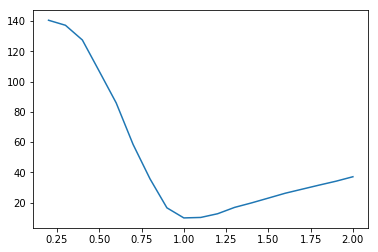

In [10]:
plt.figure()
plt.plot(snr,accuracy)
plt.show()